# VGGish - Speech Commands - Transfer Learning

Using the spectrograms generated previously, this adds a trainable layer onto a frozen copy of VGGish and then trains and evaluates the model.


In [1]:
import sys
sys.path.append("/home/ubuntu/odsc/vggish/lib/models/research/audioset/vggish")

In [2]:
import pandas as pd


In [3]:
import vggish_params
vggish_params.EXAMPLE_HOP_SECONDS, vggish_params.EXAMPLE_WINDOW_SECONDS

(0.96, 0.96)

In [4]:
import numpy as np
import six
import soundfile
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as slim

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [6]:

import vggish_input
import vggish_postprocess
import vggish_slim

pca_params = '/home/ubuntu/odsc/vggish/lib/vggish_pca_params.npz'
ckpt = '/home/ubuntu/odsc/vggish/lib/vggish_model.ckpt'

In [7]:
df = pd.read_csv('wavfile_df.csv', index_col=0)
df.shape

(105835, 3)

In [8]:
with open('wavfile_spec.dat', 'rb') as f:
    audio_data = np.fromfile(f)

In [9]:
audio_array = audio_data.reshape((-1, 96, 64))
audio_array.shape, df.shape

((105835, 96, 64), (105835, 3))

In [10]:
# Drop invalid spectograms
invalid_ind = df[~df['valid']].index

In [11]:
valid_audio = np.delete(audio_array, invalid_ind, axis=0)
valid_audio.shape

(96826, 96, 64)

In [12]:
df = df[df.valid]
df.shape

(96826, 3)

In [13]:
num_classes = len(df.label.unique())
num_classes, df['label'].value_counts()

(35,
 zero        3793
 five        3779
 yes         3743
 seven       3713
 nine        3672
 six         3632
 down        3627
 stop        3602
 no          3599
 two         3579
 left        3550
 one         3542
 go          3528
 on          3522
 right       3483
 off         3473
 eight       3472
 four        3460
 three       3452
 up          3322
 marvin      1884
 house       1872
 dog         1869
 wow         1847
 happy       1811
 sheila      1800
 bird        1792
 cat         1758
 bed         1732
 backward    1567
 tree        1513
 visual      1476
 follow      1463
 forward     1462
 learn       1437
 Name: label, dtype: int64)

In [14]:
del(audio_data, audio_array)

In [15]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
all_labels = one_hot_encoder.fit_transform(df.label.to_numpy().reshape(-1, 1)).todense()

In [16]:
from sklearn.model_selection import train_test_split

audio_train, audio_test, labels_train, labels_test = \
        train_test_split(valid_audio, all_labels, test_size=0.1, stratify=df.label)

In [17]:
del(all_labels, valid_audio)

In [18]:
# audio_train = np.array(audio_train)
# audio_test = np.array(audio_test)
# labels_train = np.array(labels_train)
# labels_test = np.array(labels_test)

In [19]:
audio_train.shape, audio_test.shape, labels_train.shape, labels_test.shape

((87143, 96, 64), (9683, 96, 64), (87143, 35), (9683, 35))

In [20]:
num_batches = 500

In [21]:
audio_train_batches = np.array_split(audio_train, num_batches, axis=0)
labels_train_batches = np.array_split(labels_train, num_batches, axis=0)

In [23]:
# sess.close()

In [24]:
g = tf.Graph()
sess = tf.Session(graph=g)

with g.as_default():
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=False)
    
    # Grab last layer of network before compression to embeddings
    vggish_fc1 = sess.graph.get_tensor_by_name('vggish/fc1/fc1_2/Relu:0')
    
    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
      # Add fully connected layer with 500 units.
        num_units = 500
        fc1 = slim.fully_connected(vggish_fc1, num_units)

        # Add a classifier layer at the end, consisting of parallel logistic
        # classifiers, one per class. This allows for multi-class tasks.
        logits = slim.fully_connected(
          fc1, num_classes, activation_fn=None, scope='logits')
        
        # Add softmax output layer for classification
        tf.nn.softmax(logits, name='prediction')
        
        prediction_tensor = sess.graph.get_tensor_by_name('mymodel/prediction:0')

      # Add training ops.
        with tf.variable_scope('train'):
            global_step = tf.Variable(
                0, name='global_step', trainable=False,
                collections=[tf.GraphKeys.GLOBAL_VARIABLES,
                             tf.GraphKeys.GLOBAL_STEP])

            # Labels are assumed to be fed as a batch multi-hot vectors, with
            # a 1 in the position of each positive class label, and 0 elsewhere.
            labels = tf.placeholder(
                tf.float32, shape=(None, num_classes), name='labels')

            # Cross-entropy label loss.
            xent = tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=labels, name='xent')
            loss = tf.reduce_mean(xent, name='loss_op')
            tf.summary.scalar('loss', loss)

            # We use the same optimizer and hyperparameters as used to train VGGish.
            optimizer = tf.train.AdamOptimizer(
                learning_rate=vggish_params.LEARNING_RATE,
                epsilon=vggish_params.ADAM_EPSILON)
            optimizer.minimize(loss, global_step=global_step, name='train_op')

with g.as_default():
    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, ckpt)

    # Locate all the tensors and ops we need for the training loop.
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    labels_tensor = sess.graph.get_tensor_by_name('mymodel/train/labels:0')
    global_step_tensor = sess.graph.get_tensor_by_name(
        'mymodel/train/global_step:0')
    loss_tensor = sess.graph.get_tensor_by_name('mymodel/train/loss_op:0')
    train_op = sess.graph.get_operation_by_name('mymodel/train/train_op')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from /home/ubuntu/odsc/vggish/lib/vggish_model.ckpt


In [25]:
%%time

# The training loop.
for _ in range(200):
    for i in range(num_batches):
        labels = labels_train_batches[i]
        features = audio_train_batches[i]

        [num_steps, loss, _] = sess.run(
          [global_step_tensor, loss_tensor, train_op],
          feed_dict={features_tensor: features, labels_tensor: labels})
        print('Step %d: loss %g' % (num_steps, loss))


Step 1: loss 3.55874
Step 2: loss 3.55128
Step 3: loss 3.55371
Step 4: loss 3.55708
Step 5: loss 3.54878
Step 6: loss 3.55228
Step 7: loss 3.54124
Step 8: loss 3.55263
Step 9: loss 3.54004
Step 10: loss 3.55537
Step 11: loss 3.55237
Step 12: loss 3.53599
Step 13: loss 3.52802
Step 14: loss 3.54159
Step 15: loss 3.54131
Step 16: loss 3.53561
Step 17: loss 3.5261
Step 18: loss 3.53624
Step 19: loss 3.50935
Step 20: loss 3.54602
Step 21: loss 3.53875
Step 22: loss 3.51456
Step 23: loss 3.51407
Step 24: loss 3.52283
Step 25: loss 3.51023
Step 26: loss 3.52164
Step 27: loss 3.50613
Step 28: loss 3.51844
Step 29: loss 3.52961
Step 30: loss 3.51477
Step 31: loss 3.52941
Step 32: loss 3.51547
Step 33: loss 3.50207
Step 34: loss 3.50878
Step 35: loss 3.5113
Step 36: loss 3.50298
Step 37: loss 3.50234
Step 38: loss 3.50213
Step 39: loss 3.49318
Step 40: loss 3.50727
Step 41: loss 3.51666
Step 42: loss 3.50816
Step 43: loss 3.51258
Step 44: loss 3.51013
Step 45: loss 3.48142
Step 46: loss 3.49379

Step 372: loss 3.25081
Step 373: loss 3.25813
Step 374: loss 3.29669
Step 375: loss 3.21916
Step 376: loss 3.31899
Step 377: loss 3.29355
Step 378: loss 3.24845
Step 379: loss 3.28794
Step 380: loss 3.22861
Step 381: loss 3.25673
Step 382: loss 3.27623
Step 383: loss 3.2813
Step 384: loss 3.21335
Step 385: loss 3.24501
Step 386: loss 3.2297
Step 387: loss 3.25029
Step 388: loss 3.33212
Step 389: loss 3.22481
Step 390: loss 3.25579
Step 391: loss 3.21721
Step 392: loss 3.25514
Step 393: loss 3.30366
Step 394: loss 3.19167
Step 395: loss 3.23048
Step 396: loss 3.25896
Step 397: loss 3.24883
Step 398: loss 3.20714
Step 399: loss 3.22587
Step 400: loss 3.22586
Step 401: loss 3.26534
Step 402: loss 3.21646
Step 403: loss 3.22796
Step 404: loss 3.2367
Step 405: loss 3.26133
Step 406: loss 3.19724
Step 407: loss 3.21261
Step 408: loss 3.25572
Step 409: loss 3.24291
Step 410: loss 3.27754
Step 411: loss 3.24336
Step 412: loss 3.22992
Step 413: loss 3.31423
Step 414: loss 3.22481
Step 415: loss

Step 732: loss 3.05684
Step 733: loss 3.09382
Step 734: loss 3.09864
Step 735: loss 3.06561
Step 736: loss 3.1257
Step 737: loss 3.04911
Step 738: loss 3.08621
Step 739: loss 3.07495
Step 740: loss 3.17437
Step 741: loss 3.14707
Step 742: loss 3.13403
Step 743: loss 3.10814
Step 744: loss 3.01628
Step 745: loss 3.01231
Step 746: loss 3.06855
Step 747: loss 3.02896
Step 748: loss 3.09366
Step 749: loss 3.12299
Step 750: loss 3.11975
Step 751: loss 3.08931
Step 752: loss 3.0184
Step 753: loss 3.0594
Step 754: loss 3.05398
Step 755: loss 3.08274
Step 756: loss 3.08948
Step 757: loss 3.01754
Step 758: loss 3.14047
Step 759: loss 3.0181
Step 760: loss 3.13026
Step 761: loss 3.03928
Step 762: loss 3.06141
Step 763: loss 3.07796
Step 764: loss 3.02918
Step 765: loss 3.11736
Step 766: loss 3.04309
Step 767: loss 3.01671
Step 768: loss 3.13562
Step 769: loss 3.03573
Step 770: loss 3.02209
Step 771: loss 2.98472
Step 772: loss 3.15443
Step 773: loss 3.05286
Step 774: loss 3.01962
Step 775: loss 

Step 1092: loss 2.92215
Step 1093: loss 2.94112
Step 1094: loss 3.10354
Step 1095: loss 3.00971
Step 1096: loss 2.89783
Step 1097: loss 3.02063
Step 1098: loss 2.93123
Step 1099: loss 3.04066
Step 1100: loss 2.96538
Step 1101: loss 2.88547
Step 1102: loss 2.96548
Step 1103: loss 3.02745
Step 1104: loss 3.00065
Step 1105: loss 3.0368
Step 1106: loss 2.87996
Step 1107: loss 2.98271
Step 1108: loss 2.98951
Step 1109: loss 3.02743
Step 1110: loss 3.05052
Step 1111: loss 2.97833
Step 1112: loss 3.008
Step 1113: loss 2.89559
Step 1114: loss 2.91822
Step 1115: loss 3.03447
Step 1116: loss 2.91539
Step 1117: loss 2.88834
Step 1118: loss 2.94716
Step 1119: loss 2.95233
Step 1120: loss 3.02058
Step 1121: loss 2.98094
Step 1122: loss 2.94739
Step 1123: loss 3.02528
Step 1124: loss 3.02858
Step 1125: loss 2.84788
Step 1126: loss 2.96805
Step 1127: loss 2.82474
Step 1128: loss 2.97829
Step 1129: loss 3.02821
Step 1130: loss 2.86398
Step 1131: loss 2.95478
Step 1132: loss 2.88696
Step 1133: loss 3.0

Step 1440: loss 2.88797
Step 1441: loss 2.94191
Step 1442: loss 2.80078
Step 1443: loss 2.93105
Step 1444: loss 2.96725
Step 1445: loss 2.92112
Step 1446: loss 2.85396
Step 1447: loss 2.84936
Step 1448: loss 2.7729
Step 1449: loss 2.89932
Step 1450: loss 2.89281
Step 1451: loss 2.92788
Step 1452: loss 2.93957
Step 1453: loss 2.841
Step 1454: loss 2.89331
Step 1455: loss 3.03203
Step 1456: loss 2.99404
Step 1457: loss 2.90112
Step 1458: loss 2.8226
Step 1459: loss 2.80471
Step 1460: loss 2.81409
Step 1461: loss 2.8366
Step 1462: loss 2.86913
Step 1463: loss 2.79978
Step 1464: loss 2.806
Step 1465: loss 2.82299
Step 1466: loss 2.87312
Step 1467: loss 2.80235
Step 1468: loss 2.74771
Step 1469: loss 2.99002
Step 1470: loss 2.83807
Step 1471: loss 2.82573
Step 1472: loss 2.92352
Step 1473: loss 2.78557
Step 1474: loss 2.91677
Step 1475: loss 2.93758
Step 1476: loss 2.83786
Step 1477: loss 2.82692
Step 1478: loss 2.92503
Step 1479: loss 2.82634
Step 1480: loss 2.92682
Step 1481: loss 2.8193


Step 1788: loss 2.83785
Step 1789: loss 2.77818
Step 1790: loss 2.79651
Step 1791: loss 2.84811
Step 1792: loss 2.77053
Step 1793: loss 2.88111
Step 1794: loss 2.79206
Step 1795: loss 2.92355
Step 1796: loss 2.84075
Step 1797: loss 2.77648
Step 1798: loss 2.73621
Step 1799: loss 2.9148
Step 1800: loss 2.76097
Step 1801: loss 2.80803
Step 1802: loss 2.86703
Step 1803: loss 2.80766
Step 1804: loss 2.79438
Step 1805: loss 2.7474
Step 1806: loss 2.81571
Step 1807: loss 2.76378
Step 1808: loss 2.76888
Step 1809: loss 2.67637
Step 1810: loss 2.6683
Step 1811: loss 2.86928
Step 1812: loss 2.81357
Step 1813: loss 2.7607
Step 1814: loss 2.67973
Step 1815: loss 2.80321
Step 1816: loss 2.74963
Step 1817: loss 2.97036
Step 1818: loss 2.6957
Step 1819: loss 2.73076
Step 1820: loss 2.87728
Step 1821: loss 2.7973
Step 1822: loss 2.81475
Step 1823: loss 2.82021
Step 1824: loss 2.90531
Step 1825: loss 2.72909
Step 1826: loss 2.80806
Step 1827: loss 2.79146
Step 1828: loss 2.86572
Step 1829: loss 2.8849

Step 2136: loss 2.71733
Step 2137: loss 2.80529
Step 2138: loss 2.72948
Step 2139: loss 2.7639
Step 2140: loss 2.8729
Step 2141: loss 2.77096
Step 2142: loss 2.88126
Step 2143: loss 2.87599
Step 2144: loss 2.85043
Step 2145: loss 2.77505
Step 2146: loss 2.66411
Step 2147: loss 2.6921
Step 2148: loss 2.67228
Step 2149: loss 2.85334
Step 2150: loss 2.62107
Step 2151: loss 2.87635
Step 2152: loss 2.71498
Step 2153: loss 2.72951
Step 2154: loss 2.73863
Step 2155: loss 2.79506
Step 2156: loss 2.74362
Step 2157: loss 2.80104
Step 2158: loss 2.8088
Step 2159: loss 2.63752
Step 2160: loss 2.79121
Step 2161: loss 2.75942
Step 2162: loss 2.71478
Step 2163: loss 2.84146
Step 2164: loss 2.85229
Step 2165: loss 2.86416
Step 2166: loss 2.8892
Step 2167: loss 2.68263
Step 2168: loss 2.76978
Step 2169: loss 2.71329
Step 2170: loss 2.92604
Step 2171: loss 2.80181
Step 2172: loss 2.75518
Step 2173: loss 2.83034
Step 2174: loss 2.79527
Step 2175: loss 2.77183
Step 2176: loss 2.70829
Step 2177: loss 2.650

Step 2484: loss 2.79568
Step 2485: loss 2.79118
Step 2486: loss 2.62136
Step 2487: loss 2.64561
Step 2488: loss 2.69956
Step 2489: loss 2.60036
Step 2490: loss 2.66728
Step 2491: loss 2.8453
Step 2492: loss 2.81541
Step 2493: loss 2.71639
Step 2494: loss 2.7665
Step 2495: loss 2.5985
Step 2496: loss 2.75235
Step 2497: loss 2.69938
Step 2498: loss 2.90431
Step 2499: loss 2.73283
Step 2500: loss 2.63862
Step 2501: loss 2.68735
Step 2502: loss 2.69961
Step 2503: loss 2.78423
Step 2504: loss 2.63835
Step 2505: loss 2.64313
Step 2506: loss 2.57678
Step 2507: loss 2.6245
Step 2508: loss 2.64949
Step 2509: loss 2.75269
Step 2510: loss 2.76186
Step 2511: loss 2.77849
Step 2512: loss 2.79068
Step 2513: loss 2.62559
Step 2514: loss 2.78315
Step 2515: loss 2.89058
Step 2516: loss 2.63996
Step 2517: loss 2.70029
Step 2518: loss 2.70124
Step 2519: loss 2.59377
Step 2520: loss 2.78706
Step 2521: loss 2.71586
Step 2522: loss 2.81671
Step 2523: loss 2.60638
Step 2524: loss 2.70926
Step 2525: loss 2.71

Step 2832: loss 2.63393
Step 2833: loss 2.65124
Step 2834: loss 2.71873
Step 2835: loss 2.69796
Step 2836: loss 2.62555
Step 2837: loss 2.71389
Step 2838: loss 2.65204
Step 2839: loss 2.6747
Step 2840: loss 2.77767
Step 2841: loss 2.7796
Step 2842: loss 2.57507
Step 2843: loss 2.73245
Step 2844: loss 2.78466
Step 2845: loss 2.68234
Step 2846: loss 2.63429
Step 2847: loss 2.73923
Step 2848: loss 2.66121
Step 2849: loss 2.79309
Step 2850: loss 2.83868
Step 2851: loss 2.68446
Step 2852: loss 2.68982
Step 2853: loss 2.6802
Step 2854: loss 2.62699
Step 2855: loss 2.56901
Step 2856: loss 2.66408
Step 2857: loss 2.77003
Step 2858: loss 2.67693
Step 2859: loss 2.78105
Step 2860: loss 2.75271
Step 2861: loss 2.66875
Step 2862: loss 2.59751
Step 2863: loss 2.67032
Step 2864: loss 2.60914
Step 2865: loss 2.65154
Step 2866: loss 2.86304
Step 2867: loss 2.74548
Step 2868: loss 2.77054
Step 2869: loss 2.61503
Step 2870: loss 2.54604
Step 2871: loss 2.67044
Step 2872: loss 2.66164
Step 2873: loss 2.6

Step 3180: loss 2.53476
Step 3181: loss 2.77521
Step 3182: loss 2.85617
Step 3183: loss 2.72367
Step 3184: loss 2.59888
Step 3185: loss 2.72323
Step 3186: loss 2.71316
Step 3187: loss 2.59818
Step 3188: loss 2.57782
Step 3189: loss 2.58265
Step 3190: loss 2.58146
Step 3191: loss 2.64676
Step 3192: loss 2.54915
Step 3193: loss 2.7173
Step 3194: loss 2.52397
Step 3195: loss 2.49229
Step 3196: loss 2.67661
Step 3197: loss 2.57369
Step 3198: loss 2.7184
Step 3199: loss 2.73171
Step 3200: loss 2.74531
Step 3201: loss 2.68493
Step 3202: loss 2.60096
Step 3203: loss 2.62938
Step 3204: loss 2.66316
Step 3205: loss 2.6898
Step 3206: loss 2.81338
Step 3207: loss 2.55682
Step 3208: loss 2.76339
Step 3209: loss 2.76716
Step 3210: loss 2.64625
Step 3211: loss 2.62912
Step 3212: loss 2.55003
Step 3213: loss 2.69915
Step 3214: loss 2.5216
Step 3215: loss 2.70907
Step 3216: loss 2.60151
Step 3217: loss 2.71782
Step 3218: loss 2.70163
Step 3219: loss 2.61338
Step 3220: loss 2.67541
Step 3221: loss 2.48

Step 3528: loss 2.69834
Step 3529: loss 2.60368
Step 3530: loss 2.51265
Step 3531: loss 2.6907
Step 3532: loss 2.6975
Step 3533: loss 2.65195
Step 3534: loss 2.66007
Step 3535: loss 2.76994
Step 3536: loss 2.40255
Step 3537: loss 2.60743
Step 3538: loss 2.66759
Step 3539: loss 2.61821
Step 3540: loss 2.71583
Step 3541: loss 2.7435
Step 3542: loss 2.71357
Step 3543: loss 2.66566
Step 3544: loss 2.68689
Step 3545: loss 2.57188
Step 3546: loss 2.59489
Step 3547: loss 2.614
Step 3548: loss 2.6433
Step 3549: loss 2.63642
Step 3550: loss 2.55527
Step 3551: loss 2.61204
Step 3552: loss 2.60823
Step 3553: loss 2.61042
Step 3554: loss 2.56679
Step 3555: loss 2.54362
Step 3556: loss 2.5517
Step 3557: loss 2.66572
Step 3558: loss 2.66863
Step 3559: loss 2.66252
Step 3560: loss 2.46896
Step 3561: loss 2.60822
Step 3562: loss 2.56296
Step 3563: loss 2.56092
Step 3564: loss 2.58721
Step 3565: loss 2.6788
Step 3566: loss 2.61138
Step 3567: loss 2.60728
Step 3568: loss 2.82041
Step 3569: loss 2.80502


Step 3876: loss 2.78731
Step 3877: loss 2.58694
Step 3878: loss 2.56826
Step 3879: loss 2.67067
Step 3880: loss 2.4791
Step 3881: loss 2.52867
Step 3882: loss 2.73678
Step 3883: loss 2.63546
Step 3884: loss 2.5735
Step 3885: loss 2.542
Step 3886: loss 2.54876
Step 3887: loss 2.64526
Step 3888: loss 2.806
Step 3889: loss 2.57742
Step 3890: loss 2.56825
Step 3891: loss 2.59601
Step 3892: loss 2.66119
Step 3893: loss 2.64952
Step 3894: loss 2.5055
Step 3895: loss 2.58428
Step 3896: loss 2.56123
Step 3897: loss 2.70651
Step 3898: loss 2.66472
Step 3899: loss 2.64517
Step 3900: loss 2.52731
Step 3901: loss 2.61504
Step 3902: loss 2.61573
Step 3903: loss 2.53484
Step 3904: loss 2.70608
Step 3905: loss 2.69662
Step 3906: loss 2.55869
Step 3907: loss 2.51915
Step 3908: loss 2.66996
Step 3909: loss 2.571
Step 3910: loss 2.66597
Step 3911: loss 2.77081
Step 3912: loss 2.59188
Step 3913: loss 2.69534
Step 3914: loss 2.7
Step 3915: loss 2.65527
Step 3916: loss 2.65719
Step 3917: loss 2.54833
Step 

Step 4224: loss 2.70696
Step 4225: loss 2.68685
Step 4226: loss 2.40562
Step 4227: loss 2.54973
Step 4228: loss 2.60487
Step 4229: loss 2.7158
Step 4230: loss 2.60562
Step 4231: loss 2.66167
Step 4232: loss 2.46445
Step 4233: loss 2.60587
Step 4234: loss 2.56618
Step 4235: loss 2.49429
Step 4236: loss 2.73497
Step 4237: loss 2.50621
Step 4238: loss 2.59803
Step 4239: loss 2.60795
Step 4240: loss 2.72558
Step 4241: loss 2.59066
Step 4242: loss 2.69461
Step 4243: loss 2.63737
Step 4244: loss 2.54976
Step 4245: loss 2.50064
Step 4246: loss 2.57526
Step 4247: loss 2.4745
Step 4248: loss 2.61427
Step 4249: loss 2.60528
Step 4250: loss 2.63289
Step 4251: loss 2.66792
Step 4252: loss 2.52824
Step 4253: loss 2.55123
Step 4254: loss 2.44279
Step 4255: loss 2.61739
Step 4256: loss 2.55727
Step 4257: loss 2.57658
Step 4258: loss 2.70767
Step 4259: loss 2.51197
Step 4260: loss 2.68084
Step 4261: loss 2.48216
Step 4262: loss 2.54503
Step 4263: loss 2.54572
Step 4264: loss 2.53087
Step 4265: loss 2.

Step 4572: loss 2.653
Step 4573: loss 2.53304
Step 4574: loss 2.54064
Step 4575: loss 2.53586
Step 4576: loss 2.70392
Step 4577: loss 2.68815
Step 4578: loss 2.49072
Step 4579: loss 2.56296
Step 4580: loss 2.55364
Step 4581: loss 2.48306
Step 4582: loss 2.59414
Step 4583: loss 2.57202
Step 4584: loss 2.69746
Step 4585: loss 2.57693
Step 4586: loss 2.62235
Step 4587: loss 2.56755
Step 4588: loss 2.61303
Step 4589: loss 2.51269
Step 4590: loss 2.69401
Step 4591: loss 2.62327
Step 4592: loss 2.49192
Step 4593: loss 2.50514
Step 4594: loss 2.7954
Step 4595: loss 2.61306
Step 4596: loss 2.5068
Step 4597: loss 2.61886
Step 4598: loss 2.53955
Step 4599: loss 2.63267
Step 4600: loss 2.52827
Step 4601: loss 2.37351
Step 4602: loss 2.52719
Step 4603: loss 2.67232
Step 4604: loss 2.64011
Step 4605: loss 2.69625
Step 4606: loss 2.51749
Step 4607: loss 2.54565
Step 4608: loss 2.63412
Step 4609: loss 2.64844
Step 4610: loss 2.68339
Step 4611: loss 2.59351
Step 4612: loss 2.65387
Step 4613: loss 2.47

Step 4920: loss 2.48926
Step 4921: loss 2.5941
Step 4922: loss 2.73321
Step 4923: loss 2.632
Step 4924: loss 2.54009
Step 4925: loss 2.53938
Step 4926: loss 2.51714
Step 4927: loss 2.55283
Step 4928: loss 2.6341
Step 4929: loss 2.61768
Step 4930: loss 2.6738
Step 4931: loss 2.51567
Step 4932: loss 2.55472
Step 4933: loss 2.55398
Step 4934: loss 2.42791
Step 4935: loss 2.56043
Step 4936: loss 2.59809
Step 4937: loss 2.53666
Step 4938: loss 2.56743
Step 4939: loss 2.38076
Step 4940: loss 2.58874
Step 4941: loss 2.60957
Step 4942: loss 2.4006
Step 4943: loss 2.58753
Step 4944: loss 2.74189
Step 4945: loss 2.52703
Step 4946: loss 2.48474
Step 4947: loss 2.4872
Step 4948: loss 2.39627
Step 4949: loss 2.59204
Step 4950: loss 2.52679
Step 4951: loss 2.58774
Step 4952: loss 2.65351
Step 4953: loss 2.5098
Step 4954: loss 2.58468
Step 4955: loss 2.71876
Step 4956: loss 2.64762
Step 4957: loss 2.48229
Step 4958: loss 2.47524
Step 4959: loss 2.43186
Step 4960: loss 2.45075
Step 4961: loss 2.47292


Step 5268: loss 2.6068
Step 5269: loss 2.4108
Step 5270: loss 2.47392
Step 5271: loss 2.39368
Step 5272: loss 2.69947
Step 5273: loss 2.48298
Step 5274: loss 2.51036
Step 5275: loss 2.52274
Step 5276: loss 2.57491
Step 5277: loss 2.37195
Step 5278: loss 2.51196
Step 5279: loss 2.51719
Step 5280: loss 2.64319
Step 5281: loss 2.56636
Step 5282: loss 2.59769
Step 5283: loss 2.56415
Step 5284: loss 2.56922
Step 5285: loss 2.46072
Step 5286: loss 2.48511
Step 5287: loss 2.58936
Step 5288: loss 2.53753
Step 5289: loss 2.43807
Step 5290: loss 2.4538
Step 5291: loss 2.54761
Step 5292: loss 2.52476
Step 5293: loss 2.62785
Step 5294: loss 2.51975
Step 5295: loss 2.60477
Step 5296: loss 2.53239
Step 5297: loss 2.476
Step 5298: loss 2.45819
Step 5299: loss 2.68866
Step 5300: loss 2.45999
Step 5301: loss 2.54955
Step 5302: loss 2.56629
Step 5303: loss 2.52778
Step 5304: loss 2.54309
Step 5305: loss 2.39239
Step 5306: loss 2.53324
Step 5307: loss 2.50807
Step 5308: loss 2.48704
Step 5309: loss 2.301

Step 5616: loss 2.47088
Step 5617: loss 2.44679
Step 5618: loss 2.5017
Step 5619: loss 2.51265
Step 5620: loss 2.59446
Step 5621: loss 2.51227
Step 5622: loss 2.3387
Step 5623: loss 2.62209
Step 5624: loss 2.59885
Step 5625: loss 2.3482
Step 5626: loss 2.59293
Step 5627: loss 2.43589
Step 5628: loss 2.54015
Step 5629: loss 2.60265
Step 5630: loss 2.34243
Step 5631: loss 2.50139
Step 5632: loss 2.40175
Step 5633: loss 2.52974
Step 5634: loss 2.35219
Step 5635: loss 2.4256
Step 5636: loss 2.41638
Step 5637: loss 2.56474
Step 5638: loss 2.45252
Step 5639: loss 2.49734
Step 5640: loss 2.6147
Step 5641: loss 2.4405
Step 5642: loss 2.64676
Step 5643: loss 2.6416
Step 5644: loss 2.60328
Step 5645: loss 2.55125
Step 5646: loss 2.42155
Step 5647: loss 2.46253
Step 5648: loss 2.34726
Step 5649: loss 2.57476
Step 5650: loss 2.31012
Step 5651: loss 2.63244
Step 5652: loss 2.41817
Step 5653: loss 2.47702
Step 5654: loss 2.47851
Step 5655: loss 2.52738
Step 5656: loss 2.48449
Step 5657: loss 2.56287

Step 5964: loss 2.46363
Step 5965: loss 2.40602
Step 5966: loss 2.43454
Step 5967: loss 2.35933
Step 5968: loss 2.34785
Step 5969: loss 2.64681
Step 5970: loss 2.4453
Step 5971: loss 2.46271
Step 5972: loss 2.58324
Step 5973: loss 2.38263
Step 5974: loss 2.61414
Step 5975: loss 2.5714
Step 5976: loss 2.45419
Step 5977: loss 2.39223
Step 5978: loss 2.53032
Step 5979: loss 2.35152
Step 5980: loss 2.60437
Step 5981: loss 2.44842
Step 5982: loss 2.45589
Step 5983: loss 2.42242
Step 5984: loss 2.59742
Step 5985: loss 2.58982
Step 5986: loss 2.3633
Step 5987: loss 2.42826
Step 5988: loss 2.44715
Step 5989: loss 2.35295
Step 5990: loss 2.46545
Step 5991: loss 2.65509
Step 5992: loss 2.65045
Step 5993: loss 2.51975
Step 5994: loss 2.58885
Step 5995: loss 2.33486
Step 5996: loss 2.51805
Step 5997: loss 2.45689
Step 5998: loss 2.71544
Step 5999: loss 2.52039
Step 6000: loss 2.38431
Step 6001: loss 2.46678
Step 6002: loss 2.46416
Step 6003: loss 2.53347
Step 6004: loss 2.40991
Step 6005: loss 2.3

Step 6312: loss 2.56376
Step 6313: loss 2.43608
Step 6314: loss 2.39844
Step 6315: loss 2.47845
Step 6316: loss 2.46291
Step 6317: loss 2.67658
Step 6318: loss 2.34665
Step 6319: loss 2.38379
Step 6320: loss 2.52706
Step 6321: loss 2.40641
Step 6322: loss 2.45729
Step 6323: loss 2.45081
Step 6324: loss 2.57303
Step 6325: loss 2.40363
Step 6326: loss 2.46775
Step 6327: loss 2.45866
Step 6328: loss 2.53029
Step 6329: loss 2.50312
Step 6330: loss 2.49798
Step 6331: loss 2.49904
Step 6332: loss 2.42357
Step 6333: loss 2.43328
Step 6334: loss 2.48835
Step 6335: loss 2.48704
Step 6336: loss 2.46668
Step 6337: loss 2.51919
Step 6338: loss 2.46413
Step 6339: loss 2.49572
Step 6340: loss 2.56936
Step 6341: loss 2.58286
Step 6342: loss 2.37394
Step 6343: loss 2.50634
Step 6344: loss 2.61505
Step 6345: loss 2.50183
Step 6346: loss 2.39283
Step 6347: loss 2.54681
Step 6348: loss 2.45847
Step 6349: loss 2.61991
Step 6350: loss 2.66518
Step 6351: loss 2.47425
Step 6352: loss 2.47478
Step 6353: loss 

Step 6660: loss 2.4773
Step 6661: loss 2.41143
Step 6662: loss 2.42104
Step 6663: loss 2.56631
Step 6664: loss 2.5484
Step 6665: loss 2.57985
Step 6666: loss 2.64318
Step 6667: loss 2.41639
Step 6668: loss 2.47872
Step 6669: loss 2.48673
Step 6670: loss 2.68193
Step 6671: loss 2.5313
Step 6672: loss 2.47234
Step 6673: loss 2.45316
Step 6674: loss 2.45917
Step 6675: loss 2.50999
Step 6676: loss 2.39989
Step 6677: loss 2.34118
Step 6678: loss 2.43619
Step 6679: loss 2.45348
Step 6680: loss 2.32038
Step 6681: loss 2.59801
Step 6682: loss 2.71619
Step 6683: loss 2.56419
Step 6684: loss 2.40311
Step 6685: loss 2.55918
Step 6686: loss 2.55318
Step 6687: loss 2.42318
Step 6688: loss 2.39504
Step 6689: loss 2.38351
Step 6690: loss 2.37108
Step 6691: loss 2.42613
Step 6692: loss 2.37701
Step 6693: loss 2.54912
Step 6694: loss 2.31309
Step 6695: loss 2.29197
Step 6696: loss 2.47549
Step 6697: loss 2.36318
Step 6698: loss 2.56233
Step 6699: loss 2.57942
Step 6700: loss 2.58084
Step 6701: loss 2.5

Step 7008: loss 2.41621
Step 7009: loss 2.45961
Step 7010: loss 2.53167
Step 7011: loss 2.53402
Step 7012: loss 2.52707
Step 7013: loss 2.40296
Step 7014: loss 2.53229
Step 7015: loss 2.6472
Step 7016: loss 2.35894
Step 7017: loss 2.45798
Step 7018: loss 2.4199
Step 7019: loss 2.33609
Step 7020: loss 2.48841
Step 7021: loss 2.40835
Step 7022: loss 2.59892
Step 7023: loss 2.35796
Step 7024: loss 2.46445
Step 7025: loss 2.47666
Step 7026: loss 2.44301
Step 7027: loss 2.51311
Step 7028: loss 2.51657
Step 7029: loss 2.42978
Step 7030: loss 2.30503
Step 7031: loss 2.50258
Step 7032: loss 2.55041
Step 7033: loss 2.52924
Step 7034: loss 2.52172
Step 7035: loss 2.60362
Step 7036: loss 2.17821
Step 7037: loss 2.45273
Step 7038: loss 2.49754
Step 7039: loss 2.47387
Step 7040: loss 2.54058
Step 7041: loss 2.56602
Step 7042: loss 2.53392
Step 7043: loss 2.47141
Step 7044: loss 2.521
Step 7045: loss 2.41566
Step 7046: loss 2.39321
Step 7047: loss 2.45132
Step 7048: loss 2.44705
Step 7049: loss 2.43

Step 7356: loss 2.4431
Step 7357: loss 2.52924
Step 7358: loss 2.45325
Step 7359: loss 2.53872
Step 7360: loss 2.51033
Step 7361: loss 2.43519
Step 7362: loss 2.33005
Step 7363: loss 2.46068
Step 7364: loss 2.37604
Step 7365: loss 2.39706
Step 7366: loss 2.66555
Step 7367: loss 2.52836
Step 7368: loss 2.59088
Step 7369: loss 2.38551
Step 7370: loss 2.29595
Step 7371: loss 2.43694
Step 7372: loss 2.46241
Step 7373: loss 2.41629
Step 7374: loss 2.50861
Step 7375: loss 2.41305
Step 7376: loss 2.67966
Step 7377: loss 2.4203
Step 7378: loss 2.40093
Step 7379: loss 2.49528
Step 7380: loss 2.29799
Step 7381: loss 2.37048
Step 7382: loss 2.58159
Step 7383: loss 2.45931
Step 7384: loss 2.43395
Step 7385: loss 2.36386
Step 7386: loss 2.39081
Step 7387: loss 2.4673
Step 7388: loss 2.65106
Step 7389: loss 2.42455
Step 7390: loss 2.36896
Step 7391: loss 2.43513
Step 7392: loss 2.523
Step 7393: loss 2.48342
Step 7394: loss 2.34688
Step 7395: loss 2.42314
Step 7396: loss 2.37593
Step 7397: loss 2.593

Step 7704: loss 2.46619
Step 7705: loss 2.54434
Step 7706: loss 2.63902
Step 7707: loss 2.36686
Step 7708: loss 2.523
Step 7709: loss 2.56407
Step 7710: loss 2.38791
Step 7711: loss 2.42088
Step 7712: loss 2.3472
Step 7713: loss 2.4815
Step 7714: loss 2.29248
Step 7715: loss 2.47998
Step 7716: loss 2.42694
Step 7717: loss 2.48091
Step 7718: loss 2.50664
Step 7719: loss 2.40168
Step 7720: loss 2.43219
Step 7721: loss 2.33838
Step 7722: loss 2.55304
Step 7723: loss 2.5485
Step 7724: loss 2.54818
Step 7725: loss 2.57389
Step 7726: loss 2.26744
Step 7727: loss 2.39912
Step 7728: loss 2.47351
Step 7729: loss 2.59293
Step 7730: loss 2.44311
Step 7731: loss 2.54601
Step 7732: loss 2.29879
Step 7733: loss 2.48232
Step 7734: loss 2.38734
Step 7735: loss 2.32952
Step 7736: loss 2.63347
Step 7737: loss 2.37302
Step 7738: loss 2.4664
Step 7739: loss 2.49702
Step 7740: loss 2.57416
Step 7741: loss 2.42481
Step 7742: loss 2.56516
Step 7743: loss 2.49244
Step 7744: loss 2.399
Step 7745: loss 2.36552


Step 8052: loss 2.42139
Step 8053: loss 2.40306
Step 8054: loss 2.36721
Step 8055: loss 2.33565
Step 8056: loss 2.34207
Step 8057: loss 2.48294
Step 8058: loss 2.48218
Step 8059: loss 2.46952
Step 8060: loss 2.2375
Step 8061: loss 2.40761
Step 8062: loss 2.38045
Step 8063: loss 2.33026
Step 8064: loss 2.42117
Step 8065: loss 2.45693
Step 8066: loss 2.43987
Step 8067: loss 2.42029
Step 8068: loss 2.58746
Step 8069: loss 2.64234
Step 8070: loss 2.56517
Step 8071: loss 2.30082
Step 8072: loss 2.51875
Step 8073: loss 2.39061
Step 8074: loss 2.3867
Step 8075: loss 2.417
Step 8076: loss 2.58179
Step 8077: loss 2.57488
Step 8078: loss 2.37872
Step 8079: loss 2.41152
Step 8080: loss 2.43737
Step 8081: loss 2.34706
Step 8082: loss 2.46081
Step 8083: loss 2.44173
Step 8084: loss 2.60886
Step 8085: loss 2.44089
Step 8086: loss 2.48016
Step 8087: loss 2.41811
Step 8088: loss 2.48516
Step 8089: loss 2.38135
Step 8090: loss 2.60647
Step 8091: loss 2.5218
Step 8092: loss 2.34554
Step 8093: loss 2.346

Step 8400: loss 2.32628
Step 8401: loss 2.40986
Step 8402: loss 2.48265
Step 8403: loss 2.33885
Step 8404: loss 2.53864
Step 8405: loss 2.50638
Step 8406: loss 2.34073
Step 8407: loss 2.34622
Step 8408: loss 2.51444
Step 8409: loss 2.36056
Step 8410: loss 2.49849
Step 8411: loss 2.60966
Step 8412: loss 2.44215
Step 8413: loss 2.50803
Step 8414: loss 2.57194
Step 8415: loss 2.50388
Step 8416: loss 2.47722
Step 8417: loss 2.36239
Step 8418: loss 2.28662
Step 8419: loss 2.31279
Step 8420: loss 2.35051
Step 8421: loss 2.46643
Step 8422: loss 2.61856
Step 8423: loss 2.51888
Step 8424: loss 2.39693
Step 8425: loss 2.42498
Step 8426: loss 2.43064
Step 8427: loss 2.4353
Step 8428: loss 2.5472
Step 8429: loss 2.5176
Step 8430: loss 2.54851
Step 8431: loss 2.37632
Step 8432: loss 2.41953
Step 8433: loss 2.3966
Step 8434: loss 2.27844
Step 8435: loss 2.43616
Step 8436: loss 2.44671
Step 8437: loss 2.42436
Step 8438: loss 2.42544
Step 8439: loss 2.25946
Step 8440: loss 2.4818
Step 8441: loss 2.464

Step 8748: loss 2.43165
Step 8749: loss 2.43998
Step 8750: loss 2.48093
Step 8751: loss 2.51757
Step 8752: loss 2.37757
Step 8753: loss 2.38507
Step 8754: loss 2.27123
Step 8755: loss 2.4531
Step 8756: loss 2.32997
Step 8757: loss 2.41981
Step 8758: loss 2.53427
Step 8759: loss 2.36881
Step 8760: loss 2.53749
Step 8761: loss 2.30208
Step 8762: loss 2.33639
Step 8763: loss 2.36429
Step 8764: loss 2.36557
Step 8765: loss 2.45592
Step 8766: loss 2.31371
Step 8767: loss 2.37411
Step 8768: loss 2.48943
Step 8769: loss 2.26472
Step 8770: loss 2.33936
Step 8771: loss 2.27077
Step 8772: loss 2.58972
Step 8773: loss 2.35078
Step 8774: loss 2.38597
Step 8775: loss 2.44005
Step 8776: loss 2.47571
Step 8777: loss 2.23053
Step 8778: loss 2.37377
Step 8779: loss 2.42021
Step 8780: loss 2.54216
Step 8781: loss 2.42536
Step 8782: loss 2.48104
Step 8783: loss 2.43726
Step 8784: loss 2.45443
Step 8785: loss 2.35502
Step 8786: loss 2.34253
Step 8787: loss 2.47515
Step 8788: loss 2.42113
Step 8789: loss 2

Step 9096: loss 2.35307
Step 9097: loss 2.47197
Step 9098: loss 2.40671
Step 9099: loss 2.47955
Step 9100: loss 2.35527
Step 9101: loss 2.19515
Step 9102: loss 2.34847
Step 9103: loss 2.54146
Step 9104: loss 2.49305
Step 9105: loss 2.56776
Step 9106: loss 2.37908
Step 9107: loss 2.35853
Step 9108: loss 2.4939
Step 9109: loss 2.49986
Step 9110: loss 2.51866
Step 9111: loss 2.4556
Step 9112: loss 2.50287
Step 9113: loss 2.3206
Step 9114: loss 2.34779
Step 9115: loss 2.45704
Step 9116: loss 2.35805
Step 9117: loss 2.34286
Step 9118: loss 2.38613
Step 9119: loss 2.39135
Step 9120: loss 2.47549
Step 9121: loss 2.38126
Step 9122: loss 2.19223
Step 9123: loss 2.51023
Step 9124: loss 2.49682
Step 9125: loss 2.2092
Step 9126: loss 2.49541
Step 9127: loss 2.35464
Step 9128: loss 2.43242
Step 9129: loss 2.50759
Step 9130: loss 2.20533
Step 9131: loss 2.39555
Step 9132: loss 2.27545
Step 9133: loss 2.39762
Step 9134: loss 2.22479
Step 9135: loss 2.31765
Step 9136: loss 2.29228
Step 9137: loss 2.45

Step 9444: loss 2.62083
Step 9445: loss 2.37426
Step 9446: loss 2.31139
Step 9447: loss 2.32021
Step 9448: loss 2.25351
Step 9449: loss 2.44059
Step 9450: loss 2.34887
Step 9451: loss 2.45343
Step 9452: loss 2.5351
Step 9453: loss 2.37618
Step 9454: loss 2.46151
Step 9455: loss 2.56745
Step 9456: loss 2.47872
Step 9457: loss 2.30849
Step 9458: loss 2.34084
Step 9459: loss 2.2827
Step 9460: loss 2.29491
Step 9461: loss 2.2996
Step 9462: loss 2.37996
Step 9463: loss 2.32373
Step 9464: loss 2.36715
Step 9465: loss 2.28827
Step 9466: loss 2.33015
Step 9467: loss 2.23413
Step 9468: loss 2.24485
Step 9469: loss 2.55855
Step 9470: loss 2.32707
Step 9471: loss 2.37093
Step 9472: loss 2.48059
Step 9473: loss 2.26149
Step 9474: loss 2.5291
Step 9475: loss 2.46663
Step 9476: loss 2.35072
Step 9477: loss 2.277
Step 9478: loss 2.42162
Step 9479: loss 2.24198
Step 9480: loss 2.50599
Step 9481: loss 2.34281
Step 9482: loss 2.35568
Step 9483: loss 2.31958
Step 9484: loss 2.49197
Step 9485: loss 2.5048

Step 9792: loss 2.4109
Step 9793: loss 2.49927
Step 9794: loss 2.38178
Step 9795: loss 2.41244
Step 9796: loss 2.37498
Step 9797: loss 2.33104
Step 9798: loss 2.32403
Step 9799: loss 2.54282
Step 9800: loss 2.33143
Step 9801: loss 2.41793
Step 9802: loss 2.41957
Step 9803: loss 2.39785
Step 9804: loss 2.42651
Step 9805: loss 2.1993
Step 9806: loss 2.40832
Step 9807: loss 2.3774
Step 9808: loss 2.3452
Step 9809: loss 2.13075
Step 9810: loss 2.20458
Step 9811: loss 2.4849
Step 9812: loss 2.49697
Step 9813: loss 2.33757
Step 9814: loss 2.31862
Step 9815: loss 2.37388
Step 9816: loss 2.37636
Step 9817: loss 2.56806
Step 9818: loss 2.24797
Step 9819: loss 2.28808
Step 9820: loss 2.42748
Step 9821: loss 2.27169
Step 9822: loss 2.35758
Step 9823: loss 2.35105
Step 9824: loss 2.46496
Step 9825: loss 2.3215
Step 9826: loss 2.36622
Step 9827: loss 2.34848
Step 9828: loss 2.41756
Step 9829: loss 2.37227
Step 9830: loss 2.3925
Step 9831: loss 2.39253
Step 9832: loss 2.325
Step 9833: loss 2.33322
S

Step 10140: loss 2.4665
Step 10141: loss 2.24829
Step 10142: loss 2.51846
Step 10143: loss 2.53266
Step 10144: loss 2.46824
Step 10145: loss 2.43287
Step 10146: loss 2.29559
Step 10147: loss 2.33322
Step 10148: loss 2.1839
Step 10149: loss 2.42066
Step 10150: loss 2.16757
Step 10151: loss 2.48194
Step 10152: loss 2.25268
Step 10153: loss 2.33691
Step 10154: loss 2.35346
Step 10155: loss 2.37852
Step 10156: loss 2.3563
Step 10157: loss 2.44447
Step 10158: loss 2.43622
Step 10159: loss 2.27346
Step 10160: loss 2.36709
Step 10161: loss 2.2891
Step 10162: loss 2.32575
Step 10163: loss 2.47315
Step 10164: loss 2.45513
Step 10165: loss 2.4712
Step 10166: loss 2.53717
Step 10167: loss 2.31613
Step 10168: loss 2.38306
Step 10169: loss 2.40692
Step 10170: loss 2.59175
Step 10171: loss 2.43662
Step 10172: loss 2.38479
Step 10173: loss 2.3282
Step 10174: loss 2.35367
Step 10175: loss 2.4282
Step 10176: loss 2.2923
Step 10177: loss 2.24273
Step 10178: loss 2.3427
Step 10179: loss 2.36211
Step 1018

Step 10476: loss 2.32859
Step 10477: loss 2.25373
Step 10478: loss 2.39891
Step 10479: loss 2.21989
Step 10480: loss 2.48408
Step 10481: loss 2.31837
Step 10482: loss 2.33564
Step 10483: loss 2.29621
Step 10484: loss 2.46762
Step 10485: loss 2.4863
Step 10486: loss 2.232
Step 10487: loss 2.28367
Step 10488: loss 2.28373
Step 10489: loss 2.22577
Step 10490: loss 2.34039
Step 10491: loss 2.53653
Step 10492: loss 2.54086
Step 10493: loss 2.39374
Step 10494: loss 2.4707
Step 10495: loss 2.17853
Step 10496: loss 2.38569
Step 10497: loss 2.30878
Step 10498: loss 2.5969
Step 10499: loss 2.42411
Step 10500: loss 2.24815
Step 10501: loss 2.34424
Step 10502: loss 2.32151
Step 10503: loss 2.37826
Step 10504: loss 2.29444
Step 10505: loss 2.23093
Step 10506: loss 2.20685
Step 10507: loss 2.20106
Step 10508: loss 2.3451
Step 10509: loss 2.35334
Step 10510: loss 2.44794
Step 10511: loss 2.45988
Step 10512: loss 2.42729
Step 10513: loss 2.32378
Step 10514: loss 2.43869
Step 10515: loss 2.53753
Step 1

Step 10812: loss 2.48184
Step 10813: loss 2.31564
Step 10814: loss 2.30057
Step 10815: loss 2.35045
Step 10816: loss 2.35528
Step 10817: loss 2.54374
Step 10818: loss 2.22688
Step 10819: loss 2.26743
Step 10820: loss 2.4062
Step 10821: loss 2.24135
Step 10822: loss 2.33568
Step 10823: loss 2.32908
Step 10824: loss 2.44114
Step 10825: loss 2.30436
Step 10826: loss 2.34361
Step 10827: loss 2.32269
Step 10828: loss 2.39256
Step 10829: loss 2.34433
Step 10830: loss 2.36829
Step 10831: loss 2.36923
Step 10832: loss 2.30333
Step 10833: loss 2.31235
Step 10834: loss 2.35848
Step 10835: loss 2.36727
Step 10836: loss 2.36274
Step 10837: loss 2.39809
Step 10838: loss 2.36335
Step 10839: loss 2.38728
Step 10840: loss 2.43681
Step 10841: loss 2.46612
Step 10842: loss 2.26425
Step 10843: loss 2.37311
Step 10844: loss 2.5034
Step 10845: loss 2.39517
Step 10846: loss 2.24675
Step 10847: loss 2.43678
Step 10848: loss 2.33374
Step 10849: loss 2.51625
Step 10850: loss 2.54991
Step 10851: loss 2.3573
Ste

Step 11148: loss 2.16045
Step 11149: loss 2.39589
Step 11150: loss 2.14627
Step 11151: loss 2.45681
Step 11152: loss 2.22636
Step 11153: loss 2.31246
Step 11154: loss 2.33546
Step 11155: loss 2.35459
Step 11156: loss 2.33485
Step 11157: loss 2.42467
Step 11158: loss 2.41693
Step 11159: loss 2.25147
Step 11160: loss 2.34195
Step 11161: loss 2.26166
Step 11162: loss 2.30329
Step 11163: loss 2.45243
Step 11164: loss 2.43447
Step 11165: loss 2.4461
Step 11166: loss 2.51137
Step 11167: loss 2.29219
Step 11168: loss 2.36127
Step 11169: loss 2.38741
Step 11170: loss 2.57223
Step 11171: loss 2.41548
Step 11172: loss 2.36458
Step 11173: loss 2.30155
Step 11174: loss 2.33019
Step 11175: loss 2.40982
Step 11176: loss 2.26933
Step 11177: loss 2.22067
Step 11178: loss 2.32127
Step 11179: loss 2.34194
Step 11180: loss 2.19234
Step 11181: loss 2.46859
Step 11182: loss 2.60431
Step 11183: loss 2.45572
Step 11184: loss 2.28202
Step 11185: loss 2.45274
Step 11186: loss 2.44759
Step 11187: loss 2.30786
S

Step 11483: loss 2.27423
Step 11484: loss 2.44438
Step 11485: loss 2.46903
Step 11486: loss 2.21087
Step 11487: loss 2.25853
Step 11488: loss 2.25619
Step 11489: loss 2.20593
Step 11490: loss 2.31983
Step 11491: loss 2.51518
Step 11492: loss 2.51987
Step 11493: loss 2.37151
Step 11494: loss 2.44938
Step 11495: loss 2.15304
Step 11496: loss 2.36434
Step 11497: loss 2.28506
Step 11498: loss 2.5775
Step 11499: loss 2.40908
Step 11500: loss 2.22649
Step 11501: loss 2.32416
Step 11502: loss 2.2959
Step 11503: loss 2.35364
Step 11504: loss 2.27478
Step 11505: loss 2.20684
Step 11506: loss 2.18435
Step 11507: loss 2.17817
Step 11508: loss 2.32884
Step 11509: loss 2.3293
Step 11510: loss 2.42911
Step 11511: loss 2.44341
Step 11512: loss 2.40396
Step 11513: loss 2.30423
Step 11514: loss 2.41736
Step 11515: loss 2.51162
Step 11516: loss 2.25508
Step 11517: loss 2.34397
Step 11518: loss 2.29546
Step 11519: loss 2.24279
Step 11520: loss 2.34271
Step 11521: loss 2.29114
Step 11522: loss 2.50312
Ste

Step 11819: loss 2.24855
Step 11820: loss 2.38756
Step 11821: loss 2.21342
Step 11822: loss 2.31528
Step 11823: loss 2.30861
Step 11824: loss 2.41906
Step 11825: loss 2.2888
Step 11826: loss 2.32263
Step 11827: loss 2.29899
Step 11828: loss 2.36964
Step 11829: loss 2.31882
Step 11830: loss 2.34533
Step 11831: loss 2.34815
Step 11832: loss 2.2834
Step 11833: loss 2.29303
Step 11834: loss 2.33735
Step 11835: loss 2.34788
Step 11836: loss 2.34443
Step 11837: loss 2.37778
Step 11838: loss 2.34627
Step 11839: loss 2.36787
Step 11840: loss 2.41375
Step 11841: loss 2.4469
Step 11842: loss 2.24579
Step 11843: loss 2.3517
Step 11844: loss 2.48331
Step 11845: loss 2.37733
Step 11846: loss 2.22366
Step 11847: loss 2.41794
Step 11848: loss 2.31217
Step 11849: loss 2.49804
Step 11850: loss 2.52869
Step 11851: loss 2.3381
Step 11852: loss 2.32078
Step 11853: loss 2.36977
Step 11854: loss 2.22638
Step 11855: loss 2.19266
Step 11856: loss 2.3342
Step 11857: loss 2.42715
Step 11858: loss 2.35636
Step 1

Step 12155: loss 2.3318
Step 12156: loss 2.31425
Step 12157: loss 2.40583
Step 12158: loss 2.39922
Step 12159: loss 2.23093
Step 12160: loss 2.3184
Step 12161: loss 2.23667
Step 12162: loss 2.28252
Step 12163: loss 2.43291
Step 12164: loss 2.41513
Step 12165: loss 2.42226
Step 12166: loss 2.48667
Step 12167: loss 2.26954
Step 12168: loss 2.3407
Step 12169: loss 2.36857
Step 12170: loss 2.55425
Step 12171: loss 2.39628
Step 12172: loss 2.34563
Step 12173: loss 2.27705
Step 12174: loss 2.30822
Step 12175: loss 2.39287
Step 12176: loss 2.24848
Step 12177: loss 2.19977
Step 12178: loss 2.30115
Step 12179: loss 2.32328
Step 12180: loss 2.17171
Step 12181: loss 2.44589
Step 12182: loss 2.58167
Step 12183: loss 2.43614
Step 12184: loss 2.26254
Step 12185: loss 2.43403
Step 12186: loss 2.42898
Step 12187: loss 2.28744
Step 12188: loss 2.26151
Step 12189: loss 2.21752
Step 12190: loss 2.21054
Step 12191: loss 2.27524
Step 12192: loss 2.24385
Step 12193: loss 2.42089
Step 12194: loss 2.1738
Step

Step 12491: loss 2.49456
Step 12492: loss 2.49947
Step 12493: loss 2.35089
Step 12494: loss 2.4289
Step 12495: loss 2.12916
Step 12496: loss 2.34445
Step 12497: loss 2.26255
Step 12498: loss 2.55891
Step 12499: loss 2.39476
Step 12500: loss 2.20723
Step 12501: loss 2.30594
Step 12502: loss 2.27178
Step 12503: loss 2.33056
Step 12504: loss 2.25617
Step 12505: loss 2.18469
Step 12506: loss 2.16367
Step 12507: loss 2.15776
Step 12508: loss 2.3133
Step 12509: loss 2.30674
Step 12510: loss 2.41129
Step 12511: loss 2.42827
Step 12512: loss 2.38244
Step 12513: loss 2.28526
Step 12514: loss 2.3975
Step 12515: loss 2.48737
Step 12516: loss 2.23776
Step 12517: loss 2.32353
Step 12518: loss 2.27364
Step 12519: loss 2.22694
Step 12520: loss 2.31686
Step 12521: loss 2.27272
Step 12522: loss 2.48657
Step 12523: loss 2.23275
Step 12524: loss 2.3431
Step 12525: loss 2.34447
Step 12526: loss 2.27936
Step 12527: loss 2.39019
Step 12528: loss 2.36625
Step 12529: loss 2.28107
Step 12530: loss 2.14877
Step

Step 12827: loss 2.27635
Step 12828: loss 2.34818
Step 12829: loss 2.29509
Step 12830: loss 2.32379
Step 12831: loss 2.32893
Step 12832: loss 2.26437
Step 12833: loss 2.27591
Step 12834: loss 2.31706
Step 12835: loss 2.32998
Step 12836: loss 2.32693
Step 12837: loss 2.3592
Step 12838: loss 2.32953
Step 12839: loss 2.3493
Step 12840: loss 2.39136
Step 12841: loss 2.42905
Step 12842: loss 2.22889
Step 12843: loss 2.33142
Step 12844: loss 2.46454
Step 12845: loss 2.3602
Step 12846: loss 2.20241
Step 12847: loss 2.40028
Step 12848: loss 2.29161
Step 12849: loss 2.48027
Step 12850: loss 2.50775
Step 12851: loss 2.32008
Step 12852: loss 2.30073
Step 12853: loss 2.35079
Step 12854: loss 2.20404
Step 12855: loss 2.17526
Step 12856: loss 2.31472
Step 12857: loss 2.41024
Step 12858: loss 2.33875
Step 12859: loss 2.39457
Step 12860: loss 2.38272
Step 12861: loss 2.30245
Step 12862: loss 2.1995
Step 12863: loss 2.33705
Step 12864: loss 2.24801
Step 12865: loss 2.23832
Step 12866: loss 2.55369
Step

Step 13163: loss 2.41477
Step 13164: loss 2.39721
Step 13165: loss 2.39984
Step 13166: loss 2.46332
Step 13167: loss 2.24807
Step 13168: loss 2.32132
Step 13169: loss 2.3508
Step 13170: loss 2.53706
Step 13171: loss 2.37806
Step 13172: loss 2.32726
Step 13173: loss 2.25417
Step 13174: loss 2.2875
Step 13175: loss 2.37687
Step 13176: loss 2.22856
Step 13177: loss 2.18063
Step 13178: loss 2.28205
Step 13179: loss 2.30602
Step 13180: loss 2.15317
Step 13181: loss 2.42427
Step 13182: loss 2.55952
Step 13183: loss 2.41709
Step 13184: loss 2.24499
Step 13185: loss 2.41605
Step 13186: loss 2.41167
Step 13187: loss 2.2687
Step 13188: loss 2.24316
Step 13189: loss 2.19447
Step 13190: loss 2.18877
Step 13191: loss 2.25581
Step 13192: loss 2.22512
Step 13193: loss 2.4039
Step 13194: loss 2.15734
Step 13195: loss 2.15032
Step 13196: loss 2.31275
Step 13197: loss 2.20943
Step 13198: loss 2.42633
Step 13199: loss 2.43562
Step 13200: loss 2.44023
Step 13201: loss 2.35033
Step 13202: loss 2.20438
Step

Step 13499: loss 2.38079
Step 13500: loss 2.18906
Step 13501: loss 2.28882
Step 13502: loss 2.24934
Step 13503: loss 2.30965
Step 13504: loss 2.23855
Step 13505: loss 2.1639
Step 13506: loss 2.14447
Step 13507: loss 2.13822
Step 13508: loss 2.29796
Step 13509: loss 2.28587
Step 13510: loss 2.3944
Step 13511: loss 2.41434
Step 13512: loss 2.36198
Step 13513: loss 2.26753
Step 13514: loss 2.3793
Step 13515: loss 2.46407
Step 13516: loss 2.22132
Step 13517: loss 2.30456
Step 13518: loss 2.25293
Step 13519: loss 2.21265
Step 13520: loss 2.29234
Step 13521: loss 2.25534
Step 13522: loss 2.47068
Step 13523: loss 2.21454
Step 13524: loss 2.32661
Step 13525: loss 2.32469
Step 13526: loss 2.25864
Step 13527: loss 2.37172
Step 13528: loss 2.3444
Step 13529: loss 2.26025
Step 13530: loss 2.1293
Step 13531: loss 2.35473
Step 13532: loss 2.40319
Step 13533: loss 2.39875
Step 13534: loss 2.39818
Step 13535: loss 2.45104
Step 13536: loss 1.99048
Step 13537: loss 2.32016
Step 13538: loss 2.34184
Step 

Step 13835: loss 2.31246
Step 13836: loss 2.31019
Step 13837: loss 2.34168
Step 13838: loss 2.31413
Step 13839: loss 2.33111
Step 13840: loss 2.36994
Step 13841: loss 2.41238
Step 13842: loss 2.21257
Step 13843: loss 2.31217
Step 13844: loss 2.44646
Step 13845: loss 2.34382
Step 13846: loss 2.18206
Step 13847: loss 2.38367
Step 13848: loss 2.27187
Step 13849: loss 2.46286
Step 13850: loss 2.48743
Step 13851: loss 2.30284
Step 13852: loss 2.28183
Step 13853: loss 2.33216
Step 13854: loss 2.1833
Step 13855: loss 2.15922
Step 13856: loss 2.2966
Step 13857: loss 2.39425
Step 13858: loss 2.32192
Step 13859: loss 2.37334
Step 13860: loss 2.36353
Step 13861: loss 2.28358
Step 13862: loss 2.1821
Step 13863: loss 2.31899
Step 13864: loss 2.22923
Step 13865: loss 2.2154
Step 13866: loss 2.5377
Step 13867: loss 2.40224
Step 13868: loss 2.46274
Step 13869: loss 2.23558
Step 13870: loss 2.14095
Step 13871: loss 2.26825
Step 13872: loss 2.34611
Step 13873: loss 2.26953
Step 13874: loss 2.33682
Step 

Step 14172: loss 2.30915
Step 14173: loss 2.23251
Step 14174: loss 2.2678
Step 14175: loss 2.36138
Step 14176: loss 2.21014
Step 14177: loss 2.1627
Step 14178: loss 2.26402
Step 14179: loss 2.2898
Step 14180: loss 2.13605
Step 14181: loss 2.40385
Step 14182: loss 2.53821
Step 14183: loss 2.39945
Step 14184: loss 2.22905
Step 14185: loss 2.39886
Step 14186: loss 2.39511
Step 14187: loss 2.25088
Step 14188: loss 2.22566
Step 14189: loss 2.17252
Step 14190: loss 2.16779
Step 14191: loss 2.23848
Step 14192: loss 2.20742
Step 14193: loss 2.3881
Step 14194: loss 2.14202
Step 14195: loss 2.13559
Step 14196: loss 2.29473
Step 14197: loss 2.19253
Step 14198: loss 2.41169
Step 14199: loss 2.41812
Step 14200: loss 2.42391
Step 14201: loss 2.33182
Step 14202: loss 2.18439
Step 14203: loss 2.30062
Step 14204: loss 2.33551
Step 14205: loss 2.44554
Step 14206: loss 2.5185
Step 14207: loss 2.251
Step 14208: loss 2.36672
Step 14209: loss 2.4206
Step 14210: loss 2.21856
Step 14211: loss 2.26652
Step 142

Step 14508: loss 2.2831
Step 14509: loss 2.26549
Step 14510: loss 2.37849
Step 14511: loss 2.40087
Step 14512: loss 2.34263
Step 14513: loss 2.25022
Step 14514: loss 2.36218
Step 14515: loss 2.44167
Step 14516: loss 2.20597
Step 14517: loss 2.28659
Step 14518: loss 2.23305
Step 14519: loss 2.19898
Step 14520: loss 2.26905
Step 14521: loss 2.23874
Step 14522: loss 2.45522
Step 14523: loss 2.19707
Step 14524: loss 2.31109
Step 14525: loss 2.306
Step 14526: loss 2.23996
Step 14527: loss 2.35398
Step 14528: loss 2.32364
Step 14529: loss 2.24088
Step 14530: loss 2.11089
Step 14531: loss 2.33865
Step 14532: loss 2.38529
Step 14533: loss 2.38141
Step 14534: loss 2.38261
Step 14535: loss 2.43416
Step 14536: loss 1.96991
Step 14537: loss 2.30564
Step 14538: loss 2.32395
Step 14539: loss 2.33903
Step 14540: loss 2.37335
Step 14541: loss 2.36111
Step 14542: loss 2.34957
Step 14543: loss 2.26144
Step 14544: loss 2.36781
Step 14545: loss 2.25371
Step 14546: loss 2.18127
Step 14547: loss 2.29178
Ste

Step 14844: loss 2.4289
Step 14845: loss 2.32764
Step 14846: loss 2.16295
Step 14847: loss 2.36782
Step 14848: loss 2.25319
Step 14849: loss 2.44532
Step 14850: loss 2.46763
Step 14851: loss 2.28695
Step 14852: loss 2.2642
Step 14853: loss 2.3141
Step 14854: loss 2.16417
Step 14855: loss 2.14365
Step 14856: loss 2.2791
Step 14857: loss 2.37916
Step 14858: loss 2.30579
Step 14859: loss 2.35277
Step 14860: loss 2.34574
Step 14861: loss 2.26574
Step 14862: loss 2.16586
Step 14863: loss 2.30176
Step 14864: loss 2.21124
Step 14865: loss 2.19435
Step 14866: loss 2.52197
Step 14867: loss 2.38608
Step 14868: loss 2.44562
Step 14869: loss 2.21893
Step 14870: loss 2.12377
Step 14871: loss 2.24742
Step 14872: loss 2.33317
Step 14873: loss 2.25332
Step 14874: loss 2.31789
Step 14875: loss 2.24972
Step 14876: loss 2.54472
Step 14877: loss 2.2425
Step 14878: loss 2.22626
Step 14879: loss 2.30338
Step 14880: loss 2.11464
Step 14881: loss 2.18607
Step 14882: loss 2.40903
Step 14883: loss 2.29682
Step 

Step 15180: loss 2.11982
Step 15181: loss 2.38416
Step 15182: loss 2.5179
Step 15183: loss 2.38194
Step 15184: loss 2.214
Step 15185: loss 2.38287
Step 15186: loss 2.37929
Step 15187: loss 2.23361
Step 15188: loss 2.20905
Step 15189: loss 2.15134
Step 15190: loss 2.14777
Step 15191: loss 2.22204
Step 15192: loss 2.19005
Step 15193: loss 2.37247
Step 15194: loss 2.12755
Step 15195: loss 2.12137
Step 15196: loss 2.27796
Step 15197: loss 2.17685
Step 15198: loss 2.39728
Step 15199: loss 2.40152
Step 15200: loss 2.4081
Step 15201: loss 2.31446
Step 15202: loss 2.16532
Step 15203: loss 2.28624
Step 15204: loss 2.32001
Step 15205: loss 2.43259
Step 15206: loss 2.50237
Step 15207: loss 2.2367
Step 15208: loss 2.34879
Step 15209: loss 2.40243
Step 15210: loss 2.19829
Step 15211: loss 2.24781
Step 15212: loss 2.19986
Step 15213: loss 2.31061
Step 15214: loss 2.14688
Step 15215: loss 2.28477
Step 15216: loss 2.2946
Step 15217: loss 2.28677
Step 15218: loss 2.35509
Step 15219: loss 2.23483
Step 1

Step 15516: loss 2.19131
Step 15517: loss 2.26914
Step 15518: loss 2.21402
Step 15519: loss 2.18548
Step 15520: loss 2.24658
Step 15521: loss 2.22307
Step 15522: loss 2.43995
Step 15523: loss 2.18016
Step 15524: loss 2.29702
Step 15525: loss 2.28825
Step 15526: loss 2.22219
Step 15527: loss 2.3369
Step 15528: loss 2.30428
Step 15529: loss 2.22233
Step 15530: loss 2.09358
Step 15531: loss 2.32332
Step 15532: loss 2.36807
Step 15533: loss 2.36498
Step 15534: loss 2.36799
Step 15535: loss 2.41817
Step 15536: loss 1.95042
Step 15537: loss 2.29182
Step 15538: loss 2.30683
Step 15539: loss 2.32522
Step 15540: loss 2.35835
Step 15541: loss 2.33958
Step 15542: loss 2.33005
Step 15543: loss 2.24008
Step 15544: loss 2.35286
Step 15545: loss 2.23721
Step 15546: loss 2.15935
Step 15547: loss 2.27513
Step 15548: loss 2.23078
Step 15549: loss 2.22513
Step 15550: loss 2.14795
Step 15551: loss 2.27693
Step 15552: loss 2.26036
Step 15553: loss 2.24119
Step 15554: loss 2.2178
Step 15555: loss 2.17751
St

Step 15852: loss 2.24787
Step 15853: loss 2.29656
Step 15854: loss 2.14586
Step 15855: loss 2.1287
Step 15856: loss 2.26204
Step 15857: loss 2.36451
Step 15858: loss 2.2903
Step 15859: loss 2.33275
Step 15860: loss 2.32849
Step 15861: loss 2.24926
Step 15862: loss 2.14979
Step 15863: loss 2.28531
Step 15864: loss 2.19372
Step 15865: loss 2.17376
Step 15866: loss 2.50695
Step 15867: loss 2.37085
Step 15868: loss 2.4289
Step 15869: loss 2.20325
Step 15870: loss 2.1066
Step 15871: loss 2.2276
Step 15872: loss 2.32089
Step 15873: loss 2.23783
Step 15874: loss 2.30055
Step 15875: loss 2.23333
Step 15876: loss 2.52882
Step 15877: loss 2.22399
Step 15878: loss 2.20792
Step 15879: loss 2.28498
Step 15880: loss 2.09715
Step 15881: loss 2.16815
Step 15882: loss 2.39145
Step 15883: loss 2.28222
Step 15884: loss 2.25497
Step 15885: loss 2.166
Step 15886: loss 2.1982
Step 15887: loss 2.24381
Step 15888: loss 2.45089
Step 15889: loss 2.27907
Step 15890: loss 2.14117
Step 15891: loss 2.23497
Step 158

Step 16188: loss 2.19256
Step 16189: loss 2.13129
Step 16190: loss 2.12853
Step 16191: loss 2.20659
Step 16192: loss 2.17353
Step 16193: loss 2.35758
Step 16194: loss 2.11377
Step 16195: loss 2.10806
Step 16196: loss 2.26194
Step 16197: loss 2.16165
Step 16198: loss 2.38388
Step 16199: loss 2.38499
Step 16200: loss 2.3929
Step 16201: loss 2.29783
Step 16202: loss 2.14692
Step 16203: loss 2.27276
Step 16204: loss 2.30627
Step 16205: loss 2.41975
Step 16206: loss 2.48695
Step 16207: loss 2.2231
Step 16208: loss 2.3322
Step 16209: loss 2.38498
Step 16210: loss 2.17876
Step 16211: loss 2.22986
Step 16212: loss 2.18393
Step 16213: loss 2.29281
Step 16214: loss 2.1328
Step 16215: loss 2.26402
Step 16216: loss 2.28023
Step 16217: loss 2.26798
Step 16218: loss 2.33789
Step 16219: loss 2.21759
Step 16220: loss 2.20797
Step 16221: loss 2.20188
Step 16222: loss 2.37494
Step 16223: loss 2.35349
Step 16224: loss 2.35154
Step 16225: loss 2.41396
Step 16226: loss 2.11227
Step 16227: loss 2.20092
Step

Step 16524: loss 2.2828
Step 16525: loss 2.27079
Step 16526: loss 2.20543
Step 16527: loss 2.32022
Step 16528: loss 2.28575
Step 16529: loss 2.2048
Step 16530: loss 2.07727
Step 16531: loss 2.30888
Step 16532: loss 2.3515
Step 16533: loss 2.34879
Step 16534: loss 2.35388
Step 16535: loss 2.40263
Step 16536: loss 1.93134
Step 16537: loss 2.27867
Step 16538: loss 2.29027
Step 16539: loss 2.31193
Step 16540: loss 2.34382
Step 16541: loss 2.31904
Step 16542: loss 2.31163
Step 16543: loss 2.21951
Step 16544: loss 2.33841
Step 16545: loss 2.2209
Step 16546: loss 2.13802
Step 16547: loss 2.25937
Step 16548: loss 2.21308
Step 16549: loss 2.20768
Step 16550: loss 2.13177
Step 16551: loss 2.26168
Step 16552: loss 2.24347
Step 16553: loss 2.22396
Step 16554: loss 2.20202
Step 16555: loss 2.16221
Step 16556: loss 2.15939
Step 16557: loss 2.33818
Step 16558: loss 2.31725
Step 16559: loss 2.32661
Step 16560: loss 2.05291
Step 16561: loss 2.21844
Step 16562: loss 2.22855
Step 16563: loss 2.15377
Step

Step 16860: loss 2.31207
Step 16861: loss 2.2331
Step 16862: loss 2.13391
Step 16863: loss 2.26997
Step 16864: loss 2.17678
Step 16865: loss 2.15387
Step 16866: loss 2.49257
Step 16867: loss 2.35606
Step 16868: loss 2.41271
Step 16869: loss 2.18878
Step 16870: loss 2.08997
Step 16871: loss 2.20883
Step 16872: loss 2.30859
Step 16873: loss 2.22363
Step 16874: loss 2.28428
Step 16875: loss 2.21742
Step 16876: loss 2.51345
Step 16877: loss 2.20651
Step 16878: loss 2.19001
Step 16879: loss 2.26761
Step 16880: loss 2.07982
Step 16881: loss 2.15134
Step 16882: loss 2.37419
Step 16883: loss 2.26818
Step 16884: loss 2.23661
Step 16885: loss 2.14925
Step 16886: loss 2.1809
Step 16887: loss 2.22557
Step 16888: loss 2.43215
Step 16889: loss 2.26655
Step 16890: loss 2.12245
Step 16891: loss 2.21843
Step 16892: loss 2.34174
Step 16893: loss 2.27419
Step 16894: loss 2.16932
Step 16895: loss 2.19722
Step 16896: loss 2.13246
Step 16897: loss 2.43566
Step 16898: loss 2.35642
Step 16899: loss 2.28294
St

Step 17196: loss 2.24632
Step 17197: loss 2.14723
Step 17198: loss 2.37108
Step 17199: loss 2.36918
Step 17200: loss 2.37763
Step 17201: loss 2.28114
Step 17202: loss 2.12917
Step 17203: loss 2.25946
Step 17204: loss 2.29245
Step 17205: loss 2.40777
Step 17206: loss 2.47146
Step 17207: loss 2.20936
Step 17208: loss 2.31604
Step 17209: loss 2.36801
Step 17210: loss 2.15978
Step 17211: loss 2.21241
Step 17212: loss 2.1681
Step 17213: loss 2.27568
Step 17214: loss 2.11937
Step 17215: loss 2.24424
Step 17216: loss 2.26601
Step 17217: loss 2.24967
Step 17218: loss 2.32152
Step 17219: loss 2.20066
Step 17220: loss 2.18752
Step 17221: loss 2.18756
Step 17222: loss 2.3576
Step 17223: loss 2.33535
Step 17224: loss 2.3344
Step 17225: loss 2.39836
Step 17226: loss 2.09836
Step 17227: loss 2.18358
Step 17228: loss 2.30326
Step 17229: loss 2.43503
Step 17230: loss 2.20831
Step 17231: loss 2.38115
Step 17232: loss 2.10043
Step 17233: loss 2.30275
Step 17234: loss 2.17619
Step 17235: loss 2.13744
Ste

Step 17532: loss 2.33572
Step 17533: loss 2.33334
Step 17534: loss 2.34016
Step 17535: loss 2.38742
Step 17536: loss 1.91272
Step 17537: loss 2.26579
Step 17538: loss 2.27414
Step 17539: loss 2.29925
Step 17540: loss 2.32992
Step 17541: loss 2.29906
Step 17542: loss 2.29319
Step 17543: loss 2.19947
Step 17544: loss 2.3246
Step 17545: loss 2.20487
Step 17546: loss 2.11783
Step 17547: loss 2.24389
Step 17548: loss 2.19625
Step 17549: loss 2.19116
Step 17550: loss 2.11639
Step 17551: loss 2.24703
Step 17552: loss 2.227
Step 17553: loss 2.20769
Step 17554: loss 2.18635
Step 17555: loss 2.14776
Step 17556: loss 2.14082
Step 17557: loss 2.32547
Step 17558: loss 2.30301
Step 17559: loss 2.31385
Step 17560: loss 2.03748
Step 17561: loss 2.20089
Step 17562: loss 2.2152
Step 17563: loss 2.13947
Step 17564: loss 2.25568
Step 17565: loss 2.25215
Step 17566: loss 2.28473
Step 17567: loss 2.28089
Step 17568: loss 2.36641
Step 17569: loss 2.48862
Step 17570: loss 2.37587
Step 17571: loss 2.10822
Step

Step 17868: loss 2.39669
Step 17869: loss 2.17512
Step 17870: loss 2.07428
Step 17871: loss 2.19076
Step 17872: loss 2.29657
Step 17873: loss 2.21007
Step 17874: loss 2.26865
Step 17875: loss 2.20225
Step 17876: loss 2.49823
Step 17877: loss 2.18985
Step 17878: loss 2.17301
Step 17879: loss 2.25039
Step 17880: loss 2.0638
Step 17881: loss 2.13519
Step 17882: loss 2.3576
Step 17883: loss 2.25461
Step 17884: loss 2.21878
Step 17885: loss 2.13319
Step 17886: loss 2.16409
Step 17887: loss 2.20821
Step 17888: loss 2.41379
Step 17889: loss 2.25483
Step 17890: loss 2.10424
Step 17891: loss 2.20244
Step 17892: loss 2.32719
Step 17893: loss 2.25778
Step 17894: loss 2.1562
Step 17895: loss 2.17899
Step 17896: loss 2.11252
Step 17897: loss 2.42206
Step 17898: loss 2.34176
Step 17899: loss 2.26714
Step 17900: loss 2.10725
Step 17901: loss 2.18619
Step 17902: loss 2.3218
Step 17903: loss 2.14411
Step 17904: loss 2.36326
Step 17905: loss 2.31323
Step 17906: loss 2.11922
Step 17907: loss 2.17207
Step

Step 18204: loss 2.279
Step 18205: loss 2.39603
Step 18206: loss 2.45627
Step 18207: loss 2.19648
Step 18208: loss 2.30053
Step 18209: loss 2.3513
Step 18210: loss 2.14172
Step 18211: loss 2.19565
Step 18212: loss 2.15227
Step 18213: loss 2.25949
Step 18214: loss 2.10636
Step 18215: loss 2.22497
Step 18216: loss 2.2519
Step 18217: loss 2.23208
Step 18218: loss 2.30609
Step 18219: loss 2.18451
Step 18220: loss 2.168
Step 18221: loss 2.17386
Step 18222: loss 2.34078
Step 18223: loss 2.31778
Step 18224: loss 2.31805
Step 18225: loss 2.38369
Step 18226: loss 2.08569
Step 18227: loss 2.16702
Step 18228: loss 2.2899
Step 18229: loss 2.42109
Step 18230: loss 2.19013
Step 18231: loss 2.36756
Step 18232: loss 2.08596
Step 18233: loss 2.28679
Step 18234: loss 2.16023
Step 18235: loss 2.1231
Step 18236: loss 2.48052
Step 18237: loss 2.20335
Step 18238: loss 2.26219
Step 18239: loss 2.33552
Step 18240: loss 2.34437
Step 18241: loss 2.19471
Step 18242: loss 2.38373
Step 18243: loss 2.26224
Step 182

Step 18540: loss 2.31695
Step 18541: loss 2.27982
Step 18542: loss 2.27523
Step 18543: loss 2.1798
Step 18544: loss 2.31099
Step 18545: loss 2.18948
Step 18546: loss 2.09814
Step 18547: loss 2.22889
Step 18548: loss 2.18021
Step 18549: loss 2.17514
Step 18550: loss 2.10178
Step 18551: loss 2.23295
Step 18552: loss 2.2114
Step 18553: loss 2.19202
Step 18554: loss 2.1714
Step 18555: loss 2.13365
Step 18556: loss 2.12237
Step 18557: loss 2.3133
Step 18558: loss 2.28928
Step 18559: loss 2.30154
Step 18560: loss 2.02272
Step 18561: loss 2.18371
Step 18562: loss 2.20263
Step 18563: loss 2.12531
Step 18564: loss 2.24078
Step 18565: loss 2.23678
Step 18566: loss 2.27158
Step 18567: loss 2.26934
Step 18568: loss 2.34902
Step 18569: loss 2.47548
Step 18570: loss 2.36083
Step 18571: loss 2.09333
Step 18572: loss 2.31408
Step 18573: loss 2.18473
Step 18574: loss 2.16911
Step 18575: loss 2.2411
Step 18576: loss 2.35849
Step 18577: loss 2.37937
Step 18578: loss 2.21979
Step 18579: loss 2.18876
Step 

Step 18876: loss 2.48329
Step 18877: loss 2.17362
Step 18878: loss 2.15624
Step 18879: loss 2.23411
Step 18880: loss 2.04811
Step 18881: loss 2.11962
Step 18882: loss 2.34157
Step 18883: loss 2.24178
Step 18884: loss 2.20121
Step 18885: loss 2.11734
Step 18886: loss 2.14794
Step 18887: loss 2.1916
Step 18888: loss 2.396
Step 18889: loss 2.243
Step 18890: loss 2.08643
Step 18891: loss 2.18711
Step 18892: loss 2.31247
Step 18893: loss 2.24175
Step 18894: loss 2.1436
Step 18895: loss 2.16146
Step 18896: loss 2.0931
Step 18897: loss 2.40909
Step 18898: loss 2.32739
Step 18899: loss 2.25127
Step 18900: loss 2.08939
Step 18901: loss 2.16904
Step 18902: loss 2.30652
Step 18903: loss 2.12833
Step 18904: loss 2.34824
Step 18905: loss 2.29794
Step 18906: loss 2.10127
Step 18907: loss 2.15776
Step 18908: loss 2.32734
Step 18909: loss 2.14667
Step 18910: loss 2.30169
Step 18911: loss 2.42079
Step 18912: loss 2.26714
Step 18913: loss 2.32329
Step 18914: loss 2.41129
Step 18915: loss 2.33758
Step 18

Step 19212: loss 2.13663
Step 19213: loss 2.24407
Step 19214: loss 2.09346
Step 19215: loss 2.20588
Step 19216: loss 2.23795
Step 19217: loss 2.21491
Step 19218: loss 2.29058
Step 19219: loss 2.16862
Step 19220: loss 2.14879
Step 19221: loss 2.15998
Step 19222: loss 2.32412
Step 19223: loss 2.30048
Step 19224: loss 2.30281
Step 19225: loss 2.36917
Step 19226: loss 2.07328
Step 19227: loss 2.15087
Step 19228: loss 2.27709
Step 19229: loss 2.40726
Step 19230: loss 2.1722
Step 19231: loss 2.35419
Step 19232: loss 2.07209
Step 19233: loss 2.27145
Step 19234: loss 2.1453
Step 19235: loss 2.10929
Step 19236: loss 2.46752
Step 19237: loss 2.19162
Step 19238: loss 2.2465
Step 19239: loss 2.32238
Step 19240: loss 2.32754
Step 19241: loss 2.17842
Step 19242: loss 2.37086
Step 19243: loss 2.24632
Step 19244: loss 2.17084
Step 19245: loss 2.1575
Step 19246: loss 2.29114
Step 19247: loss 2.07122
Step 19248: loss 2.22575
Step 19249: loss 2.24524
Step 19250: loss 2.26509
Step 19251: loss 2.32086
Step

Step 19548: loss 2.16517
Step 19549: loss 2.16002
Step 19550: loss 2.08781
Step 19551: loss 2.21934
Step 19552: loss 2.19597
Step 19553: loss 2.17666
Step 19554: loss 2.15712
Step 19555: loss 2.11957
Step 19556: loss 2.10475
Step 19557: loss 2.30103
Step 19558: loss 2.27618
Step 19559: loss 2.28944
Step 19560: loss 2.00822
Step 19561: loss 2.16695
Step 19562: loss 2.19038
Step 19563: loss 2.11226
Step 19564: loss 2.22612
Step 19565: loss 2.22173
Step 19566: loss 2.25848
Step 19567: loss 2.25853
Step 19568: loss 2.33285
Step 19569: loss 2.46269
Step 19570: loss 2.34639
Step 19571: loss 2.07864
Step 19572: loss 2.29888
Step 19573: loss 2.16993
Step 19574: loss 2.15439
Step 19575: loss 2.22825
Step 19576: loss 2.34014
Step 19577: loss 2.36311
Step 19578: loss 2.20784
Step 19579: loss 2.17305
Step 19580: loss 2.23368
Step 19581: loss 2.16806
Step 19582: loss 2.21789
Step 19583: loss 2.21043
Step 19584: loss 2.42208
Step 19585: loss 2.23375
Step 19586: loss 2.25804
Step 19587: loss 2.19984


Step 19884: loss 2.18389
Step 19885: loss 2.102
Step 19886: loss 2.13212
Step 19887: loss 2.1753
Step 19888: loss 2.37847
Step 19889: loss 2.2311
Step 19890: loss 2.06984
Step 19891: loss 2.17192
Step 19892: loss 2.29853
Step 19893: loss 2.22617
Step 19894: loss 2.13113
Step 19895: loss 2.14438
Step 19896: loss 2.07399
Step 19897: loss 2.39563
Step 19898: loss 2.31374
Step 19899: loss 2.236
Step 19900: loss 2.07193
Step 19901: loss 2.15245
Step 19902: loss 2.29142
Step 19903: loss 2.11281
Step 19904: loss 2.33354
Step 19905: loss 2.28294
Step 19906: loss 2.08406
Step 19907: loss 2.14409
Step 19908: loss 2.31289
Step 19909: loss 2.13188
Step 19910: loss 2.28541
Step 19911: loss 2.40647
Step 19912: loss 2.25359
Step 19913: loss 2.30976
Step 19914: loss 2.3986
Step 19915: loss 2.32398
Step 19916: loss 2.25305
Step 19917: loss 2.14156
Step 19918: loss 2.08708
Step 19919: loss 2.06223
Step 19920: loss 2.11467
Step 19921: loss 2.25518
Step 19922: loss 2.39136
Step 19923: loss 2.30178
Step 19

Step 20220: loss 2.1302
Step 20221: loss 2.14642
Step 20222: loss 2.30813
Step 20223: loss 2.28371
Step 20224: loss 2.28785
Step 20225: loss 2.35467
Step 20226: loss 2.06117
Step 20227: loss 2.13503
Step 20228: loss 2.26433
Step 20229: loss 2.39308
Step 20230: loss 2.1553
Step 20231: loss 2.3412
Step 20232: loss 2.05837
Step 20233: loss 2.25674
Step 20234: loss 2.13066
Step 20235: loss 2.09628
Step 20236: loss 2.45503
Step 20237: loss 2.1801
Step 20238: loss 2.23052
Step 20239: loss 2.30933
Step 20240: loss 2.3111
Step 20241: loss 2.16229
Step 20242: loss 2.3582
Step 20243: loss 2.23085
Step 20244: loss 2.15769
Step 20245: loss 2.1438
Step 20246: loss 2.28107
Step 20247: loss 2.05537
Step 20248: loss 2.21032
Step 20249: loss 2.23101
Step 20250: loss 2.2475
Step 20251: loss 2.30619
Step 20252: loss 2.18685
Step 20253: loss 2.21294
Step 20254: loss 2.09951
Step 20255: loss 2.23433
Step 20256: loss 2.09757
Step 20257: loss 2.23279
Step 20258: loss 2.3278
Step 20259: loss 2.1971
Step 20260

Step 20556: loss 2.08738
Step 20557: loss 2.28919
Step 20558: loss 2.26369
Step 20559: loss 2.27762
Step 20560: loss 1.99414
Step 20561: loss 2.15087
Step 20562: loss 2.17827
Step 20563: loss 2.09959
Step 20564: loss 2.21152
Step 20565: loss 2.20688
Step 20566: loss 2.2456
Step 20567: loss 2.2475
Step 20568: loss 2.31753
Step 20569: loss 2.45019
Step 20570: loss 2.33237
Step 20571: loss 2.06487
Step 20572: loss 2.28413
Step 20573: loss 2.15542
Step 20574: loss 2.13956
Step 20575: loss 2.21575
Step 20576: loss 2.32257
Step 20577: loss 2.3474
Step 20578: loss 2.19584
Step 20579: loss 2.15807
Step 20580: loss 2.21978
Step 20581: loss 2.15726
Step 20582: loss 2.20229
Step 20583: loss 2.19432
Step 20584: loss 2.40745
Step 20585: loss 2.21917
Step 20586: loss 2.24454
Step 20587: loss 2.1864
Step 20588: loss 2.23969
Step 20589: loss 2.16117
Step 20590: loss 2.41195
Step 20591: loss 2.33559
Step 20592: loss 2.08945
Step 20593: loss 2.10163
Step 20594: loss 2.39161
Step 20595: loss 2.26945
Step

Step 20892: loss 2.28477
Step 20893: loss 2.21092
Step 20894: loss 2.1189
Step 20895: loss 2.12828
Step 20896: loss 2.05529
Step 20897: loss 2.38244
Step 20898: loss 2.30022
Step 20899: loss 2.22109
Step 20900: loss 2.05524
Step 20901: loss 2.13641
Step 20902: loss 2.2769
Step 20903: loss 2.09765
Step 20904: loss 2.31915
Step 20905: loss 2.26841
Step 20906: loss 2.06728
Step 20907: loss 2.13066
Step 20908: loss 2.29849
Step 20909: loss 2.11755
Step 20910: loss 2.26929
Step 20911: loss 2.39221
Step 20912: loss 2.24053
Step 20913: loss 2.29619
Step 20914: loss 2.3858
Step 20915: loss 2.31061
Step 20916: loss 2.23837
Step 20917: loss 2.12692
Step 20918: loss 2.07395
Step 20919: loss 2.04617
Step 20920: loss 2.09904
Step 20921: loss 2.24065
Step 20922: loss 2.37467
Step 20923: loss 2.28528
Step 20924: loss 2.13931
Step 20925: loss 2.22981
Step 20926: loss 2.30677
Step 20927: loss 2.22971
Step 20928: loss 2.36854
Step 20929: loss 2.334
Step 20930: loss 2.28464
Step 20931: loss 2.16315
Step 

Step 21228: loss 2.25161
Step 21229: loss 2.37885
Step 21230: loss 2.13915
Step 21231: loss 2.32843
Step 21232: loss 2.04515
Step 21233: loss 2.24221
Step 21234: loss 2.11667
Step 21235: loss 2.08322
Step 21236: loss 2.44246
Step 21237: loss 2.1684
Step 21238: loss 2.21471
Step 21239: loss 2.29618
Step 21240: loss 2.29496
Step 21241: loss 2.14652
Step 21242: loss 2.34644
Step 21243: loss 2.21573
Step 21244: loss 2.14468
Step 21245: loss 2.1306
Step 21246: loss 2.27114
Step 21247: loss 2.03963
Step 21248: loss 2.19517
Step 21249: loss 2.217
Step 21250: loss 2.23065
Step 21251: loss 2.2916
Step 21252: loss 2.17351
Step 21253: loss 2.20211
Step 21254: loss 2.08766
Step 21255: loss 2.21804
Step 21256: loss 2.08387
Step 21257: loss 2.22104
Step 21258: loss 2.31359
Step 21259: loss 2.1852
Step 21260: loss 2.3426
Step 21261: loss 2.0772
Step 21262: loss 2.0676
Step 21263: loss 2.16682
Step 21264: loss 2.14259
Step 21265: loss 2.24889
Step 21266: loss 2.11876
Step 21267: loss 2.13897
Step 2126

Step 21564: loss 2.19684
Step 21565: loss 2.19247
Step 21566: loss 2.23272
Step 21567: loss 2.23659
Step 21568: loss 2.30222
Step 21569: loss 2.43745
Step 21570: loss 2.31858
Step 21571: loss 2.05178
Step 21572: loss 2.26957
Step 21573: loss 2.14125
Step 21574: loss 2.12529
Step 21575: loss 2.20366
Step 21576: loss 2.30494
Step 21577: loss 2.33157
Step 21578: loss 2.18414
Step 21579: loss 2.14369
Step 21580: loss 2.20667
Step 21581: loss 2.14703
Step 21582: loss 2.18717
Step 21583: loss 2.17892
Step 21584: loss 2.3928
Step 21585: loss 2.2044
Step 21586: loss 2.23075
Step 21587: loss 2.17319
Step 21588: loss 2.22405
Step 21589: loss 2.14647
Step 21590: loss 2.39741
Step 21591: loss 2.32374
Step 21592: loss 2.07492
Step 21593: loss 2.08781
Step 21594: loss 2.37344
Step 21595: loss 2.25647
Step 21596: loss 2.14216
Step 21597: loss 2.27603
Step 21598: loss 2.21719
Step 21599: loss 2.30062
Step 21600: loss 2.15813
Step 21601: loss 2.00044
Step 21602: loss 2.1119
Step 21603: loss 2.33016
Ste

Step 21900: loss 2.03906
Step 21901: loss 2.12066
Step 21902: loss 2.2626
Step 21903: loss 2.08315
Step 21904: loss 2.30508
Step 21905: loss 2.25408
Step 21906: loss 2.05097
Step 21907: loss 2.11734
Step 21908: loss 2.28416
Step 21909: loss 2.10332
Step 21910: loss 2.25356
Step 21911: loss 2.3776
Step 21912: loss 2.22751
Step 21913: loss 2.2831
Step 21914: loss 2.37336
Step 21915: loss 2.29733
Step 21916: loss 2.22389
Step 21917: loss 2.11267
Step 21918: loss 2.06093
Step 21919: loss 2.03063
Step 21920: loss 2.08379
Step 21921: loss 2.2261
Step 21922: loss 2.35788
Step 21923: loss 2.26897
Step 21924: loss 2.12451
Step 21925: loss 2.21711
Step 21926: loss 2.29864
Step 21927: loss 2.21661
Step 21928: loss 2.35636
Step 21929: loss 2.32221
Step 21930: loss 2.26653
Step 21931: loss 2.15222
Step 21932: loss 2.17561
Step 21933: loss 2.0799
Step 21934: loss 2.0265
Step 21935: loss 2.18993
Step 21936: loss 2.16791
Step 21937: loss 2.22639
Step 21938: loss 2.16018
Step 21939: loss 2.06258
Step 2

Step 22236: loss 2.42987
Step 22237: loss 2.15669
Step 22238: loss 2.19916
Step 22239: loss 2.2831
Step 22240: loss 2.27911
Step 22241: loss 2.13132
Step 22242: loss 2.33539
Step 22243: loss 2.20109
Step 22244: loss 2.13148
Step 22245: loss 2.11797
Step 22246: loss 2.2614
Step 22247: loss 2.02436
Step 22248: loss 2.18074
Step 22249: loss 2.2032
Step 22250: loss 2.21414
Step 22251: loss 2.27781
Step 22252: loss 2.16061
Step 22253: loss 2.19134
Step 22254: loss 2.07635
Step 22255: loss 2.20168
Step 22256: loss 2.0702
Step 22257: loss 2.20969
Step 22258: loss 2.2996
Step 22259: loss 2.17318
Step 22260: loss 2.3312
Step 22261: loss 2.06352
Step 22262: loss 2.05209
Step 22263: loss 2.1545
Step 22264: loss 2.12776
Step 22265: loss 2.23584
Step 22266: loss 2.10737
Step 22267: loss 2.12345
Step 22268: loss 2.26361
Step 22269: loss 2.00478
Step 22270: loss 2.06321
Step 22271: loss 2.06156
Step 22272: loss 2.35788
Step 22273: loss 2.08437
Step 22274: loss 2.12793
Step 22275: loss 2.23313
Step 22

Step 22572: loss 2.25529
Step 22573: loss 2.12762
Step 22574: loss 2.1113
Step 22575: loss 2.19166
Step 22576: loss 2.2875
Step 22577: loss 2.31603
Step 22578: loss 2.17222
Step 22579: loss 2.12944
Step 22580: loss 2.19341
Step 22581: loss 2.13699
Step 22582: loss 2.17206
Step 22583: loss 2.16404
Step 22584: loss 2.37811
Step 22585: loss 2.18937
Step 22586: loss 2.21757
Step 22587: loss 2.16006
Step 22588: loss 2.20852
Step 22589: loss 2.13176
Step 22590: loss 2.38347
Step 22591: loss 2.3122
Step 22592: loss 2.0607
Step 22593: loss 2.07432
Step 22594: loss 2.35505
Step 22595: loss 2.24339
Step 22596: loss 2.12794
Step 22597: loss 2.26239
Step 22598: loss 2.20379
Step 22599: loss 2.28936
Step 22600: loss 2.14677
Step 22601: loss 1.98866
Step 22602: loss 2.09749
Step 22603: loss 2.31479
Step 22604: loss 2.26704
Step 22605: loss 2.36165
Step 22606: loss 2.16898
Step 22607: loss 2.09964
Step 22608: loss 2.29698
Step 22609: loss 2.26714
Step 22610: loss 2.26671
Step 22611: loss 2.25519
Step

Step 22908: loss 2.2708
Step 22909: loss 2.08955
Step 22910: loss 2.23741
Step 22911: loss 2.36378
Step 22912: loss 2.21468
Step 22913: loss 2.26998
Step 22914: loss 2.36096
Step 22915: loss 2.28427
Step 22916: loss 2.20984
Step 22917: loss 2.0985
Step 22918: loss 2.04789
Step 22919: loss 2.01577
Step 22920: loss 2.06909
Step 22921: loss 2.21175
Step 22922: loss 2.34159
Step 22923: loss 2.25294
Step 22924: loss 2.10956
Step 22925: loss 2.20403
Step 22926: loss 2.28995
Step 22927: loss 2.20396
Step 22928: loss 2.34395
Step 22929: loss 2.31085
Step 22930: loss 2.24913
Step 22931: loss 2.1414
Step 22932: loss 2.16148
Step 22933: loss 2.06284
Step 22934: loss 2.01399
Step 22935: loss 2.17565
Step 22936: loss 2.15143
Step 22937: loss 2.21391
Step 22938: loss 2.14598
Step 22939: loss 2.05188
Step 22940: loss 2.22837
Step 22941: loss 2.14676
Step 22942: loss 1.98455
Step 22943: loss 2.22048
Step 22944: loss 2.36965
Step 22945: loss 2.17609
Step 22946: loss 2.04183
Step 22947: loss 2.05673
Ste

Step 23244: loss 2.11873
Step 23245: loss 2.1056
Step 23246: loss 2.25173
Step 23247: loss 2.00925
Step 23248: loss 2.16651
Step 23249: loss 2.19038
Step 23250: loss 2.19784
Step 23251: loss 2.26388
Step 23252: loss 2.14788
Step 23253: loss 2.18036
Step 23254: loss 2.06533
Step 23255: loss 2.18577
Step 23256: loss 2.05724
Step 23257: loss 2.19834
Step 23258: loss 2.28613
Step 23259: loss 2.16146
Step 23260: loss 2.32
Step 23261: loss 2.04987
Step 23262: loss 2.03679
Step 23263: loss 2.14253
Step 23264: loss 2.11284
Step 23265: loss 2.22285
Step 23266: loss 2.09604
Step 23267: loss 2.10863
Step 23268: loss 2.25059
Step 23269: loss 1.99123
Step 23270: loss 2.04764
Step 23271: loss 2.05014
Step 23272: loss 2.3439
Step 23273: loss 2.06985
Step 23274: loss 2.112
Step 23275: loss 2.21859
Step 23276: loss 2.24034
Step 23277: loss 1.94726
Step 23278: loss 2.07415
Step 23279: loss 2.19518
Step 23280: loss 2.33676
Step 23281: loss 2.13483
Step 23282: loss 2.2269
Step 23283: loss 2.16047
Step 232

Step 23580: loss 2.18066
Step 23581: loss 2.12694
Step 23582: loss 2.15709
Step 23583: loss 2.14945
Step 23584: loss 2.3636
Step 23585: loss 2.17499
Step 23586: loss 2.20477
Step 23587: loss 2.14686
Step 23588: loss 2.19342
Step 23589: loss 2.11671
Step 23590: loss 2.36956
Step 23591: loss 2.301
Step 23592: loss 2.04662
Step 23593: loss 2.06138
Step 23594: loss 2.33722
Step 23595: loss 2.23081
Step 23596: loss 2.11391
Step 23597: loss 2.2493
Step 23598: loss 2.18984
Step 23599: loss 2.27811
Step 23600: loss 2.13579
Step 23601: loss 1.97683
Step 23602: loss 2.08278
Step 23603: loss 2.29941
Step 23604: loss 2.25339
Step 23605: loss 2.34936
Step 23606: loss 2.15595
Step 23607: loss 2.08624
Step 23608: loss 2.2843
Step 23609: loss 2.25261
Step 23610: loss 2.25272
Step 23611: loss 2.2428
Step 23612: loss 2.24716
Step 23613: loss 2.11046
Step 23614: loss 2.12179
Step 23615: loss 2.20756
Step 23616: loss 2.10932
Step 23617: loss 2.08984
Step 23618: loss 2.13794
Step 23619: loss 2.12962
Step 2

Step 23916: loss 2.19603
Step 23917: loss 2.08452
Step 23918: loss 2.03509
Step 23919: loss 2.00126
Step 23920: loss 2.05477
Step 23921: loss 2.19768
Step 23922: loss 2.32591
Step 23923: loss 2.2369
Step 23924: loss 2.09528
Step 23925: loss 2.19123
Step 23926: loss 2.28108
Step 23927: loss 2.1916
Step 23928: loss 2.3313
Step 23929: loss 2.29929
Step 23930: loss 2.23195
Step 23931: loss 2.13059
Step 23932: loss 2.1474
Step 23933: loss 2.04606
Step 23934: loss 2.00199
Step 23935: loss 2.16191
Step 23936: loss 2.13512
Step 23937: loss 2.2015
Step 23938: loss 2.13204
Step 23939: loss 2.04124
Step 23940: loss 2.21355
Step 23941: loss 2.13066
Step 23942: loss 1.9718
Step 23943: loss 2.20729
Step 23944: loss 2.35263
Step 23945: loss 2.16485
Step 23946: loss 2.02576
Step 23947: loss 2.04071
Step 23948: loss 2.01706
Step 23949: loss 2.19303
Step 23950: loss 2.07349
Step 23951: loss 2.23359
Step 23952: loss 2.31512
Step 23953: loss 2.12034
Step 23954: loss 2.22816
Step 23955: loss 2.35391
Step 2

Step 24252: loss 2.13496
Step 24253: loss 2.16952
Step 24254: loss 2.05374
Step 24255: loss 2.17062
Step 24256: loss 2.04415
Step 24257: loss 2.18783
Step 24258: loss 2.2728
Step 24259: loss 2.14956
Step 24260: loss 2.30958
Step 24261: loss 2.03643
Step 24262: loss 2.02191
Step 24263: loss 2.13076
Step 24264: loss 2.0984
Step 24265: loss 2.21051
Step 24266: loss 2.08479
Step 24267: loss 2.09396
Step 24268: loss 2.23794
Step 24269: loss 1.9782
Step 24270: loss 2.03218
Step 24271: loss 2.03935
Step 24272: loss 2.33002
Step 24273: loss 2.05531
Step 24274: loss 2.09665
Step 24275: loss 2.20449
Step 24276: loss 2.22598
Step 24277: loss 1.93289
Step 24278: loss 2.05891
Step 24279: loss 2.18232
Step 24280: loss 2.32515
Step 24281: loss 2.12117
Step 24282: loss 2.21301
Step 24283: loss 2.14606
Step 24284: loss 2.20098
Step 24285: loss 2.11044
Step 24286: loss 2.01584
Step 24287: loss 2.24921
Step 24288: loss 2.14999
Step 24289: loss 1.9925
Step 24290: loss 1.94779
Step 24291: loss 2.15441
Step

Step 24588: loss 2.17859
Step 24589: loss 2.10143
Step 24590: loss 2.35611
Step 24591: loss 2.28967
Step 24592: loss 2.03292
Step 24593: loss 2.04846
Step 24594: loss 2.31938
Step 24595: loss 2.2185
Step 24596: loss 2.09973
Step 24597: loss 2.23604
Step 24598: loss 2.17635
Step 24599: loss 2.26704
Step 24600: loss 2.12493
Step 24601: loss 1.96546
Step 24602: loss 2.06902
Step 24603: loss 2.28432
Step 24604: loss 2.23953
Step 24605: loss 2.33676
Step 24606: loss 2.14326
Step 24607: loss 2.07269
Step 24608: loss 2.27178
Step 24609: loss 2.23845
Step 24610: loss 2.2392
Step 24611: loss 2.23071
Step 24612: loss 2.23387
Step 24613: loss 2.09913
Step 24614: loss 2.10845
Step 24615: loss 2.19427
Step 24616: loss 2.09687
Step 24617: loss 2.07616
Step 24618: loss 2.12523
Step 24619: loss 2.11537
Step 24620: loss 2.18574
Step 24621: loss 2.06534
Step 24622: loss 1.92305
Step 24623: loss 2.19915
Step 24624: loss 2.28482
Step 24625: loss 1.91721
Step 24626: loss 2.25328
Step 24627: loss 2.11408
St

Step 24924: loss 2.08108
Step 24925: loss 2.17911
Step 24926: loss 2.27179
Step 24927: loss 2.17959
Step 24928: loss 2.31909
Step 24929: loss 2.28744
Step 24930: loss 2.21518
Step 24931: loss 2.11958
Step 24932: loss 2.13414
Step 24933: loss 2.02977
Step 24934: loss 1.98947
Step 24935: loss 2.14835
Step 24936: loss 2.11905
Step 24937: loss 2.1892
Step 24938: loss 2.11867
Step 24939: loss 2.03072
Step 24940: loss 2.19914
Step 24941: loss 2.11511
Step 24942: loss 1.95932
Step 24943: loss 2.19396
Step 24944: loss 2.3359
Step 24945: loss 2.15377
Step 24946: loss 2.0104
Step 24947: loss 2.02392
Step 24948: loss 2.00316
Step 24949: loss 2.17875
Step 24950: loss 2.05934
Step 24951: loss 2.22078
Step 24952: loss 2.30159
Step 24953: loss 2.10508
Step 24954: loss 2.21466
Step 24955: loss 2.34281
Step 24956: loss 2.22331
Step 24957: loss 2.06092
Step 24958: loss 2.14825
Step 24959: loss 2.05512
Step 24960: loss 2.05608
Step 24961: loss 2.01191
Step 24962: loss 2.12794
Step 24963: loss 2.04206
Ste

Step 25260: loss 2.29951
Step 25261: loss 2.02286
Step 25262: loss 2.00749
Step 25263: loss 2.11931
Step 25264: loss 2.0843
Step 25265: loss 2.19843
Step 25266: loss 2.0738
Step 25267: loss 2.07954
Step 25268: loss 2.22551
Step 25269: loss 1.96575
Step 25270: loss 2.01734
Step 25271: loss 2.02855
Step 25272: loss 2.31638
Step 25273: loss 2.04109
Step 25274: loss 2.08147
Step 25275: loss 2.19008
Step 25276: loss 2.2123
Step 25277: loss 1.91894
Step 25278: loss 2.04371
Step 25279: loss 2.16987
Step 25280: loss 2.314
Step 25281: loss 2.1079
Step 25282: loss 2.19955
Step 25283: loss 2.13144
Step 25284: loss 2.18794
Step 25285: loss 2.09762
Step 25286: loss 2.0001
Step 25287: loss 2.23845
Step 25288: loss 2.13572
Step 25289: loss 1.9784
Step 25290: loss 1.93148
Step 25291: loss 2.14083
Step 25292: loss 2.14541
Step 25293: loss 2.23377
Step 25294: loss 2.12338
Step 25295: loss 2.09873
Step 25296: loss 2.15069
Step 25297: loss 2.06057
Step 25298: loss 2.08759
Step 25299: loss 2.28901
Step 253

Step 25596: loss 2.08622
Step 25597: loss 2.22328
Step 25598: loss 2.16261
Step 25599: loss 2.25629
Step 25600: loss 2.11417
Step 25601: loss 1.95409
Step 25602: loss 2.05519
Step 25603: loss 2.2692
Step 25604: loss 2.22565
Step 25605: loss 2.32423
Step 25606: loss 2.13052
Step 25607: loss 2.05979
Step 25608: loss 2.2592
Step 25609: loss 2.22397
Step 25610: loss 2.22623
Step 25611: loss 2.21844
Step 25612: loss 2.22076
Step 25613: loss 2.08756
Step 25614: loss 2.09515
Step 25615: loss 2.1814
Step 25616: loss 2.08462
Step 25617: loss 2.06337
Step 25618: loss 2.11276
Step 25619: loss 2.10106
Step 25620: loss 2.1709
Step 25621: loss 2.04947
Step 25622: loss 1.91108
Step 25623: loss 2.18288
Step 25624: loss 2.27341
Step 25625: loss 1.90324
Step 25626: loss 2.24056
Step 25627: loss 2.09965
Step 25628: loss 2.17592
Step 25629: loss 2.26573
Step 25630: loss 1.90985
Step 25631: loss 2.15359
Step 25632: loss 1.99392
Step 25633: loss 2.09811
Step 25634: loss 1.93642
Step 25635: loss 2.07438
Step

Step 25932: loss 2.12098
Step 25933: loss 2.01396
Step 25934: loss 1.97719
Step 25935: loss 2.13482
Step 25936: loss 2.10282
Step 25937: loss 2.17632
Step 25938: loss 2.10517
Step 25939: loss 2.02038
Step 25940: loss 2.18476
Step 25941: loss 2.09992
Step 25942: loss 1.94712
Step 25943: loss 2.18103
Step 25944: loss 2.31936
Step 25945: loss 2.14312
Step 25946: loss 1.995
Step 25947: loss 2.00771
Step 25948: loss 1.98945
Step 25949: loss 2.16479
Step 25950: loss 2.04575
Step 25951: loss 2.20847
Step 25952: loss 2.28826
Step 25953: loss 2.08992
Step 25954: loss 2.20101
Step 25955: loss 2.33157
Step 25956: loss 2.21053
Step 25957: loss 2.04953
Step 25958: loss 2.13808
Step 25959: loss 2.04288
Step 25960: loss 2.04418
Step 25961: loss 1.99684
Step 25962: loss 2.11566
Step 25963: loss 2.02823
Step 25964: loss 2.09473
Step 25965: loss 2.00046
Step 25966: loss 2.09915
Step 25967: loss 1.92933
Step 25968: loss 1.97797
Step 25969: loss 2.33562
Step 25970: loss 2.0221
Step 25971: loss 2.14456
Ste

Step 26268: loss 2.213
Step 26269: loss 1.95364
Step 26270: loss 2.00269
Step 26271: loss 2.01785
Step 26272: loss 2.30305
Step 26273: loss 2.02667
Step 26274: loss 2.06661
Step 26275: loss 2.17537
Step 26276: loss 2.19825
Step 26277: loss 1.90515
Step 26278: loss 2.02899
Step 26279: loss 2.15745
Step 26280: loss 2.30271
Step 26281: loss 2.09512
Step 26282: loss 2.1862
Step 26283: loss 2.11734
Step 26284: loss 2.17478
Step 26285: loss 2.08488
Step 26286: loss 1.98466
Step 26287: loss 2.22806
Step 26288: loss 2.12219
Step 26289: loss 1.96472
Step 26290: loss 1.91594
Step 26291: loss 2.12705
Step 26292: loss 2.12992
Step 26293: loss 2.21784
Step 26294: loss 2.10964
Step 26295: loss 2.08479
Step 26296: loss 2.14024
Step 26297: loss 2.04582
Step 26298: loss 2.07436
Step 26299: loss 2.27709
Step 26300: loss 2.07448
Step 26301: loss 2.14777
Step 26302: loss 2.13987
Step 26303: loss 2.14085
Step 26304: loss 2.1751
Step 26305: loss 1.92488
Step 26306: loss 2.12677
Step 26307: loss 2.10004
Step

Step 26604: loss 2.21159
Step 26605: loss 2.31166
Step 26606: loss 2.11818
Step 26607: loss 2.04694
Step 26608: loss 2.24652
Step 26609: loss 2.20973
Step 26610: loss 2.21357
Step 26611: loss 2.20624
Step 26612: loss 2.2079
Step 26613: loss 2.07625
Step 26614: loss 2.08192
Step 26615: loss 2.16871
Step 26616: loss 2.07203
Step 26617: loss 2.05032
Step 26618: loss 2.10033
Step 26619: loss 2.08656
Step 26620: loss 2.15628
Step 26621: loss 2.03387
Step 26622: loss 1.89917
Step 26623: loss 2.16673
Step 26624: loss 2.26217
Step 26625: loss 1.88962
Step 26626: loss 2.22845
Step 26627: loss 2.08527
Step 26628: loss 2.16377
Step 26629: loss 2.25371
Step 26630: loss 1.89717
Step 26631: loss 2.14246
Step 26632: loss 1.98138
Step 26633: loss 2.08403
Step 26634: loss 1.92231
Step 26635: loss 2.06364
Step 26636: loss 1.98556
Step 26637: loss 2.16733
Step 26638: loss 2.03742
Step 26639: loss 2.07823
Step 26640: loss 2.15318
Step 26641: loss 1.91986
Step 26642: loss 2.20265
Step 26643: loss 2.32943
S

Step 26940: loss 2.17101
Step 26941: loss 2.08504
Step 26942: loss 1.93503
Step 26943: loss 2.16829
Step 26944: loss 2.30306
Step 26945: loss 2.13258
Step 26946: loss 1.98039
Step 26947: loss 1.99207
Step 26948: loss 1.97621
Step 26949: loss 2.15116
Step 26950: loss 2.03278
Step 26951: loss 2.19583
Step 26952: loss 2.27486
Step 26953: loss 2.07518
Step 26954: loss 2.18774
Step 26955: loss 2.32028
Step 26956: loss 2.19764
Step 26957: loss 2.03777
Step 26958: loss 2.1282
Step 26959: loss 2.03075
Step 26960: loss 2.03218
Step 26961: loss 1.98187
Step 26962: loss 2.10341
Step 26963: loss 2.01482
Step 26964: loss 2.08058
Step 26965: loss 1.98662
Step 26966: loss 2.08709
Step 26967: loss 1.91503
Step 26968: loss 1.9649
Step 26969: loss 2.32362
Step 26970: loss 2.00779
Step 26971: loss 2.13319
Step 26972: loss 2.17968
Step 26973: loss 1.95179
Step 26974: loss 2.24185
Step 26975: loss 2.1727
Step 26976: loss 2.07939
Step 26977: loss 2.01565
Step 26978: loss 2.17899
Step 26979: loss 1.97442
Ste

Step 27276: loss 2.1841
Step 27277: loss 1.89179
Step 27278: loss 2.01455
Step 27279: loss 2.14503
Step 27280: loss 2.29191
Step 27281: loss 2.0825
Step 27282: loss 2.17286
Step 27283: loss 2.10299
Step 27284: loss 2.16186
Step 27285: loss 2.07235
Step 27286: loss 1.96995
Step 27287: loss 2.21785
Step 27288: loss 2.10918
Step 27289: loss 1.95146
Step 27290: loss 1.90055
Step 27291: loss 2.11345
Step 27292: loss 2.11524
Step 27293: loss 2.20159
Step 27294: loss 2.09616
Step 27295: loss 2.07091
Step 27296: loss 2.12988
Step 27297: loss 2.03088
Step 27298: loss 2.0613
Step 27299: loss 2.26532
Step 27300: loss 2.06097
Step 27301: loss 2.13486
Step 27302: loss 2.12591
Step 27303: loss 2.12868
Step 27304: loss 2.16236
Step 27305: loss 1.91336
Step 27306: loss 2.11211
Step 27307: loss 2.08697
Step 27308: loss 2.04181
Step 27309: loss 1.85944
Step 27310: loss 1.89925
Step 27311: loss 2.22888
Step 27312: loss 2.28277
Step 27313: loss 2.06453
Step 27314: loss 2.08556
Step 27315: loss 2.09111
Ste

Step 27612: loss 2.19462
Step 27613: loss 2.06483
Step 27614: loss 2.0687
Step 27615: loss 2.15607
Step 27616: loss 2.05962
Step 27617: loss 2.03763
Step 27618: loss 2.08816
Step 27619: loss 2.07287
Step 27620: loss 2.14149
Step 27621: loss 2.0183
Step 27622: loss 1.88729
Step 27623: loss 2.15071
Step 27624: loss 2.25042
Step 27625: loss 1.87616
Step 27626: loss 2.21623
Step 27627: loss 2.0708
Step 27628: loss 2.15163
Step 27629: loss 2.24157
Step 27630: loss 1.88461
Step 27631: loss 2.13116
Step 27632: loss 1.96905
Step 27633: loss 2.06994
Step 27634: loss 1.90863
Step 27635: loss 2.05304
Step 27636: loss 1.972
Step 27637: loss 2.15464
Step 27638: loss 2.02392
Step 27639: loss 2.06461
Step 27640: loss 2.13763
Step 27641: loss 1.90542
Step 27642: loss 2.18493
Step 27643: loss 2.31889
Step 27644: loss 2.17304
Step 27645: loss 2.17935
Step 27646: loss 2.01981
Step 27647: loss 2.05571
Step 27648: loss 1.94078
Step 27649: loss 2.11215
Step 27650: loss 1.91071
Step 27651: loss 2.15937
Step 

Step 27948: loss 1.96336
Step 27949: loss 2.13739
Step 27950: loss 2.01978
Step 27951: loss 2.18356
Step 27952: loss 2.26198
Step 27953: loss 2.06043
Step 27954: loss 2.17449
Step 27955: loss 2.30972
Step 27956: loss 2.18493
Step 27957: loss 2.02586
Step 27958: loss 2.11832
Step 27959: loss 2.01879
Step 27960: loss 2.02047
Step 27961: loss 1.96725
Step 27962: loss 2.0911
Step 27963: loss 2.00158
Step 27964: loss 2.06664
Step 27965: loss 1.97318
Step 27966: loss 2.07522
Step 27967: loss 1.90091
Step 27968: loss 1.95183
Step 27969: loss 2.3117
Step 27970: loss 1.99349
Step 27971: loss 2.12164
Step 27972: loss 2.16587
Step 27973: loss 1.93768
Step 27974: loss 2.2275
Step 27975: loss 2.15955
Step 27976: loss 2.06647
Step 27977: loss 2.0035
Step 27978: loss 2.16853
Step 27979: loss 1.96267
Step 27980: loss 2.21461
Step 27981: loss 1.99913
Step 27982: loss 2.10492
Step 27983: loss 1.99928
Step 27984: loss 2.1738
Step 27985: loss 2.24259
Step 27986: loss 1.95932
Step 27987: loss 1.96867
Step 

Step 28284: loss 2.1493
Step 28285: loss 2.05968
Step 28286: loss 1.9551
Step 28287: loss 2.2073
Step 28288: loss 2.09611
Step 28289: loss 1.93848
Step 28290: loss 1.88585
Step 28291: loss 2.09962
Step 28292: loss 2.1002
Step 28293: loss 2.18508
Step 28294: loss 2.08233
Step 28295: loss 2.05723
Step 28296: loss 2.11971
Step 28297: loss 2.01626
Step 28298: loss 2.04828
Step 28299: loss 2.25361
Step 28300: loss 2.0472
Step 28301: loss 2.12236
Step 28302: loss 2.11245
Step 28303: loss 2.11699
Step 28304: loss 2.14957
Step 28305: loss 1.90215
Step 28306: loss 2.09805
Step 28307: loss 2.07466
Step 28308: loss 2.02763
Step 28309: loss 1.84884
Step 28310: loss 1.8857
Step 28311: loss 2.21722
Step 28312: loss 2.27131
Step 28313: loss 2.05182
Step 28314: loss 2.0738
Step 28315: loss 2.07798
Step 28316: loss 2.09697
Step 28317: loss 2.23467
Step 28318: loss 1.9823
Step 28319: loss 2.00004
Step 28320: loss 2.16726
Step 28321: loss 1.92853
Step 28322: loss 2.06092
Step 28323: loss 2.04566
Step 283

Step 28620: loss 2.12636
Step 28621: loss 2.00262
Step 28622: loss 1.87574
Step 28623: loss 2.13516
Step 28624: loss 2.23878
Step 28625: loss 1.86313
Step 28626: loss 2.20444
Step 28627: loss 2.05675
Step 28628: loss 2.13974
Step 28629: loss 2.22926
Step 28630: loss 1.87201
Step 28631: loss 2.11935
Step 28632: loss 1.95701
Step 28633: loss 2.0557
Step 28634: loss 1.89493
Step 28635: loss 2.04241
Step 28636: loss 1.95904
Step 28637: loss 2.14186
Step 28638: loss 2.01064
Step 28639: loss 2.05143
Step 28640: loss 2.12179
Step 28641: loss 1.89165
Step 28642: loss 2.16815
Step 28643: loss 2.30786
Step 28644: loss 2.15901
Step 28645: loss 2.16637
Step 28646: loss 2.00734
Step 28647: loss 2.04311
Step 28648: loss 1.93093
Step 28649: loss 2.09681
Step 28650: loss 1.89931
Step 28651: loss 2.14369
Step 28652: loss 1.91038
Step 28653: loss 1.9908
Step 28654: loss 2.12907
Step 28655: loss 2.05128
Step 28656: loss 2.05864
Step 28657: loss 2.16934
Step 28658: loss 2.17624
Step 28659: loss 1.98103
St

Step 28956: loss 2.17243
Step 28957: loss 2.01396
Step 28958: loss 2.10839
Step 28959: loss 2.00701
Step 28960: loss 2.00833
Step 28961: loss 1.9522
Step 28962: loss 2.07875
Step 28963: loss 1.98871
Step 28964: loss 2.0531
Step 28965: loss 1.95985
Step 28966: loss 2.06346
Step 28967: loss 1.88711
Step 28968: loss 1.93912
Step 28969: loss 2.29984
Step 28970: loss 1.97949
Step 28971: loss 2.11041
Step 28972: loss 2.15211
Step 28973: loss 1.92396
Step 28974: loss 2.21354
Step 28975: loss 2.14607
Step 28976: loss 2.0531
Step 28977: loss 1.99134
Step 28978: loss 2.1581
Step 28979: loss 1.95104
Step 28980: loss 2.20133
Step 28981: loss 1.98415
Step 28982: loss 2.09408
Step 28983: loss 1.98575
Step 28984: loss 2.16053
Step 28985: loss 2.23074
Step 28986: loss 1.9464
Step 28987: loss 1.95511
Step 28988: loss 1.92114
Step 28989: loss 1.95791
Step 28990: loss 2.06839
Step 28991: loss 2.21952
Step 28992: loss 2.23028
Step 28993: loss 2.11382
Step 28994: loss 2.15629
Step 28995: loss 1.85754
Step 

Step 29292: loss 2.085
Step 29293: loss 2.16842
Step 29294: loss 2.06871
Step 29295: loss 2.04366
Step 29296: loss 2.10979
Step 29297: loss 2.00226
Step 29298: loss 2.03591
Step 29299: loss 2.24221
Step 29300: loss 2.03325
Step 29301: loss 2.11007
Step 29302: loss 2.09888
Step 29303: loss 2.10533
Step 29304: loss 2.13657
Step 29305: loss 1.89087
Step 29306: loss 2.08428
Step 29307: loss 2.06214
Step 29308: loss 2.01361
Step 29309: loss 1.83845
Step 29310: loss 1.87246
Step 29311: loss 2.20565
Step 29312: loss 2.25989
Step 29313: loss 2.03926
Step 29314: loss 2.06242
Step 29315: loss 2.06455
Step 29316: loss 2.08339
Step 29317: loss 2.21972
Step 29318: loss 1.97144
Step 29319: loss 1.98639
Step 29320: loss 2.15499
Step 29321: loss 1.91577
Step 29322: loss 2.04812
Step 29323: loss 2.03202
Step 29324: loss 2.1326
Step 29325: loss 2.07731
Step 29326: loss 2.0671
Step 29327: loss 2.00172
Step 29328: loss 2.08921
Step 29329: loss 2.02543
Step 29330: loss 2.05725
Step 29331: loss 2.05848
Step

Step 29628: loss 2.12755
Step 29629: loss 2.2172
Step 29630: loss 1.85944
Step 29631: loss 2.10852
Step 29632: loss 1.94549
Step 29633: loss 2.04198
Step 29634: loss 1.88125
Step 29635: loss 2.03175
Step 29636: loss 1.94629
Step 29637: loss 2.12928
Step 29638: loss 1.99737
Step 29639: loss 2.03843
Step 29640: loss 2.10624
Step 29641: loss 1.8777
Step 29642: loss 2.15106
Step 29643: loss 2.29658
Step 29644: loss 2.14534
Step 29645: loss 2.15301
Step 29646: loss 1.99497
Step 29647: loss 2.03027
Step 29648: loss 1.9214
Step 29649: loss 2.08136
Step 29650: loss 1.88807
Step 29651: loss 2.1278
Step 29652: loss 1.89619
Step 29653: loss 1.97511
Step 29654: loss 2.11844
Step 29655: loss 2.03672
Step 29656: loss 2.0459
Step 29657: loss 2.15735
Step 29658: loss 2.16387
Step 29659: loss 1.96882
Step 29660: loss 2.02389
Step 29661: loss 1.94476
Step 29662: loss 1.99473
Step 29663: loss 2.20491
Step 29664: loss 2.18734
Step 29665: loss 2.12309
Step 29666: loss 2.16319
Step 29667: loss 1.96119
Step 

Step 29964: loss 2.03953
Step 29965: loss 1.94665
Step 29966: loss 2.05193
Step 29967: loss 1.87323
Step 29968: loss 1.92625
Step 29969: loss 2.28787
Step 29970: loss 1.96568
Step 29971: loss 2.09886
Step 29972: loss 2.13846
Step 29973: loss 1.91023
Step 29974: loss 2.19982
Step 29975: loss 2.13268
Step 29976: loss 2.03958
Step 29977: loss 1.97942
Step 29978: loss 2.1472
Step 29979: loss 1.93954
Step 29980: loss 2.18859
Step 29981: loss 1.96957
Step 29982: loss 2.08342
Step 29983: loss 1.97235
Step 29984: loss 2.14738
Step 29985: loss 2.21885
Step 29986: loss 1.93355
Step 29987: loss 1.94146
Step 29988: loss 1.90578
Step 29989: loss 1.94526
Step 29990: loss 2.05596
Step 29991: loss 2.20446
Step 29992: loss 2.21518
Step 29993: loss 2.10185
Step 29994: loss 2.14122
Step 29995: loss 1.84468
Step 29996: loss 2.09498
Step 29997: loss 1.96485
Step 29998: loss 2.29938
Step 29999: loss 2.17119
Step 30000: loss 1.95473
Step 30001: loss 2.06521
Step 30002: loss 1.96019
Step 30003: loss 2.04951
S

Step 30300: loss 2.0196
Step 30301: loss 2.09786
Step 30302: loss 2.08569
Step 30303: loss 2.09373
Step 30304: loss 2.12339
Step 30305: loss 1.8797
Step 30306: loss 2.07063
Step 30307: loss 2.05014
Step 30308: loss 1.99986
Step 30309: loss 1.82805
Step 30310: loss 1.85942
Step 30311: loss 2.1942
Step 30312: loss 2.24835
Step 30313: loss 2.02657
Step 30314: loss 2.05141
Step 30315: loss 2.05128
Step 30316: loss 2.07018
Step 30317: loss 2.20432
Step 30318: loss 1.96031
Step 30319: loss 1.9728
Step 30320: loss 2.14244
Step 30321: loss 1.9033
Step 30322: loss 2.03488
Step 30323: loss 2.01813
Step 30324: loss 2.11803
Step 30325: loss 2.06594
Step 30326: loss 2.05538
Step 30327: loss 1.9886
Step 30328: loss 2.07554
Step 30329: loss 2.01255
Step 30330: loss 2.04373
Step 30331: loss 2.04411
Step 30332: loss 2.01953
Step 30333: loss 2.05851
Step 30334: loss 2.04272
Step 30335: loss 2.07748
Step 30336: loss 2.10289
Step 30337: loss 2.11383
Step 30338: loss 2.09551
Step 30339: loss 2.08407
Step 3

Step 30636: loss 1.93417
Step 30637: loss 2.11662
Step 30638: loss 1.98412
Step 30639: loss 2.02498
Step 30640: loss 2.0908
Step 30641: loss 1.86419
Step 30642: loss 2.13411
Step 30643: loss 2.28598
Step 30644: loss 2.13172
Step 30645: loss 2.13935
Step 30646: loss 1.9824
Step 30647: loss 2.01822
Step 30648: loss 1.91183
Step 30649: loss 2.06671
Step 30650: loss 1.87651
Step 30651: loss 2.11221
Step 30652: loss 1.8824
Step 30653: loss 1.95969
Step 30654: loss 2.10796
Step 30655: loss 2.02258
Step 30656: loss 2.03332
Step 30657: loss 2.14569
Step 30658: loss 2.15151
Step 30659: loss 1.95665
Step 30660: loss 2.00931
Step 30661: loss 1.93179
Step 30662: loss 1.98052
Step 30663: loss 2.19431
Step 30664: loss 2.17678
Step 30665: loss 2.10883
Step 30666: loss 2.1476
Step 30667: loss 1.9471
Step 30668: loss 2.04898
Step 30669: loss 2.09815
Step 30670: loss 2.29892
Step 30671: loss 2.12995
Step 30672: loss 2.06433
Step 30673: loss 1.96991
Step 30674: loss 2.0027
Step 30675: loss 2.15493
Step 3

Step 30972: loss 2.12503
Step 30973: loss 1.89687
Step 30974: loss 2.18601
Step 30975: loss 2.11906
Step 30976: loss 2.02605
Step 30977: loss 1.9675
Step 30978: loss 2.13637
Step 30979: loss 1.92781
Step 30980: loss 2.17585
Step 30981: loss 1.9552
Step 30982: loss 2.07263
Step 30983: loss 1.95901
Step 30984: loss 2.13391
Step 30985: loss 2.20699
Step 30986: loss 1.92061
Step 30987: loss 1.92795
Step 30988: loss 1.89038
Step 30989: loss 1.93301
Step 30990: loss 2.04266
Step 30991: loss 2.18957
Step 30992: loss 2.20012
Step 30993: loss 2.08947
Step 30994: loss 2.12646
Step 30995: loss 1.83227
Step 30996: loss 2.08327
Step 30997: loss 1.95087
Step 30998: loss 2.28533
Step 30999: loss 2.15884
Step 31000: loss 1.94232
Step 31001: loss 2.05297
Step 31002: loss 1.94502
Step 31003: loss 2.03642
Step 31004: loss 1.99374
Step 31005: loss 1.90756
Step 31006: loss 1.89305
Step 31007: loss 1.8685
Step 31008: loss 2.05907
Step 31009: loss 2.00503
Step 31010: loss 2.16932
Step 31011: loss 2.20188
Ste

Step 31308: loss 1.98584
Step 31309: loss 1.81788
Step 31310: loss 1.84654
Step 31311: loss 2.18265
Step 31312: loss 2.23694
Step 31313: loss 2.01425
Step 31314: loss 2.04076
Step 31315: loss 2.03867
Step 31316: loss 2.05682
Step 31317: loss 2.18904
Step 31318: loss 1.9492
Step 31319: loss 1.95969
Step 31320: loss 2.12978
Step 31321: loss 1.89125
Step 31322: loss 2.02221
Step 31323: loss 2.00451
Step 31324: loss 2.10363
Step 31325: loss 2.0552
Step 31326: loss 2.0437
Step 31327: loss 1.97608
Step 31328: loss 2.06198
Step 31329: loss 1.99967
Step 31330: loss 2.03007
Step 31331: loss 2.02976
Step 31332: loss 2.00744
Step 31333: loss 2.04771
Step 31334: loss 2.02824
Step 31335: loss 2.06461
Step 31336: loss 2.09208
Step 31337: loss 2.10146
Step 31338: loss 2.08259
Step 31339: loss 2.07089
Step 31340: loss 2.07342
Step 31341: loss 2.16393
Step 31342: loss 1.97633
Step 31343: loss 2.04643
Step 31344: loss 2.18118
Step 31345: loss 2.1017
Step 31346: loss 1.92199
Step 31347: loss 2.14728
Step

Step 31644: loss 2.11782
Step 31645: loss 2.1259
Step 31646: loss 1.97006
Step 31647: loss 2.00648
Step 31648: loss 1.90266
Step 31649: loss 2.05181
Step 31650: loss 1.86531
Step 31651: loss 2.09628
Step 31652: loss 1.86837
Step 31653: loss 1.94461
Step 31654: loss 2.09753
Step 31655: loss 2.00806
Step 31656: loss 2.02133
Step 31657: loss 2.13417
Step 31658: loss 2.13912
Step 31659: loss 1.94428
Step 31660: loss 1.99481
Step 31661: loss 1.91892
Step 31662: loss 1.96667
Step 31663: loss 2.18355
Step 31664: loss 2.16598
Step 31665: loss 2.09485
Step 31666: loss 2.13202
Step 31667: loss 1.93323
Step 31668: loss 2.03572
Step 31669: loss 2.0855
Step 31670: loss 2.28642
Step 31671: loss 2.11713
Step 31672: loss 2.05104
Step 31673: loss 1.95673
Step 31674: loss 1.98925
Step 31675: loss 2.1434
Step 31676: loss 1.97035
Step 31677: loss 1.89697
Step 31678: loss 2.015
Step 31679: loss 2.04836
Step 31680: loss 1.90357
Step 31681: loss 2.11895
Step 31682: loss 2.2231
Step 31683: loss 2.13326
Step 3

Step 31980: loss 2.16337
Step 31981: loss 1.9408
Step 31982: loss 2.06216
Step 31983: loss 1.94577
Step 31984: loss 2.12049
Step 31985: loss 2.19486
Step 31986: loss 1.90787
Step 31987: loss 1.91436
Step 31988: loss 1.87543
Step 31989: loss 1.9209
Step 31990: loss 2.0297
Step 31991: loss 2.17442
Step 31992: loss 2.18517
Step 31993: loss 2.07736
Step 31994: loss 2.11195
Step 31995: loss 1.81986
Step 31996: loss 2.07152
Step 31997: loss 1.93745
Step 31998: loss 2.27146
Step 31999: loss 2.14667
Step 32000: loss 1.93009
Step 32001: loss 2.04039
Step 32002: loss 1.92992
Step 32003: loss 2.02301
Step 32004: loss 1.98147
Step 32005: loss 1.89565
Step 32006: loss 1.88122
Step 32007: loss 1.85509
Step 32008: loss 2.04698
Step 32009: loss 1.99164
Step 32010: loss 2.15688
Step 32011: loss 2.19057
Step 32012: loss 2.07512
Step 32013: loss 1.99693
Step 32014: loss 2.13272
Step 32015: loss 2.13947
Step 32016: loss 1.99558
Step 32017: loss 2.05353
Step 32018: loss 1.94847
Step 32019: loss 1.99843
Ste

Step 32316: loss 2.04374
Step 32317: loss 2.17458
Step 32318: loss 1.93858
Step 32319: loss 1.94674
Step 32320: loss 2.11711
Step 32321: loss 1.8792
Step 32322: loss 2.00948
Step 32323: loss 1.99102
Step 32324: loss 2.08961
Step 32325: loss 2.044
Step 32326: loss 2.03208
Step 32327: loss 1.96366
Step 32328: loss 2.0489
Step 32329: loss 1.98713
Step 32330: loss 2.0165
Step 32331: loss 2.01573
Step 32332: loss 1.99541
Step 32333: loss 2.03708
Step 32334: loss 2.01401
Step 32335: loss 2.05197
Step 32336: loss 2.08116
Step 32337: loss 2.0893
Step 32338: loss 2.06978
Step 32339: loss 2.05736
Step 32340: loss 2.05823
Step 32341: loss 2.15092
Step 32342: loss 1.96448
Step 32343: loss 2.03281
Step 32344: loss 2.16783
Step 32345: loss 2.08953
Step 32346: loss 1.90924
Step 32347: loss 2.13428
Step 32348: loss 1.98888
Step 32349: loss 2.15871
Step 32350: loss 2.17741
Step 32351: loss 2.04436
Step 32352: loss 2.03549
Step 32353: loss 2.05431
Step 32354: loss 1.90693
Step 32355: loss 1.91748
Step 3

Step 32652: loss 1.85436
Step 32653: loss 1.92993
Step 32654: loss 2.08708
Step 32655: loss 1.99341
Step 32656: loss 2.00898
Step 32657: loss 2.12246
Step 32658: loss 2.12753
Step 32659: loss 1.93204
Step 32660: loss 1.98024
Step 32661: loss 1.90668
Step 32662: loss 1.95276
Step 32663: loss 2.17332
Step 32664: loss 2.15541
Step 32665: loss 2.08064
Step 32666: loss 2.11644
Step 32667: loss 1.9198
Step 32668: loss 2.02241
Step 32669: loss 2.07281
Step 32670: loss 2.27395
Step 32671: loss 2.10465
Step 32672: loss 2.0379
Step 32673: loss 1.94396
Step 32674: loss 1.97566
Step 32675: loss 2.13189
Step 32676: loss 1.95835
Step 32677: loss 1.88248
Step 32678: loss 2.00284
Step 32679: loss 2.0347
Step 32680: loss 1.89203
Step 32681: loss 2.10431
Step 32682: loss 2.20714
Step 32683: loss 2.11928
Step 32684: loss 1.99911
Step 32685: loss 2.14041
Step 32686: loss 2.16046
Step 32687: loss 1.9865
Step 32688: loss 1.97084
Step 32689: loss 1.86185
Step 32690: loss 1.88272
Step 32691: loss 1.99955
Step

Step 32988: loss 1.86075
Step 32989: loss 1.90869
Step 32990: loss 2.01666
Step 32991: loss 2.1592
Step 32992: loss 2.17054
Step 32993: loss 2.06508
Step 32994: loss 2.09776
Step 32995: loss 1.80769
Step 32996: loss 2.05996
Step 32997: loss 1.92409
Step 32998: loss 2.25748
Step 32999: loss 2.13427
Step 33000: loss 1.91813
Step 33001: loss 2.02787
Step 33002: loss 1.91529
Step 33003: loss 2.00962
Step 33004: loss 1.96922
Step 33005: loss 1.88364
Step 33006: loss 1.86971
Step 33007: loss 1.84163
Step 33008: loss 2.03505
Step 33009: loss 1.97854
Step 33010: loss 2.14438
Step 33011: loss 2.17884
Step 33012: loss 2.06209
Step 33013: loss 1.98372
Step 33014: loss 2.12088
Step 33015: loss 2.12453
Step 33016: loss 1.9849
Step 33017: loss 2.04299
Step 33018: loss 1.93369
Step 33019: loss 1.98748
Step 33020: loss 1.94561
Step 33021: loss 2.00178
Step 33022: loss 2.20177
Step 33023: loss 1.94427
Step 33024: loss 2.09038
Step 33025: loss 2.02147
Step 33026: loss 1.9998
Step 33027: loss 2.05838
Ste

Step 33324: loss 2.07503
Step 33325: loss 2.03268
Step 33326: loss 2.02062
Step 33327: loss 1.95139
Step 33328: loss 2.03615
Step 33329: loss 1.97455
Step 33330: loss 2.00329
Step 33331: loss 2.00138
Step 33332: loss 1.98327
Step 33333: loss 2.02676
Step 33334: loss 2.00008
Step 33335: loss 2.03959
Step 33336: loss 2.06995
Step 33337: loss 2.07711
Step 33338: loss 2.05694
Step 33339: loss 2.04388
Step 33340: loss 2.04299
Step 33341: loss 2.13762
Step 33342: loss 1.95281
Step 33343: loss 2.01929
Step 33344: loss 2.15436
Step 33345: loss 2.07756
Step 33346: loss 1.89619
Step 33347: loss 2.12159
Step 33348: loss 1.97571
Step 33349: loss 2.14351
Step 33350: loss 2.16184
Step 33351: loss 2.03133
Step 33352: loss 2.02409
Step 33353: loss 2.04048
Step 33354: loss 1.89346
Step 33355: loss 1.90548
Step 33356: loss 2.01168
Step 33357: loss 2.15829
Step 33358: loss 2.08994
Step 33359: loss 2.04096
Step 33360: loss 2.07637
Step 33361: loss 2.01668
Step 33362: loss 1.91225
Step 33363: loss 2.04631


Step 33660: loss 1.96596
Step 33661: loss 1.89456
Step 33662: loss 1.93926
Step 33663: loss 2.16335
Step 33664: loss 2.14475
Step 33665: loss 2.06658
Step 33666: loss 2.10111
Step 33667: loss 1.90632
Step 33668: loss 2.0091
Step 33669: loss 2.06027
Step 33670: loss 2.26154
Step 33671: loss 2.0917
Step 33672: loss 2.02427
Step 33673: loss 1.93057
Step 33674: loss 1.96258
Step 33675: loss 2.12009
Step 33676: loss 1.94664
Step 33677: loss 1.86813
Step 33678: loss 1.99082
Step 33679: loss 2.02084
Step 33680: loss 1.8802
Step 33681: loss 2.08975
Step 33682: loss 2.19144
Step 33683: loss 2.10555
Step 33684: loss 1.98862
Step 33685: loss 2.12781
Step 33686: loss 2.1488
Step 33687: loss 1.97433
Step 33688: loss 1.9586
Step 33689: loss 1.84753
Step 33690: loss 1.86958
Step 33691: loss 1.98792
Step 33692: loss 1.93894
Step 33693: loss 2.11457
Step 33694: loss 1.92617
Step 33695: loss 1.92692
Step 33696: loss 2.02788
Step 33697: loss 1.92945
Step 33698: loss 2.18195
Step 33699: loss 2.14357
Step 

Step 33996: loss 2.04874
Step 33997: loss 1.91051
Step 33998: loss 2.24343
Step 33999: loss 2.12198
Step 34000: loss 1.90654
Step 34001: loss 2.01515
Step 34002: loss 1.90061
Step 34003: loss 1.99647
Step 34004: loss 1.95666
Step 34005: loss 1.87213
Step 34006: loss 1.85806
Step 34007: loss 1.82809
Step 34008: loss 2.0233
Step 34009: loss 1.96506
Step 34010: loss 2.13166
Step 34011: loss 2.16708
Step 34012: loss 2.04944
Step 34013: loss 1.97038
Step 34014: loss 2.10939
Step 34015: loss 2.10994
Step 34016: loss 1.97447
Step 34017: loss 2.03258
Step 34018: loss 1.91923
Step 34019: loss 1.9764
Step 34020: loss 1.9314
Step 34021: loss 1.99048
Step 34022: loss 2.18836
Step 34023: loss 1.93166
Step 34024: loss 2.07958
Step 34025: loss 2.00793
Step 34026: loss 1.98854
Step 34027: loss 2.043
Step 34028: loss 2.0345
Step 34029: loss 1.95028
Step 34030: loss 1.85565
Step 34031: loss 2.09789
Step 34032: loss 2.10987
Step 34033: loss 2.09688
Step 34034: loss 2.14136
Step 34035: loss 2.159
Step 340

Step 34332: loss 1.97108
Step 34333: loss 2.01671
Step 34334: loss 1.98648
Step 34335: loss 2.02661
Step 34336: loss 2.05915
Step 34337: loss 2.06481
Step 34338: loss 2.04423
Step 34339: loss 2.03035
Step 34340: loss 2.02791
Step 34341: loss 2.12479
Step 34342: loss 1.94094
Step 34343: loss 2.00588
Step 34344: loss 2.1409
Step 34345: loss 2.06602
Step 34346: loss 1.88364
Step 34347: loss 2.10843
Step 34348: loss 1.96245
Step 34349: loss 2.12818
Step 34350: loss 2.14648
Step 34351: loss 2.01848
Step 34352: loss 2.01272
Step 34353: loss 2.02679
Step 34354: loss 1.88009
Step 34355: loss 1.89328
Step 34356: loss 1.99855
Step 34357: loss 2.14735
Step 34358: loss 2.08012
Step 34359: loss 2.02636
Step 34360: loss 2.06372
Step 34361: loss 2.00431
Step 34362: loss 1.89953
Step 34363: loss 2.03307
Step 34364: loss 1.91578
Step 34365: loss 1.89113
Step 34366: loss 2.27854
Step 34367: loss 2.12964
Step 34368: loss 2.15753
Step 34369: loss 1.99284
Step 34370: loss 1.8423
Step 34371: loss 1.96308
St

Step 34668: loss 1.99577
Step 34669: loss 2.04779
Step 34670: loss 2.24937
Step 34671: loss 2.07904
Step 34672: loss 2.01091
Step 34673: loss 1.91758
Step 34674: loss 1.94975
Step 34675: loss 2.10844
Step 34676: loss 1.93471
Step 34677: loss 1.85363
Step 34678: loss 1.97921
Step 34679: loss 2.00722
Step 34680: loss 1.86842
Step 34681: loss 2.07513
Step 34682: loss 2.1755
Step 34683: loss 2.09214
Step 34684: loss 1.97796
Step 34685: loss 2.11537
Step 34686: loss 2.13706
Step 34687: loss 1.96152
Step 34688: loss 1.94621
Step 34689: loss 1.83383
Step 34690: loss 1.85674
Step 34691: loss 1.97633
Step 34692: loss 1.92806
Step 34693: loss 2.10037
Step 34694: loss 1.91575
Step 34695: loss 1.91732
Step 34696: loss 2.0153
Step 34697: loss 1.91637
Step 34698: loss 2.17101
Step 34699: loss 2.13211
Step 34700: loss 2.14969
Step 34701: loss 2.04106
Step 34702: loss 1.88909
Step 34703: loss 2.05959
Step 34704: loss 2.08457
Step 34705: loss 2.21465
Step 34706: loss 2.23188
Step 34707: loss 1.99888
St

Step 35004: loss 1.94372
Step 35005: loss 1.86055
Step 35006: loss 1.84674
Step 35007: loss 1.815
Step 35008: loss 2.01145
Step 35009: loss 1.95173
Step 35010: loss 2.1187
Step 35011: loss 2.15538
Step 35012: loss 2.03696
Step 35013: loss 1.95756
Step 35014: loss 2.09811
Step 35015: loss 2.09626
Step 35016: loss 1.96424
Step 35017: loss 2.02213
Step 35018: loss 1.90452
Step 35019: loss 1.96531
Step 35020: loss 1.91741
Step 35021: loss 1.97971
Step 35022: loss 2.17503
Step 35023: loss 1.91934
Step 35024: loss 2.06887
Step 35025: loss 1.99428
Step 35026: loss 1.97731
Step 35027: loss 2.02747
Step 35028: loss 2.02192
Step 35029: loss 1.93731
Step 35030: loss 1.84403
Step 35031: loss 2.08576
Step 35032: loss 2.09679
Step 35033: loss 2.08403
Step 35034: loss 2.12938
Step 35035: loss 2.14585
Step 35036: loss 1.65438
Step 35037: loss 2.06136
Step 35038: loss 2.03074
Step 35039: loss 2.1024
Step 35040: loss 2.11823
Step 35041: loss 2.02141
Step 35042: loss 2.0377
Step 35043: loss 1.91158
Step 

Step 35340: loss 2.01275
Step 35341: loss 2.11202
Step 35342: loss 1.92922
Step 35343: loss 1.99258
Step 35344: loss 2.12717
Step 35345: loss 2.05398
Step 35346: loss 1.87133
Step 35347: loss 2.09569
Step 35348: loss 1.94942
Step 35349: loss 2.11311
Step 35350: loss 2.13119
Step 35351: loss 2.00598
Step 35352: loss 2.00177
Step 35353: loss 2.01305
Step 35354: loss 1.86655
Step 35355: loss 1.88118
Step 35356: loss 1.98573
Step 35357: loss 2.1367
Step 35358: loss 2.07006
Step 35359: loss 2.01222
Step 35360: loss 2.05055
Step 35361: loss 1.992
Step 35362: loss 1.88757
Step 35363: loss 2.01997
Step 35364: loss 1.90186
Step 35365: loss 1.87812
Step 35366: loss 2.26715
Step 35367: loss 2.11758
Step 35368: loss 2.14359
Step 35369: loss 1.98273
Step 35370: loss 1.82888
Step 35371: loss 1.95174
Step 35372: loss 2.10169
Step 35373: loss 2.02247
Step 35374: loss 2.04868
Step 35375: loss 1.98116
Step 35376: loss 2.2515
Step 35377: loss 1.95159
Step 35378: loss 1.89734
Step 35379: loss 2.01484
Step

Step 35676: loss 1.92347
Step 35677: loss 1.83895
Step 35678: loss 1.96745
Step 35679: loss 1.99371
Step 35680: loss 1.85708
Step 35681: loss 2.06083
Step 35682: loss 2.15956
Step 35683: loss 2.07924
Step 35684: loss 1.96744
Step 35685: loss 2.10321
Step 35686: loss 2.12533
Step 35687: loss 1.94926
Step 35688: loss 1.93409
Step 35689: loss 1.82012
Step 35690: loss 1.84397
Step 35691: loss 1.96422
Step 35692: loss 1.91697
Step 35693: loss 2.08625
Step 35694: loss 1.90568
Step 35695: loss 1.90774
Step 35696: loss 2.00256
Step 35697: loss 1.90347
Step 35698: loss 2.15998
Step 35699: loss 2.12015
Step 35700: loss 2.13731
Step 35701: loss 2.02913
Step 35702: loss 1.87676
Step 35703: loss 2.04777
Step 35704: loss 2.0736
Step 35705: loss 2.20352
Step 35706: loss 2.21813
Step 35707: loss 1.98724
Step 35708: loss 2.04866
Step 35709: loss 2.11105
Step 35710: loss 1.90378
Step 35711: loss 1.94725
Step 35712: loss 1.91436
Step 35713: loss 2.04225
Step 35714: loss 1.90788
Step 35715: loss 1.93948
S

Step 36012: loss 2.02468
Step 36013: loss 1.9444
Step 36014: loss 2.08703
Step 36015: loss 2.08225
Step 36016: loss 1.95346
Step 36017: loss 2.01168
Step 36018: loss 1.88981
Step 36019: loss 1.95395
Step 36020: loss 1.90373
Step 36021: loss 1.96854
Step 36022: loss 2.16145
Step 36023: loss 1.90702
Step 36024: loss 2.05816
Step 36025: loss 1.98075
Step 36026: loss 1.96578
Step 36027: loss 2.01184
Step 36028: loss 2.00991
Step 36029: loss 1.92448
Step 36030: loss 1.83261
Step 36031: loss 2.07406
Step 36032: loss 2.08379
Step 36033: loss 2.07163
Step 36034: loss 2.11801
Step 36035: loss 2.13282
Step 36036: loss 1.6412
Step 36037: loss 2.05063
Step 36038: loss 2.01836
Step 36039: loss 2.09277
Step 36040: loss 2.10637
Step 36041: loss 2.00771
Step 36042: loss 2.02579
Step 36043: loss 1.89729
Step 36044: loss 2.10038
Step 36045: loss 1.95494
Step 36046: loss 1.81838
Step 36047: loss 1.99991
Step 36048: loss 1.94743
Step 36049: loss 1.93999
Step 36050: loss 1.90087
Step 36051: loss 2.02624
St

Step 36348: loss 1.93649
Step 36349: loss 2.09777
Step 36350: loss 2.1162
Step 36351: loss 1.99337
Step 36352: loss 1.99084
Step 36353: loss 1.99963
Step 36354: loss 1.85339
Step 36355: loss 1.8687
Step 36356: loss 1.97307
Step 36357: loss 2.12581
Step 36358: loss 2.05983
Step 36359: loss 1.99845
Step 36360: loss 2.03709
Step 36361: loss 1.97998
Step 36362: loss 1.87589
Step 36363: loss 2.00706
Step 36364: loss 1.88838
Step 36365: loss 1.86552
Step 36366: loss 2.25601
Step 36367: loss 2.10535
Step 36368: loss 2.13
Step 36369: loss 1.97287
Step 36370: loss 1.81528
Step 36371: loss 1.94029
Step 36372: loss 2.09102
Step 36373: loss 2.01284
Step 36374: loss 2.03716
Step 36375: loss 1.96945
Step 36376: loss 2.23831
Step 36377: loss 1.93911
Step 36378: loss 1.88265
Step 36379: loss 2.0025
Step 36380: loss 1.83312
Step 36381: loss 1.89316
Step 36382: loss 2.0949
Step 36383: loss 2.05891
Step 36384: loss 1.92916
Step 36385: loss 1.88996
Step 36386: loss 1.91242
Step 36387: loss 1.95372
Step 36

Step 36684: loss 1.95694
Step 36685: loss 2.09078
Step 36686: loss 2.11386
Step 36687: loss 1.9371
Step 36688: loss 1.92255
Step 36689: loss 1.80652
Step 36690: loss 1.83082
Step 36691: loss 1.95225
Step 36692: loss 1.90601
Step 36693: loss 2.07167
Step 36694: loss 1.89549
Step 36695: loss 1.89767
Step 36696: loss 1.98966
Step 36697: loss 1.89064
Step 36698: loss 2.14873
Step 36699: loss 2.10833
Step 36700: loss 2.1252
Step 36701: loss 2.01714
Step 36702: loss 1.86446
Step 36703: loss 2.03588
Step 36704: loss 2.06204
Step 36705: loss 2.19195
Step 36706: loss 2.20418
Step 36707: loss 1.9759
Step 36708: loss 2.03492
Step 36709: loss 2.0988
Step 36710: loss 1.89154
Step 36711: loss 1.93466
Step 36712: loss 1.90159
Step 36713: loss 2.03114
Step 36714: loss 1.89721
Step 36715: loss 1.92502
Step 36716: loss 2.01532
Step 36717: loss 1.96948
Step 36718: loss 2.05853
Step 36719: loss 1.92551
Step 36720: loss 1.86772
Step 36721: loss 1.93791
Step 36722: loss 2.06608
Step 36723: loss 2.02811
Step

Step 37020: loss 1.88999
Step 37021: loss 1.95692
Step 37022: loss 2.14803
Step 37023: loss 1.89515
Step 37024: loss 2.04701
Step 37025: loss 1.96699
Step 37026: loss 1.95418
Step 37027: loss 1.99658
Step 37028: loss 1.99785
Step 37029: loss 1.91176
Step 37030: loss 1.82131
Step 37031: loss 2.06234
Step 37032: loss 2.07076
Step 37033: loss 2.05912
Step 37034: loss 2.10649
Step 37035: loss 2.12025
Step 37036: loss 1.62854
Step 37037: loss 2.03997
Step 37038: loss 2.0061
Step 37039: loss 2.08333
Step 37040: loss 2.09413
Step 37041: loss 1.99424
Step 37042: loss 2.01373
Step 37043: loss 1.8836
Step 37044: loss 2.08872
Step 37045: loss 1.94219
Step 37046: loss 1.80483
Step 37047: loss 1.98763
Step 37048: loss 1.9351
Step 37049: loss 1.92782
Step 37050: loss 1.89044
Step 37051: loss 2.01478
Step 37052: loss 1.96727
Step 37053: loss 1.94747
Step 37054: loss 1.93413
Step 37055: loss 1.91486
Step 37056: loss 1.84274
Step 37057: loss 2.10137
Step 37058: loss 2.05593
Step 37059: loss 2.08833
Ste

Step 37356: loss 1.96022
Step 37357: loss 2.11528
Step 37358: loss 2.04971
Step 37359: loss 1.98461
Step 37360: loss 2.02442
Step 37361: loss 1.9681
Step 37362: loss 1.86388
Step 37363: loss 1.99463
Step 37364: loss 1.87507
Step 37365: loss 1.85296
Step 37366: loss 2.24484
Step 37367: loss 2.09331
Step 37368: loss 2.11583
Step 37369: loss 1.96252
Step 37370: loss 1.80174
Step 37371: loss 1.92919
Step 37372: loss 2.0805
Step 37373: loss 2.00276
Step 37374: loss 2.02583
Step 37375: loss 1.95784
Step 37376: loss 2.22499
Step 37377: loss 1.92687
Step 37378: loss 1.8679
Step 37379: loss 1.99012
Step 37380: loss 1.82193
Step 37381: loss 1.8821
Step 37382: loss 2.08116
Step 37383: loss 2.04917
Step 37384: loss 1.91551
Step 37385: loss 1.87787
Step 37386: loss 1.90014
Step 37387: loss 1.94109
Step 37388: loss 2.10149
Step 37389: loss 2.03179
Step 37390: loss 1.82582
Step 37391: loss 1.93778
Step 37392: loss 2.07232
Step 37393: loss 1.98235
Step 37394: loss 1.93422
Step 37395: loss 1.90349
Step

Step 37692: loss 1.89515
Step 37693: loss 2.05714
Step 37694: loss 1.88527
Step 37695: loss 1.88784
Step 37696: loss 1.97719
Step 37697: loss 1.87793
Step 37698: loss 2.13751
Step 37699: loss 2.09673
Step 37700: loss 2.11296
Step 37701: loss 2.00537
Step 37702: loss 1.85247
Step 37703: loss 2.02405
Step 37704: loss 2.05071
Step 37705: loss 2.18095
Step 37706: loss 2.19075
Step 37707: loss 1.96486
Step 37708: loss 2.02112
Step 37709: loss 2.0865
Step 37710: loss 1.87937
Step 37711: loss 1.92209
Step 37712: loss 1.88893
Step 37713: loss 2.01986
Step 37714: loss 1.88665
Step 37715: loss 1.91086
Step 37716: loss 2.00281
Step 37717: loss 1.95691
Step 37718: loss 2.04646
Step 37719: loss 1.91284
Step 37720: loss 1.8536
Step 37721: loss 1.92465
Step 37722: loss 2.05252
Step 37723: loss 2.01392
Step 37724: loss 2.08008
Step 37725: loss 2.13465
Step 37726: loss 1.86149
Step 37727: loss 1.88601
Step 37728: loss 2.05503
Step 37729: loss 2.16697
Step 37730: loss 1.91705
Step 37731: loss 2.13171
St

Step 38028: loss 1.98546
Step 38029: loss 1.8986
Step 38030: loss 1.81006
Step 38031: loss 2.05048
Step 38032: loss 2.05718
Step 38033: loss 2.04656
Step 38034: loss 2.09498
Step 38035: loss 2.10824
Step 38036: loss 1.61594
Step 38037: loss 2.02941
Step 38038: loss 1.99417
Step 38039: loss 2.07347
Step 38040: loss 2.08163
Step 38041: loss 1.98097
Step 38042: loss 2.00185
Step 38043: loss 1.87002
Step 38044: loss 2.07758
Step 38045: loss 1.92994
Step 38046: loss 1.79117
Step 38047: loss 1.97561
Step 38048: loss 1.92257
Step 38049: loss 1.91585
Step 38050: loss 1.88068
Step 38051: loss 2.00372
Step 38052: loss 1.95543
Step 38053: loss 1.93493
Step 38054: loss 1.92223
Step 38055: loss 1.90418
Step 38056: loss 1.82954
Step 38057: loss 2.09006
Step 38058: loss 2.04248
Step 38059: loss 2.07643
Step 38060: loss 1.79226
Step 38061: loss 1.90361
Step 38062: loss 1.9872
Step 38063: loss 1.90667
Step 38064: loss 1.97519
Step 38065: loss 1.98072
Step 38066: loss 2.03631
Step 38067: loss 2.05168
St

Step 38364: loss 1.86151
Step 38365: loss 1.8406
Step 38366: loss 2.23372
Step 38367: loss 2.08138
Step 38368: loss 2.10242
Step 38369: loss 1.95273
Step 38370: loss 1.78831
Step 38371: loss 1.91814
Step 38372: loss 2.06988
Step 38373: loss 1.99279
Step 38374: loss 2.01445
Step 38375: loss 1.94566
Step 38376: loss 2.21141
Step 38377: loss 1.91461
Step 38378: loss 1.85311
Step 38379: loss 1.97808
Step 38380: loss 1.81063
Step 38381: loss 1.87083
Step 38382: loss 2.06759
Step 38383: loss 2.03926
Step 38384: loss 1.90195
Step 38385: loss 1.8663
Step 38386: loss 1.888
Step 38387: loss 1.92813
Step 38388: loss 2.08697
Step 38389: loss 2.02031
Step 38390: loss 1.81343
Step 38391: loss 1.92481
Step 38392: loss 2.05991
Step 38393: loss 1.96923
Step 38394: loss 1.92318
Step 38395: loss 1.89147
Step 38396: loss 1.77394
Step 38397: loss 2.16589
Step 38398: loss 2.07614
Step 38399: loss 1.97326
Step 38400: loss 1.80363
Step 38401: loss 1.90448
Step 38402: loss 2.04761
Step 38403: loss 1.85297
Step

Step 38700: loss 2.10073
Step 38701: loss 1.99359
Step 38702: loss 1.84053
Step 38703: loss 2.01255
Step 38704: loss 2.03943
Step 38705: loss 2.16939
Step 38706: loss 2.17726
Step 38707: loss 1.95394
Step 38708: loss 2.00754
Step 38709: loss 2.07402
Step 38710: loss 1.86703
Step 38711: loss 1.90991
Step 38712: loss 1.87645
Step 38713: loss 2.00913
Step 38714: loss 1.87642
Step 38715: loss 1.89678
Step 38716: loss 1.9901
Step 38717: loss 1.9444
Step 38718: loss 2.03461
Step 38719: loss 1.89975
Step 38720: loss 1.83924
Step 38721: loss 1.91216
Step 38722: loss 2.03932
Step 38723: loss 1.99993
Step 38724: loss 2.06951
Step 38725: loss 2.12351
Step 38726: loss 1.85013
Step 38727: loss 1.87202
Step 38728: loss 2.04306
Step 38729: loss 2.15525
Step 38730: loss 1.9046
Step 38731: loss 2.11966
Step 38732: loss 1.8357
Step 38733: loss 2.00451
Step 38734: loss 1.90844
Step 38735: loss 1.87474
Step 38736: loss 2.22789
Step 38737: loss 1.96641
Step 38738: loss 1.96258
Step 38739: loss 2.06048
Step

Step 39036: loss 1.60291
Step 39037: loss 2.01865
Step 39038: loss 1.98229
Step 39039: loss 2.06397
Step 39040: loss 2.06949
Step 39041: loss 1.96752
Step 39042: loss 1.99005
Step 39043: loss 1.85636
Step 39044: loss 2.06671
Step 39045: loss 1.91765
Step 39046: loss 1.77753
Step 39047: loss 1.96365
Step 39048: loss 1.91026
Step 39049: loss 1.9035
Step 39050: loss 1.87068
Step 39051: loss 1.99254
Step 39052: loss 1.94409
Step 39053: loss 1.92247
Step 39054: loss 1.91008
Step 39055: loss 1.89364
Step 39056: loss 1.81667
Step 39057: loss 2.0785
Step 39058: loss 2.02914
Step 39059: loss 2.06446
Step 39060: loss 1.78236
Step 39061: loss 1.89
Step 39062: loss 1.97593
Step 39063: loss 1.89592
Step 39064: loss 1.96315
Step 39065: loss 1.96852
Step 39066: loss 2.02496
Step 39067: loss 2.04029
Step 39068: loss 2.08453
Step 39069: loss 2.20765
Step 39070: loss 2.10029
Step 39071: loss 1.84438
Step 39072: loss 2.04164
Step 39073: loss 1.90745
Step 39074: loss 1.89444
Step 39075: loss 1.99607
Step 

Step 39372: loss 2.05922
Step 39373: loss 1.98308
Step 39374: loss 2.00275
Step 39375: loss 1.93388
Step 39376: loss 2.19778
Step 39377: loss 1.90289
Step 39378: loss 1.83852
Step 39379: loss 1.96617
Step 39380: loss 1.7995
Step 39381: loss 1.86014
Step 39382: loss 2.05422
Step 39383: loss 2.02903
Step 39384: loss 1.88864
Step 39385: loss 1.85481
Step 39386: loss 1.87565
Step 39387: loss 1.91512
Step 39388: loss 2.07208
Step 39389: loss 2.00889
Step 39390: loss 1.8007
Step 39391: loss 1.91209
Step 39392: loss 2.04731
Step 39393: loss 1.95607
Step 39394: loss 1.91249
Step 39395: loss 1.87987
Step 39396: loss 1.75952
Step 39397: loss 2.15328
Step 39398: loss 2.06365
Step 39399: loss 1.9598
Step 39400: loss 1.79081
Step 39401: loss 1.89265
Step 39402: loss 2.03522
Step 39403: loss 1.83969
Step 39404: loss 2.06307
Step 39405: loss 2.02867
Step 39406: loss 1.7878
Step 39407: loss 1.90561
Step 39408: loss 2.05632
Step 39409: loss 1.89607
Step 39410: loss 1.99775
Step 39411: loss 2.15023
Step

Step 39708: loss 1.99418
Step 39709: loss 2.06129
Step 39710: loss 1.85469
Step 39711: loss 1.89804
Step 39712: loss 1.86429
Step 39713: loss 1.99892
Step 39714: loss 1.86606
Step 39715: loss 1.88285
Step 39716: loss 1.97756
Step 39717: loss 1.93169
Step 39718: loss 2.02249
Step 39719: loss 1.88687
Step 39720: loss 1.82526
Step 39721: loss 1.89974
Step 39722: loss 2.02588
Step 39723: loss 1.98588
Step 39724: loss 2.0588
Step 39725: loss 2.11246
Step 39726: loss 1.83863
Step 39727: loss 1.85852
Step 39728: loss 2.03085
Step 39729: loss 2.14282
Step 39730: loss 1.89193
Step 39731: loss 2.10743
Step 39732: loss 1.82475
Step 39733: loss 1.99153
Step 39734: loss 1.89742
Step 39735: loss 1.86387
Step 39736: loss 2.21554
Step 39737: loss 1.95531
Step 39738: loss 1.9493
Step 39739: loss 2.04692
Step 39740: loss 2.01389
Step 39741: loss 1.89234
Step 39742: loss 2.14672
Step 39743: loss 1.95897
Step 39744: loss 1.92955
Step 39745: loss 1.91148
Step 39746: loss 2.09706
Step 39747: loss 1.79656
St

Step 40044: loss 2.0556
Step 40045: loss 1.9053
Step 40046: loss 1.76392
Step 40047: loss 1.95154
Step 40048: loss 1.8977
Step 40049: loss 1.89106
Step 40050: loss 1.86049
Step 40051: loss 1.98081
Step 40052: loss 1.93282
Step 40053: loss 1.91001
Step 40054: loss 1.89798
Step 40055: loss 1.88291
Step 40056: loss 1.80412
Step 40057: loss 2.0667
Step 40058: loss 2.01645
Step 40059: loss 2.05233
Step 40060: loss 1.77244
Step 40061: loss 1.87676
Step 40062: loss 1.96469
Step 40063: loss 1.88518
Step 40064: loss 1.95093
Step 40065: loss 1.95632
Step 40066: loss 2.01357
Step 40067: loss 2.02873
Step 40068: loss 2.0733
Step 40069: loss 2.19381
Step 40070: loss 2.0883
Step 40071: loss 1.83358
Step 40072: loss 2.02952
Step 40073: loss 1.89465
Step 40074: loss 1.88237
Step 40075: loss 1.98398
Step 40076: loss 2.00792
Step 40077: loss 2.06705
Step 40078: loss 1.96679
Step 40079: loss 1.90944
Step 40080: loss 1.98392
Step 40081: loss 1.9537
Step 40082: loss 1.9356
Step 40083: loss 1.94038
Step 400

Step 40380: loss 1.7888
Step 40381: loss 1.84974
Step 40382: loss 2.04054
Step 40383: loss 2.01916
Step 40384: loss 1.87572
Step 40385: loss 1.84338
Step 40386: loss 1.86355
Step 40387: loss 1.90247
Step 40388: loss 2.0566
Step 40389: loss 1.99746
Step 40390: loss 1.78786
Step 40391: loss 1.89964
Step 40392: loss 2.03431
Step 40393: loss 1.94334
Step 40394: loss 1.90169
Step 40395: loss 1.86865
Step 40396: loss 1.74529
Step 40397: loss 2.14109
Step 40398: loss 2.05114
Step 40399: loss 1.94631
Step 40400: loss 1.77789
Step 40401: loss 1.88107
Step 40402: loss 2.02269
Step 40403: loss 1.82654
Step 40404: loss 2.04986
Step 40405: loss 2.01611
Step 40406: loss 1.77347
Step 40407: loss 1.89442
Step 40408: loss 2.04334
Step 40409: loss 1.88481
Step 40410: loss 1.98371
Step 40411: loss 2.1375
Step 40412: loss 1.99312
Step 40413: loss 2.05927
Step 40414: loss 2.16346
Step 40415: loss 2.06316
Step 40416: loss 1.9747
Step 40417: loss 1.86802
Step 40418: loss 1.81945
Step 40419: loss 1.77633
Step

Step 40716: loss 1.96534
Step 40717: loss 1.91922
Step 40718: loss 2.01063
Step 40719: loss 1.87373
Step 40720: loss 1.8111
Step 40721: loss 1.88751
Step 40722: loss 2.01256
Step 40723: loss 1.97142
Step 40724: loss 2.04862
Step 40725: loss 2.10112
Step 40726: loss 1.82757
Step 40727: loss 1.84508
Step 40728: loss 2.01947
Step 40729: loss 2.13075
Step 40730: loss 1.8795
Step 40731: loss 2.09532
Step 40732: loss 1.81405
Step 40733: loss 1.97867
Step 40734: loss 1.8862
Step 40735: loss 1.85216
Step 40736: loss 2.20254
Step 40737: loss 1.94423
Step 40738: loss 1.93639
Step 40739: loss 2.03314
Step 40740: loss 1.9996
Step 40741: loss 1.87987
Step 40742: loss 2.13655
Step 40743: loss 1.94498
Step 40744: loss 1.91847
Step 40745: loss 1.89991
Step 40746: loss 2.08813
Step 40747: loss 1.78473
Step 40748: loss 1.94258
Step 40749: loss 1.98389
Step 40750: loss 1.94171
Step 40751: loss 2.06426
Step 40752: loss 1.93783
Step 40753: loss 2.00102
Step 40754: loss 1.86475
Step 40755: loss 1.94188
Step

Step 41052: loss 1.92123
Step 41053: loss 1.89774
Step 41054: loss 1.88571
Step 41055: loss 1.87229
Step 41056: loss 1.79135
Step 41057: loss 2.05524
Step 41058: loss 2.00371
Step 41059: loss 2.04017
Step 41060: loss 1.76279
Step 41061: loss 1.86359
Step 41062: loss 1.95324
Step 41063: loss 1.87444
Step 41064: loss 1.93896
Step 41065: loss 1.94379
Step 41066: loss 2.00195
Step 41067: loss 2.01667
Step 41068: loss 2.06183
Step 41069: loss 2.18019
Step 41070: loss 2.07646
Step 41071: loss 1.82274
Step 41072: loss 2.01719
Step 41073: loss 1.88223
Step 41074: loss 1.87015
Step 41075: loss 1.97209
Step 41076: loss 1.99323
Step 41077: loss 2.05393
Step 41078: loss 1.95465
Step 41079: loss 1.89776
Step 41080: loss 1.97244
Step 41081: loss 1.94217
Step 41082: loss 1.92271
Step 41083: loss 1.92882
Step 41084: loss 2.12177
Step 41085: loss 1.9248
Step 41086: loss 1.98632
Step 41087: loss 1.94561
Step 41088: loss 1.94684
Step 41089: loss 1.86498
Step 41090: loss 2.14869
Step 41091: loss 2.10828
S

Step 41388: loss 2.04161
Step 41389: loss 1.98605
Step 41390: loss 1.77502
Step 41391: loss 1.88723
Step 41392: loss 2.02163
Step 41393: loss 1.93039
Step 41394: loss 1.89099
Step 41395: loss 1.85728
Step 41396: loss 1.73122
Step 41397: loss 2.12867
Step 41398: loss 2.03846
Step 41399: loss 1.93298
Step 41400: loss 1.76538
Step 41401: loss 1.86989
Step 41402: loss 2.01015
Step 41403: loss 1.81397
Step 41404: loss 2.03703
Step 41405: loss 2.00307
Step 41406: loss 1.75902
Step 41407: loss 1.88255
Step 41408: loss 2.03028
Step 41409: loss 1.87366
Step 41410: loss 1.9697
Step 41411: loss 2.12515
Step 41412: loss 1.98071
Step 41413: loss 2.04753
Step 41414: loss 2.15258
Step 41415: loss 2.05036
Step 41416: loss 1.96118
Step 41417: loss 1.85583
Step 41418: loss 1.80519
Step 41419: loss 1.76283
Step 41420: loss 1.82456
Step 41421: loss 1.96005
Step 41422: loss 2.06915
Step 41423: loss 1.9747
Step 41424: loss 1.84881
Step 41425: loss 1.9911
Step 41426: loss 2.10588
Step 41427: loss 1.97583
Ste

Step 41724: loss 2.03793
Step 41725: loss 2.08989
Step 41726: loss 1.81632
Step 41727: loss 1.83144
Step 41728: loss 2.00807
Step 41729: loss 2.11871
Step 41730: loss 1.86689
Step 41731: loss 2.08361
Step 41732: loss 1.80338
Step 41733: loss 1.96617
Step 41734: loss 1.87493
Step 41735: loss 1.84061
Step 41736: loss 2.1899
Step 41737: loss 1.93359
Step 41738: loss 1.92302
Step 41739: loss 2.01906
Step 41740: loss 1.98573
Step 41741: loss 1.86759
Step 41742: loss 2.12617
Step 41743: loss 1.93111
Step 41744: loss 1.90772
Step 41745: loss 1.88826
Step 41746: loss 2.07862
Step 41747: loss 1.77277
Step 41748: loss 1.93075
Step 41749: loss 1.97212
Step 41750: loss 1.92827
Step 41751: loss 2.05323
Step 41752: loss 1.92567
Step 41753: loss 1.99108
Step 41754: loss 1.85301
Step 41755: loss 1.92861
Step 41756: loss 1.84779
Step 41757: loss 2.01606
Step 41758: loss 2.04775
Step 41759: loss 1.95755
Step 41760: loss 2.12505
Step 41761: loss 1.82132
Step 41762: loss 1.799
Step 41763: loss 1.92371
Ste

Step 42060: loss 1.75332
Step 42061: loss 1.85051
Step 42062: loss 1.94205
Step 42063: loss 1.86391
Step 42064: loss 1.9271
Step 42065: loss 1.9315
Step 42066: loss 1.99002
Step 42067: loss 2.00482
Step 42068: loss 2.05079
Step 42069: loss 2.16632
Step 42070: loss 2.06488
Step 42071: loss 1.81192
Step 42072: loss 2.00503
Step 42073: loss 1.8698
Step 42074: loss 1.85799
Step 42075: loss 1.96004
Step 42076: loss 1.97812
Step 42077: loss 2.04019
Step 42078: loss 1.94244
Step 42079: loss 1.88653
Step 42080: loss 1.96072
Step 42081: loss 1.93076
Step 42082: loss 1.91015
Step 42083: loss 1.91672
Step 42084: loss 2.10848
Step 42085: loss 1.91082
Step 42086: loss 1.97497
Step 42087: loss 1.93482
Step 42088: loss 1.93301
Step 42089: loss 1.85118
Step 42090: loss 2.13636
Step 42091: loss 2.09671
Step 42092: loss 1.80762
Step 42093: loss 1.8335
Step 42094: loss 2.03166
Step 42095: loss 2.00683
Step 42096: loss 1.8666
Step 42097: loss 2.02385
Step 42098: loss 1.92773
Step 42099: loss 2.06392
Step 

Step 42396: loss 1.71748
Step 42397: loss 2.11594
Step 42398: loss 2.02614
Step 42399: loss 1.92008
Step 42400: loss 1.75294
Step 42401: loss 1.8585
Step 42402: loss 1.99785
Step 42403: loss 1.80155
Step 42404: loss 2.024
Step 42405: loss 1.99065
Step 42406: loss 1.74467
Step 42407: loss 1.87081
Step 42408: loss 2.01772
Step 42409: loss 1.86258
Step 42410: loss 1.9558
Step 42411: loss 2.11291
Step 42412: loss 1.96799
Step 42413: loss 2.036
Step 42414: loss 2.14145
Step 42415: loss 2.0373
Step 42416: loss 1.94834
Step 42417: loss 1.84311
Step 42418: loss 1.79176
Step 42419: loss 1.74935
Step 42420: loss 1.81205
Step 42421: loss 1.94697
Step 42422: loss 2.05491
Step 42423: loss 1.96044
Step 42424: loss 1.83428
Step 42425: loss 1.97962
Step 42426: loss 2.09588
Step 42427: loss 1.96327
Step 42428: loss 2.09746
Step 42429: loss 2.07444
Step 42430: loss 1.95494
Step 42431: loss 1.93607
Step 42432: loss 1.91859
Step 42433: loss 1.77715
Step 42434: loss 1.78867
Step 42435: loss 1.93096
Step 42

Step 42732: loss 1.79259
Step 42733: loss 1.95307
Step 42734: loss 1.86343
Step 42735: loss 1.82916
Step 42736: loss 2.17685
Step 42737: loss 1.92294
Step 42738: loss 1.90992
Step 42739: loss 2.0049
Step 42740: loss 1.97149
Step 42741: loss 1.85463
Step 42742: loss 2.11616
Step 42743: loss 1.91745
Step 42744: loss 1.89669
Step 42745: loss 1.87636
Step 42746: loss 2.06917
Step 42747: loss 1.76075
Step 42748: loss 1.91874
Step 42749: loss 1.96012
Step 42750: loss 1.91498
Step 42751: loss 2.04221
Step 42752: loss 1.91361
Step 42753: loss 1.98073
Step 42754: loss 1.84139
Step 42755: loss 1.91499
Step 42756: loss 1.83791
Step 42757: loss 2.00663
Step 42758: loss 2.03524
Step 42759: loss 1.94724
Step 42760: loss 2.1136
Step 42761: loss 1.80918
Step 42762: loss 1.78722
Step 42763: loss 1.91129
Step 42764: loss 1.84795
Step 42765: loss 1.98881
Step 42766: loss 1.89562
Step 42767: loss 1.83701
Step 42768: loss 2.01057
Step 42769: loss 1.78397
Step 42770: loss 1.78929
Step 42771: loss 1.84327
St

Step 43068: loss 2.03956
Step 43069: loss 2.15255
Step 43070: loss 2.05297
Step 43071: loss 1.80137
Step 43072: loss 1.99284
Step 43073: loss 1.85705
Step 43074: loss 1.84609
Step 43075: loss 1.9477
Step 43076: loss 1.96311
Step 43077: loss 2.02665
Step 43078: loss 1.93059
Step 43079: loss 1.8752
Step 43080: loss 1.94877
Step 43081: loss 1.91903
Step 43082: loss 1.89804
Step 43083: loss 1.90482
Step 43084: loss 2.09489
Step 43085: loss 1.89692
Step 43086: loss 1.9638
Step 43087: loss 1.92377
Step 43088: loss 1.91968
Step 43089: loss 1.83762
Step 43090: loss 2.1237
Step 43091: loss 2.08548
Step 43092: loss 1.79558
Step 43093: loss 1.82143
Step 43094: loss 2.01595
Step 43095: loss 1.99465
Step 43096: loss 1.85374
Step 43097: loss 2.01162
Step 43098: loss 1.91307
Step 43099: loss 2.05174
Step 43100: loss 1.92921
Step 43101: loss 1.76303
Step 43102: loss 1.82749
Step 43103: loss 2.02743
Step 43104: loss 1.98636
Step 43105: loss 2.09542
Step 43106: loss 1.92918
Step 43107: loss 1.85617
Step

Step 43404: loss 2.01134
Step 43405: loss 1.97823
Step 43406: loss 1.73068
Step 43407: loss 1.85912
Step 43408: loss 2.00485
Step 43409: loss 1.85161
Step 43410: loss 1.94219
Step 43411: loss 2.10022
Step 43412: loss 1.95552
Step 43413: loss 2.02401
Step 43414: loss 2.13029
Step 43415: loss 2.02397
Step 43416: loss 1.93557
Step 43417: loss 1.83063
Step 43418: loss 1.7784
Step 43419: loss 1.73571
Step 43420: loss 1.79968
Step 43421: loss 1.93321
Step 43422: loss 2.04055
Step 43423: loss 1.94627
Step 43424: loss 1.82012
Step 43425: loss 1.96796
Step 43426: loss 2.08554
Step 43427: loss 1.95083
Step 43428: loss 2.08461
Step 43429: loss 2.06193
Step 43430: loss 1.94076
Step 43431: loss 1.92534
Step 43432: loss 1.90703
Step 43433: loss 1.76399
Step 43434: loss 1.77753
Step 43435: loss 1.91901
Step 43436: loss 1.842
Step 43437: loss 1.95527
Step 43438: loss 1.8783
Step 43439: loss 1.82869
Step 43440: loss 1.94289
Step 43441: loss 1.86252
Step 43442: loss 1.75025
Step 43443: loss 1.96875
Step

Step 43740: loss 1.95762
Step 43741: loss 1.84176
Step 43742: loss 2.10616
Step 43743: loss 1.90359
Step 43744: loss 1.88556
Step 43745: loss 1.86465
Step 43746: loss 2.05941
Step 43747: loss 1.74919
Step 43748: loss 1.90724
Step 43749: loss 1.9479
Step 43750: loss 1.90137
Step 43751: loss 2.03128
Step 43752: loss 1.90137
Step 43753: loss 1.97003
Step 43754: loss 1.82989
Step 43755: loss 1.90194
Step 43756: loss 1.82811
Step 43757: loss 1.99714
Step 43758: loss 2.0229
Step 43759: loss 1.93652
Step 43760: loss 2.10242
Step 43761: loss 1.79707
Step 43762: loss 1.77589
Step 43763: loss 1.89866
Step 43764: loss 1.83523
Step 43765: loss 1.97687
Step 43766: loss 1.88511
Step 43767: loss 1.8238
Step 43768: loss 1.99826
Step 43769: loss 1.77407
Step 43770: loss 1.77732
Step 43771: loss 1.83219
Step 43772: loss 2.08443
Step 43773: loss 1.80257
Step 43774: loss 1.82523
Step 43775: loss 1.93705
Step 43776: loss 1.96119
Step 43777: loss 1.69439
Step 43778: loss 1.79591
Step 43779: loss 1.94182
Ste

Step 44076: loss 1.94841
Step 44077: loss 2.01315
Step 44078: loss 1.91864
Step 44079: loss 1.86365
Step 44080: loss 1.93679
Step 44081: loss 1.9075
Step 44082: loss 1.88577
Step 44083: loss 1.89293
Step 44084: loss 2.08161
Step 44085: loss 1.88307
Step 44086: loss 1.95272
Step 44087: loss 1.91242
Step 44088: loss 1.9057
Step 44089: loss 1.82431
Step 44090: loss 2.11098
Step 44091: loss 2.0746
Step 44092: loss 1.78343
Step 44093: loss 1.80902
Step 44094: loss 1.99997
Step 44095: loss 1.98216
Step 44096: loss 1.84067
Step 44097: loss 1.99948
Step 44098: loss 1.89896
Step 44099: loss 2.04012
Step 44100: loss 1.91877
Step 44101: loss 1.75261
Step 44102: loss 1.81575
Step 44103: loss 2.01476
Step 44104: loss 1.97363
Step 44105: loss 2.08253
Step 44106: loss 1.91815
Step 44107: loss 1.84481
Step 44108: loss 2.04716
Step 44109: loss 1.97708
Step 44110: loss 2.00995
Step 44111: loss 1.99877
Step 44112: loss 1.98659
Step 44113: loss 1.8778
Step 44114: loss 1.85471
Step 44115: loss 1.95971
Step

Step 44412: loss 1.94285
Step 44413: loss 2.0122
Step 44414: loss 2.11899
Step 44415: loss 2.01108
Step 44416: loss 1.92309
Step 44417: loss 1.81817
Step 44418: loss 1.76509
Step 44419: loss 1.72242
Step 44420: loss 1.78746
Step 44421: loss 1.91987
Step 44422: loss 2.0269
Step 44423: loss 1.93184
Step 44424: loss 1.80604
Step 44425: loss 1.95626
Step 44426: loss 2.0749
Step 44427: loss 1.93809
Step 44428: loss 2.07131
Step 44429: loss 2.04967
Step 44430: loss 1.92653
Step 44431: loss 1.91432
Step 44432: loss 1.89522
Step 44433: loss 1.75085
Step 44434: loss 1.76603
Step 44435: loss 1.90732
Step 44436: loss 1.82798
Step 44437: loss 1.9424
Step 44438: loss 1.86551
Step 44439: loss 1.81661
Step 44440: loss 1.92959
Step 44441: loss 1.85055
Step 44442: loss 1.73995
Step 44443: loss 1.95648
Step 44444: loss 2.03269
Step 44445: loss 1.96307
Step 44446: loss 1.75269
Step 44447: loss 1.75388
Step 44448: loss 1.7488
Step 44449: loss 1.90991
Step 44450: loss 1.81754
Step 44451: loss 1.97991
Step 

Step 44748: loss 1.89537
Step 44749: loss 1.93579
Step 44750: loss 1.888
Step 44751: loss 2.02076
Step 44752: loss 1.88869
Step 44753: loss 1.95923
Step 44754: loss 1.8182
Step 44755: loss 1.88922
Step 44756: loss 1.81812
Step 44757: loss 1.98798
Step 44758: loss 2.01042
Step 44759: loss 1.92586
Step 44760: loss 2.09119
Step 44761: loss 1.78483
Step 44762: loss 1.76436
Step 44763: loss 1.88625
Step 44764: loss 1.82273
Step 44765: loss 1.96489
Step 44766: loss 1.87494
Step 44767: loss 1.8106
Step 44768: loss 1.98625
Step 44769: loss 1.76418
Step 44770: loss 1.76514
Step 44771: loss 1.82142
Step 44772: loss 2.07246
Step 44773: loss 1.79077
Step 44774: loss 1.81259
Step 44775: loss 1.92341
Step 44776: loss 1.94827
Step 44777: loss 1.68324
Step 44778: loss 1.78319
Step 44779: loss 1.92926
Step 44780: loss 2.08217
Step 44781: loss 1.88028
Step 44782: loss 1.94773
Step 44783: loss 1.87278
Step 44784: loss 1.94885
Step 44785: loss 1.85127
Step 44786: loss 1.73272
Step 44787: loss 2.03559
Step

Step 45084: loss 2.06906
Step 45085: loss 1.86926
Step 45086: loss 1.94141
Step 45087: loss 1.90142
Step 45088: loss 1.89202
Step 45089: loss 1.81144
Step 45090: loss 2.09873
Step 45091: loss 2.06382
Step 45092: loss 1.77127
Step 45093: loss 1.79702
Step 45094: loss 1.98421
Step 45095: loss 1.96991
Step 45096: loss 1.82771
Step 45097: loss 1.9875
Step 45098: loss 1.88456
Step 45099: loss 2.02846
Step 45100: loss 1.90774
Step 45101: loss 1.74236
Step 45102: loss 1.80367
Step 45103: loss 2.00205
Step 45104: loss 1.96032
Step 45105: loss 2.06929
Step 45106: loss 1.90719
Step 45107: loss 1.83331
Step 45108: loss 2.03643
Step 45109: loss 1.96449
Step 45110: loss 1.99781
Step 45111: loss 1.9867
Step 45112: loss 1.97432
Step 45113: loss 1.86632
Step 45114: loss 1.84192
Step 45115: loss 1.94836
Step 45116: loss 1.85992
Step 45117: loss 1.83409
Step 45118: loss 1.89543
Step 45119: loss 1.83817
Step 45120: loss 1.88594
Step 45121: loss 1.7768
Step 45122: loss 1.68364
Step 45123: loss 1.89315
Ste

Step 45420: loss 1.77513
Step 45421: loss 1.90654
Step 45422: loss 2.01302
Step 45423: loss 1.91776
Step 45424: loss 1.79197
Step 45425: loss 1.94434
Step 45426: loss 2.06336
Step 45427: loss 1.92578
Step 45428: loss 2.05815
Step 45429: loss 2.03729
Step 45430: loss 1.91313
Step 45431: loss 1.90341
Step 45432: loss 1.8832
Step 45433: loss 1.73815
Step 45434: loss 1.75468
Step 45435: loss 1.89581
Step 45436: loss 1.81417
Step 45437: loss 1.92964
Step 45438: loss 1.85185
Step 45439: loss 1.80473
Step 45440: loss 1.9162
Step 45441: loss 1.83863
Step 45442: loss 1.72954
Step 45443: loss 1.9445
Step 45444: loss 2.01784
Step 45445: loss 1.95355
Step 45446: loss 1.74057
Step 45447: loss 1.74114
Step 45448: loss 1.73553
Step 45449: loss 1.89608
Step 45450: loss 1.80527
Step 45451: loss 1.96727
Step 45452: loss 2.03786
Step 45453: loss 1.81401
Step 45454: loss 1.94621
Step 45455: loss 2.10696
Step 45456: loss 1.96547
Step 45457: loss 1.82267
Step 45458: loss 1.92229
Step 45459: loss 1.82241
Ste

Step 45756: loss 1.80793
Step 45757: loss 1.97817
Step 45758: loss 1.99766
Step 45759: loss 1.91472
Step 45760: loss 2.07976
Step 45761: loss 1.77285
Step 45762: loss 1.75278
Step 45763: loss 1.87345
Step 45764: loss 1.81074
Step 45765: loss 1.95302
Step 45766: loss 1.86525
Step 45767: loss 1.79695
Step 45768: loss 1.97436
Step 45769: loss 1.75401
Step 45770: loss 1.75353
Step 45771: loss 1.81032
Step 45772: loss 2.06019
Step 45773: loss 1.77902
Step 45774: loss 1.80022
Step 45775: loss 1.91036
Step 45776: loss 1.93468
Step 45777: loss 1.67227
Step 45778: loss 1.77105
Step 45779: loss 1.91676
Step 45780: loss 2.06906
Step 45781: loss 1.86939
Step 45782: loss 1.93535
Step 45783: loss 1.8604
Step 45784: loss 1.93649
Step 45785: loss 1.83854
Step 45786: loss 1.7205
Step 45787: loss 2.02462
Step 45788: loss 1.88427
Step 45789: loss 1.73445
Step 45790: loss 1.66936
Step 45791: loss 1.87283
Step 45792: loss 1.85407
Step 45793: loss 1.89934
Step 45794: loss 1.85854
Step 45795: loss 1.83848
St

Step 46092: loss 1.75931
Step 46093: loss 1.78529
Step 46094: loss 1.96856
Step 46095: loss 1.95785
Step 46096: loss 1.81495
Step 46097: loss 1.9755
Step 46098: loss 1.87036
Step 46099: loss 2.01714
Step 46100: loss 1.89685
Step 46101: loss 1.73227
Step 46102: loss 1.79139
Step 46103: loss 1.98897
Step 46104: loss 1.94723
Step 46105: loss 2.05615
Step 46106: loss 1.89655
Step 46107: loss 1.82202
Step 46108: loss 2.02613
Step 46109: loss 1.95134
Step 46110: loss 1.98557
Step 46111: loss 1.97487
Step 46112: loss 1.96197
Step 46113: loss 1.85496
Step 46114: loss 1.82941
Step 46115: loss 1.93637
Step 46116: loss 1.84813
Step 46117: loss 1.82277
Step 46118: loss 1.88438
Step 46119: loss 1.82496
Step 46120: loss 1.871
Step 46121: loss 1.76343
Step 46122: loss 1.67165
Step 46123: loss 1.87983
Step 46124: loss 2.03259
Step 46125: loss 1.6543
Step 46126: loss 2.00178
Step 46127: loss 1.81781
Step 46128: loss 1.93142
Step 46129: loss 2.02458
Step 46130: loss 1.66982
Step 46131: loss 1.92542
Step

Step 46428: loss 2.04491
Step 46429: loss 2.02524
Step 46430: loss 1.8997
Step 46431: loss 1.8924
Step 46432: loss 1.87111
Step 46433: loss 1.72551
Step 46434: loss 1.74354
Step 46435: loss 1.88427
Step 46436: loss 1.80024
Step 46437: loss 1.91664
Step 46438: loss 1.83799
Step 46439: loss 1.79286
Step 46440: loss 1.90284
Step 46441: loss 1.82659
Step 46442: loss 1.71881
Step 46443: loss 1.93219
Step 46444: loss 2.00317
Step 46445: loss 1.94362
Step 46446: loss 1.72839
Step 46447: loss 1.729
Step 46448: loss 1.72262
Step 46449: loss 1.88213
Step 46450: loss 1.79299
Step 46451: loss 1.95437
Step 46452: loss 2.02498
Step 46453: loss 1.79999
Step 46454: loss 1.93344
Step 46455: loss 2.09476
Step 46456: loss 1.95357
Step 46457: loss 1.81162
Step 46458: loss 1.91001
Step 46459: loss 1.81086
Step 46460: loss 1.79323
Step 46461: loss 1.72027
Step 46462: loss 1.86018
Step 46463: loss 1.76793
Step 46464: loss 1.82138
Step 46465: loss 1.75296
Step 46466: loss 1.85943
Step 46467: loss 1.66155
Step

Step 46764: loss 1.79842
Step 46765: loss 1.94105
Step 46766: loss 1.85511
Step 46767: loss 1.78338
Step 46768: loss 1.96197
Step 46769: loss 1.74382
Step 46770: loss 1.74117
Step 46771: loss 1.79933
Step 46772: loss 2.04796
Step 46773: loss 1.76741
Step 46774: loss 1.78759
Step 46775: loss 1.89749
Step 46776: loss 1.92058
Step 46777: loss 1.66142
Step 46778: loss 1.75903
Step 46779: loss 1.9041
Step 46780: loss 2.0556
Step 46781: loss 1.859
Step 46782: loss 1.92302
Step 46783: loss 1.8481
Step 46784: loss 1.92419
Step 46785: loss 1.82587
Step 46786: loss 1.70808
Step 46787: loss 2.01335
Step 46788: loss 1.87204
Step 46789: loss 1.72382
Step 46790: loss 1.65848
Step 46791: loss 1.86039
Step 46792: loss 1.84161
Step 46793: loss 1.88296
Step 46794: loss 1.8464
Step 46795: loss 1.82683
Step 46796: loss 1.93537
Step 46797: loss 1.75929
Step 46798: loss 1.82821
Step 46799: loss 2.04952
Step 46800: loss 1.81147
Step 46801: loss 1.9006
Step 46802: loss 1.86759
Step 46803: loss 1.90511
Step 46

Step 47100: loss 1.88578
Step 47101: loss 1.72198
Step 47102: loss 1.77939
Step 47103: loss 1.97585
Step 47104: loss 1.93419
Step 47105: loss 2.04287
Step 47106: loss 1.88602
Step 47107: loss 1.8106
Step 47108: loss 2.01585
Step 47109: loss 1.93835
Step 47110: loss 1.97351
Step 47111: loss 1.96299
Step 47112: loss 1.94955
Step 47113: loss 1.84342
Step 47114: loss 1.81667
Step 47115: loss 1.92465
Step 47116: loss 1.83607
Step 47117: loss 1.81095
Step 47118: loss 1.8734
Step 47119: loss 1.81171
Step 47120: loss 1.85613
Step 47121: loss 1.75027
Step 47122: loss 1.65956
Step 47123: loss 1.8665
Step 47124: loss 2.02064
Step 47125: loss 1.64288
Step 47126: loss 1.9904
Step 47127: loss 1.80518
Step 47128: loss 1.91941
Step 47129: loss 2.01277
Step 47130: loss 1.65813
Step 47131: loss 1.91398
Step 47132: loss 1.76293
Step 47133: loss 1.80767
Step 47134: loss 1.65101
Step 47135: loss 1.84358
Step 47136: loss 1.74465
Step 47137: loss 1.92942
Step 47138: loss 1.77396
Step 47139: loss 1.82923
Step

Step 47436: loss 1.78619
Step 47437: loss 1.90326
Step 47438: loss 1.82446
Step 47439: loss 1.78063
Step 47440: loss 1.8894
Step 47441: loss 1.81449
Step 47442: loss 1.70878
Step 47443: loss 1.92003
Step 47444: loss 1.98887
Step 47445: loss 1.9341
Step 47446: loss 1.7164
Step 47447: loss 1.71737
Step 47448: loss 1.71017
Step 47449: loss 1.86838
Step 47450: loss 1.78074
Step 47451: loss 1.94183
Step 47452: loss 2.01287
Step 47453: loss 1.78604
Step 47454: loss 1.92161
Step 47455: loss 2.08282
Step 47456: loss 1.94149
Step 47457: loss 1.80088
Step 47458: loss 1.89774
Step 47459: loss 1.79928
Step 47460: loss 1.78068
Step 47461: loss 1.70785
Step 47462: loss 1.84747
Step 47463: loss 1.75589
Step 47464: loss 1.80848
Step 47465: loss 1.74162
Step 47466: loss 1.84725
Step 47467: loss 1.64965
Step 47468: loss 1.72226
Step 47469: loss 2.0753
Step 47470: loss 1.74572
Step 47471: loss 1.89154
Step 47472: loss 1.9109
Step 47473: loss 1.68003
Step 47474: loss 1.97356
Step 47475: loss 1.90559
Step 

Step 47772: loss 2.03627
Step 47773: loss 1.75578
Step 47774: loss 1.77499
Step 47775: loss 1.8852
Step 47776: loss 1.90655
Step 47777: loss 1.6506
Step 47778: loss 1.74686
Step 47779: loss 1.89144
Step 47780: loss 2.04192
Step 47781: loss 1.84921
Step 47782: loss 1.91101
Step 47783: loss 1.83619
Step 47784: loss 1.91195
Step 47785: loss 1.81335
Step 47786: loss 1.6956
Step 47787: loss 2.00234
Step 47788: loss 1.86025
Step 47789: loss 1.71323
Step 47790: loss 1.64768
Step 47791: loss 1.84816
Step 47792: loss 1.82946
Step 47793: loss 1.86695
Step 47794: loss 1.83375
Step 47795: loss 1.81532
Step 47796: loss 1.92516
Step 47797: loss 1.74537
Step 47798: loss 1.81607
Step 47799: loss 2.03834
Step 47800: loss 1.79892
Step 47801: loss 1.88795
Step 47802: loss 1.85496
Step 47803: loss 1.89437
Step 47804: loss 1.89272
Step 47805: loss 1.69154
Step 47806: loss 1.84493
Step 47807: loss 1.85356
Step 47808: loss 1.77344
Step 47809: loss 1.66463
Step 47810: loss 1.64763
Step 47811: loss 1.99077
Ste

Step 48108: loss 2.00599
Step 48109: loss 1.92547
Step 48110: loss 1.96193
Step 48111: loss 1.95073
Step 48112: loss 1.93766
Step 48113: loss 1.83224
Step 48114: loss 1.80393
Step 48115: loss 1.91269
Step 48116: loss 1.82476
Step 48117: loss 1.79925
Step 48118: loss 1.86259
Step 48119: loss 1.79888
Step 48120: loss 1.8413
Step 48121: loss 1.73688
Step 48122: loss 1.64786
Step 48123: loss 1.85332
Step 48124: loss 2.0092
Step 48125: loss 1.63158
Step 48126: loss 1.97947
Step 48127: loss 1.79299
Step 48128: loss 1.90696
Step 48129: loss 2.00135
Step 48130: loss 1.64667
Step 48131: loss 1.90227
Step 48132: loss 1.75317
Step 48133: loss 1.79413
Step 48134: loss 1.63802
Step 48135: loss 1.83282
Step 48136: loss 1.73382
Step 48137: loss 1.91928
Step 48138: loss 1.76183
Step 48139: loss 1.8181
Step 48140: loss 1.82556
Step 48141: loss 1.64083
Step 48142: loss 1.86646
Step 48143: loss 2.08684
Step 48144: loss 1.89716
Step 48145: loss 1.906
Step 48146: loss 1.77516
Step 48147: loss 1.8198
Step 4

Step 48444: loss 1.97447
Step 48445: loss 1.92436
Step 48446: loss 1.70441
Step 48447: loss 1.70522
Step 48448: loss 1.698
Step 48449: loss 1.85459
Step 48450: loss 1.76868
Step 48451: loss 1.92907
Step 48452: loss 2.00032
Step 48453: loss 1.77198
Step 48454: loss 1.90954
Step 48455: loss 2.07086
Step 48456: loss 1.92892
Step 48457: loss 1.78997
Step 48458: loss 1.88615
Step 48459: loss 1.78762
Step 48460: loss 1.76826
Step 48461: loss 1.69554
Step 48462: loss 1.83487
Step 48463: loss 1.74363
Step 48464: loss 1.79572
Step 48465: loss 1.73013
Step 48466: loss 1.83479
Step 48467: loss 1.63827
Step 48468: loss 1.71175
Step 48469: loss 2.06378
Step 48470: loss 1.73371
Step 48471: loss 1.87957
Step 48472: loss 1.89825
Step 48473: loss 1.66697
Step 48474: loss 1.96178
Step 48475: loss 1.89359
Step 48476: loss 1.79358
Step 48477: loss 1.75315
Step 48478: loss 1.95403
Step 48479: loss 1.73337
Step 48480: loss 1.96353
Step 48481: loss 1.72033
Step 48482: loss 1.87979
Step 48483: loss 1.73977
St

Step 48780: loss 2.02798
Step 48781: loss 1.83919
Step 48782: loss 1.89878
Step 48783: loss 1.82414
Step 48784: loss 1.89974
Step 48785: loss 1.80077
Step 48786: loss 1.68344
Step 48787: loss 1.99121
Step 48788: loss 1.84882
Step 48789: loss 1.70225
Step 48790: loss 1.63664
Step 48791: loss 1.83578
Step 48792: loss 1.8172
Step 48793: loss 1.8511
Step 48794: loss 1.8215
Step 48795: loss 1.80369
Step 48796: loss 1.91509
Step 48797: loss 1.73202
Step 48798: loss 1.80427
Step 48799: loss 2.02694
Step 48800: loss 1.78608
Step 48801: loss 1.87511
Step 48802: loss 1.84165
Step 48803: loss 1.88357
Step 48804: loss 1.87977
Step 48805: loss 1.68157
Step 48806: loss 1.83278
Step 48807: loss 1.84236
Step 48808: loss 1.76109
Step 48809: loss 1.6554
Step 48810: loss 1.63648
Step 48811: loss 1.97871
Step 48812: loss 2.01966
Step 48813: loss 1.79345
Step 48814: loss 1.84282
Step 48815: loss 1.85136
Step 48816: loss 1.82643
Step 48817: loss 1.94319
Step 48818: loss 1.7673
Step 48819: loss 1.74172
Step 

Step 49116: loss 1.81316
Step 49117: loss 1.78779
Step 49118: loss 1.85199
Step 49119: loss 1.78619
Step 49120: loss 1.82686
Step 49121: loss 1.7234
Step 49122: loss 1.63583
Step 49123: loss 1.83938
Step 49124: loss 1.99761
Step 49125: loss 1.62052
Step 49126: loss 1.96835
Step 49127: loss 1.78081
Step 49128: loss 1.89453
Step 49129: loss 1.99006
Step 49130: loss 1.63517
Step 49131: loss 1.891
Step 49132: loss 1.74328
Step 49133: loss 1.78092
Step 49134: loss 1.62532
Step 49135: loss 1.82205
Step 49136: loss 1.72309
Step 49137: loss 1.90884
Step 49138: loss 1.74959
Step 49139: loss 1.80711
Step 49140: loss 1.81034
Step 49141: loss 1.62856
Step 49142: loss 1.85236
Step 49143: loss 2.07463
Step 49144: loss 1.88417
Step 49145: loss 1.89254
Step 49146: loss 1.76368
Step 49147: loss 1.80806
Step 49148: loss 1.7465
Step 49149: loss 1.79955
Step 49150: loss 1.67053
Step 49151: loss 1.8234
Step 49152: loss 1.64614
Step 49153: loss 1.70491
Step 49154: loss 1.91268
Step 49155: loss 1.76735
Step 

Step 49464: loss 1.7828
Step 49465: loss 1.71845
Step 49466: loss 1.82273
Step 49467: loss 1.62695
Step 49468: loss 1.70097
Step 49469: loss 2.05192
Step 49470: loss 1.7214
Step 49471: loss 1.86769
Step 49472: loss 1.88553
Step 49473: loss 1.65471
Step 49474: loss 1.94982
Step 49475: loss 1.88156
Step 49476: loss 1.78049
Step 49477: loss 1.74108
Step 49478: loss 1.94342
Step 49479: loss 1.72286
Step 49480: loss 1.95129
Step 49481: loss 1.70805
Step 49482: loss 1.86849
Step 49483: loss 1.7272
Step 49484: loss 1.89138
Step 49485: loss 1.99382
Step 49486: loss 1.69793
Step 49487: loss 1.69525
Step 49488: loss 1.63426
Step 49489: loss 1.70496
Step 49490: loss 1.81324
Step 49491: loss 1.91624
Step 49492: loss 1.93471
Step 49493: loss 1.86801
Step 49494: loss 1.86958
Step 49495: loss 1.62886
Step 49496: loss 1.8818
Step 49497: loss 1.71297
Step 49498: loss 2.03644
Step 49499: loss 1.93041
Step 49500: loss 1.7316
Step 49501: loss 1.81342
Step 49502: loss 1.67796
Step 49503: loss 1.79227
Step 

Step 49800: loss 1.77292
Step 49801: loss 1.86222
Step 49802: loss 1.82896
Step 49803: loss 1.87263
Step 49804: loss 1.86706
Step 49805: loss 1.67144
Step 49806: loss 1.82053
Step 49807: loss 1.83133
Step 49808: loss 1.74905
Step 49809: loss 1.646
Step 49810: loss 1.62518
Step 49811: loss 1.96664
Step 49812: loss 2.00659
Step 49813: loss 1.78106
Step 49814: loss 1.83138
Step 49815: loss 1.8416
Step 49816: loss 1.8139
Step 49817: loss 1.92962
Step 49818: loss 1.75689
Step 49819: loss 1.73022
Step 49820: loss 1.90213
Step 49821: loss 1.67748
Step 49822: loss 1.80045
Step 49823: loss 1.76472
Step 49824: loss 1.83731
Step 49825: loss 1.84541
Step 49826: loss 1.83673
Step 49827: loss 1.76135
Step 49828: loss 1.83066
Step 49829: loss 1.77829
Step 49830: loss 1.79258
Step 49831: loss 1.78019
Step 49832: loss 1.78779
Step 49833: loss 1.86327
Step 49834: loss 1.77342
Step 49835: loss 1.8198
Step 49836: loss 1.88493
Step 49837: loss 1.86649
Step 49838: loss 1.84904
Step 49839: loss 1.82146
Step 

Step 50136: loss 1.71249
Step 50137: loss 1.89867
Step 50138: loss 1.73806
Step 50139: loss 1.79623
Step 50140: loss 1.79491
Step 50141: loss 1.61629
Step 50142: loss 1.83842
Step 50143: loss 2.06264
Step 50144: loss 1.87089
Step 50145: loss 1.87899
Step 50146: loss 1.75214
Step 50147: loss 1.79653
Step 50148: loss 1.73776
Step 50149: loss 1.78506
Step 50150: loss 1.65958
Step 50151: loss 1.80824
Step 50152: loss 1.63436
Step 50153: loss 1.6919
Step 50154: loss 1.90197
Step 50155: loss 1.75376
Step 50156: loss 1.81085
Step 50157: loss 1.92086
Step 50158: loss 1.9185
Step 50159: loss 1.72341
Step 50160: loss 1.74416
Step 50161: loss 1.70086
Step 50162: loss 1.73207
Step 50163: loss 1.98643
Step 50164: loss 1.95547
Step 50165: loss 1.84361
Step 50166: loss 1.85763
Step 50167: loss 1.69531
Step 50168: loss 1.79614
Step 50169: loss 1.85266
Step 50170: loss 2.05722
Step 50171: loss 1.88431
Step 50172: loss 1.80023
Step 50173: loss 1.72403
Step 50174: loss 1.75743
Step 50175: loss 1.93171
St

Step 50472: loss 1.87258
Step 50473: loss 1.64215
Step 50474: loss 1.93816
Step 50475: loss 1.86969
Step 50476: loss 1.76759
Step 50477: loss 1.72855
Step 50478: loss 1.93256
Step 50479: loss 1.71222
Step 50480: loss 1.93887
Step 50481: loss 1.6956
Step 50482: loss 1.8571
Step 50483: loss 1.71486
Step 50484: loss 1.87859
Step 50485: loss 1.98203
Step 50486: loss 1.68611
Step 50487: loss 1.68405
Step 50488: loss 1.62087
Step 50489: loss 1.69241
Step 50490: loss 1.8009
Step 50491: loss 1.90136
Step 50492: loss 1.92056
Step 50493: loss 1.8568
Step 50494: loss 1.85564
Step 50495: loss 1.61806
Step 50496: loss 1.87129
Step 50497: loss 1.70039
Step 50498: loss 2.02362
Step 50499: loss 1.91821
Step 50500: loss 1.72058
Step 50501: loss 1.80094
Step 50502: loss 1.66415
Step 50503: loss 1.77944
Step 50504: loss 1.75542
Step 50505: loss 1.68775
Step 50506: loss 1.67707
Step 50507: loss 1.62291
Step 50508: loss 1.83782
Step 50509: loss 1.75365
Step 50510: loss 1.91204
Step 50511: loss 1.96831
Step

Step 50808: loss 1.73672
Step 50809: loss 1.63669
Step 50810: loss 1.61405
Step 50811: loss 1.9552
Step 50812: loss 1.99339
Step 50813: loss 1.76865
Step 50814: loss 1.81984
Step 50815: loss 1.83161
Step 50816: loss 1.80156
Step 50817: loss 1.91608
Step 50818: loss 1.74627
Step 50819: loss 1.71823
Step 50820: loss 1.89078
Step 50821: loss 1.66655
Step 50822: loss 1.78867
Step 50823: loss 1.75192
Step 50824: loss 1.82249
Step 50825: loss 1.83368
Step 50826: loss 1.82583
Step 50827: loss 1.75009
Step 50828: loss 1.81886
Step 50829: loss 1.76703
Step 50830: loss 1.78028
Step 50831: loss 1.76693
Step 50832: loss 1.77651
Step 50833: loss 1.85332
Step 50834: loss 1.75987
Step 50835: loss 1.80649
Step 50836: loss 1.87309
Step 50837: loss 1.8532
Step 50838: loss 1.83729
Step 50839: loss 1.80769
Step 50840: loss 1.79633
Step 50841: loss 1.90772
Step 50842: loss 1.75299
Step 50843: loss 1.80271
Step 50844: loss 1.93228
Step 50845: loss 1.87327
Step 50846: loss 1.67685
Step 50847: loss 1.90334
St

Step 51144: loss 1.85737
Step 51145: loss 1.86598
Step 51146: loss 1.74088
Step 51147: loss 1.78518
Step 51148: loss 1.72881
Step 51149: loss 1.77078
Step 51150: loss 1.6487
Step 51151: loss 1.79252
Step 51152: loss 1.62242
Step 51153: loss 1.67884
Step 51154: loss 1.8915
Step 51155: loss 1.74027
Step 51156: loss 1.79992
Step 51157: loss 1.90981
Step 51158: loss 1.9064
Step 51159: loss 1.71202
Step 51160: loss 1.73134
Step 51161: loss 1.68908
Step 51162: loss 1.72009
Step 51163: loss 1.97517
Step 51164: loss 1.94412
Step 51165: loss 1.83076
Step 51166: loss 1.84393
Step 51167: loss 1.68299
Step 51168: loss 1.78294
Step 51169: loss 1.84041
Step 51170: loss 2.04516
Step 51171: loss 1.87182
Step 51172: loss 1.78646
Step 51173: loss 1.71219
Step 51174: loss 1.74519
Step 51175: loss 1.92035
Step 51176: loss 1.75127
Step 51177: loss 1.63994
Step 51178: loss 1.78416
Step 51179: loss 1.79574
Step 51180: loss 1.67816
Step 51181: loss 1.84002
Step 51182: loss 1.92873
Step 51183: loss 1.89156
Ste

Step 51480: loss 1.92642
Step 51481: loss 1.68377
Step 51482: loss 1.84572
Step 51483: loss 1.7024
Step 51484: loss 1.86594
Step 51485: loss 1.97065
Step 51486: loss 1.67454
Step 51487: loss 1.67302
Step 51488: loss 1.60781
Step 51489: loss 1.68025
Step 51490: loss 1.78855
Step 51491: loss 1.88673
Step 51492: loss 1.90647
Step 51493: loss 1.84557
Step 51494: loss 1.84169
Step 51495: loss 1.60689
Step 51496: loss 1.86082
Step 51497: loss 1.68824
Step 51498: loss 2.01059
Step 51499: loss 1.90623
Step 51500: loss 1.7091
Step 51501: loss 1.78888
Step 51502: loss 1.65016
Step 51503: loss 1.76654
Step 51504: loss 1.74341
Step 51505: loss 1.67645
Step 51506: loss 1.66604
Step 51507: loss 1.61126
Step 51508: loss 1.82721
Step 51509: loss 1.74098
Step 51510: loss 1.89867
Step 51511: loss 1.95571
Step 51512: loss 1.8356
Step 51513: loss 1.75326
Step 51514: loss 1.92279
Step 51515: loss 1.88072
Step 51516: loss 1.79107
Step 51517: loss 1.85218
Step 51518: loss 1.68307
Step 51519: loss 1.78102
Ste

Step 51816: loss 1.78902
Step 51817: loss 1.90284
Step 51818: loss 1.73601
Step 51819: loss 1.70618
Step 51820: loss 1.87977
Step 51821: loss 1.6558
Step 51822: loss 1.77669
Step 51823: loss 1.73902
Step 51824: loss 1.80774
Step 51825: loss 1.82238
Step 51826: loss 1.8144
Step 51827: loss 1.7393
Step 51828: loss 1.80717
Step 51829: loss 1.75562
Step 51830: loss 1.76809
Step 51831: loss 1.75349
Step 51832: loss 1.7653
Step 51833: loss 1.84298
Step 51834: loss 1.7463
Step 51835: loss 1.79333
Step 51836: loss 1.86186
Step 51837: loss 1.83987
Step 51838: loss 1.8259
Step 51839: loss 1.79456
Step 51840: loss 1.7827
Step 51841: loss 1.89444
Step 51842: loss 1.74198
Step 51843: loss 1.79095
Step 51844: loss 1.91918
Step 51845: loss 1.8623
Step 51846: loss 1.66413
Step 51847: loss 1.89126
Step 51848: loss 1.74316
Step 51849: loss 1.87955
Step 51850: loss 1.9018
Step 51851: loss 1.79528
Step 51852: loss 1.82459
Step 51853: loss 1.78988
Step 51854: loss 1.65205
Step 51855: loss 1.67551
Step 5185

Step 52152: loss 1.61087
Step 52153: loss 1.66595
Step 52154: loss 1.8808
Step 52155: loss 1.72668
Step 52156: loss 1.78904
Step 52157: loss 1.89882
Step 52158: loss 1.894
Step 52159: loss 1.7007
Step 52160: loss 1.71855
Step 52161: loss 1.677
Step 52162: loss 1.70818
Step 52163: loss 1.96396
Step 52164: loss 1.93284
Step 52165: loss 1.81778
Step 52166: loss 1.83017
Step 52167: loss 1.6705
Step 52168: loss 1.76981
Step 52169: loss 1.82788
Step 52170: loss 2.03271
Step 52171: loss 1.85956
Step 52172: loss 1.77244
Step 52173: loss 1.70025
Step 52174: loss 1.73259
Step 52175: loss 1.90889
Step 52176: loss 1.74039
Step 52177: loss 1.62873
Step 52178: loss 1.7724
Step 52179: loss 1.78312
Step 52180: loss 1.66729
Step 52181: loss 1.82583
Step 52182: loss 1.91468
Step 52183: loss 1.88004
Step 52184: loss 1.78982
Step 52185: loss 1.90956
Step 52186: loss 1.93168
Step 52187: loss 1.74584
Step 52188: loss 1.7428
Step 52189: loss 1.60851
Step 52190: loss 1.63971
Step 52191: loss 1.77123
Step 5219

Step 52488: loss 1.59483
Step 52489: loss 1.66773
Step 52490: loss 1.77592
Step 52491: loss 1.87206
Step 52492: loss 1.89223
Step 52493: loss 1.83405
Step 52494: loss 1.82746
Step 52495: loss 1.59597
Step 52496: loss 1.85043
Step 52497: loss 1.67541
Step 52498: loss 1.99765
Step 52499: loss 1.89417
Step 52500: loss 1.69793
Step 52501: loss 1.77601
Step 52502: loss 1.63639
Step 52503: loss 1.7536
Step 52504: loss 1.73141
Step 52505: loss 1.66534
Step 52506: loss 1.65518
Step 52507: loss 1.59951
Step 52508: loss 1.81627
Step 52509: loss 1.72852
Step 52510: loss 1.8855
Step 52511: loss 1.94254
Step 52512: loss 1.82389
Step 52513: loss 1.74146
Step 52514: loss 1.91217
Step 52515: loss 1.86852
Step 52516: loss 1.78063
Step 52517: loss 1.84113
Step 52518: loss 1.67051
Step 52519: loss 1.7703
Step 52520: loss 1.68809
Step 52521: loss 1.78451
Step 52522: loss 1.93944
Step 52523: loss 1.71142
Step 52524: loss 1.87196
Step 52525: loss 1.7672
Step 52526: loss 1.77166
Step 52527: loss 1.75457
Step

Step 52824: loss 1.79319
Step 52825: loss 1.81137
Step 52826: loss 1.80293
Step 52827: loss 1.72816
Step 52828: loss 1.79524
Step 52829: loss 1.74469
Step 52830: loss 1.75579
Step 52831: loss 1.74001
Step 52832: loss 1.75396
Step 52833: loss 1.83267
Step 52834: loss 1.73287
Step 52835: loss 1.78059
Step 52836: loss 1.85041
Step 52837: loss 1.8269
Step 52838: loss 1.81416
Step 52839: loss 1.78116
Step 52840: loss 1.76876
Step 52841: loss 1.88129
Step 52842: loss 1.73063
Step 52843: loss 1.77935
Step 52844: loss 1.90591
Step 52845: loss 1.85122
Step 52846: loss 1.65215
Step 52847: loss 1.8791
Step 52848: loss 1.73071
Step 52849: loss 1.86653
Step 52850: loss 1.88867
Step 52851: loss 1.78196
Step 52852: loss 1.81343
Step 52853: loss 1.77693
Step 52854: loss 1.63887
Step 52855: loss 1.66331
Step 52856: loss 1.77016
Step 52857: loss 1.93754
Step 52858: loss 1.88787
Step 52859: loss 1.7871
Step 52860: loss 1.83531
Step 52861: loss 1.78464
Step 52862: loss 1.68227
Step 52863: loss 1.78632
Ste

Step 53160: loss 1.70601
Step 53161: loss 1.66558
Step 53162: loss 1.6962
Step 53163: loss 1.95264
Step 53164: loss 1.92183
Step 53165: loss 1.80492
Step 53166: loss 1.81682
Step 53167: loss 1.658
Step 53168: loss 1.75686
Step 53169: loss 1.81513
Step 53170: loss 2.02051
Step 53171: loss 1.84689
Step 53172: loss 1.75878
Step 53173: loss 1.68847
Step 53174: loss 1.71997
Step 53175: loss 1.89761
Step 53176: loss 1.72938
Step 53177: loss 1.61744
Step 53178: loss 1.76052
Step 53179: loss 1.77057
Step 53180: loss 1.65621
Step 53181: loss 1.81183
Step 53182: loss 1.90114
Step 53183: loss 1.86873
Step 53184: loss 1.77914
Step 53185: loss 1.898
Step 53186: loss 1.91956
Step 53187: loss 1.73389
Step 53188: loss 1.73144
Step 53189: loss 1.59567
Step 53190: loss 1.62784
Step 53191: loss 1.75907
Step 53192: loss 1.72909
Step 53193: loss 1.82601
Step 53194: loss 1.71762
Step 53195: loss 1.73752
Step 53196: loss 1.78756
Step 53197: loss 1.69003
Step 53198: loss 1.96461
Step 53199: loss 1.92288
Step 

Step 53496: loss 1.84012
Step 53497: loss 1.66275
Step 53498: loss 1.98454
Step 53499: loss 1.88209
Step 53500: loss 1.68661
Step 53501: loss 1.76345
Step 53502: loss 1.62234
Step 53503: loss 1.74106
Step 53504: loss 1.71954
Step 53505: loss 1.65455
Step 53506: loss 1.64437
Step 53507: loss 1.5881
Step 53508: loss 1.80555
Step 53509: loss 1.71577
Step 53510: loss 1.8722
Step 53511: loss 1.92922
Step 53512: loss 1.8123
Step 53513: loss 1.72969
Step 53514: loss 1.90179
Step 53515: loss 1.85652
Step 53516: loss 1.76994
Step 53517: loss 1.83013
Step 53518: loss 1.65832
Step 53519: loss 1.75948
Step 53520: loss 1.67547
Step 53521: loss 1.77417
Step 53522: loss 1.92653
Step 53523: loss 1.70012
Step 53524: loss 1.86026
Step 53525: loss 1.75498
Step 53526: loss 1.75992
Step 53527: loss 1.73907
Step 53528: loss 1.79611
Step 53529: loss 1.70257
Step 53530: loss 1.64244
Step 53531: loss 1.86238
Step 53532: loss 1.85846
Step 53533: loss 1.86318
Step 53534: loss 1.91059
Step 53535: loss 1.92556
Ste

Step 53832: loss 1.74255
Step 53833: loss 1.82239
Step 53834: loss 1.71968
Step 53835: loss 1.7675
Step 53836: loss 1.83874
Step 53837: loss 1.81376
Step 53838: loss 1.80214
Step 53839: loss 1.76806
Step 53840: loss 1.7551
Step 53841: loss 1.86815
Step 53842: loss 1.71968
Step 53843: loss 1.76802
Step 53844: loss 1.8931
Step 53845: loss 1.84002
Step 53846: loss 1.63989
Step 53847: loss 1.8666
Step 53848: loss 1.71884
Step 53849: loss 1.85326
Step 53850: loss 1.87534
Step 53851: loss 1.76852
Step 53852: loss 1.80206
Step 53853: loss 1.76384
Step 53854: loss 1.62573
Step 53855: loss 1.6511
Step 53856: loss 1.75765
Step 53857: loss 1.92641
Step 53858: loss 1.87717
Step 53859: loss 1.77436
Step 53860: loss 1.82352
Step 53861: loss 1.77299
Step 53862: loss 1.67053
Step 53863: loss 1.77301
Step 53864: loss 1.66515
Step 53865: loss 1.66141
Step 53866: loss 2.06229
Step 53867: loss 1.89294
Step 53868: loss 1.9021
Step 53869: loss 1.80037
Step 53870: loss 1.58783
Step 53871: loss 1.7528
Step 53

Step 54168: loss 1.74384
Step 54169: loss 1.80254
Step 54170: loss 2.00783
Step 54171: loss 1.83429
Step 54172: loss 1.74464
Step 54173: loss 1.6764
Step 54174: loss 1.70722
Step 54175: loss 1.8865
Step 54176: loss 1.71872
Step 54177: loss 1.60645
Step 54178: loss 1.74871
Step 54179: loss 1.75859
Step 54180: loss 1.6449
Step 54181: loss 1.79784
Step 54182: loss 1.88777
Step 54183: loss 1.85726
Step 54184: loss 1.76849
Step 54185: loss 1.88657
Step 54186: loss 1.90734
Step 54187: loss 1.72177
Step 54188: loss 1.72008
Step 54189: loss 1.58342
Step 54190: loss 1.61605
Step 54191: loss 1.74713
Step 54192: loss 1.71869
Step 54193: loss 1.81078
Step 54194: loss 1.70634
Step 54195: loss 1.72785
Step 54196: loss 1.7758
Step 54197: loss 1.67837
Step 54198: loss 1.95281
Step 54199: loss 1.91185
Step 54200: loss 1.90591
Step 54201: loss 1.80154
Step 54202: loss 1.66152
Step 54203: loss 1.82861
Step 54204: loss 1.8689
Step 54205: loss 1.99299
Step 54206: loss 1.96965
Step 54207: loss 1.78042
Step 

Step 54504: loss 1.7079
Step 54505: loss 1.64371
Step 54506: loss 1.63358
Step 54507: loss 1.57663
Step 54508: loss 1.79481
Step 54509: loss 1.70333
Step 54510: loss 1.85846
Step 54511: loss 1.91572
Step 54512: loss 1.8008
Step 54513: loss 1.71791
Step 54514: loss 1.89119
Step 54515: loss 1.84504
Step 54516: loss 1.75956
Step 54517: loss 1.81922
Step 54518: loss 1.64612
Step 54519: loss 1.74848
Step 54520: loss 1.66281
Step 54521: loss 1.76331
Step 54522: loss 1.91351
Step 54523: loss 1.68919
Step 54524: loss 1.84859
Step 54525: loss 1.74267
Step 54526: loss 1.7482
Step 54527: loss 1.72365
Step 54528: loss 1.78386
Step 54529: loss 1.6902
Step 54530: loss 1.63188
Step 54531: loss 1.85065
Step 54532: loss 1.8458
Step 54533: loss 1.85158
Step 54534: loss 1.89848
Step 54535: loss 1.91402
Step 54536: loss 1.41043
Step 54537: loss 1.84602
Step 54538: loss 1.79802
Step 54539: loss 1.90655
Step 54540: loss 1.88308
Step 54541: loss 1.77083
Step 54542: loss 1.80983
Step 54543: loss 1.66391
Step 

Step 55128: loss 1.82325
Step 55129: loss 1.92276
Step 55130: loss 1.5672
Step 55131: loss 1.82167
Step 55132: loss 1.68286
Step 55133: loss 1.69922
Step 55134: loss 1.55042
Step 55135: loss 1.75667
Step 55136: loss 1.65836
Step 55137: loss 1.84785
Step 55138: loss 1.67704
Step 55139: loss 1.74274
Step 55140: loss 1.72239
Step 55141: loss 1.55753
Step 55142: loss 1.76965
Step 55143: loss 2.00224
Step 55144: loss 1.80392
Step 55145: loss 1.812
Step 55146: loss 1.6958
Step 55147: loss 1.74073
Step 55148: loss 1.69287
Step 55149: loss 1.71376
Step 55150: loss 1.60674
Step 55151: loss 1.73301
Step 55152: loss 1.57592
Step 55153: loss 1.62605
Step 55154: loss 1.8487
Step 55155: loss 1.68705
Step 55156: loss 1.75745
Step 55157: loss 1.86385
Step 55158: loss 1.85725
Step 55159: loss 1.66732
Step 55160: loss 1.68106
Step 55161: loss 1.64218
Step 55162: loss 1.67288
Step 55163: loss 1.92962
Step 55164: loss 1.89972
Step 55165: loss 1.77883
Step 55166: loss 1.79113
Step 55167: loss 1.63323
Step 

Step 55464: loss 1.70649
Step 55465: loss 1.65053
Step 55466: loss 1.7498
Step 55467: loss 1.55829
Step 55468: loss 1.63825
Step 55469: loss 1.98273
Step 55470: loss 1.65008
Step 55471: loss 1.79676
Step 55472: loss 1.80802
Step 55473: loss 1.5812
Step 55474: loss 1.8798
Step 55475: loss 1.80956
Step 55476: loss 1.70606
Step 55477: loss 1.66603
Step 55478: loss 1.88012
Step 55479: loss 1.66028
Step 55480: loss 1.87714
Step 55481: loss 1.63763
Step 55482: loss 1.80036
Step 55483: loss 1.65381
Step 55484: loss 1.81654
Step 55485: loss 1.92611
Step 55486: loss 1.62606
Step 55487: loss 1.6288
Step 55488: loss 1.55663
Step 55489: loss 1.6317
Step 55490: loss 1.73809
Step 55491: loss 1.82916
Step 55492: loss 1.85006
Step 55493: loss 1.79944
Step 55494: loss 1.78624
Step 55495: loss 1.56418
Step 55496: loss 1.81945
Step 55497: loss 1.6369
Step 55498: loss 1.95826
Step 55499: loss 1.85706
Step 55500: loss 1.66449
Step 55501: loss 1.73767
Step 55502: loss 1.5938
Step 55503: loss 1.71571
Step 55

Step 55800: loss 1.69909
Step 55801: loss 1.78609
Step 55802: loss 1.75237
Step 55803: loss 1.80511
Step 55804: loss 1.79081
Step 55805: loss 1.61024
Step 55806: loss 1.74906
Step 55807: loss 1.76673
Step 55808: loss 1.67716
Step 55809: loss 1.5905
Step 55810: loss 1.55938
Step 55811: loss 1.89436
Step 55812: loss 1.9273
Step 55813: loss 1.70784
Step 55814: loss 1.76102
Step 55815: loss 1.78305
Step 55816: loss 1.73901
Step 55817: loss 1.84838
Step 55818: loss 1.69697
Step 55819: loss 1.65765
Step 55820: loss 1.83501
Step 55821: loss 1.61268
Step 55822: loss 1.7293
Step 55823: loss 1.68855
Step 55824: loss 1.75022
Step 55825: loss 1.7787
Step 55826: loss 1.76928
Step 55827: loss 1.69477
Step 55828: loss 1.75949
Step 55829: loss 1.7116
Step 55830: loss 1.71946
Step 55831: loss 1.70124
Step 55832: loss 1.71985
Step 55833: loss 1.80136
Step 55834: loss 1.69364
Step 55835: loss 1.74116
Step 55836: loss 1.81511
Step 55837: loss 1.78747
Step 55838: loss 1.77742
Step 55839: loss 1.74193
Step 

Step 56136: loss 1.6477
Step 56137: loss 1.83795
Step 56138: loss 1.66512
Step 56139: loss 1.73186
Step 56140: loss 1.70851
Step 56141: loss 1.54629
Step 56142: loss 1.75576
Step 56143: loss 1.98976
Step 56144: loss 1.79052
Step 56145: loss 1.79857
Step 56146: loss 1.68431
Step 56147: loss 1.72953
Step 56148: loss 1.68421
Step 56149: loss 1.69971
Step 56150: loss 1.59601
Step 56151: loss 1.71819
Step 56152: loss 1.56451
Step 56153: loss 1.61315
Step 56154: loss 1.83827
Step 56155: loss 1.67389
Step 56156: loss 1.74706
Step 56157: loss 1.8524
Step 56158: loss 1.84522
Step 56159: loss 1.65627
Step 56160: loss 1.6681
Step 56161: loss 1.63032
Step 56162: loss 1.66152
Step 56163: loss 1.91833
Step 56164: loss 1.88853
Step 56165: loss 1.7659
Step 56166: loss 1.77867
Step 56167: loss 1.62065
Step 56168: loss 1.71781
Step 56169: loss 1.77709
Step 56170: loss 1.98252
Step 56171: loss 1.80946
Step 56172: loss 1.71767
Step 56173: loss 1.65349
Step 56174: loss 1.68189
Step 56175: loss 1.8638
Step 

Step 56472: loss 1.7952
Step 56473: loss 1.56985
Step 56474: loss 1.86786
Step 56475: loss 1.79704
Step 56476: loss 1.69417
Step 56477: loss 1.65347
Step 56478: loss 1.86922
Step 56479: loss 1.65007
Step 56480: loss 1.86464
Step 56481: loss 1.62627
Step 56482: loss 1.7886
Step 56483: loss 1.64168
Step 56484: loss 1.80459
Step 56485: loss 1.91491
Step 56486: loss 1.61366
Step 56487: loss 1.61807
Step 56488: loss 1.54374
Step 56489: loss 1.61948
Step 56490: loss 1.72571
Step 56491: loss 1.81466
Step 56492: loss 1.83576
Step 56493: loss 1.78778
Step 56494: loss 1.77301
Step 56495: loss 1.5536
Step 56496: loss 1.80896
Step 56497: loss 1.62367
Step 56498: loss 1.94484
Step 56499: loss 1.84513
Step 56500: loss 1.65328
Step 56501: loss 1.72511
Step 56502: loss 1.57935
Step 56503: loss 1.70341
Step 56504: loss 1.68431
Step 56505: loss 1.62221
Step 56506: loss 1.61301
Step 56507: loss 1.55409
Step 56508: loss 1.77279
Step 56509: loss 1.67867
Step 56510: loss 1.83144
Step 56511: loss 1.88959
Ste

Step 56808: loss 1.66521
Step 56809: loss 1.58171
Step 56810: loss 1.54852
Step 56811: loss 1.88181
Step 56812: loss 1.91352
Step 56813: loss 1.69625
Step 56814: loss 1.74898
Step 56815: loss 1.773
Step 56816: loss 1.72646
Step 56817: loss 1.83528
Step 56818: loss 1.68685
Step 56819: loss 1.64573
Step 56820: loss 1.82397
Step 56821: loss 1.60231
Step 56822: loss 1.71783
Step 56823: loss 1.67619
Step 56824: loss 1.73615
Step 56825: loss 1.76741
Step 56826: loss 1.75818
Step 56827: loss 1.68372
Step 56828: loss 1.74771
Step 56829: loss 1.701
Step 56830: loss 1.70765
Step 56831: loss 1.68833
Step 56832: loss 1.70862
Step 56833: loss 1.79064
Step 56834: loss 1.6803
Step 56835: loss 1.7282
Step 56836: loss 1.80353
Step 56837: loss 1.77414
Step 56838: loss 1.76508
Step 56839: loss 1.72896
Step 56840: loss 1.71395
Step 56841: loss 1.83008
Step 56842: loss 1.68572
Step 56843: loss 1.73342
Step 56844: loss 1.85455
Step 56845: loss 1.80499
Step 56846: loss 1.6043
Step 56847: loss 1.82999
Step 56

Step 57144: loss 1.77731
Step 57145: loss 1.78536
Step 57146: loss 1.67319
Step 57147: loss 1.71836
Step 57148: loss 1.67525
Step 57149: loss 1.68572
Step 57150: loss 1.58532
Step 57151: loss 1.7033
Step 57152: loss 1.55253
Step 57153: loss 1.59993
Step 57154: loss 1.82781
Step 57155: loss 1.66072
Step 57156: loss 1.73621
Step 57157: loss 1.84116
Step 57158: loss 1.8326
Step 57159: loss 1.6453
Step 57160: loss 1.65549
Step 57161: loss 1.61864
Step 57162: loss 1.65023
Step 57163: loss 1.90675
Step 57164: loss 1.8775
Step 57165: loss 1.75281
Step 57166: loss 1.76592
Step 57167: loss 1.60857
Step 57168: loss 1.70487
Step 57169: loss 1.76429
Step 57170: loss 1.96987
Step 57171: loss 1.79739
Step 57172: loss 1.70461
Step 57173: loss 1.64187
Step 57174: loss 1.66898
Step 57175: loss 1.85266
Step 57176: loss 1.68707
Step 57177: loss 1.57279
Step 57178: loss 1.7129
Step 57179: loss 1.72227
Step 57180: loss 1.61241
Step 57181: loss 1.75588
Step 57182: loss 1.84763
Step 57183: loss 1.82191
Step 

Step 57480: loss 1.85195
Step 57481: loss 1.61574
Step 57482: loss 1.77733
Step 57483: loss 1.62986
Step 57484: loss 1.79226
Step 57485: loss 1.9037
Step 57486: loss 1.60126
Step 57487: loss 1.6071
Step 57488: loss 1.53095
Step 57489: loss 1.6074
Step 57490: loss 1.71331
Step 57491: loss 1.80008
Step 57492: loss 1.8219
Step 57493: loss 1.77607
Step 57494: loss 1.7595
Step 57495: loss 1.54349
Step 57496: loss 1.79854
Step 57497: loss 1.61112
Step 57498: loss 1.93118
Step 57499: loss 1.83292
Step 57500: loss 1.64178
Step 57501: loss 1.71205
Step 57502: loss 1.5651
Step 57503: loss 1.69084
Step 57504: loss 1.67253
Step 57505: loss 1.61137
Step 57506: loss 1.60251
Step 57507: loss 1.54321
Step 57508: loss 1.7619
Step 57509: loss 1.66692
Step 57510: loss 1.81791
Step 57511: loss 1.87626
Step 57512: loss 1.76652
Step 57513: loss 1.68244
Step 57514: loss 1.86072
Step 57515: loss 1.81015
Step 57516: loss 1.7276
Step 57517: loss 1.78626
Step 57518: loss 1.60977
Step 57519: loss 1.71627
Step 575

Step 57816: loss 1.71396
Step 57817: loss 1.82256
Step 57818: loss 1.67696
Step 57819: loss 1.63383
Step 57820: loss 1.81293
Step 57821: loss 1.59212
Step 57822: loss 1.70617
Step 57823: loss 1.66393
Step 57824: loss 1.72154
Step 57825: loss 1.75625
Step 57826: loss 1.74709
Step 57827: loss 1.67244
Step 57828: loss 1.73606
Step 57829: loss 1.69003
Step 57830: loss 1.69615
Step 57831: loss 1.67573
Step 57832: loss 1.6975
Step 57833: loss 1.78065
Step 57834: loss 1.66719
Step 57835: loss 1.71527
Step 57836: loss 1.79171
Step 57837: loss 1.76108
Step 57838: loss 1.75343
Step 57839: loss 1.71595
Step 57840: loss 1.70046
Step 57841: loss 1.81657
Step 57842: loss 1.67458
Step 57843: loss 1.72209
Step 57844: loss 1.84191
Step 57845: loss 1.79336
Step 57846: loss 1.59254
Step 57847: loss 1.81753
Step 57848: loss 1.67064
Step 57849: loss 1.80071
Step 57850: loss 1.82332
Step 57851: loss 1.71457
Step 57852: loss 1.7582
Step 57853: loss 1.71206
Step 57854: loss 1.57437
Step 57855: loss 1.60108
St

Step 58152: loss 1.54085
Step 58153: loss 1.58693
Step 58154: loss 1.81681
Step 58155: loss 1.64792
Step 58156: loss 1.7252
Step 58157: loss 1.83032
Step 58158: loss 1.81999
Step 58159: loss 1.63415
Step 58160: loss 1.64265
Step 58161: loss 1.60699
Step 58162: loss 1.63893
Step 58163: loss 1.89493
Step 58164: loss 1.86618
Step 58165: loss 1.73976
Step 58166: loss 1.75348
Step 58167: loss 1.59605
Step 58168: loss 1.6919
Step 58169: loss 1.75171
Step 58170: loss 1.95743
Step 58171: loss 1.78553
Step 58172: loss 1.69165
Step 58173: loss 1.6301
Step 58174: loss 1.6558
Step 58175: loss 1.84175
Step 58176: loss 1.67598
Step 58177: loss 1.56173
Step 58178: loss 1.70064
Step 58179: loss 1.71008
Step 58180: loss 1.60119
Step 58181: loss 1.74169
Step 58182: loss 1.83379
Step 58183: loss 1.81022
Step 58184: loss 1.72698
Step 58185: loss 1.842
Step 58186: loss 1.8586
Step 58187: loss 1.67291
Step 58188: loss 1.67514
Step 58189: loss 1.53495
Step 58190: loss 1.56933
Step 58191: loss 1.69996
Step 58

Step 58488: loss 1.5186
Step 58489: loss 1.59581
Step 58490: loss 1.70118
Step 58491: loss 1.78549
Step 58492: loss 1.80827
Step 58493: loss 1.76444
Step 58494: loss 1.74608
Step 58495: loss 1.5333
Step 58496: loss 1.7879
Step 58497: loss 1.59819
Step 58498: loss 1.91826
Step 58499: loss 1.82108
Step 58500: loss 1.63
Step 58501: loss 1.69913
Step 58502: loss 1.55119
Step 58503: loss 1.678
Step 58504: loss 1.66113
Step 58505: loss 1.6005
Step 58506: loss 1.59233
Step 58507: loss 1.53226
Step 58508: loss 1.75133
Step 58509: loss 1.65509
Step 58510: loss 1.80417
Step 58511: loss 1.86348
Step 58512: loss 1.75546
Step 58513: loss 1.67043
Step 58514: loss 1.85037
Step 58515: loss 1.79869
Step 58516: loss 1.71688
Step 58517: loss 1.77543
Step 58518: loss 1.598
Step 58519: loss 1.70526
Step 58520: loss 1.61298
Step 58521: loss 1.72037
Step 58522: loss 1.86206
Step 58523: loss 1.6451
Step 58524: loss 1.8027
Step 58525: loss 1.69307
Step 58526: loss 1.70237
Step 58527: loss 1.66435
Step 58528: l

Step 58824: loss 1.70713
Step 58825: loss 1.74498
Step 58826: loss 1.73648
Step 58827: loss 1.66129
Step 58828: loss 1.72397
Step 58829: loss 1.67918
Step 58830: loss 1.68459
Step 58831: loss 1.6634
Step 58832: loss 1.68611
Step 58833: loss 1.77029
Step 58834: loss 1.65414
Step 58835: loss 1.70234
Step 58836: loss 1.78032
Step 58837: loss 1.74823
Step 58838: loss 1.74132
Step 58839: loss 1.70299
Step 58840: loss 1.68748
Step 58841: loss 1.80389
Step 58842: loss 1.66286
Step 58843: loss 1.71089
Step 58844: loss 1.82916
Step 58845: loss 1.78143
Step 58846: loss 1.58078
Step 58847: loss 1.80559
Step 58848: loss 1.65809
Step 58849: loss 1.78807
Step 58850: loss 1.81042
Step 58851: loss 1.70137
Step 58852: loss 1.74748
Step 58853: loss 1.6992
Step 58854: loss 1.56136
Step 58855: loss 1.58858
Step 58856: loss 1.69522
Step 58857: loss 1.86927
Step 58858: loss 1.82178
Step 58859: loss 1.71242
Step 58860: loss 1.76782
Step 58861: loss 1.71422
Step 58862: loss 1.61326
Step 58863: loss 1.70621
St

Step 59160: loss 1.63019
Step 59161: loss 1.59564
Step 59162: loss 1.62755
Step 59163: loss 1.88298
Step 59164: loss 1.85456
Step 59165: loss 1.72681
Step 59166: loss 1.74063
Step 59167: loss 1.58397
Step 59168: loss 1.67923
Step 59169: loss 1.73914
Step 59170: loss 1.9451
Step 59171: loss 1.77352
Step 59172: loss 1.67888
Step 59173: loss 1.61829
Step 59174: loss 1.64355
Step 59175: loss 1.83044
Step 59176: loss 1.66573
Step 59177: loss 1.55026
Step 59178: loss 1.68839
Step 59179: loss 1.69777
Step 59180: loss 1.59008
Step 59181: loss 1.72748
Step 59182: loss 1.8202
Step 59183: loss 1.79809
Step 59184: loss 1.71671
Step 59185: loss 1.83107
Step 59186: loss 1.84652
Step 59187: loss 1.66058
Step 59188: loss 1.66405
Step 59189: loss 1.5228
Step 59190: loss 1.55801
Step 59191: loss 1.68883
Step 59192: loss 1.66682
Step 59193: loss 1.73588
Step 59194: loss 1.64917
Step 59195: loss 1.67826
Step 59196: loss 1.71769
Step 59197: loss 1.62221
Step 59198: loss 1.8943
Step 59199: loss 1.85744
Step

Step 59496: loss 1.77726
Step 59497: loss 1.58501
Step 59498: loss 1.90509
Step 59499: loss 1.80909
Step 59500: loss 1.61857
Step 59501: loss 1.68636
Step 59502: loss 1.53693
Step 59503: loss 1.66597
Step 59504: loss 1.64969
Step 59505: loss 1.58951
Step 59506: loss 1.58169
Step 59507: loss 1.52128
Step 59508: loss 1.74036
Step 59509: loss 1.6432
Step 59510: loss 1.79049
Step 59511: loss 1.85063
Step 59512: loss 1.74379
Step 59513: loss 1.65826
Step 59514: loss 1.83987
Step 59515: loss 1.78682
Step 59516: loss 1.70636
Step 59517: loss 1.76491
Step 59518: loss 1.58594
Step 59519: loss 1.69427
Step 59520: loss 1.60047
Step 59521: loss 1.70962
Step 59522: loss 1.84953
Step 59523: loss 1.63366
Step 59524: loss 1.79102
Step 59525: loss 1.68102
Step 59526: loss 1.69103
Step 59527: loss 1.64909
Step 59528: loss 1.72189
Step 59529: loss 1.62924
Step 59530: loss 1.57942
Step 59531: loss 1.79228
Step 59532: loss 1.784
Step 59533: loss 1.79291
Step 59534: loss 1.83705
Step 59535: loss 1.858
Step 

Step 59832: loss 1.67491
Step 59833: loss 1.76007
Step 59834: loss 1.64076
Step 59835: loss 1.68979
Step 59836: loss 1.76915
Step 59837: loss 1.73528
Step 59838: loss 1.72921
Step 59839: loss 1.69025
Step 59840: loss 1.6743
Step 59841: loss 1.79074
Step 59842: loss 1.65183
Step 59843: loss 1.69981
Step 59844: loss 1.81667
Step 59845: loss 1.76959
Step 59846: loss 1.56909
Step 59847: loss 1.79358
Step 59848: loss 1.64578
Step 59849: loss 1.77517
Step 59850: loss 1.7976
Step 59851: loss 1.68815
Step 59852: loss 1.73664
Step 59853: loss 1.68627
Step 59854: loss 1.5486
Step 59855: loss 1.5768
Step 59856: loss 1.68281
Step 59857: loss 1.85766
Step 59858: loss 1.81052
Step 59859: loss 1.70004
Step 59860: loss 1.75696
Step 59861: loss 1.70256
Step 59862: loss 1.60161
Step 59863: loss 1.69319
Step 59864: loss 1.5959
Step 59865: loss 1.59385
Step 59866: loss 1.99603
Step 59867: loss 1.82342
Step 59868: loss 1.82749
Step 59869: loss 1.73849
Step 59870: loss 1.5165
Step 59871: loss 1.68696
Step 5

Step 60168: loss 1.66651
Step 60169: loss 1.72663
Step 60170: loss 1.93281
Step 60171: loss 1.76144
Step 60172: loss 1.66594
Step 60173: loss 1.60646
Step 60174: loss 1.63082
Step 60175: loss 1.81886
Step 60176: loss 1.65495
Step 60177: loss 1.53928
Step 60178: loss 1.67604
Step 60179: loss 1.68581
Step 60180: loss 1.57892
Step 60181: loss 1.71351
Step 60182: loss 1.80656
Step 60183: loss 1.78625
Step 60184: loss 1.70697
Step 60185: loss 1.82057
Step 60186: loss 1.83466
Step 60187: loss 1.64828
Step 60188: loss 1.65297
Step 60189: loss 1.51041
Step 60190: loss 1.5471
Step 60191: loss 1.67749
Step 60192: loss 1.65677
Step 60193: loss 1.72157
Step 60194: loss 1.63774
Step 60195: loss 1.66796
Step 60196: loss 1.70578
Step 60197: loss 1.61067
Step 60198: loss 1.88286
Step 60199: loss 1.84672
Step 60200: loss 1.8277
Step 60201: loss 1.72582
Step 60202: loss 1.5945
Step 60203: loss 1.75504
Step 60204: loss 1.80141
Step 60205: loss 1.92236
Step 60206: loss 1.88863
Step 60207: loss 1.71191
Ste

Step 60504: loss 1.63785
Step 60505: loss 1.57853
Step 60506: loss 1.57134
Step 60507: loss 1.51027
Step 60508: loss 1.72945
Step 60509: loss 1.63077
Step 60510: loss 1.77693
Step 60511: loss 1.83814
Step 60512: loss 1.73222
Step 60513: loss 1.64626
Step 60514: loss 1.82951
Step 60515: loss 1.77521
Step 60516: loss 1.6956
Step 60517: loss 1.75394
Step 60518: loss 1.57392
Step 60519: loss 1.68356
Step 60520: loss 1.58823
Step 60521: loss 1.69891
Step 60522: loss 1.8366
Step 60523: loss 1.62216
Step 60524: loss 1.7792
Step 60525: loss 1.66905
Step 60526: loss 1.67976
Step 60527: loss 1.63459
Step 60528: loss 1.70953
Step 60529: loss 1.61688
Step 60530: loss 1.56894
Step 60531: loss 1.78097
Step 60532: loss 1.77226
Step 60533: loss 1.78122
Step 60534: loss 1.82519
Step 60535: loss 1.84661
Step 60536: loss 1.33608
Step 60537: loss 1.77877
Step 60538: loss 1.72927
Step 60539: loss 1.84134
Step 60540: loss 1.81098
Step 60541: loss 1.69915
Step 60542: loss 1.74215
Step 60543: loss 1.59534
Ste

Step 60842: loss 1.64118
Step 60843: loss 1.68918
Step 60844: loss 1.80419
Step 60845: loss 1.75806
Step 60846: loss 1.55773
Step 60847: loss 1.78154
Step 60848: loss 1.6337
Step 60849: loss 1.76229
Step 60850: loss 1.78446
Step 60851: loss 1.67501
Step 60852: loss 1.72547
Step 60853: loss 1.67303
Step 60854: loss 1.53556
Step 60855: loss 1.56464
Step 60856: loss 1.67033
Step 60857: loss 1.84594
Step 60858: loss 1.79928
Step 60859: loss 1.68755
Step 60860: loss 1.74627
Step 60861: loss 1.69043
Step 60862: loss 1.59021
Step 60863: loss 1.68049
Step 60864: loss 1.58435
Step 60865: loss 1.58316
Step 60866: loss 1.98487
Step 60867: loss 1.81186
Step 60868: loss 1.81512
Step 60869: loss 1.7285
Step 60870: loss 1.50465
Step 60871: loss 1.676
Step 60872: loss 1.81654
Step 60873: loss 1.78032
Step 60874: loss 1.75225
Step 60875: loss 1.68457
Step 60876: loss 1.9109
Step 60877: loss 1.65493
Step 60878: loss 1.54333
Step 60879: loss 1.70753
Step 60880: loss 1.56812
Step 60881: loss 1.63613
Step 

Step 61178: loss 1.66372
Step 61179: loss 1.6741
Step 61180: loss 1.56736
Step 61181: loss 1.69995
Step 61182: loss 1.79209
Step 61183: loss 1.77417
Step 61184: loss 1.69687
Step 61185: loss 1.80985
Step 61186: loss 1.82319
Step 61187: loss 1.63591
Step 61188: loss 1.64203
Step 61189: loss 1.49854
Step 61190: loss 1.53584
Step 61191: loss 1.66624
Step 61192: loss 1.64605
Step 61193: loss 1.70689
Step 61194: loss 1.62658
Step 61195: loss 1.6579
Step 61196: loss 1.69397
Step 61197: loss 1.59943
Step 61198: loss 1.87131
Step 61199: loss 1.83617
Step 61200: loss 1.81507
Step 61201: loss 1.71321
Step 61202: loss 1.58305
Step 61203: loss 1.74327
Step 61204: loss 1.78973
Step 61205: loss 1.91085
Step 61206: loss 1.87511
Step 61207: loss 1.70056
Step 61208: loss 1.7148
Step 61209: loss 1.79587
Step 61210: loss 1.60281
Step 61211: loss 1.65441
Step 61212: loss 1.60757
Step 61213: loss 1.7672
Step 61214: loss 1.63667
Step 61215: loss 1.60825
Step 61216: loss 1.7217
Step 61217: loss 1.69193
Step 

Step 61514: loss 1.81935
Step 61515: loss 1.76373
Step 61516: loss 1.6851
Step 61517: loss 1.74309
Step 61518: loss 1.56238
Step 61519: loss 1.67294
Step 61520: loss 1.57582
Step 61521: loss 1.68808
Step 61522: loss 1.82421
Step 61523: loss 1.61079
Step 61524: loss 1.76741
Step 61525: loss 1.65743
Step 61526: loss 1.66847
Step 61527: loss 1.61993
Step 61528: loss 1.6974
Step 61529: loss 1.60472
Step 61530: loss 1.55847
Step 61531: loss 1.76914
Step 61532: loss 1.76025
Step 61533: loss 1.7694
Step 61534: loss 1.81298
Step 61535: loss 1.83522
Step 61536: loss 1.32437
Step 61537: loss 1.76776
Step 61538: loss 1.71835
Step 61539: loss 1.83038
Step 61540: loss 1.79916
Step 61541: loss 1.68746
Step 61542: loss 1.73091
Step 61543: loss 1.58422
Step 61544: loss 1.81783
Step 61545: loss 1.65959
Step 61546: loss 1.48797
Step 61547: loss 1.69595
Step 61548: loss 1.62703
Step 61549: loss 1.62653
Step 61550: loss 1.63773
Step 61551: loss 1.72764
Step 61552: loss 1.69621
Step 61553: loss 1.644
Step 

Step 61850: loss 1.77162
Step 61851: loss 1.66177
Step 61852: loss 1.71428
Step 61853: loss 1.66013
Step 61854: loss 1.52261
Step 61855: loss 1.55272
Step 61856: loss 1.65752
Step 61857: loss 1.83456
Step 61858: loss 1.78803
Step 61859: loss 1.67531
Step 61860: loss 1.73568
Step 61861: loss 1.6785
Step 61862: loss 1.57846
Step 61863: loss 1.66758
Step 61864: loss 1.57338
Step 61865: loss 1.57222
Step 61866: loss 1.97345
Step 61867: loss 1.80025
Step 61868: loss 1.80249
Step 61869: loss 1.71834
Step 61870: loss 1.49319
Step 61871: loss 1.66516
Step 61872: loss 1.8047
Step 61873: loss 1.77165
Step 61874: loss 1.74099
Step 61875: loss 1.6732
Step 61876: loss 1.89759
Step 61877: loss 1.64301
Step 61878: loss 1.53003
Step 61879: loss 1.69571
Step 61880: loss 1.55747
Step 61881: loss 1.62575
Step 61882: loss 1.75016
Step 61883: loss 1.78581
Step 61884: loss 1.62454
Step 61885: loss 1.60572
Step 61886: loss 1.61357
Step 61887: loss 1.63695
Step 61888: loss 1.74529
Step 61889: loss 1.75075
Ste

Step 62186: loss 1.81151
Step 62187: loss 1.62352
Step 62188: loss 1.63111
Step 62189: loss 1.48671
Step 62190: loss 1.52477
Step 62191: loss 1.65499
Step 62192: loss 1.63576
Step 62193: loss 1.69272
Step 62194: loss 1.61517
Step 62195: loss 1.64761
Step 62196: loss 1.6826
Step 62197: loss 1.58823
Step 62198: loss 1.85961
Step 62199: loss 1.82526
Step 62200: loss 1.80179
Step 62201: loss 1.7008
Step 62202: loss 1.57162
Step 62203: loss 1.73113
Step 62204: loss 1.77852
Step 62205: loss 1.8996
Step 62206: loss 1.86187
Step 62207: loss 1.68928
Step 62208: loss 1.70271
Step 62209: loss 1.78374
Step 62210: loss 1.59148
Step 62211: loss 1.64366
Step 62212: loss 1.5966
Step 62213: loss 1.75583
Step 62214: loss 1.62561
Step 62215: loss 1.5959
Step 62216: loss 1.71049
Step 62217: loss 1.68188
Step 62218: loss 1.76018
Step 62219: loss 1.59835
Step 62220: loss 1.53667
Step 62221: loss 1.64153
Step 62222: loss 1.74209
Step 62223: loss 1.69367
Step 62224: loss 1.82842
Step 62225: loss 1.87077
Step 

Step 62522: loss 1.81161
Step 62523: loss 1.59975
Step 62524: loss 1.75576
Step 62525: loss 1.64586
Step 62526: loss 1.657
Step 62527: loss 1.60544
Step 62528: loss 1.68506
Step 62529: loss 1.59279
Step 62530: loss 1.54836
Step 62531: loss 1.75751
Step 62532: loss 1.74829
Step 62533: loss 1.75736
Step 62534: loss 1.80123
Step 62535: loss 1.82418
Step 62536: loss 1.31244
Step 62537: loss 1.75663
Step 62538: loss 1.70717
Step 62539: loss 1.81893
Step 62540: loss 1.7873
Step 62541: loss 1.67574
Step 62542: loss 1.71976
Step 62543: loss 1.57317
Step 62544: loss 1.80665
Step 62545: loss 1.6485
Step 62546: loss 1.476
Step 62547: loss 1.68375
Step 62548: loss 1.61449
Step 62549: loss 1.6149
Step 62550: loss 1.62723
Step 62551: loss 1.71615
Step 62552: loss 1.68535
Step 62553: loss 1.63162
Step 62554: loss 1.64394
Step 62555: loss 1.63369
Step 62556: loss 1.54076
Step 62557: loss 1.79543
Step 62558: loss 1.73605
Step 62559: loss 1.7864
Step 62560: loss 1.56907
Step 62561: loss 1.59356
Step 625

Step 62858: loss 1.77623
Step 62859: loss 1.66335
Step 62860: loss 1.72493
Step 62861: loss 1.66674
Step 62862: loss 1.56692
Step 62863: loss 1.65446
Step 62864: loss 1.56246
Step 62865: loss 1.5615
Step 62866: loss 1.96216
Step 62867: loss 1.78862
Step 62868: loss 1.78973
Step 62869: loss 1.70804
Step 62870: loss 1.48178
Step 62871: loss 1.65391
Step 62872: loss 1.79306
Step 62873: loss 1.76299
Step 62874: loss 1.72971
Step 62875: loss 1.66221
Step 62876: loss 1.88481
Step 62877: loss 1.63121
Step 62878: loss 1.51716
Step 62879: loss 1.68366
Step 62880: loss 1.54713
Step 62881: loss 1.61531
Step 62882: loss 1.73686
Step 62883: loss 1.77458
Step 62884: loss 1.61347
Step 62885: loss 1.59598
Step 62886: loss 1.60239
Step 62887: loss 1.62455
Step 62888: loss 1.73148
Step 62889: loss 1.73888
Step 62890: loss 1.51408
Step 62891: loss 1.61509
Step 62892: loss 1.75106
Step 62893: loss 1.67219
Step 62894: loss 1.67099
Step 62895: loss 1.62506
Step 62896: loss 1.45766
Step 62897: loss 1.84587
S

Step 63194: loss 1.6038
Step 63195: loss 1.6374
Step 63196: loss 1.67112
Step 63197: loss 1.57687
Step 63198: loss 1.84795
Step 63199: loss 1.81429
Step 63200: loss 1.78874
Step 63201: loss 1.68826
Step 63202: loss 1.5602
Step 63203: loss 1.71889
Step 63204: loss 1.76699
Step 63205: loss 1.88819
Step 63206: loss 1.84854
Step 63207: loss 1.67808
Step 63208: loss 1.69017
Step 63209: loss 1.7717
Step 63210: loss 1.58052
Step 63211: loss 1.63281
Step 63212: loss 1.58506
Step 63213: loss 1.74453
Step 63214: loss 1.61408
Step 63215: loss 1.58456
Step 63216: loss 1.69954
Step 63217: loss 1.67159
Step 63218: loss 1.74864
Step 63219: loss 1.58635
Step 63220: loss 1.52497
Step 63221: loss 1.63096
Step 63222: loss 1.72964
Step 63223: loss 1.6812
Step 63224: loss 1.81853
Step 63225: loss 1.85974
Step 63226: loss 1.57826
Step 63227: loss 1.53555
Step 63228: loss 1.74644
Step 63229: loss 1.87132
Step 63230: loss 1.62657
Step 63231: loss 1.82889
Step 63232: loss 1.57576
Step 63233: loss 1.69718
Step 

Step 63530: loss 1.53781
Step 63531: loss 1.74592
Step 63532: loss 1.73632
Step 63533: loss 1.74569
Step 63534: loss 1.78949
Step 63535: loss 1.81316
Step 63536: loss 1.30087
Step 63537: loss 1.74548
Step 63538: loss 1.69542
Step 63539: loss 1.80791
Step 63540: loss 1.7757
Step 63541: loss 1.66361
Step 63542: loss 1.70818
Step 63543: loss 1.56185
Step 63544: loss 1.79528
Step 63545: loss 1.63792
Step 63546: loss 1.46423
Step 63547: loss 1.67158
Step 63548: loss 1.60175
Step 63549: loss 1.60324
Step 63550: loss 1.61688
Step 63551: loss 1.70416
Step 63552: loss 1.67396
Step 63553: loss 1.61851
Step 63554: loss 1.63297
Step 63555: loss 1.62276
Step 63556: loss 1.52958
Step 63557: loss 1.78418
Step 63558: loss 1.72373
Step 63559: loss 1.77443
Step 63560: loss 1.56028
Step 63561: loss 1.58151
Step 63562: loss 1.69326
Step 63563: loss 1.6262
Step 63564: loss 1.6732
Step 63565: loss 1.6705
Step 63566: loss 1.73181
Step 63567: loss 1.75028
Step 63568: loss 1.80794
Step 63569: loss 1.85875
Step

Step 63866: loss 1.95088
Step 63867: loss 1.77736
Step 63868: loss 1.77663
Step 63869: loss 1.69806
Step 63870: loss 1.47009
Step 63871: loss 1.64318
Step 63872: loss 1.78111
Step 63873: loss 1.75425
Step 63874: loss 1.71856
Step 63875: loss 1.65122
Step 63876: loss 1.87208
Step 63877: loss 1.61949
Step 63878: loss 1.50377
Step 63879: loss 1.67177
Step 63880: loss 1.53652
Step 63881: loss 1.60507
Step 63882: loss 1.72364
Step 63883: loss 1.76321
Step 63884: loss 1.60238
Step 63885: loss 1.586
Step 63886: loss 1.59142
Step 63887: loss 1.61247
Step 63888: loss 1.71789
Step 63889: loss 1.72679
Step 63890: loss 1.50272
Step 63891: loss 1.60291
Step 63892: loss 1.73857
Step 63893: loss 1.66078
Step 63894: loss 1.66058
Step 63895: loss 1.61501
Step 63896: loss 1.44582
Step 63897: loss 1.83268
Step 63898: loss 1.76772
Step 63899: loss 1.6508
Step 63900: loss 1.50755
Step 63901: loss 1.61926
Step 63902: loss 1.74512
Step 63903: loss 1.5354
Step 63904: loss 1.74761
Step 63905: loss 1.71451
Step

Step 64202: loss 1.54916
Step 64203: loss 1.70648
Step 64204: loss 1.75583
Step 64205: loss 1.87647
Step 64206: loss 1.83505
Step 64207: loss 1.66649
Step 64208: loss 1.67784
Step 64209: loss 1.75948
Step 64210: loss 1.56934
Step 64211: loss 1.62227
Step 64212: loss 1.57399
Step 64213: loss 1.73293
Step 64214: loss 1.6033
Step 64215: loss 1.5729
Step 64216: loss 1.68858
Step 64217: loss 1.66117
Step 64218: loss 1.7367
Step 64219: loss 1.57453
Step 64220: loss 1.51339
Step 64221: loss 1.62064
Step 64222: loss 1.71749
Step 64223: loss 1.66911
Step 64224: loss 1.80846
Step 64225: loss 1.84919
Step 64226: loss 1.56727
Step 64227: loss 1.52205
Step 64228: loss 1.73436
Step 64229: loss 1.85994
Step 64230: loss 1.61593
Step 64231: loss 1.81767
Step 64232: loss 1.56554
Step 64233: loss 1.68544
Step 64234: loss 1.62877
Step 64235: loss 1.5792
Step 64236: loss 1.89607
Step 64237: loss 1.70287
Step 64238: loss 1.66291
Step 64239: loss 1.71263
Step 64240: loss 1.68638
Step 64241: loss 1.59079
Step

Step 64538: loss 1.68361
Step 64539: loss 1.79641
Step 64540: loss 1.76439
Step 64541: loss 1.6521
Step 64542: loss 1.69717
Step 64543: loss 1.55094
Step 64544: loss 1.78382
Step 64545: loss 1.627
Step 64546: loss 1.45228
Step 64547: loss 1.65947
Step 64548: loss 1.58912
Step 64549: loss 1.59109
Step 64550: loss 1.60701
Step 64551: loss 1.6931
Step 64552: loss 1.66297
Step 64553: loss 1.60608
Step 64554: loss 1.62225
Step 64555: loss 1.61161
Step 64556: loss 1.51841
Step 64557: loss 1.77287
Step 64558: loss 1.71146
Step 64559: loss 1.76268
Step 64560: loss 1.55104
Step 64561: loss 1.56974
Step 64562: loss 1.68162
Step 64563: loss 1.61503
Step 64564: loss 1.66157
Step 64565: loss 1.65817
Step 64566: loss 1.71979
Step 64567: loss 1.73791
Step 64568: loss 1.79647
Step 64569: loss 1.84404
Step 64570: loss 1.79945
Step 64571: loss 1.56066
Step 64572: loss 1.74126
Step 64573: loss 1.58056
Step 64574: loss 1.60342
Step 64575: loss 1.66692
Step 64576: loss 1.65636
Step 64577: loss 1.74935
Step

Step 64874: loss 1.70749
Step 64875: loss 1.64028
Step 64876: loss 1.85965
Step 64877: loss 1.60793
Step 64878: loss 1.49086
Step 64879: loss 1.65965
Step 64880: loss 1.52595
Step 64881: loss 1.59466
Step 64882: loss 1.71058
Step 64883: loss 1.75179
Step 64884: loss 1.59172
Step 64885: loss 1.57619
Step 64886: loss 1.58089
Step 64887: loss 1.60071
Step 64888: loss 1.70411
Step 64889: loss 1.71478
Step 64890: loss 1.49114
Step 64891: loss 1.5907
Step 64892: loss 1.72609
Step 64893: loss 1.6488
Step 64894: loss 1.65012
Step 64895: loss 1.6048
Step 64896: loss 1.43375
Step 64897: loss 1.81926
Step 64898: loss 1.75512
Step 64899: loss 1.63838
Step 64900: loss 1.49642
Step 64901: loss 1.60881
Step 64902: loss 1.73406
Step 64903: loss 1.52361
Step 64904: loss 1.73502
Step 64905: loss 1.70145
Step 64906: loss 1.45065
Step 64907: loss 1.60626
Step 64908: loss 1.71736
Step 64909: loss 1.62223
Step 64910: loss 1.67189
Step 64911: loss 1.83227
Step 64912: loss 1.68137
Step 64913: loss 1.78019
Ste

Step 65210: loss 1.5582
Step 65211: loss 1.61176
Step 65212: loss 1.56302
Step 65213: loss 1.72195
Step 65214: loss 1.59271
Step 65215: loss 1.56165
Step 65216: loss 1.6782
Step 65217: loss 1.65068
Step 65218: loss 1.72507
Step 65219: loss 1.56265
Step 65220: loss 1.50174
Step 65221: loss 1.61028
Step 65222: loss 1.7051
Step 65223: loss 1.65657
Step 65224: loss 1.79872
Step 65225: loss 1.83869
Step 65226: loss 1.55644
Step 65227: loss 1.50882
Step 65228: loss 1.72297
Step 65229: loss 1.84819
Step 65230: loss 1.60438
Step 65231: loss 1.80592
Step 65232: loss 1.55517
Step 65233: loss 1.67373
Step 65234: loss 1.61742
Step 65235: loss 1.56707
Step 65236: loss 1.8835
Step 65237: loss 1.69313
Step 65238: loss 1.65172
Step 65239: loss 1.69849
Step 65240: loss 1.67375
Step 65241: loss 1.57906
Step 65242: loss 1.87111
Step 65243: loss 1.60426
Step 65244: loss 1.64874
Step 65245: loss 1.59634
Step 65246: loss 1.84486
Step 65247: loss 1.50203
Step 65248: loss 1.65814
Step 65249: loss 1.69115
Step

Step 65546: loss 1.44039
Step 65547: loss 1.6472
Step 65548: loss 1.57694
Step 65549: loss 1.57886
Step 65550: loss 1.59717
Step 65551: loss 1.68131
Step 65552: loss 1.65222
Step 65553: loss 1.59366
Step 65554: loss 1.61158
Step 65555: loss 1.6008
Step 65556: loss 1.508
Step 65557: loss 1.76185
Step 65558: loss 1.69913
Step 65559: loss 1.75064
Step 65560: loss 1.5422
Step 65561: loss 1.55795
Step 65562: loss 1.6697
Step 65563: loss 1.60365
Step 65564: loss 1.64971
Step 65565: loss 1.64534
Step 65566: loss 1.70731
Step 65567: loss 1.72547
Step 65568: loss 1.78487
Step 65569: loss 1.82962
Step 65570: loss 1.78772
Step 65571: loss 1.54865
Step 65572: loss 1.72975
Step 65573: loss 1.56848
Step 65574: loss 1.59241
Step 65575: loss 1.65331
Step 65576: loss 1.64256
Step 65577: loss 1.73718
Step 65578: loss 1.66555
Step 65579: loss 1.61133
Step 65580: loss 1.68313
Step 65581: loss 1.65798
Step 65582: loss 1.63009
Step 65583: loss 1.64122
Step 65584: loss 1.81474
Step 65585: loss 1.57641
Step 6

Step 65882: loss 1.69739
Step 65883: loss 1.74002
Step 65884: loss 1.58055
Step 65885: loss 1.56628
Step 65886: loss 1.56999
Step 65887: loss 1.58895
Step 65888: loss 1.69038
Step 65889: loss 1.7027
Step 65890: loss 1.47981
Step 65891: loss 1.57859
Step 65892: loss 1.71322
Step 65893: loss 1.63697
Step 65894: loss 1.63962
Step 65895: loss 1.59492
Step 65896: loss 1.42178
Step 65897: loss 1.8053
Step 65898: loss 1.74303
Step 65899: loss 1.62603
Step 65900: loss 1.48577
Step 65901: loss 1.59814
Step 65902: loss 1.72312
Step 65903: loss 1.51207
Step 65904: loss 1.72208
Step 65905: loss 1.689
Step 65906: loss 1.43811
Step 65907: loss 1.59389
Step 65908: loss 1.70394
Step 65909: loss 1.61143
Step 65910: loss 1.66026
Step 65911: loss 1.82026
Step 65912: loss 1.66875
Step 65913: loss 1.76911
Step 65914: loss 1.84696
Step 65915: loss 1.73694
Step 65916: loss 1.66491
Step 65917: loss 1.55674
Step 65918: loss 1.4843
Step 65919: loss 1.45932
Step 65920: loss 1.52797
Step 65921: loss 1.64976
Step 

Step 66218: loss 1.71345
Step 66219: loss 1.55032
Step 66220: loss 1.49038
Step 66221: loss 1.60001
Step 66222: loss 1.69334
Step 66223: loss 1.64399
Step 66224: loss 1.78861
Step 66225: loss 1.82813
Step 66226: loss 1.54583
Step 66227: loss 1.49567
Step 66228: loss 1.71157
Step 66229: loss 1.83677
Step 66230: loss 1.59358
Step 66231: loss 1.79419
Step 66232: loss 1.54508
Step 66233: loss 1.66178
Step 66234: loss 1.60629
Step 66235: loss 1.55554
Step 66236: loss 1.87045
Step 66237: loss 1.68281
Step 66238: loss 1.64086
Step 66239: loss 1.68449
Step 66240: loss 1.66157
Step 66241: loss 1.56762
Step 66242: loss 1.85998
Step 66243: loss 1.59054
Step 66244: loss 1.63809
Step 66245: loss 1.58398
Step 66246: loss 1.83511
Step 66247: loss 1.49053
Step 66248: loss 1.64694
Step 66249: loss 1.67934
Step 66250: loss 1.61767
Step 66251: loss 1.80111
Step 66252: loss 1.61889
Step 66253: loss 1.72031
Step 66254: loss 1.56286
Step 66255: loss 1.61935
Step 66256: loss 1.61049
Step 66257: loss 1.76453


Step 66554: loss 1.60112
Step 66555: loss 1.59012
Step 66556: loss 1.49707
Step 66557: loss 1.75085
Step 66558: loss 1.68705
Step 66559: loss 1.73897
Step 66560: loss 1.53337
Step 66561: loss 1.54599
Step 66562: loss 1.6575
Step 66563: loss 1.59227
Step 66564: loss 1.63814
Step 66565: loss 1.63325
Step 66566: loss 1.69465
Step 66567: loss 1.71359
Step 66568: loss 1.77397
Step 66569: loss 1.81528
Step 66570: loss 1.77597
Step 66571: loss 1.53761
Step 66572: loss 1.71846
Step 66573: loss 1.5565
Step 66574: loss 1.5815
Step 66575: loss 1.63974
Step 66576: loss 1.62913
Step 66577: loss 1.72478
Step 66578: loss 1.65409
Step 66579: loss 1.60012
Step 66580: loss 1.67122
Step 66581: loss 1.64661
Step 66582: loss 1.61844
Step 66583: loss 1.62908
Step 66584: loss 1.80246
Step 66585: loss 1.56243
Step 66586: loss 1.71178
Step 66587: loss 1.65071
Step 66588: loss 1.60468
Step 66589: loss 1.54919
Step 66590: loss 1.84266
Step 66591: loss 1.81892
Step 66592: loss 1.51619
Step 66593: loss 1.54811
Ste

Step 66890: loss 1.46861
Step 66891: loss 1.56603
Step 66892: loss 1.70072
Step 66893: loss 1.62495
Step 66894: loss 1.62897
Step 66895: loss 1.58477
Step 66896: loss 1.41004
Step 66897: loss 1.7913
Step 66898: loss 1.73115
Step 66899: loss 1.61389
Step 66900: loss 1.47481
Step 66901: loss 1.58772
Step 66902: loss 1.71227
Step 66903: loss 1.50043
Step 66904: loss 1.70919
Step 66905: loss 1.67673
Step 66906: loss 1.42606
Step 66907: loss 1.58183
Step 66908: loss 1.69032
Step 66909: loss 1.60061
Step 66910: loss 1.64883
Step 66911: loss 1.80796
Step 66912: loss 1.65627
Step 66913: loss 1.75851
Step 66914: loss 1.83333
Step 66915: loss 1.72451
Step 66916: loss 1.65358
Step 66917: loss 1.54492
Step 66918: loss 1.47206
Step 66919: loss 1.44806
Step 66920: loss 1.51606
Step 66921: loss 1.63829
Step 66922: loss 1.71347
Step 66923: loss 1.61462
Step 66924: loss 1.50636
Step 66925: loss 1.68986
Step 66926: loss 1.81806
Step 66927: loss 1.65938
Step 66928: loss 1.78225
Step 66929: loss 1.77531
S

Step 67226: loss 1.53507
Step 67227: loss 1.48247
Step 67228: loss 1.70012
Step 67229: loss 1.82528
Step 67230: loss 1.58264
Step 67231: loss 1.78253
Step 67232: loss 1.53477
Step 67233: loss 1.6498
Step 67234: loss 1.59508
Step 67235: loss 1.54422
Step 67236: loss 1.85782
Step 67237: loss 1.6727
Step 67238: loss 1.63013
Step 67239: loss 1.6711
Step 67240: loss 1.64951
Step 67241: loss 1.55597
Step 67242: loss 1.84846
Step 67243: loss 1.57672
Step 67244: loss 1.6273
Step 67245: loss 1.57142
Step 67246: loss 1.8249
Step 67247: loss 1.47894
Step 67248: loss 1.63579
Step 67249: loss 1.6676
Step 67250: loss 1.60529
Step 67251: loss 1.79102
Step 67252: loss 1.6067
Step 67253: loss 1.70877
Step 67254: loss 1.55189
Step 67255: loss 1.60768
Step 67256: loss 1.60129
Step 67257: loss 1.75353
Step 67258: loss 1.72984
Step 67259: loss 1.67235
Step 67260: loss 1.83001
Step 67261: loss 1.51908
Step 67262: loss 1.51244
Step 67263: loss 1.60255
Step 67264: loss 1.54433
Step 67265: loss 1.68045
Step 67

Step 67562: loss 1.64515
Step 67563: loss 1.58089
Step 67564: loss 1.62668
Step 67565: loss 1.62105
Step 67566: loss 1.68214
Step 67567: loss 1.70144
Step 67568: loss 1.76288
Step 67569: loss 1.80106
Step 67570: loss 1.76382
Step 67571: loss 1.52581
Step 67572: loss 1.70721
Step 67573: loss 1.54467
Step 67574: loss 1.57092
Step 67575: loss 1.6265
Step 67576: loss 1.61579
Step 67577: loss 1.71263
Step 67578: loss 1.64262
Step 67579: loss 1.58831
Step 67580: loss 1.65957
Step 67581: loss 1.63565
Step 67582: loss 1.60694
Step 67583: loss 1.61654
Step 67584: loss 1.79039
Step 67585: loss 1.54874
Step 67586: loss 1.70178
Step 67587: loss 1.63849
Step 67588: loss 1.59189
Step 67589: loss 1.53794
Step 67590: loss 1.83107
Step 67591: loss 1.80783
Step 67592: loss 1.50576
Step 67593: loss 1.53696
Step 67594: loss 1.64341
Step 67595: loss 1.7048
Step 67596: loss 1.53743
Step 67597: loss 1.7218
Step 67598: loss 1.57712
Step 67599: loss 1.76193
Step 67600: loss 1.67456
Step 67601: loss 1.51298
Ste

Step 67898: loss 1.71952
Step 67899: loss 1.60161
Step 67900: loss 1.46399
Step 67901: loss 1.57727
Step 67902: loss 1.70137
Step 67903: loss 1.48871
Step 67904: loss 1.69681
Step 67905: loss 1.66454
Step 67906: loss 1.41402
Step 67907: loss 1.56913
Step 67908: loss 1.67674
Step 67909: loss 1.58989
Step 67910: loss 1.63686
Step 67911: loss 1.7956
Step 67912: loss 1.64411
Step 67913: loss 1.74797
Step 67914: loss 1.82026
Step 67915: loss 1.71221
Step 67916: loss 1.64218
Step 67917: loss 1.53291
Step 67918: loss 1.45948
Step 67919: loss 1.43711
Step 67920: loss 1.50404
Step 67921: loss 1.62689
Step 67922: loss 1.69998
Step 67923: loss 1.60083
Step 67924: loss 1.49381
Step 67925: loss 1.67802
Step 67926: loss 1.80653
Step 67927: loss 1.64689
Step 67928: loss 1.76953
Step 67929: loss 1.76293
Step 67930: loss 1.62777
Step 67931: loss 1.65344
Step 67932: loss 1.62561
Step 67933: loss 1.47306
Step 67934: loss 1.495
Step 67935: loss 1.64288
Step 67936: loss 1.51645
Step 67937: loss 1.63154
Ste

Step 68234: loss 1.58372
Step 68235: loss 1.53243
Step 68236: loss 1.84481
Step 68237: loss 1.66272
Step 68238: loss 1.61968
Step 68239: loss 1.65741
Step 68240: loss 1.6375
Step 68241: loss 1.54427
Step 68242: loss 1.83696
Step 68243: loss 1.5633
Step 68244: loss 1.61644
Step 68245: loss 1.55871
Step 68246: loss 1.81523
Step 68247: loss 1.46745
Step 68248: loss 1.62447
Step 68249: loss 1.65597
Step 68250: loss 1.59332
Step 68251: loss 1.78099
Step 68252: loss 1.59466
Step 68253: loss 1.69722
Step 68254: loss 1.54092
Step 68255: loss 1.59598
Step 68256: loss 1.59185
Step 68257: loss 1.7426
Step 68258: loss 1.71746
Step 68259: loss 1.66079
Step 68260: loss 1.81862
Step 68261: loss 1.50731
Step 68262: loss 1.50132
Step 68263: loss 1.59013
Step 68264: loss 1.53193
Step 68265: loss 1.66705
Step 68266: loss 1.63688
Step 68267: loss 1.5196
Step 68268: loss 1.70237
Step 68269: loss 1.52045
Step 68270: loss 1.49648
Step 68271: loss 1.5622
Step 68272: loss 1.80874
Step 68273: loss 1.53205
Step 

Step 68570: loss 1.752
Step 68571: loss 1.51459
Step 68572: loss 1.69577
Step 68573: loss 1.53288
Step 68574: loss 1.56018
Step 68575: loss 1.61313
Step 68576: loss 1.60264
Step 68577: loss 1.70067
Step 68578: loss 1.63142
Step 68579: loss 1.5769
Step 68580: loss 1.64802
Step 68581: loss 1.62447
Step 68582: loss 1.59549
Step 68583: loss 1.60429
Step 68584: loss 1.77768
Step 68585: loss 1.535
Step 68586: loss 1.69142
Step 68587: loss 1.62606
Step 68588: loss 1.57855
Step 68589: loss 1.52661
Step 68590: loss 1.81942
Step 68591: loss 1.79677
Step 68592: loss 1.49507
Step 68593: loss 1.52586
Step 68594: loss 1.62962
Step 68595: loss 1.69299
Step 68596: loss 1.52504
Step 68597: loss 1.70972
Step 68598: loss 1.56436
Step 68599: loss 1.75001
Step 68600: loss 1.66395
Step 68601: loss 1.50263
Step 68602: loss 1.53248
Step 68603: loss 1.70231
Step 68604: loss 1.67045
Step 68605: loss 1.76618
Step 68606: loss 1.64956
Step 68607: loss 1.57894
Step 68608: loss 1.78903
Step 68609: loss 1.65819
Step 

Step 68906: loss 1.40176
Step 68907: loss 1.55658
Step 68908: loss 1.66326
Step 68909: loss 1.57888
Step 68910: loss 1.62546
Step 68911: loss 1.78391
Step 68912: loss 1.63148
Step 68913: loss 1.73693
Step 68914: loss 1.80721
Step 68915: loss 1.69999
Step 68916: loss 1.63092
Step 68917: loss 1.52099
Step 68918: loss 1.44731
Step 68919: loss 1.42596
Step 68920: loss 1.49175
Step 68921: loss 1.61558
Step 68922: loss 1.68617
Step 68923: loss 1.58743
Step 68924: loss 1.48129
Step 68925: loss 1.66613
Step 68926: loss 1.795
Step 68927: loss 1.63466
Step 68928: loss 1.75701
Step 68929: loss 1.75065
Step 68930: loss 1.61564
Step 68931: loss 1.6419
Step 68932: loss 1.6145
Step 68933: loss 1.46219
Step 68934: loss 1.48343
Step 68935: loss 1.63236
Step 68936: loss 1.50494
Step 68937: loss 1.61764
Step 68938: loss 1.53805
Step 68939: loss 1.52553
Step 68940: loss 1.61039
Step 68941: loss 1.58235
Step 68942: loss 1.49061
Step 68943: loss 1.6606
Step 68944: loss 1.69684
Step 68945: loss 1.71905
Step 

Step 69242: loss 1.82528
Step 69243: loss 1.5498
Step 69244: loss 1.60536
Step 69245: loss 1.54607
Step 69246: loss 1.80499
Step 69247: loss 1.45634
Step 69248: loss 1.61295
Step 69249: loss 1.64425
Step 69250: loss 1.58174
Step 69251: loss 1.7709
Step 69252: loss 1.58219
Step 69253: loss 1.68542
Step 69254: loss 1.52976
Step 69255: loss 1.58421
Step 69256: loss 1.5825
Step 69257: loss 1.73158
Step 69258: loss 1.70534
Step 69259: loss 1.64892
Step 69260: loss 1.80723
Step 69261: loss 1.49556
Step 69262: loss 1.49024
Step 69263: loss 1.57781
Step 69264: loss 1.51924
Step 69265: loss 1.65399
Step 69266: loss 1.62646
Step 69267: loss 1.50776
Step 69268: loss 1.69021
Step 69269: loss 1.50965
Step 69270: loss 1.48495
Step 69271: loss 1.55148
Step 69272: loss 1.79794
Step 69273: loss 1.52151
Step 69274: loss 1.50198
Step 69275: loss 1.6257
Step 69276: loss 1.61909
Step 69277: loss 1.43049
Step 69278: loss 1.49892
Step 69279: loss 1.62795
Step 69280: loss 1.73604
Step 69281: loss 1.62379
Step

Step 69578: loss 1.62044
Step 69579: loss 1.56567
Step 69580: loss 1.63645
Step 69581: loss 1.6137
Step 69582: loss 1.58413
Step 69583: loss 1.59188
Step 69584: loss 1.76545
Step 69585: loss 1.52147
Step 69586: loss 1.68111
Step 69587: loss 1.61411
Step 69588: loss 1.56552
Step 69589: loss 1.51541
Step 69590: loss 1.80785
Step 69591: loss 1.78584
Step 69592: loss 1.48433
Step 69593: loss 1.51481
Step 69594: loss 1.61555
Step 69595: loss 1.6812
Step 69596: loss 1.51258
Step 69597: loss 1.69782
Step 69598: loss 1.55175
Step 69599: loss 1.73805
Step 69600: loss 1.65334
Step 69601: loss 1.49188
Step 69602: loss 1.52196
Step 69603: loss 1.69016
Step 69604: loss 1.65937
Step 69605: loss 1.75319
Step 69606: loss 1.63777
Step 69607: loss 1.56907
Step 69608: loss 1.77787
Step 69609: loss 1.64507
Step 69610: loss 1.69971
Step 69611: loss 1.6832
Step 69612: loss 1.68287
Step 69613: loss 1.58505
Step 69614: loss 1.54635
Step 69615: loss 1.65717
Step 69616: loss 1.58818
Step 69617: loss 1.55232
Ste

Step 69914: loss 1.79427
Step 69915: loss 1.68803
Step 69916: loss 1.61993
Step 69917: loss 1.50954
Step 69918: loss 1.43498
Step 69919: loss 1.41488
Step 69920: loss 1.47978
Step 69921: loss 1.60423
Step 69922: loss 1.67243
Step 69923: loss 1.57416
Step 69924: loss 1.4689
Step 69925: loss 1.65391
Step 69926: loss 1.78388
Step 69927: loss 1.62237
Step 69928: loss 1.74481
Step 69929: loss 1.73851
Step 69930: loss 1.60387
Step 69931: loss 1.63081
Step 69932: loss 1.60337
Step 69933: loss 1.45153
Step 69934: loss 1.47194
Step 69935: loss 1.62201
Step 69936: loss 1.49326
Step 69937: loss 1.60457
Step 69938: loss 1.52488
Step 69939: loss 1.51424
Step 69940: loss 1.59829
Step 69941: loss 1.57223
Step 69942: loss 1.48107
Step 69943: loss 1.64853
Step 69944: loss 1.68453
Step 69945: loss 1.70887
Step 69946: loss 1.46386
Step 69947: loss 1.46658
Step 69948: loss 1.43796
Step 69949: loss 1.57814
Step 69950: loss 1.51226
Step 69951: loss 1.64895
Step 69952: loss 1.73823
Step 69953: loss 1.49496
S

Step 70250: loss 1.56985
Step 70251: loss 1.76056
Step 70252: loss 1.56995
Step 70253: loss 1.67386
Step 70254: loss 1.51832
Step 70255: loss 1.57276
Step 70256: loss 1.57303
Step 70257: loss 1.72055
Step 70258: loss 1.69311
Step 70259: loss 1.63693
Step 70260: loss 1.79557
Step 70261: loss 1.48387
Step 70262: loss 1.47914
Step 70263: loss 1.56562
Step 70264: loss 1.50714
Step 70265: loss 1.64117
Step 70266: loss 1.61608
Step 70267: loss 1.49599
Step 70268: loss 1.67826
Step 70269: loss 1.49892
Step 70270: loss 1.4739
Step 70271: loss 1.54129
Step 70272: loss 1.78685
Step 70273: loss 1.51089
Step 70274: loss 1.48922
Step 70275: loss 1.61425
Step 70276: loss 1.60568
Step 70277: loss 1.42028
Step 70278: loss 1.48842
Step 70279: loss 1.61585
Step 70280: loss 1.72125
Step 70281: loss 1.61299
Step 70282: loss 1.64687
Step 70283: loss 1.58016
Step 70284: loss 1.65617
Step 70285: loss 1.53928
Step 70286: loss 1.44351
Step 70287: loss 1.74684
Step 70288: loss 1.59182
Step 70289: loss 1.47494
S

Step 70586: loss 1.67089
Step 70587: loss 1.60199
Step 70588: loss 1.55259
Step 70589: loss 1.50408
Step 70590: loss 1.79591
Step 70591: loss 1.77464
Step 70592: loss 1.47362
Step 70593: loss 1.50383
Step 70594: loss 1.60132
Step 70595: loss 1.66985
Step 70596: loss 1.50008
Step 70597: loss 1.68578
Step 70598: loss 1.53909
Step 70599: loss 1.72588
Step 70600: loss 1.64299
Step 70601: loss 1.4814
Step 70602: loss 1.51112
Step 70603: loss 1.67834
Step 70604: loss 1.64846
Step 70605: loss 1.74053
Step 70606: loss 1.6259
Step 70607: loss 1.55895
Step 70608: loss 1.76667
Step 70609: loss 1.63233
Step 70610: loss 1.68728
Step 70611: loss 1.67075
Step 70612: loss 1.67079
Step 70613: loss 1.57378
Step 70614: loss 1.53499
Step 70615: loss 1.64554
Step 70616: loss 1.57693
Step 70617: loss 1.54112
Step 70618: loss 1.62337
Step 70619: loss 1.53351
Step 70620: loss 1.52741
Step 70621: loss 1.4456
Step 70622: loss 1.38096
Step 70623: loss 1.56671
Step 70624: loss 1.74319
Step 70625: loss 1.39311
Ste

Step 70922: loss 1.65915
Step 70923: loss 1.56096
Step 70924: loss 1.45683
Step 70925: loss 1.64164
Step 70926: loss 1.77229
Step 70927: loss 1.60971
Step 70928: loss 1.73243
Step 70929: loss 1.7262
Step 70930: loss 1.59208
Step 70931: loss 1.61984
Step 70932: loss 1.59241
Step 70933: loss 1.44101
Step 70934: loss 1.46024
Step 70935: loss 1.6113
Step 70936: loss 1.4817
Step 70937: loss 1.59165
Step 70938: loss 1.51151
Step 70939: loss 1.50218
Step 70940: loss 1.58573
Step 70941: loss 1.56228
Step 70942: loss 1.47152
Step 70943: loss 1.63637
Step 70944: loss 1.67186
Step 70945: loss 1.6984
Step 70946: loss 1.45353
Step 70947: loss 1.45586
Step 70948: loss 1.42686
Step 70949: loss 1.56635
Step 70950: loss 1.50085
Step 70951: loss 1.63631
Step 70952: loss 1.72615
Step 70953: loss 1.48311
Step 70954: loss 1.64295
Step 70955: loss 1.77874
Step 70956: loss 1.65163
Step 70957: loss 1.54082
Step 70958: loss 1.62877
Step 70959: loss 1.52966
Step 70960: loss 1.48902
Step 70961: loss 1.44861
Step

Step 71258: loss 1.68079
Step 71259: loss 1.62545
Step 71260: loss 1.78441
Step 71261: loss 1.47244
Step 71262: loss 1.4678
Step 71263: loss 1.55343
Step 71264: loss 1.495
Step 71265: loss 1.62777
Step 71266: loss 1.60563
Step 71267: loss 1.48466
Step 71268: loss 1.66613
Step 71269: loss 1.48826
Step 71270: loss 1.46301
Step 71271: loss 1.53126
Step 71272: loss 1.77616
Step 71273: loss 1.50041
Step 71274: loss 1.47664
Step 71275: loss 1.60319
Step 71276: loss 1.59234
Step 71277: loss 1.4099
Step 71278: loss 1.47775
Step 71279: loss 1.60403
Step 71280: loss 1.70623
Step 71281: loss 1.60242
Step 71282: loss 1.63556
Step 71283: loss 1.56956
Step 71284: loss 1.6454
Step 71285: loss 1.5276
Step 71286: loss 1.43342
Step 71287: loss 1.7354
Step 71288: loss 1.57961
Step 71289: loss 1.46504
Step 71290: loss 1.40537
Step 71291: loss 1.5664
Step 71292: loss 1.54183
Step 71293: loss 1.5297
Step 71294: loss 1.55923
Step 71295: loss 1.55344
Step 71296: loss 1.67403
Step 71297: loss 1.4454
Step 71298

Step 71594: loss 1.58722
Step 71595: loss 1.65829
Step 71596: loss 1.48766
Step 71597: loss 1.67403
Step 71598: loss 1.52624
Step 71599: loss 1.71385
Step 71600: loss 1.63268
Step 71601: loss 1.47043
Step 71602: loss 1.50052
Step 71603: loss 1.66616
Step 71604: loss 1.63747
Step 71605: loss 1.72806
Step 71606: loss 1.61415
Step 71607: loss 1.54915
Step 71608: loss 1.75585
Step 71609: loss 1.62009
Step 71610: loss 1.67472
Step 71611: loss 1.65844
Step 71612: loss 1.65835
Step 71613: loss 1.56235
Step 71614: loss 1.52358
Step 71615: loss 1.63366
Step 71616: loss 1.56605
Step 71617: loss 1.52991
Step 71618: loss 1.61221
Step 71619: loss 1.52191
Step 71620: loss 1.51382
Step 71621: loss 1.43268
Step 71622: loss 1.36967
Step 71623: loss 1.55473
Step 71624: loss 1.73126
Step 71625: loss 1.38303
Step 71626: loss 1.71813
Step 71627: loss 1.52011
Step 71628: loss 1.63626
Step 71629: loss 1.73863
Step 71630: loss 1.38569
Step 71631: loss 1.62801
Step 71632: loss 1.51577
Step 71633: loss 1.4753
S

Step 71930: loss 1.58042
Step 71931: loss 1.60815
Step 71932: loss 1.58115
Step 71933: loss 1.43016
Step 71934: loss 1.44866
Step 71935: loss 1.60068
Step 71936: loss 1.47022
Step 71937: loss 1.57809
Step 71938: loss 1.49844
Step 71939: loss 1.49053
Step 71940: loss 1.57368
Step 71941: loss 1.55215
Step 71942: loss 1.46171
Step 71943: loss 1.6247
Step 71944: loss 1.65922
Step 71945: loss 1.68766
Step 71946: loss 1.44342
Step 71947: loss 1.44544
Step 71948: loss 1.41566
Step 71949: loss 1.55457
Step 71950: loss 1.4891
Step 71951: loss 1.62427
Step 71952: loss 1.71437
Step 71953: loss 1.47116
Step 71954: loss 1.63118
Step 71955: loss 1.76501
Step 71956: loss 1.6398
Step 71957: loss 1.52986
Step 71958: loss 1.61802
Step 71959: loss 1.5188
Step 71960: loss 1.47737
Step 71961: loss 1.43903
Step 71962: loss 1.55773
Step 71963: loss 1.46052
Step 71964: loss 1.50385
Step 71965: loss 1.47246
Step 71966: loss 1.54099
Step 71967: loss 1.37898
Step 71968: loss 1.47104
Step 71969: loss 1.79094
Step

Step 72266: loss 1.59539
Step 72267: loss 1.47334
Step 72268: loss 1.65423
Step 72269: loss 1.47755
Step 72270: loss 1.45252
Step 72271: loss 1.52112
Step 72272: loss 1.76553
Step 72273: loss 1.49006
Step 72274: loss 1.46445
Step 72275: loss 1.59213
Step 72276: loss 1.57923
Step 72277: loss 1.39934
Step 72278: loss 1.46694
Step 72279: loss 1.59235
Step 72280: loss 1.691
Step 72281: loss 1.59199
Step 72282: loss 1.62408
Step 72283: loss 1.55908
Step 72284: loss 1.63437
Step 72285: loss 1.51577
Step 72286: loss 1.42328
Step 72287: loss 1.72396
Step 72288: loss 1.56779
Step 72289: loss 1.45444
Step 72290: loss 1.39572
Step 72291: loss 1.55476
Step 72292: loss 1.52993
Step 72293: loss 1.5172
Step 72294: loss 1.54878
Step 72295: loss 1.54269
Step 72296: loss 1.66303
Step 72297: loss 1.43329
Step 72298: loss 1.53001
Step 72299: loss 1.76513
Step 72300: loss 1.50241
Step 72301: loss 1.57448
Step 72302: loss 1.54565
Step 72303: loss 1.61428
Step 72304: loss 1.59152
Step 72305: loss 1.44583
Ste

Step 72602: loss 1.48991
Step 72603: loss 1.6534
Step 72604: loss 1.62653
Step 72605: loss 1.71584
Step 72606: loss 1.6023
Step 72607: loss 1.53919
Step 72608: loss 1.74471
Step 72609: loss 1.60748
Step 72610: loss 1.66219
Step 72611: loss 1.64596
Step 72612: loss 1.6462
Step 72613: loss 1.55138
Step 72614: loss 1.51183
Step 72615: loss 1.62201
Step 72616: loss 1.5554
Step 72617: loss 1.51882
Step 72618: loss 1.60153
Step 72619: loss 1.51066
Step 72620: loss 1.50051
Step 72621: loss 1.41969
Step 72622: loss 1.35806
Step 72623: loss 1.54291
Step 72624: loss 1.71962
Step 72625: loss 1.37254
Step 72626: loss 1.7075
Step 72627: loss 1.50878
Step 72628: loss 1.62499
Step 72629: loss 1.72769
Step 72630: loss 1.37496
Step 72631: loss 1.61602
Step 72632: loss 1.50605
Step 72633: loss 1.46218
Step 72634: loss 1.33627
Step 72635: loss 1.56919
Step 72636: loss 1.47688
Step 72637: loss 1.68295
Step 72638: loss 1.46731
Step 72639: loss 1.566
Step 72640: loss 1.49325
Step 72641: loss 1.37265
Step 72

Step 72938: loss 1.48525
Step 72939: loss 1.47911
Step 72940: loss 1.56145
Step 72941: loss 1.54206
Step 72942: loss 1.45244
Step 72943: loss 1.61299
Step 72944: loss 1.64624
Step 72945: loss 1.67709
Step 72946: loss 1.43386
Step 72947: loss 1.43517
Step 72948: loss 1.40468
Step 72949: loss 1.54313
Step 72950: loss 1.47812
Step 72951: loss 1.61227
Step 72952: loss 1.70277
Step 72953: loss 1.45946
Step 72954: loss 1.61948
Step 72955: loss 1.75122
Step 72956: loss 1.62822
Step 72957: loss 1.51888
Step 72958: loss 1.60726
Step 72959: loss 1.50773
Step 72960: loss 1.46533
Step 72961: loss 1.42934
Step 72962: loss 1.54631
Step 72963: loss 1.44888
Step 72964: loss 1.49161
Step 72965: loss 1.46159
Step 72966: loss 1.52833
Step 72967: loss 1.36842
Step 72968: loss 1.46121
Step 72969: loss 1.77931
Step 72970: loss 1.45304
Step 72971: loss 1.59793
Step 72972: loss 1.59396
Step 72973: loss 1.38188
Step 72974: loss 1.67646
Step 72975: loss 1.60801
Step 72976: loss 1.50124
Step 72977: loss 1.4527
S

Step 73274: loss 1.45221
Step 73275: loss 1.58103
Step 73276: loss 1.56612
Step 73277: loss 1.3893
Step 73278: loss 1.45651
Step 73279: loss 1.58062
Step 73280: loss 1.67597
Step 73281: loss 1.58174
Step 73282: loss 1.61283
Step 73283: loss 1.54914
Step 73284: loss 1.62355
Step 73285: loss 1.50426
Step 73286: loss 1.41322
Step 73287: loss 1.71264
Step 73288: loss 1.55594
Step 73289: loss 1.44405
Step 73290: loss 1.38597
Step 73291: loss 1.5435
Step 73292: loss 1.51805
Step 73293: loss 1.50493
Step 73294: loss 1.53793
Step 73295: loss 1.53188
Step 73296: loss 1.65202
Step 73297: loss 1.42152
Step 73298: loss 1.51862
Step 73299: loss 1.75413
Step 73300: loss 1.49072
Step 73301: loss 1.56097
Step 73302: loss 1.53316
Step 73303: loss 1.60317
Step 73304: loss 1.58018
Step 73305: loss 1.4356
Step 73306: loss 1.54919
Step 73307: loss 1.59048
Step 73308: loss 1.47764
Step 73309: loss 1.4291
Step 73310: loss 1.37149
Step 73311: loss 1.67782
Step 73312: loss 1.68827
Step 73313: loss 1.50891
Step

Step 73610: loss 1.64949
Step 73611: loss 1.63364
Step 73612: loss 1.63437
Step 73613: loss 1.54019
Step 73614: loss 1.50019
Step 73615: loss 1.61027
Step 73616: loss 1.54481
Step 73617: loss 1.50777
Step 73618: loss 1.59089
Step 73619: loss 1.49963
Step 73620: loss 1.48762
Step 73621: loss 1.40685
Step 73622: loss 1.34686
Step 73623: loss 1.5311
Step 73624: loss 1.70787
Step 73625: loss 1.36177
Step 73626: loss 1.69703
Step 73627: loss 1.49767
Step 73628: loss 1.61306
Step 73629: loss 1.71663
Step 73630: loss 1.36432
Step 73631: loss 1.60443
Step 73632: loss 1.49602
Step 73633: loss 1.4495
Step 73634: loss 1.32492
Step 73635: loss 1.55854
Step 73636: loss 1.46734
Step 73637: loss 1.67371
Step 73638: loss 1.45539
Step 73639: loss 1.55641
Step 73640: loss 1.48078
Step 73641: loss 1.36284
Step 73642: loss 1.53456
Step 73643: loss 1.77296
Step 73644: loss 1.56593
Step 73645: loss 1.57175
Step 73646: loss 1.48258
Step 73647: loss 1.53936
Step 73648: loss 1.52968
Step 73649: loss 1.45977
St

Step 73946: loss 1.42358
Step 73947: loss 1.42528
Step 73948: loss 1.39369
Step 73949: loss 1.53138
Step 73950: loss 1.46681
Step 73951: loss 1.60017
Step 73952: loss 1.6912
Step 73953: loss 1.44761
Step 73954: loss 1.60768
Step 73955: loss 1.73731
Step 73956: loss 1.61628
Step 73957: loss 1.50788
Step 73958: loss 1.59666
Step 73959: loss 1.49681
Step 73960: loss 1.45365
Step 73961: loss 1.41972
Step 73962: loss 1.53428
Step 73963: loss 1.4372
Step 73964: loss 1.47959
Step 73965: loss 1.45098
Step 73966: loss 1.51562
Step 73967: loss 1.35805
Step 73968: loss 1.4514
Step 73969: loss 1.76753
Step 73970: loss 1.44242
Step 73971: loss 1.58658
Step 73972: loss 1.58243
Step 73973: loss 1.371
Step 73974: loss 1.66494
Step 73975: loss 1.59723
Step 73976: loss 1.48971
Step 73977: loss 1.44043
Step 73978: loss 1.67508
Step 73979: loss 1.4821
Step 73980: loss 1.64497
Step 73981: loss 1.44456
Step 73982: loss 1.59423
Step 73983: loss 1.44671
Step 73984: loss 1.58366
Step 73985: loss 1.72656
Step 7

Step 74282: loss 1.60164
Step 74283: loss 1.53917
Step 74284: loss 1.61253
Step 74285: loss 1.49278
Step 74286: loss 1.40324
Step 74287: loss 1.70178
Step 74288: loss 1.54446
Step 74289: loss 1.43367
Step 74290: loss 1.37664
Step 74291: loss 1.53191
Step 74292: loss 1.50622
Step 74293: loss 1.49256
Step 74294: loss 1.52717
Step 74295: loss 1.52136
Step 74296: loss 1.64085
Step 74297: loss 1.40987
Step 74298: loss 1.50734
Step 74299: loss 1.74329
Step 74300: loss 1.47888
Step 74301: loss 1.54793
Step 74302: loss 1.52127
Step 74303: loss 1.59215
Step 74304: loss 1.56912
Step 74305: loss 1.42577
Step 74306: loss 1.53776
Step 74307: loss 1.58056
Step 74308: loss 1.46706
Step 74309: loss 1.42012
Step 74310: loss 1.36058
Step 74311: loss 1.66562
Step 74312: loss 1.67515
Step 74313: loss 1.49792
Step 74314: loss 1.5459
Step 74315: loss 1.58819
Step 74316: loss 1.50807
Step 74317: loss 1.60891
Step 74318: loss 1.51325
Step 74319: loss 1.44836
Step 74320: loss 1.62712
Step 74321: loss 1.42901
S

Step 74618: loss 1.57986
Step 74619: loss 1.48809
Step 74620: loss 1.47488
Step 74621: loss 1.39422
Step 74622: loss 1.33558
Step 74623: loss 1.51945
Step 74624: loss 1.6958
Step 74625: loss 1.35108
Step 74626: loss 1.68606
Step 74627: loss 1.48604
Step 74628: loss 1.60174
Step 74629: loss 1.70525
Step 74630: loss 1.35424
Step 74631: loss 1.59251
Step 74632: loss 1.48606
Step 74633: loss 1.43696
Step 74634: loss 1.31354
Step 74635: loss 1.54811
Step 74636: loss 1.45751
Step 74637: loss 1.66453
Step 74638: loss 1.44302
Step 74639: loss 1.54713
Step 74640: loss 1.46829
Step 74641: loss 1.35291
Step 74642: loss 1.52277
Step 74643: loss 1.76047
Step 74644: loss 1.55327
Step 74645: loss 1.55917
Step 74646: loss 1.47139
Step 74647: loss 1.52843
Step 74648: loss 1.52119
Step 74649: loss 1.44686
Step 74650: loss 1.39597
Step 74651: loss 1.46027
Step 74652: loss 1.36044
Step 74653: loss 1.37985
Step 74654: loss 1.63775
Step 74655: loss 1.4443
Step 74656: loss 1.55543
Step 74657: loss 1.64664
St

Step 74954: loss 1.59599
Step 74955: loss 1.72376
Step 74956: loss 1.60444
Step 74957: loss 1.49691
Step 74958: loss 1.58605
Step 74959: loss 1.48594
Step 74960: loss 1.44239
Step 74961: loss 1.41025
Step 74962: loss 1.52253
Step 74963: loss 1.42569
Step 74964: loss 1.46714
Step 74965: loss 1.4401
Step 74966: loss 1.50297
Step 74967: loss 1.3474
Step 74968: loss 1.4412
Step 74969: loss 1.75585
Step 74970: loss 1.43199
Step 74971: loss 1.57505
Step 74972: loss 1.57085
Step 74973: loss 1.35994
Step 74974: loss 1.65328
Step 74975: loss 1.58624
Step 74976: loss 1.47823
Step 74977: loss 1.42878
Step 74978: loss 1.66368
Step 74979: loss 1.47251
Step 74980: loss 1.6325
Step 74981: loss 1.43468
Step 74982: loss 1.58345
Step 74983: loss 1.43624
Step 74984: loss 1.57124
Step 74985: loss 1.7164
Step 74986: loss 1.39288
Step 74987: loss 1.42553
Step 74988: loss 1.32001
Step 74989: loss 1.40102
Step 74990: loss 1.50251
Step 74991: loss 1.55475
Step 74992: loss 1.58619
Step 74993: loss 1.57554
Step 

Step 75290: loss 1.3669
Step 75291: loss 1.52065
Step 75292: loss 1.49427
Step 75293: loss 1.48035
Step 75294: loss 1.51629
Step 75295: loss 1.51121
Step 75296: loss 1.62969
Step 75297: loss 1.39824
Step 75298: loss 1.49603
Step 75299: loss 1.73256
Step 75300: loss 1.46677
Step 75301: loss 1.53466
Step 75302: loss 1.50934
Step 75303: loss 1.5814
Step 75304: loss 1.55842
Step 75305: loss 1.41588
Step 75306: loss 1.52681
Step 75307: loss 1.5713
Step 75308: loss 1.45644
Step 75309: loss 1.41082
Step 75310: loss 1.34971
Step 75311: loss 1.65361
Step 75312: loss 1.66207
Step 75313: loss 1.48709
Step 75314: loss 1.53471
Step 75315: loss 1.57754
Step 75316: loss 1.49602
Step 75317: loss 1.5966
Step 75318: loss 1.5033
Step 75319: loss 1.43764
Step 75320: loss 1.61625
Step 75321: loss 1.41928
Step 75322: loss 1.50154
Step 75323: loss 1.45782
Step 75324: loss 1.48668
Step 75325: loss 1.56089
Step 75326: loss 1.55602
Step 75327: loss 1.4747
Step 75328: loss 1.52562
Step 75329: loss 1.50227
Step 7

Step 75626: loss 1.67523
Step 75627: loss 1.47494
Step 75628: loss 1.59006
Step 75629: loss 1.69423
Step 75630: loss 1.34352
Step 75631: loss 1.58036
Step 75632: loss 1.47639
Step 75633: loss 1.42403
Step 75634: loss 1.30236
Step 75635: loss 1.53717
Step 75636: loss 1.44776
Step 75637: loss 1.65484
Step 75638: loss 1.43082
Step 75639: loss 1.5379
Step 75640: loss 1.45576
Step 75641: loss 1.34291
Step 75642: loss 1.51075
Step 75643: loss 1.74828
Step 75644: loss 1.54008
Step 75645: loss 1.54668
Step 75646: loss 1.46016
Step 75647: loss 1.51764
Step 75648: loss 1.51245
Step 75649: loss 1.43347
Step 75650: loss 1.38505
Step 75651: loss 1.44754
Step 75652: loss 1.34995
Step 75653: loss 1.36839
Step 75654: loss 1.62734
Step 75655: loss 1.43255
Step 75656: loss 1.54466
Step 75657: loss 1.6358
Step 75658: loss 1.60035
Step 75659: loss 1.44855
Step 75660: loss 1.43756
Step 75661: loss 1.41671
Step 75662: loss 1.43749
Step 75663: loss 1.69645
Step 75664: loss 1.66539
Step 75665: loss 1.51484
St

Step 75962: loss 1.51099
Step 75963: loss 1.41393
Step 75964: loss 1.45471
Step 75965: loss 1.42878
Step 75966: loss 1.49056
Step 75967: loss 1.33723
Step 75968: loss 1.43132
Step 75969: loss 1.74411
Step 75970: loss 1.42108
Step 75971: loss 1.56366
Step 75972: loss 1.55952
Step 75973: loss 1.34885
Step 75974: loss 1.64211
Step 75975: loss 1.57553
Step 75976: loss 1.46668
Step 75977: loss 1.41726
Step 75978: loss 1.6524
Step 75979: loss 1.46251
Step 75980: loss 1.61977
Step 75981: loss 1.4249
Step 75982: loss 1.57286
Step 75983: loss 1.4257
Step 75984: loss 1.55924
Step 75985: loss 1.70587
Step 75986: loss 1.38161
Step 75987: loss 1.41599
Step 75988: loss 1.30838
Step 75989: loss 1.38899
Step 75990: loss 1.49053
Step 75991: loss 1.54177
Step 75992: loss 1.57322
Step 75993: loss 1.56397
Step 75994: loss 1.5251
Step 75995: loss 1.36685
Step 75996: loss 1.60249
Step 75997: loss 1.38056
Step 75998: loss 1.69613
Step 75999: loss 1.60532
Step 76000: loss 1.43364
Step 76001: loss 1.47313
Step

Step 76298: loss 1.48493
Step 76299: loss 1.72141
Step 76300: loss 1.4555
Step 76301: loss 1.52159
Step 76302: loss 1.49763
Step 76303: loss 1.57042
Step 76304: loss 1.54746
Step 76305: loss 1.40567
Step 76306: loss 1.51573
Step 76307: loss 1.56223
Step 76308: loss 1.44546
Step 76309: loss 1.4016
Step 76310: loss 1.33868
Step 76311: loss 1.64085
Step 76312: loss 1.64872
Step 76313: loss 1.47632
Step 76314: loss 1.52323
Step 76315: loss 1.56674
Step 76316: loss 1.48402
Step 76317: loss 1.5842
Step 76318: loss 1.49304
Step 76319: loss 1.42717
Step 76320: loss 1.60496
Step 76321: loss 1.40923
Step 76322: loss 1.49031
Step 76323: loss 1.4466
Step 76324: loss 1.47386
Step 76325: loss 1.54967
Step 76326: loss 1.54544
Step 76327: loss 1.46326
Step 76328: loss 1.51435
Step 76329: loss 1.49202
Step 76330: loss 1.50548
Step 76331: loss 1.44825
Step 76332: loss 1.49297
Step 76333: loss 1.5928
Step 76334: loss 1.43985
Step 76335: loss 1.48138
Step 76336: loss 1.57297
Step 76337: loss 1.52533
Step 

Step 76634: loss 1.29115
Step 76635: loss 1.52672
Step 76636: loss 1.4378
Step 76637: loss 1.64544
Step 76638: loss 1.41867
Step 76639: loss 1.52889
Step 76640: loss 1.4438
Step 76641: loss 1.33327
Step 76642: loss 1.49915
Step 76643: loss 1.73589
Step 76644: loss 1.5271
Step 76645: loss 1.53406
Step 76646: loss 1.44876
Step 76647: loss 1.50694
Step 76648: loss 1.5034
Step 76649: loss 1.42021
Step 76650: loss 1.37429
Step 76651: loss 1.43441
Step 76652: loss 1.3398
Step 76653: loss 1.35676
Step 76654: loss 1.61656
Step 76655: loss 1.42135
Step 76656: loss 1.53444
Step 76657: loss 1.62516
Step 76658: loss 1.58814
Step 76659: loss 1.43855
Step 76660: loss 1.42621
Step 76661: loss 1.40668
Step 76662: loss 1.42629
Step 76663: loss 1.68538
Step 76664: loss 1.6544
Step 76665: loss 1.50238
Step 76666: loss 1.53635
Step 76667: loss 1.37192
Step 76668: loss 1.45787
Step 76669: loss 1.52958
Step 76670: loss 1.72618
Step 76671: loss 1.56509
Step 76672: loss 1.47133
Step 76673: loss 1.41391
Step 7

Step 76970: loss 1.41056
Step 76971: loss 1.55239
Step 76972: loss 1.54813
Step 76973: loss 1.33784
Step 76974: loss 1.63059
Step 76975: loss 1.56451
Step 76976: loss 1.45533
Step 76977: loss 1.40574
Step 76978: loss 1.64085
Step 76979: loss 1.45235
Step 76980: loss 1.60737
Step 76981: loss 1.41521
Step 76982: loss 1.56223
Step 76983: loss 1.4152
Step 76984: loss 1.54695
Step 76985: loss 1.69564
Step 76986: loss 1.37061
Step 76987: loss 1.40634
Step 76988: loss 1.29684
Step 76989: loss 1.37724
Step 76990: loss 1.47818
Step 76991: loss 1.52912
Step 76992: loss 1.56039
Step 76993: loss 1.5524
Step 76994: loss 1.51312
Step 76995: loss 1.35777
Step 76996: loss 1.59145
Step 76997: loss 1.3683
Step 76998: loss 1.6846
Step 76999: loss 1.59284
Step 77000: loss 1.42213
Step 77001: loss 1.46065
Step 77002: loss 1.30663
Step 77003: loss 1.45933
Step 77004: loss 1.45128
Step 77005: loss 1.39977
Step 77006: loss 1.40714
Step 77007: loss 1.34666
Step 77008: loss 1.55156
Step 77009: loss 1.43232
Step

Step 77306: loss 1.50433
Step 77307: loss 1.55272
Step 77308: loss 1.43451
Step 77309: loss 1.39256
Step 77310: loss 1.32792
Step 77311: loss 1.62854
Step 77312: loss 1.63543
Step 77313: loss 1.46504
Step 77314: loss 1.51173
Step 77315: loss 1.55582
Step 77316: loss 1.47215
Step 77317: loss 1.57199
Step 77318: loss 1.48274
Step 77319: loss 1.41677
Step 77320: loss 1.59352
Step 77321: loss 1.39922
Step 77322: loss 1.47858
Step 77323: loss 1.43559
Step 77324: loss 1.46111
Step 77325: loss 1.53842
Step 77326: loss 1.53492
Step 77327: loss 1.45206
Step 77328: loss 1.50339
Step 77329: loss 1.48148
Step 77330: loss 1.49585
Step 77331: loss 1.43631
Step 77332: loss 1.48199
Step 77333: loss 1.58256
Step 77334: loss 1.4286
Step 77335: loss 1.46927
Step 77336: loss 1.56144
Step 77337: loss 1.51263
Step 77338: loss 1.5225
Step 77339: loss 1.48068
Step 77340: loss 1.45159
Step 77341: loss 1.57365
Step 77342: loss 1.46572
Step 77343: loss 1.52177
Step 77344: loss 1.59944
Step 77345: loss 1.57325
St

Step 77643: loss 1.72365
Step 77644: loss 1.51472
Step 77645: loss 1.52115
Step 77646: loss 1.43736
Step 77647: loss 1.49632
Step 77648: loss 1.49438
Step 77649: loss 1.40693
Step 77650: loss 1.36369
Step 77651: loss 1.42133
Step 77652: loss 1.32951
Step 77653: loss 1.34507
Step 77654: loss 1.60629
Step 77655: loss 1.41008
Step 77656: loss 1.52414
Step 77657: loss 1.61412
Step 77658: loss 1.57592
Step 77659: loss 1.42867
Step 77660: loss 1.41497
Step 77661: loss 1.39616
Step 77662: loss 1.41475
Step 77663: loss 1.6743
Step 77664: loss 1.64339
Step 77665: loss 1.48973
Step 77666: loss 1.52543
Step 77667: loss 1.36022
Step 77668: loss 1.44532
Step 77669: loss 1.51768
Step 77670: loss 1.71361
Step 77671: loss 1.55356
Step 77672: loss 1.4603
Step 77673: loss 1.40213
Step 77674: loss 1.41958
Step 77675: loss 1.62252
Step 77676: loss 1.46295
Step 77677: loss 1.35547
Step 77678: loss 1.4653
Step 77679: loss 1.48365
Step 77680: loss 1.37465
Step 77681: loss 1.47628
Step 77682: loss 1.57094
Ste

Step 77979: loss 1.44277
Step 77980: loss 1.59497
Step 77981: loss 1.40571
Step 77982: loss 1.55189
Step 77983: loss 1.40489
Step 77984: loss 1.53468
Step 77985: loss 1.68505
Step 77986: loss 1.35988
Step 77987: loss 1.39656
Step 77988: loss 1.28588
Step 77989: loss 1.36604
Step 77990: loss 1.46623
Step 77991: loss 1.51587
Step 77992: loss 1.54801
Step 77993: loss 1.54074
Step 77994: loss 1.50131
Step 77995: loss 1.34852
Step 77996: loss 1.58083
Step 77997: loss 1.35624
Step 77998: loss 1.67302
Step 77999: loss 1.58062
Step 78000: loss 1.41141
Step 78001: loss 1.44775
Step 78002: loss 1.29394
Step 78003: loss 1.44812
Step 78004: loss 1.44035
Step 78005: loss 1.38941
Step 78006: loss 1.39756
Step 78007: loss 1.33706
Step 78008: loss 1.5413
Step 78009: loss 1.42017
Step 78010: loss 1.54698
Step 78011: loss 1.60806
Step 78012: loss 1.52979
Step 78013: loss 1.44339
Step 78014: loss 1.65273
Step 78015: loss 1.57776
Step 78016: loss 1.50921
Step 78017: loss 1.56692
Step 78018: loss 1.37165
S

Step 78315: loss 1.54516
Step 78316: loss 1.46039
Step 78317: loss 1.55973
Step 78318: loss 1.47254
Step 78319: loss 1.40664
Step 78320: loss 1.582
Step 78321: loss 1.38935
Step 78322: loss 1.46688
Step 78323: loss 1.42448
Step 78324: loss 1.44819
Step 78325: loss 1.52741
Step 78326: loss 1.52419
Step 78327: loss 1.44074
Step 78328: loss 1.49216
Step 78329: loss 1.47119
Step 78330: loss 1.48616
Step 78331: loss 1.42398
Step 78332: loss 1.47106
Step 78333: loss 1.57182
Step 78334: loss 1.41714
Step 78335: loss 1.45704
Step 78336: loss 1.54986
Step 78337: loss 1.50012
Step 78338: loss 1.51072
Step 78339: loss 1.47008
Step 78340: loss 1.43948
Step 78341: loss 1.56217
Step 78342: loss 1.4554
Step 78343: loss 1.51204
Step 78344: loss 1.5876
Step 78345: loss 1.56224
Step 78346: loss 1.36315
Step 78347: loss 1.57259
Step 78348: loss 1.42536
Step 78349: loss 1.54507
Step 78350: loss 1.56495
Step 78351: loss 1.46256
Step 78352: loss 1.53369
Step 78353: loss 1.44987
Step 78354: loss 1.32557
Step

Step 78651: loss 1.40831
Step 78652: loss 1.31919
Step 78653: loss 1.33356
Step 78654: loss 1.59641
Step 78655: loss 1.39916
Step 78656: loss 1.51399
Step 78657: loss 1.60337
Step 78658: loss 1.56384
Step 78659: loss 1.41843
Step 78660: loss 1.40411
Step 78661: loss 1.38574
Step 78662: loss 1.40286
Step 78663: loss 1.66348
Step 78664: loss 1.63241
Step 78665: loss 1.47724
Step 78666: loss 1.51459
Step 78667: loss 1.34843
Step 78668: loss 1.43329
Step 78669: loss 1.5054
Step 78670: loss 1.70094
Step 78671: loss 1.54218
Step 78672: loss 1.44922
Step 78673: loss 1.39045
Step 78674: loss 1.40775
Step 78675: loss 1.61155
Step 78676: loss 1.45282
Step 78677: loss 1.34576
Step 78678: loss 1.45354
Step 78679: loss 1.47218
Step 78680: loss 1.36333
Step 78681: loss 1.46342
Step 78682: loss 1.55755
Step 78683: loss 1.57317
Step 78684: loss 1.51949
Step 78685: loss 1.612
Step 78686: loss 1.6244
Step 78687: loss 1.41372
Step 78688: loss 1.45521
Step 78689: loss 1.29664
Step 78690: loss 1.34511
Step

Step 78987: loss 1.38744
Step 78988: loss 1.27478
Step 78989: loss 1.35456
Step 78990: loss 1.45448
Step 78991: loss 1.5028
Step 78992: loss 1.53541
Step 78993: loss 1.52925
Step 78994: loss 1.48924
Step 78995: loss 1.33953
Step 78996: loss 1.57036
Step 78997: loss 1.34445
Step 78998: loss 1.66148
Step 78999: loss 1.56793
Step 79000: loss 1.40034
Step 79001: loss 1.43571
Step 79002: loss 1.28128
Step 79003: loss 1.43643
Step 79004: loss 1.42931
Step 79005: loss 1.37888
Step 79006: loss 1.38807
Step 79007: loss 1.32741
Step 79008: loss 1.53103
Step 79009: loss 1.40835
Step 79010: loss 1.53453
Step 79011: loss 1.59569
Step 79012: loss 1.51824
Step 79013: loss 1.43202
Step 79014: loss 1.6428
Step 79015: loss 1.5673
Step 79016: loss 1.49848
Step 79017: loss 1.55629
Step 79018: loss 1.3604
Step 79019: loss 1.47652
Step 79020: loss 1.36586
Step 79021: loss 1.50342
Step 79022: loss 1.61342
Step 79023: loss 1.42584
Step 79024: loss 1.56794
Step 79025: loss 1.4637
Step 79026: loss 1.47148
Step 

Step 79323: loss 1.41316
Step 79324: loss 1.43531
Step 79325: loss 1.51631
Step 79326: loss 1.51366
Step 79327: loss 1.42955
Step 79328: loss 1.48107
Step 79329: loss 1.46099
Step 79330: loss 1.4767
Step 79331: loss 1.41208
Step 79332: loss 1.46075
Step 79333: loss 1.5619
Step 79334: loss 1.40538
Step 79335: loss 1.44542
Step 79336: loss 1.53848
Step 79337: loss 1.48747
Step 79338: loss 1.4987
Step 79339: loss 1.45944
Step 79340: loss 1.4277
Step 79341: loss 1.5503
Step 79342: loss 1.44476
Step 79343: loss 1.50266
Step 79344: loss 1.57582
Step 79345: loss 1.5511
Step 79346: loss 1.35211
Step 79347: loss 1.56092
Step 79348: loss 1.41437
Step 79349: loss 1.53316
Step 79350: loss 1.55276
Step 79351: loss 1.45084
Step 79352: loss 1.52283
Step 79353: loss 1.43778
Step 79354: loss 1.31428
Step 79355: loss 1.34891
Step 79356: loss 1.44203
Step 79357: loss 1.63415
Step 79358: loss 1.5843
Step 79359: loss 1.47432
Step 79360: loss 1.54904
Step 79361: loss 1.47852
Step 79362: loss 1.37845
Step 79

Step 79659: loss 1.40847
Step 79660: loss 1.39259
Step 79661: loss 1.37576
Step 79662: loss 1.39165
Step 79663: loss 1.65284
Step 79664: loss 1.62146
Step 79665: loss 1.46493
Step 79666: loss 1.50355
Step 79667: loss 1.33696
Step 79668: loss 1.42136
Step 79669: loss 1.49335
Step 79670: loss 1.68861
Step 79671: loss 1.53073
Step 79672: loss 1.43859
Step 79673: loss 1.37869
Step 79674: loss 1.39617
Step 79675: loss 1.60026
Step 79676: loss 1.44241
Step 79677: loss 1.33594
Step 79678: loss 1.44172
Step 79679: loss 1.46091
Step 79680: loss 1.35241
Step 79681: loss 1.45035
Step 79682: loss 1.54449
Step 79683: loss 1.56189
Step 79684: loss 1.50902
Step 79685: loss 1.60036
Step 79686: loss 1.61272
Step 79687: loss 1.40095
Step 79688: loss 1.44499
Step 79689: loss 1.28603
Step 79690: loss 1.33482
Step 79691: loss 1.45639
Step 79692: loss 1.45314
Step 79693: loss 1.45453
Step 79694: loss 1.41773
Step 79695: loss 1.47214
Step 79696: loss 1.48516
Step 79697: loss 1.39921
Step 79698: loss 1.6512
S

Step 79995: loss 1.3304
Step 79996: loss 1.55982
Step 79997: loss 1.33271
Step 79998: loss 1.64986
Step 79999: loss 1.55569
Step 80000: loss 1.38932
Step 80001: loss 1.42287
Step 80002: loss 1.26896
Step 80003: loss 1.425
Step 80004: loss 1.41834
Step 80005: loss 1.3688
Step 80006: loss 1.37869
Step 80007: loss 1.31761
Step 80008: loss 1.52053
Step 80009: loss 1.39711
Step 80010: loss 1.52274
Step 80011: loss 1.58289
Step 80012: loss 1.5065
Step 80013: loss 1.42055
Step 80014: loss 1.63273
Step 80015: loss 1.55671
Step 80016: loss 1.48781
Step 80017: loss 1.54553
Step 80018: loss 1.34913
Step 80019: loss 1.46582
Step 80020: loss 1.35426
Step 80021: loss 1.49295
Step 80022: loss 1.60218
Step 80023: loss 1.41597
Step 80024: loss 1.55676
Step 80025: loss 1.45315
Step 80026: loss 1.46049
Step 80027: loss 1.36639
Step 80028: loss 1.47476
Step 80029: loss 1.39245
Step 80030: loss 1.36888
Step 80031: loss 1.55158
Step 80032: loss 1.55018
Step 80033: loss 1.55109
Step 80034: loss 1.59822
Step 

Step 80331: loss 1.40037
Step 80332: loss 1.44997
Step 80333: loss 1.55118
Step 80334: loss 1.39395
Step 80335: loss 1.4333
Step 80336: loss 1.5272
Step 80337: loss 1.47486
Step 80338: loss 1.48724
Step 80339: loss 1.44855
Step 80340: loss 1.4158
Step 80341: loss 1.53891
Step 80342: loss 1.43465
Step 80343: loss 1.49353
Step 80344: loss 1.56412
Step 80345: loss 1.54019
Step 80346: loss 1.34069
Step 80347: loss 1.54945
Step 80348: loss 1.40328
Step 80349: loss 1.52083
Step 80350: loss 1.54071
Step 80351: loss 1.43925
Step 80352: loss 1.51232
Step 80353: loss 1.4259
Step 80354: loss 1.303
Step 80355: loss 1.33746
Step 80356: loss 1.4304
Step 80357: loss 1.62321
Step 80358: loss 1.5729
Step 80359: loss 1.46317
Step 80360: loss 1.53868
Step 80361: loss 1.46775
Step 80362: loss 1.36722
Step 80363: loss 1.43488
Step 80364: loss 1.37476
Step 80365: loss 1.37931
Step 80366: loss 1.75776
Step 80367: loss 1.59204
Step 80368: loss 1.56392
Step 80369: loss 1.52851
Step 80370: loss 1.28753
Step 803

Step 80667: loss 1.32497
Step 80668: loss 1.40982
Step 80669: loss 1.48159
Step 80670: loss 1.67631
Step 80671: loss 1.5192
Step 80672: loss 1.42786
Step 80673: loss 1.36721
Step 80674: loss 1.38456
Step 80675: loss 1.58933
Step 80676: loss 1.43225
Step 80677: loss 1.3263
Step 80678: loss 1.43
Step 80679: loss 1.44966
Step 80680: loss 1.34118
Step 80681: loss 1.43718
Step 80682: loss 1.53142
Step 80683: loss 1.55046
Step 80684: loss 1.49881
Step 80685: loss 1.58878
Step 80686: loss 1.60134
Step 80687: loss 1.38814
Step 80688: loss 1.43447
Step 80689: loss 1.27566
Step 80690: loss 1.32438
Step 80691: loss 1.44534
Step 80692: loss 1.44268
Step 80693: loss 1.44141
Step 80694: loss 1.40568
Step 80695: loss 1.46236
Step 80696: loss 1.4746
Step 80697: loss 1.38876
Step 80698: loss 1.63941
Step 80699: loss 1.62645
Step 80700: loss 1.54874
Step 80701: loss 1.4751
Step 80702: loss 1.35963
Step 80703: loss 1.51586
Step 80704: loss 1.56957
Step 80705: loss 1.68555
Step 80706: loss 1.61461
Step 80

Step 81003: loss 1.41368
Step 81004: loss 1.4076
Step 81005: loss 1.35841
Step 81006: loss 1.36919
Step 81007: loss 1.30806
Step 81008: loss 1.50988
Step 81009: loss 1.3855
Step 81010: loss 1.51072
Step 81011: loss 1.57053
Step 81012: loss 1.4948
Step 81013: loss 1.40925
Step 81014: loss 1.62303
Step 81015: loss 1.54587
Step 81016: loss 1.477
Step 81017: loss 1.53492
Step 81018: loss 1.33771
Step 81019: loss 1.45501
Step 81020: loss 1.34302
Step 81021: loss 1.48256
Step 81022: loss 1.59069
Step 81023: loss 1.40604
Step 81024: loss 1.54573
Step 81025: loss 1.44279
Step 81026: loss 1.44974
Step 81027: loss 1.35342
Step 81028: loss 1.46332
Step 81029: loss 1.38166
Step 81030: loss 1.35918
Step 81031: loss 1.53949
Step 81032: loss 1.53946
Step 81033: loss 1.53905
Step 81034: loss 1.58654
Step 81035: loss 1.62481
Step 81036: loss 1.11282
Step 81037: loss 1.55684
Step 81038: loss 1.50255
Step 81039: loss 1.59947
Step 81040: loss 1.57918
Step 81041: loss 1.46213
Step 81042: loss 1.50981
Step 

Step 81339: loss 1.43836
Step 81340: loss 1.4039
Step 81341: loss 1.52764
Step 81342: loss 1.42483
Step 81343: loss 1.48448
Step 81344: loss 1.5522
Step 81345: loss 1.52911
Step 81346: loss 1.32975
Step 81347: loss 1.53783
Step 81348: loss 1.39197
Step 81349: loss 1.5091
Step 81350: loss 1.52852
Step 81351: loss 1.42792
Step 81352: loss 1.50191
Step 81353: loss 1.4136
Step 81354: loss 1.29227
Step 81355: loss 1.32664
Step 81356: loss 1.41915
Step 81357: loss 1.61178
Step 81358: loss 1.56165
Step 81359: loss 1.45252
Step 81360: loss 1.52767
Step 81361: loss 1.45687
Step 81362: loss 1.35619
Step 81363: loss 1.42237
Step 81364: loss 1.36439
Step 81365: loss 1.36922
Step 81366: loss 1.7457
Step 81367: loss 1.58078
Step 81368: loss 1.55067
Step 81369: loss 1.51768
Step 81370: loss 1.27735
Step 81371: loss 1.45236
Step 81372: loss 1.57013
Step 81373: loss 1.59276
Step 81374: loss 1.53027
Step 81375: loss 1.46285
Step 81376: loss 1.64401
Step 81377: loss 1.41546
Step 81378: loss 1.28748
Step 

Step 81675: loss 1.57812
Step 81676: loss 1.42181
Step 81677: loss 1.31636
Step 81678: loss 1.41853
Step 81679: loss 1.43859
Step 81680: loss 1.33
Step 81681: loss 1.42391
Step 81682: loss 1.51847
Step 81683: loss 1.53952
Step 81684: loss 1.48881
Step 81685: loss 1.57711
Step 81686: loss 1.59014
Step 81687: loss 1.37569
Step 81688: loss 1.4244
Step 81689: loss 1.26493
Step 81690: loss 1.31431
Step 81691: loss 1.43442
Step 81692: loss 1.43265
Step 81693: loss 1.42904
Step 81694: loss 1.39425
Step 81695: loss 1.45215
Step 81696: loss 1.46392
Step 81697: loss 1.37844
Step 81698: loss 1.62735
Step 81699: loss 1.61582
Step 81700: loss 1.53467
Step 81701: loss 1.46275
Step 81702: loss 1.34856
Step 81703: loss 1.50478
Step 81704: loss 1.55907
Step 81705: loss 1.67432
Step 81706: loss 1.6019
Step 81707: loss 1.45985
Step 81708: loss 1.46837
Step 81709: loss 1.54537
Step 81710: loss 1.38129
Step 81711: loss 1.43676
Step 81712: loss 1.39241
Step 81713: loss 1.54205
Step 81714: loss 1.41481
Step 

Step 82011: loss 1.55773
Step 82012: loss 1.48313
Step 82013: loss 1.39799
Step 82014: loss 1.61325
Step 82015: loss 1.53565
Step 82016: loss 1.46649
Step 82017: loss 1.52432
Step 82018: loss 1.32642
Step 82019: loss 1.444
Step 82020: loss 1.33171
Step 82021: loss 1.47294
Step 82022: loss 1.57983
Step 82023: loss 1.39619
Step 82024: loss 1.53487
Step 82025: loss 1.43252
Step 82026: loss 1.43873
Step 82027: loss 1.34073
Step 82028: loss 1.45187
Step 82029: loss 1.37135
Step 82030: loss 1.34911
Step 82031: loss 1.52731
Step 82032: loss 1.52864
Step 82033: loss 1.527
Step 82034: loss 1.5748
Step 82035: loss 1.61408
Step 82036: loss 1.10304
Step 82037: loss 1.54673
Step 82038: loss 1.49229
Step 82039: loss 1.58675
Step 82040: loss 1.5682
Step 82041: loss 1.4508
Step 82042: loss 1.49891
Step 82043: loss 1.36843
Step 82044: loss 1.5766
Step 82045: loss 1.44413
Step 82046: loss 1.24935
Step 82047: loss 1.45605
Step 82048: loss 1.38114
Step 82049: loss 1.38441
Step 82050: loss 1.43262
Step 820

Step 82347: loss 1.52633
Step 82348: loss 1.38058
Step 82349: loss 1.49773
Step 82350: loss 1.51641
Step 82351: loss 1.41636
Step 82352: loss 1.4915
Step 82353: loss 1.40186
Step 82354: loss 1.28125
Step 82355: loss 1.31576
Step 82356: loss 1.40769
Step 82357: loss 1.60058
Step 82358: loss 1.55048
Step 82359: loss 1.44189
Step 82360: loss 1.51719
Step 82361: loss 1.44623
Step 82362: loss 1.34491
Step 82363: loss 1.41017
Step 82364: loss 1.35392
Step 82365: loss 1.35935
Step 82366: loss 1.73334
Step 82367: loss 1.56998
Step 82368: loss 1.538
Step 82369: loss 1.50668
Step 82370: loss 1.26738
Step 82371: loss 1.44169
Step 82372: loss 1.55837
Step 82373: loss 1.58335
Step 82374: loss 1.51987
Step 82375: loss 1.4521
Step 82376: loss 1.63112
Step 82377: loss 1.40403
Step 82378: loss 1.27569
Step 82379: loss 1.45758
Step 82380: loss 1.34154
Step 82381: loss 1.4084
Step 82382: loss 1.48918
Step 82383: loss 1.54896
Step 82384: loss 1.4078
Step 82385: loss 1.40077
Step 82386: loss 1.39503
Step 8

Step 82683: loss 1.52836
Step 82684: loss 1.47863
Step 82685: loss 1.56559
Step 82686: loss 1.57889
Step 82687: loss 1.36291
Step 82688: loss 1.41459
Step 82689: loss 1.25505
Step 82690: loss 1.30397
Step 82691: loss 1.42319
Step 82692: loss 1.42202
Step 82693: loss 1.41623
Step 82694: loss 1.38269
Step 82695: loss 1.44204
Step 82696: loss 1.45308
Step 82697: loss 1.36777
Step 82698: loss 1.61566
Step 82699: loss 1.60528
Step 82700: loss 1.52074
Step 82701: loss 1.45031
Step 82702: loss 1.33732
Step 82703: loss 1.49347
Step 82704: loss 1.54896
Step 82705: loss 1.6628
Step 82706: loss 1.58887
Step 82707: loss 1.44825
Step 82708: loss 1.45652
Step 82709: loss 1.53329
Step 82710: loss 1.37105
Step 82711: loss 1.42649
Step 82712: loss 1.38246
Step 82713: loss 1.53123
Step 82714: loss 1.40412
Step 82715: loss 1.37394
Step 82716: loss 1.49155
Step 82717: loss 1.46366
Step 82718: loss 1.52672
Step 82719: loss 1.36004
Step 82720: loss 1.30746
Step 82721: loss 1.43754
Step 82722: loss 1.51318
S

Step 83019: loss 1.43351
Step 83020: loss 1.32023
Step 83021: loss 1.46306
Step 83022: loss 1.56838
Step 83023: loss 1.38604
Step 83024: loss 1.52463
Step 83025: loss 1.42214
Step 83026: loss 1.42778
Step 83027: loss 1.32838
Step 83028: loss 1.44034
Step 83029: loss 1.36078
Step 83030: loss 1.33944
Step 83031: loss 1.51571
Step 83032: loss 1.51755
Step 83033: loss 1.51509
Step 83034: loss 1.56293
Step 83035: loss 1.60364
Step 83036: loss 1.09316
Step 83037: loss 1.53697
Step 83038: loss 1.4819
Step 83039: loss 1.57458
Step 83040: loss 1.55721
Step 83041: loss 1.43952
Step 83042: loss 1.48766
Step 83043: loss 1.35827
Step 83044: loss 1.56505
Step 83045: loss 1.43349
Step 83046: loss 1.23783
Step 83047: loss 1.44483
Step 83048: loss 1.36967
Step 83049: loss 1.37273
Step 83050: loss 1.4226
Step 83051: loss 1.47605
Step 83052: loss 1.46358
Step 83053: loss 1.37896
Step 83054: loss 1.42875
Step 83055: loss 1.41483
Step 83056: loss 1.33074
Step 83057: loss 1.5764
Step 83058: loss 1.48476
Ste

Step 83355: loss 1.30472
Step 83356: loss 1.39631
Step 83357: loss 1.58951
Step 83358: loss 1.53903
Step 83359: loss 1.43132
Step 83360: loss 1.50681
Step 83361: loss 1.43547
Step 83362: loss 1.33381
Step 83363: loss 1.39812
Step 83364: loss 1.34364
Step 83365: loss 1.34899
Step 83366: loss 1.72153
Step 83367: loss 1.55901
Step 83368: loss 1.52471
Step 83369: loss 1.49568
Step 83370: loss 1.25725
Step 83371: loss 1.43082
Step 83372: loss 1.54669
Step 83373: loss 1.57394
Step 83374: loss 1.50945
Step 83375: loss 1.44136
Step 83376: loss 1.61818
Step 83377: loss 1.39283
Step 83378: loss 1.26354
Step 83379: loss 1.44659
Step 83380: loss 1.3311
Step 83381: loss 1.39816
Step 83382: loss 1.4769
Step 83383: loss 1.53739
Step 83384: loss 1.39766
Step 83385: loss 1.39157
Step 83386: loss 1.38487
Step 83387: loss 1.38624
Step 83388: loss 1.45512
Step 83389: loss 1.49648
Step 83390: loss 1.28784
Step 83391: loss 1.38326
Step 83392: loss 1.49867
Step 83393: loss 1.43726
Step 83394: loss 1.46754
St

Step 83691: loss 1.41232
Step 83692: loss 1.41152
Step 83693: loss 1.4041
Step 83694: loss 1.37177
Step 83695: loss 1.43242
Step 83696: loss 1.44157
Step 83697: loss 1.35777
Step 83698: loss 1.60382
Step 83699: loss 1.59505
Step 83700: loss 1.50677
Step 83701: loss 1.43787
Step 83702: loss 1.32609
Step 83703: loss 1.48223
Step 83704: loss 1.53784
Step 83705: loss 1.65177
Step 83706: loss 1.5759
Step 83707: loss 1.43695
Step 83708: loss 1.44465
Step 83709: loss 1.52095
Step 83710: loss 1.36065
Step 83711: loss 1.41614
Step 83712: loss 1.37266
Step 83713: loss 1.51996
Step 83714: loss 1.39386
Step 83715: loss 1.36346
Step 83716: loss 1.48086
Step 83717: loss 1.45295
Step 83718: loss 1.51554
Step 83719: loss 1.34939
Step 83720: loss 1.29647
Step 83721: loss 1.42782
Step 83722: loss 1.50259
Step 83723: loss 1.43318
Step 83724: loss 1.60846
Step 83725: loss 1.64383
Step 83726: loss 1.36123
Step 83727: loss 1.2804
Step 83728: loss 1.51231
Step 83729: loss 1.63247
Step 83730: loss 1.39982
Ste

Step 84027: loss 1.31608
Step 84028: loss 1.42862
Step 84029: loss 1.35008
Step 84030: loss 1.32967
Step 84031: loss 1.50352
Step 84032: loss 1.50688
Step 84033: loss 1.50297
Step 84034: loss 1.5513
Step 84035: loss 1.59292
Step 84036: loss 1.08313
Step 84037: loss 1.52679
Step 84038: loss 1.4716
Step 84039: loss 1.56231
Step 84040: loss 1.54632
Step 84041: loss 1.42843
Step 84042: loss 1.47715
Step 84043: loss 1.34846
Step 84044: loss 1.55368
Step 84045: loss 1.42307
Step 84046: loss 1.22687
Step 84047: loss 1.43368
Step 84048: loss 1.35886
Step 84049: loss 1.36127
Step 84050: loss 1.41263
Step 84051: loss 1.46471
Step 84052: loss 1.45339
Step 84053: loss 1.36733
Step 84054: loss 1.41879
Step 84055: loss 1.40413
Step 84056: loss 1.32119
Step 84057: loss 1.56652
Step 84058: loss 1.4726
Step 84059: loss 1.53368
Step 84060: loss 1.38779
Step 84061: loss 1.34847
Step 84062: loss 1.44933
Step 84063: loss 1.4021
Step 84064: loss 1.43434
Step 84065: loss 1.4261
Step 84066: loss 1.47748
Step 

Step 84363: loss 1.38605
Step 84364: loss 1.33364
Step 84365: loss 1.33892
Step 84366: loss 1.70961
Step 84367: loss 1.54817
Step 84368: loss 1.51158
Step 84369: loss 1.48496
Step 84370: loss 1.2475
Step 84371: loss 1.42002
Step 84372: loss 1.53517
Step 84373: loss 1.56491
Step 84374: loss 1.49905
Step 84375: loss 1.43073
Step 84376: loss 1.60496
Step 84377: loss 1.38146
Step 84378: loss 1.25173
Step 84379: loss 1.43573
Step 84380: loss 1.32047
Step 84381: loss 1.3876
Step 84382: loss 1.46458
Step 84383: loss 1.52597
Step 84384: loss 1.38794
Step 84385: loss 1.38215
Step 84386: loss 1.37439
Step 84387: loss 1.37541
Step 84388: loss 1.44201
Step 84389: loss 1.48469
Step 84390: loss 1.27726
Step 84391: loss 1.3725
Step 84392: loss 1.48697
Step 84393: loss 1.42661
Step 84394: loss 1.45772
Step 84395: loss 1.4176
Step 84396: loss 1.21489
Step 84397: loss 1.5584
Step 84398: loss 1.52787
Step 84399: loss 1.4116
Step 84400: loss 1.29459
Step 84401: loss 1.41395
Step 84402: loss 1.52151
Step 8

Step 84699: loss 1.58493
Step 84700: loss 1.49306
Step 84701: loss 1.42533
Step 84702: loss 1.315
Step 84703: loss 1.4714
Step 84704: loss 1.52689
Step 84705: loss 1.64026
Step 84706: loss 1.56282
Step 84707: loss 1.42588
Step 84708: loss 1.43266
Step 84709: loss 1.5088
Step 84710: loss 1.35021
Step 84711: loss 1.40571
Step 84712: loss 1.36317
Step 84713: loss 1.50897
Step 84714: loss 1.38356
Step 84715: loss 1.35325
Step 84716: loss 1.47035
Step 84717: loss 1.4427
Step 84718: loss 1.50385
Step 84719: loss 1.33812
Step 84720: loss 1.28523
Step 84721: loss 1.41812
Step 84722: loss 1.49251
Step 84723: loss 1.42151
Step 84724: loss 1.59792
Step 84725: loss 1.63297
Step 84726: loss 1.35089
Step 84727: loss 1.26825
Step 84728: loss 1.50097
Step 84729: loss 1.62098
Step 84730: loss 1.38873
Step 84731: loss 1.57843
Step 84732: loss 1.36242
Step 84733: loss 1.4426
Step 84734: loss 1.40774
Step 84735: loss 1.3452
Step 84736: loss 1.62978
Step 84737: loss 1.49265
Step 84738: loss 1.44671
Step 84

Step 85035: loss 1.58231
Step 85036: loss 1.07336
Step 85037: loss 1.5166
Step 85038: loss 1.46146
Step 85039: loss 1.54941
Step 85040: loss 1.53554
Step 85041: loss 1.41749
Step 85042: loss 1.46673
Step 85043: loss 1.33886
Step 85044: loss 1.54194
Step 85045: loss 1.41236
Step 85046: loss 1.21586
Step 85047: loss 1.42283
Step 85048: loss 1.34771
Step 85049: loss 1.34972
Step 85050: loss 1.40247
Step 85051: loss 1.45361
Step 85052: loss 1.44303
Step 85053: loss 1.35546
Step 85054: loss 1.40889
Step 85055: loss 1.39338
Step 85056: loss 1.31173
Step 85057: loss 1.55628
Step 85058: loss 1.46036
Step 85059: loss 1.52187
Step 85060: loss 1.37964
Step 85061: loss 1.33812
Step 85062: loss 1.43771
Step 85063: loss 1.39174
Step 85064: loss 1.42292
Step 85065: loss 1.41481
Step 85066: loss 1.46564
Step 85067: loss 1.49425
Step 85068: loss 1.57713
Step 85069: loss 1.55874
Step 85070: loss 1.57382
Step 85071: loss 1.33062
Step 85072: loss 1.50736
Step 85073: loss 1.34462
Step 85074: loss 1.38562
S

Step 85371: loss 1.40932
Step 85372: loss 1.52348
Step 85373: loss 1.55575
Step 85374: loss 1.48911
Step 85375: loss 1.42025
Step 85376: loss 1.59188
Step 85377: loss 1.37
Step 85378: loss 1.24001
Step 85379: loss 1.42439
Step 85380: loss 1.30987
Step 85381: loss 1.37757
Step 85382: loss 1.45281
Step 85383: loss 1.51472
Step 85384: loss 1.37826
Step 85385: loss 1.37282
Step 85386: loss 1.36417
Step 85387: loss 1.36459
Step 85388: loss 1.42897
Step 85389: loss 1.47273
Step 85390: loss 1.26657
Step 85391: loss 1.36197
Step 85392: loss 1.47548
Step 85393: loss 1.41571
Step 85394: loss 1.44816
Step 85395: loss 1.40848
Step 85396: loss 1.2044
Step 85397: loss 1.54526
Step 85398: loss 1.5171
Step 85399: loss 1.40094
Step 85400: loss 1.28517
Step 85401: loss 1.4043
Step 85402: loss 1.51077
Step 85403: loss 1.29331
Step 85404: loss 1.48244
Step 85405: loss 1.45543
Step 85406: loss 1.21264
Step 85407: loss 1.36205
Step 85408: loss 1.45843
Step 85409: loss 1.40622
Step 85410: loss 1.44546
Step 8

Step 85707: loss 1.41467
Step 85708: loss 1.42049
Step 85709: loss 1.49654
Step 85710: loss 1.3399
Step 85711: loss 1.39535
Step 85712: loss 1.3535
Step 85713: loss 1.49761
Step 85714: loss 1.3732
Step 85715: loss 1.3432
Step 85716: loss 1.45992
Step 85717: loss 1.43225
Step 85718: loss 1.49239
Step 85719: loss 1.32713
Step 85720: loss 1.27433
Step 85721: loss 1.40825
Step 85722: loss 1.48165
Step 85723: loss 1.40954
Step 85724: loss 1.58737
Step 85725: loss 1.62254
Step 85726: loss 1.34071
Step 85727: loss 1.25591
Step 85728: loss 1.48996
Step 85729: loss 1.60913
Step 85730: loss 1.378
Step 85731: loss 1.56673
Step 85732: loss 1.35264
Step 85733: loss 1.43087
Step 85734: loss 1.39694
Step 85735: loss 1.33393
Step 85736: loss 1.61634
Step 85737: loss 1.48213
Step 85738: loss 1.43655
Step 85739: loss 1.42711
Step 85740: loss 1.43011
Step 85741: loss 1.35523
Step 85742: loss 1.62975
Step 85743: loss 1.33326
Step 85744: loss 1.43519
Step 85745: loss 1.35093
Step 85746: loss 1.63155
Step 8

Step 86043: loss 1.32931
Step 86044: loss 1.53057
Step 86045: loss 1.40155
Step 86046: loss 1.20465
Step 86047: loss 1.41175
Step 86048: loss 1.33645
Step 86049: loss 1.33811
Step 86050: loss 1.39237
Step 86051: loss 1.44227
Step 86052: loss 1.43318
Step 86053: loss 1.34411
Step 86054: loss 1.3986
Step 86055: loss 1.38279
Step 86056: loss 1.30224
Step 86057: loss 1.54616
Step 86058: loss 1.44847
Step 86059: loss 1.50993
Step 86060: loss 1.37159
Step 86061: loss 1.32769
Step 86062: loss 1.42651
Step 86063: loss 1.38103
Step 86064: loss 1.41143
Step 86065: loss 1.40334
Step 86066: loss 1.45401
Step 86067: loss 1.48194
Step 86068: loss 1.56663
Step 86069: loss 1.54573
Step 86070: loss 1.56369
Step 86071: loss 1.31969
Step 86072: loss 1.49627
Step 86073: loss 1.33371
Step 86074: loss 1.37517
Step 86075: loss 1.38811
Step 86076: loss 1.38897
Step 86077: loss 1.49101
Step 86078: loss 1.4399
Step 86079: loss 1.38195
Step 86080: loss 1.44696
Step 86081: loss 1.43803
Step 86082: loss 1.40445
St

Step 86379: loss 1.41382
Step 86380: loss 1.2996
Step 86381: loss 1.36721
Step 86382: loss 1.4406
Step 86383: loss 1.50351
Step 86384: loss 1.36894
Step 86385: loss 1.36315
Step 86386: loss 1.35424
Step 86387: loss 1.35361
Step 86388: loss 1.41603
Step 86389: loss 1.46114
Step 86390: loss 1.25655
Step 86391: loss 1.35076
Step 86392: loss 1.46374
Step 86393: loss 1.40521
Step 86394: loss 1.43841
Step 86395: loss 1.3991
Step 86396: loss 1.19394
Step 86397: loss 1.53185
Step 86398: loss 1.50589
Step 86399: loss 1.38981
Step 86400: loss 1.27577
Step 86401: loss 1.39469
Step 86402: loss 1.49997
Step 86403: loss 1.28268
Step 86404: loss 1.47049
Step 86405: loss 1.44414
Step 86406: loss 1.20224
Step 86407: loss 1.35089
Step 86408: loss 1.44757
Step 86409: loss 1.39631
Step 86410: loss 1.43439
Step 86411: loss 1.56891
Step 86412: loss 1.41844
Step 86413: loss 1.54456
Step 86414: loss 1.57936
Step 86415: loss 1.49285
Step 86416: loss 1.44711
Step 86417: loss 1.32283
Step 86418: loss 1.23943
Ste

Step 86715: loss 1.33273
Step 86716: loss 1.44936
Step 86717: loss 1.42197
Step 86718: loss 1.48097
Step 86719: loss 1.3162
Step 86720: loss 1.26417
Step 86721: loss 1.39851
Step 86722: loss 1.47079
Step 86723: loss 1.39748
Step 86724: loss 1.57672
Step 86725: loss 1.61162
Step 86726: loss 1.33082
Step 86727: loss 1.24387
Step 86728: loss 1.47907
Step 86729: loss 1.59762
Step 86730: loss 1.36706
Step 86731: loss 1.5551
Step 86732: loss 1.34265
Step 86733: loss 1.41925
Step 86734: loss 1.38658
Step 86735: loss 1.32356
Step 86736: loss 1.60281
Step 86737: loss 1.47137
Step 86738: loss 1.42635
Step 86739: loss 1.41413
Step 86740: loss 1.41887
Step 86741: loss 1.34459
Step 86742: loss 1.61766
Step 86743: loss 1.32101
Step 86744: loss 1.42543
Step 86745: loss 1.33988
Step 86746: loss 1.62084
Step 86747: loss 1.27332
Step 86748: loss 1.42424
Step 86749: loss 1.44518
Step 86750: loss 1.3793
Step 86751: loss 1.59388
Step 86752: loss 1.37967
Step 86753: loss 1.4866
Step 86754: loss 1.34458
Step

Step 87051: loss 1.43093
Step 87052: loss 1.42306
Step 87053: loss 1.33217
Step 87054: loss 1.38803
Step 87055: loss 1.37238
Step 87056: loss 1.29265
Step 87057: loss 1.53607
Step 87058: loss 1.43643
Step 87059: loss 1.4976
Step 87060: loss 1.36358
Step 87061: loss 1.31738
Step 87062: loss 1.41485
Step 87063: loss 1.37061
Step 87064: loss 1.40021
Step 87065: loss 1.39187
Step 87066: loss 1.44185
Step 87067: loss 1.46997
Step 87068: loss 1.55642
Step 87069: loss 1.5327
Step 87070: loss 1.55337
Step 87071: loss 1.30901
Step 87072: loss 1.48529
Step 87073: loss 1.32312
Step 87074: loss 1.36492
Step 87075: loss 1.3763
Step 87076: loss 1.37769
Step 87077: loss 1.47917
Step 87078: loss 1.42928
Step 87079: loss 1.3714
Step 87080: loss 1.43539
Step 87081: loss 1.42728
Step 87082: loss 1.3935
Step 87083: loss 1.37555
Step 87084: loss 1.55981
Step 87085: loss 1.29895
Step 87086: loss 1.50967
Step 87087: loss 1.40668
Step 87088: loss 1.35184
Step 87089: loss 1.32352
Step 87090: loss 1.60616
Step 

Step 87387: loss 1.34258
Step 87388: loss 1.40381
Step 87389: loss 1.44894
Step 87390: loss 1.24613
Step 87391: loss 1.34052
Step 87392: loss 1.45195
Step 87393: loss 1.39459
Step 87394: loss 1.42885
Step 87395: loss 1.38945
Step 87396: loss 1.18299
Step 87397: loss 1.51887
Step 87398: loss 1.49499
Step 87399: loss 1.37866
Step 87400: loss 1.26599
Step 87401: loss 1.38474
Step 87402: loss 1.48942
Step 87403: loss 1.27187
Step 87404: loss 1.45884
Step 87405: loss 1.43306
Step 87406: loss 1.19195
Step 87407: loss 1.33961
Step 87408: loss 1.43573
Step 87409: loss 1.38647
Step 87410: loss 1.42385
Step 87411: loss 1.55678
Step 87412: loss 1.40759
Step 87413: loss 1.53388
Step 87414: loss 1.56606
Step 87415: loss 1.48118
Step 87416: loss 1.43708
Step 87417: loss 1.312
Step 87418: loss 1.22851
Step 87419: loss 1.22482
Step 87420: loss 1.28434
Step 87421: loss 1.41441
Step 87422: loss 1.43881
Step 87423: loss 1.35034
Step 87424: loss 1.27231
Step 87425: loss 1.44337
Step 87426: loss 1.58124
St

Step 87723: loss 1.3856
Step 87724: loss 1.56628
Step 87725: loss 1.60056
Step 87726: loss 1.32086
Step 87727: loss 1.23177
Step 87728: loss 1.46836
Step 87729: loss 1.58627
Step 87730: loss 1.35609
Step 87731: loss 1.54365
Step 87732: loss 1.33262
Step 87733: loss 1.40779
Step 87734: loss 1.37613
Step 87735: loss 1.3129
Step 87736: loss 1.5897
Step 87737: loss 1.46014
Step 87738: loss 1.41606
Step 87739: loss 1.40126
Step 87740: loss 1.40762
Step 87741: loss 1.33371
Step 87742: loss 1.60611
Step 87743: loss 1.30897
Step 87744: loss 1.41612
Step 87745: loss 1.32867
Step 87746: loss 1.61016
Step 87747: loss 1.26356
Step 87748: loss 1.41402
Step 87749: loss 1.43468
Step 87750: loss 1.36802
Step 87751: loss 1.58305
Step 87752: loss 1.36913
Step 87753: loss 1.47521
Step 87754: loss 1.3343
Step 87755: loss 1.37322
Step 87756: loss 1.41858
Step 87757: loss 1.5359
Step 87758: loss 1.48639
Step 87759: loss 1.43004
Step 87760: loss 1.60072
Step 87761: loss 1.2958
Step 87762: loss 1.29418
Step 8

Step 88059: loss 1.48599
Step 88060: loss 1.35547
Step 88061: loss 1.30706
Step 88062: loss 1.40338
Step 88063: loss 1.35993
Step 88064: loss 1.38865
Step 88065: loss 1.38025
Step 88066: loss 1.42976
Step 88067: loss 1.45816
Step 88068: loss 1.54645
Step 88069: loss 1.51942
Step 88070: loss 1.54312
Step 88071: loss 1.2988
Step 88072: loss 1.47436
Step 88073: loss 1.31267
Step 88074: loss 1.35452
Step 88075: loss 1.36398
Step 88076: loss 1.36621
Step 88077: loss 1.46764
Step 88078: loss 1.41858
Step 88079: loss 1.36073
Step 88080: loss 1.42406
Step 88081: loss 1.41699
Step 88082: loss 1.38308
Step 88083: loss 1.36347
Step 88084: loss 1.54847
Step 88085: loss 1.28771
Step 88086: loss 1.50023
Step 88087: loss 1.39498
Step 88088: loss 1.3406
Step 88089: loss 1.31349
Step 88090: loss 1.59441
Step 88091: loss 1.58333
Step 88092: loss 1.30118
Step 88093: loss 1.32119
Step 88094: loss 1.38263
Step 88095: loss 1.48373
Step 88096: loss 1.29968
Step 88097: loss 1.48388
Step 88098: loss 1.32849
St

Step 88395: loss 1.38006
Step 88396: loss 1.17227
Step 88397: loss 1.50564
Step 88398: loss 1.4841
Step 88399: loss 1.36772
Step 88400: loss 1.25656
Step 88401: loss 1.37493
Step 88402: loss 1.47891
Step 88403: loss 1.26143
Step 88404: loss 1.44716
Step 88405: loss 1.42185
Step 88406: loss 1.18177
Step 88407: loss 1.32815
Step 88408: loss 1.42432
Step 88409: loss 1.37641
Step 88410: loss 1.41305
Step 88411: loss 1.54506
Step 88412: loss 1.39625
Step 88413: loss 1.52299
Step 88414: loss 1.55294
Step 88415: loss 1.46953
Step 88416: loss 1.42737
Step 88417: loss 1.30169
Step 88418: loss 1.21738
Step 88419: loss 1.21453
Step 88420: loss 1.27413
Step 88421: loss 1.40344
Step 88422: loss 1.42614
Step 88423: loss 1.33837
Step 88424: loss 1.26194
Step 88425: loss 1.43192
Step 88426: loss 1.56954
Step 88427: loss 1.40181
Step 88428: loss 1.526
Step 88429: loss 1.51988
Step 88430: loss 1.39686
Step 88431: loss 1.42531
Step 88432: loss 1.40131
Step 88433: loss 1.25843
Step 88434: loss 1.26854
Ste

Step 88731: loss 1.53178
Step 88732: loss 1.32307
Step 88733: loss 1.39602
Step 88734: loss 1.36593
Step 88735: loss 1.30185
Step 88736: loss 1.57603
Step 88737: loss 1.44938
Step 88738: loss 1.40575
Step 88739: loss 1.3882
Step 88740: loss 1.3964
Step 88741: loss 1.32307
Step 88742: loss 1.59406
Step 88743: loss 1.29691
Step 88744: loss 1.40647
Step 88745: loss 1.31738
Step 88746: loss 1.59959
Step 88747: loss 1.25381
Step 88748: loss 1.40381
Step 88749: loss 1.42397
Step 88750: loss 1.35678
Step 88751: loss 1.57241
Step 88752: loss 1.35836
Step 88753: loss 1.46391
Step 88754: loss 1.32425
Step 88755: loss 1.36202
Step 88756: loss 1.41015
Step 88757: loss 1.5257
Step 88758: loss 1.47542
Step 88759: loss 1.41863
Step 88760: loss 1.58993
Step 88761: loss 1.28561
Step 88762: loss 1.28458
Step 88763: loss 1.35182
Step 88764: loss 1.28099
Step 88765: loss 1.4074
Step 88766: loss 1.43047
Step 88767: loss 1.29103
Step 88768: loss 1.46605
Step 88769: loss 1.30322
Step 88770: loss 1.28005
Step

Step 89067: loss 1.44636
Step 89068: loss 1.53619
Step 89069: loss 1.50668
Step 89070: loss 1.53315
Step 89071: loss 1.2885
Step 89072: loss 1.46357
Step 89073: loss 1.30209
Step 89074: loss 1.34431
Step 89075: loss 1.35161
Step 89076: loss 1.35492
Step 89077: loss 1.45626
Step 89078: loss 1.40824
Step 89079: loss 1.35007
Step 89080: loss 1.41304
Step 89081: loss 1.40683
Step 89082: loss 1.3725
Step 89083: loss 1.35176
Step 89084: loss 1.5371
Step 89085: loss 1.27621
Step 89086: loss 1.49071
Step 89087: loss 1.38359
Step 89088: loss 1.32958
Step 89089: loss 1.30346
Step 89090: loss 1.5834
Step 89091: loss 1.57222
Step 89092: loss 1.29172
Step 89093: loss 1.31182
Step 89094: loss 1.37127
Step 89095: loss 1.4735
Step 89096: loss 1.28892
Step 89097: loss 1.47258
Step 89098: loss 1.31696
Step 89099: loss 1.51231
Step 89100: loss 1.45651
Step 89101: loss 1.27956
Step 89102: loss 1.31878
Step 89103: loss 1.45884
Step 89104: loss 1.45591
Step 89105: loss 1.51705
Step 89106: loss 1.41022
Step 

Step 89403: loss 1.25053
Step 89404: loss 1.43594
Step 89405: loss 1.41067
Step 89406: loss 1.17142
Step 89407: loss 1.31711
Step 89408: loss 1.41308
Step 89409: loss 1.36699
Step 89410: loss 1.40254
Step 89411: loss 1.53342
Step 89412: loss 1.38514
Step 89413: loss 1.51261
Step 89414: loss 1.54043
Step 89415: loss 1.45805
Step 89416: loss 1.41733
Step 89417: loss 1.29078
Step 89418: loss 1.20633
Step 89419: loss 1.20453
Step 89420: loss 1.26355
Step 89421: loss 1.39245
Step 89422: loss 1.41326
Step 89423: loss 1.3266
Step 89424: loss 1.25148
Step 89425: loss 1.42043
Step 89426: loss 1.55839
Step 89427: loss 1.39036
Step 89428: loss 1.5151
Step 89429: loss 1.50834
Step 89430: loss 1.38622
Step 89431: loss 1.41448
Step 89432: loss 1.39034
Step 89433: loss 1.24899
Step 89434: loss 1.25815
Step 89435: loss 1.4202
Step 89436: loss 1.28227
Step 89437: loss 1.36131
Step 89438: loss 1.28171
Step 89439: loss 1.30198
Step 89440: loss 1.36635
Step 89441: loss 1.37901
Step 89442: loss 1.29874
Ste

Step 89739: loss 1.37561
Step 89740: loss 1.38503
Step 89741: loss 1.31239
Step 89742: loss 1.58233
Step 89743: loss 1.28474
Step 89744: loss 1.39708
Step 89745: loss 1.30613
Step 89746: loss 1.58858
Step 89747: loss 1.24409
Step 89748: loss 1.39375
Step 89749: loss 1.41338
Step 89750: loss 1.34581
Step 89751: loss 1.56161
Step 89752: loss 1.34734
Step 89753: loss 1.45259
Step 89754: loss 1.31387
Step 89755: loss 1.35069
Step 89756: loss 1.40156
Step 89757: loss 1.51537
Step 89758: loss 1.46415
Step 89759: loss 1.40688
Step 89760: loss 1.57872
Step 89761: loss 1.27533
Step 89762: loss 1.27439
Step 89763: loss 1.34065
Step 89764: loss 1.2694
Step 89765: loss 1.39569
Step 89766: loss 1.42065
Step 89767: loss 1.28047
Step 89768: loss 1.45525
Step 89769: loss 1.29262
Step 89770: loss 1.27008
Step 89771: loss 1.34374
Step 89772: loss 1.57816
Step 89773: loss 1.30824
Step 89774: loss 1.26098
Step 89775: loss 1.40084
Step 89776: loss 1.36646
Step 89777: loss 1.22485
Step 89778: loss 1.28633
S

Step 90075: loss 1.33968
Step 90076: loss 1.34435
Step 90077: loss 1.44482
Step 90078: loss 1.39756
Step 90079: loss 1.33967
Step 90080: loss 1.40175
Step 90081: loss 1.3966
Step 90082: loss 1.36186
Step 90083: loss 1.33962
Step 90084: loss 1.52609
Step 90085: loss 1.26542
Step 90086: loss 1.48123
Step 90087: loss 1.37217
Step 90088: loss 1.31823
Step 90089: loss 1.29311
Step 90090: loss 1.57251
Step 90091: loss 1.56123
Step 90092: loss 1.2828
Step 90093: loss 1.30221
Step 90094: loss 1.35983
Step 90095: loss 1.46287
Step 90096: loss 1.2783
Step 90097: loss 1.46123
Step 90098: loss 1.3057
Step 90099: loss 1.50092
Step 90100: loss 1.44688
Step 90101: loss 1.26872
Step 90102: loss 1.30865
Step 90103: loss 1.44762
Step 90104: loss 1.44596
Step 90105: loss 1.50491
Step 90106: loss 1.39847
Step 90107: loss 1.36694
Step 90108: loss 1.54913
Step 90109: loss 1.38721
Step 90110: loss 1.4482
Step 90111: loss 1.42938
Step 90112: loss 1.44921
Step 90113: loss 1.36291
Step 90114: loss 1.32073
Step 

Step 90411: loss 1.52209
Step 90412: loss 1.37409
Step 90413: loss 1.50189
Step 90414: loss 1.52762
Step 90415: loss 1.44715
Step 90416: loss 1.40744
Step 90417: loss 1.28001
Step 90418: loss 1.19512
Step 90419: loss 1.19454
Step 90420: loss 1.25348
Step 90421: loss 1.38161
Step 90422: loss 1.40006
Step 90423: loss 1.3151
Step 90424: loss 1.24109
Step 90425: loss 1.40869
Step 90426: loss 1.54664
Step 90427: loss 1.37922
Step 90428: loss 1.50352
Step 90429: loss 1.49666
Step 90430: loss 1.37572
Step 90431: loss 1.40369
Step 90432: loss 1.37958
Step 90433: loss 1.23945
Step 90434: loss 1.24755
Step 90435: loss 1.4102
Step 90436: loss 1.27213
Step 90437: loss 1.34978
Step 90438: loss 1.27008
Step 90439: loss 1.29171
Step 90440: loss 1.35492
Step 90441: loss 1.36926
Step 90442: loss 1.28988
Step 90443: loss 1.40523
Step 90444: loss 1.4269
Step 90445: loss 1.50034
Step 90446: loss 1.26553
Step 90447: loss 1.26784
Step 90448: loss 1.21912
Step 90449: loss 1.34546
Step 90450: loss 1.28777
Ste

Step 90747: loss 1.23468
Step 90748: loss 1.38419
Step 90749: loss 1.4035
Step 90750: loss 1.33479
Step 90751: loss 1.55099
Step 90752: loss 1.337
Step 90753: loss 1.44162
Step 90754: loss 1.30391
Step 90755: loss 1.3396
Step 90756: loss 1.393
Step 90757: loss 1.50483
Step 90758: loss 1.45318
Step 90759: loss 1.39552
Step 90760: loss 1.56791
Step 90761: loss 1.26529
Step 90762: loss 1.26508
Step 90763: loss 1.3293
Step 90764: loss 1.25727
Step 90765: loss 1.38406
Step 90766: loss 1.41098
Step 90767: loss 1.26959
Step 90768: loss 1.44464
Step 90769: loss 1.28276
Step 90770: loss 1.26041
Step 90771: loss 1.33429
Step 90772: loss 1.56767
Step 90773: loss 1.29798
Step 90774: loss 1.24978
Step 90775: loss 1.39014
Step 90776: loss 1.35507
Step 90777: loss 1.21476
Step 90778: loss 1.27636
Step 90779: loss 1.37869
Step 90780: loss 1.40918
Step 90781: loss 1.40652
Step 90782: loss 1.4224
Step 90783: loss 1.38068
Step 90784: loss 1.43985
Step 90785: loss 1.30352
Step 90786: loss 1.24119
Step 907

Step 91083: loss 1.32744
Step 91084: loss 1.51506
Step 91085: loss 1.25422
Step 91086: loss 1.47136
Step 91087: loss 1.36106
Step 91088: loss 1.30705
Step 91089: loss 1.28282
Step 91090: loss 1.56127
Step 91091: loss 1.54997
Step 91092: loss 1.27369
Step 91093: loss 1.29288
Step 91094: loss 1.34866
Step 91095: loss 1.45217
Step 91096: loss 1.26775
Step 91097: loss 1.45004
Step 91098: loss 1.29459
Step 91099: loss 1.48953
Step 91100: loss 1.4375
Step 91101: loss 1.25817
Step 91102: loss 1.29861
Step 91103: loss 1.43668
Step 91104: loss 1.43605
Step 91105: loss 1.49309
Step 91106: loss 1.38729
Step 91107: loss 1.35704
Step 91108: loss 1.53777
Step 91109: loss 1.37471
Step 91110: loss 1.43652
Step 91111: loss 1.41752
Step 91112: loss 1.43809
Step 91113: loss 1.35258
Step 91114: loss 1.31032
Step 91115: loss 1.41051
Step 91116: loss 1.36048
Step 91117: loss 1.32757
Step 91118: loss 1.40785
Step 91119: loss 1.31163
Step 91120: loss 1.28336
Step 91121: loss 1.19748
Step 91122: loss 1.15657
S

Step 91419: loss 1.18507
Step 91420: loss 1.2432
Step 91421: loss 1.3707
Step 91422: loss 1.38728
Step 91423: loss 1.30348
Step 91424: loss 1.23071
Step 91425: loss 1.39725
Step 91426: loss 1.53537
Step 91427: loss 1.36841
Step 91428: loss 1.49219
Step 91429: loss 1.4849
Step 91430: loss 1.3654
Step 91431: loss 1.39278
Step 91432: loss 1.36852
Step 91433: loss 1.2302
Step 91434: loss 1.23744
Step 91435: loss 1.40013
Step 91436: loss 1.26212
Step 91437: loss 1.33792
Step 91438: loss 1.25829
Step 91439: loss 1.28213
Step 91440: loss 1.34405
Step 91441: loss 1.35933
Step 91442: loss 1.28108
Step 91443: loss 1.39328
Step 91444: loss 1.41439
Step 91445: loss 1.49091
Step 91446: loss 1.25674
Step 91447: loss 1.25872
Step 91448: loss 1.20898
Step 91449: loss 1.33491
Step 91450: loss 1.27773
Step 91451: loss 1.39722
Step 91452: loss 1.4987
Step 91453: loss 1.25315
Step 91454: loss 1.41081
Step 91455: loss 1.50957
Step 91456: loss 1.41156
Step 91457: loss 1.32273
Step 91458: loss 1.40568
Step 9

Step 91755: loss 1.32792
Step 91756: loss 1.38449
Step 91757: loss 1.49423
Step 91758: loss 1.44167
Step 91759: loss 1.38403
Step 91760: loss 1.55725
Step 91761: loss 1.25549
Step 91762: loss 1.25542
Step 91763: loss 1.31816
Step 91764: loss 1.24543
Step 91765: loss 1.37266
Step 91766: loss 1.40157
Step 91767: loss 1.25941
Step 91768: loss 1.43378
Step 91769: loss 1.27238
Step 91770: loss 1.25084
Step 91771: loss 1.3248
Step 91772: loss 1.5567
Step 91773: loss 1.28794
Step 91774: loss 1.23904
Step 91775: loss 1.37924
Step 91776: loss 1.34342
Step 91777: loss 1.20478
Step 91778: loss 1.26667
Step 91779: loss 1.36778
Step 91780: loss 1.39467
Step 91781: loss 1.39644
Step 91782: loss 1.41151
Step 91783: loss 1.37135
Step 91784: loss 1.42996
Step 91785: loss 1.29246
Step 91786: loss 1.23166
Step 91787: loss 1.51026
Step 91788: loss 1.35483
Step 91789: loss 1.26303
Step 91790: loss 1.21803
Step 91791: loss 1.34051
Step 91792: loss 1.30202
Step 91793: loss 1.29079
Step 91794: loss 1.35474
St

Step 92091: loss 1.53894
Step 92092: loss 1.2646
Step 92093: loss 1.28369
Step 92094: loss 1.33736
Step 92095: loss 1.44195
Step 92096: loss 1.25708
Step 92097: loss 1.4391
Step 92098: loss 1.28366
Step 92099: loss 1.47799
Step 92100: loss 1.42744
Step 92101: loss 1.2475
Step 92102: loss 1.28866
Step 92103: loss 1.42571
Step 92104: loss 1.42667
Step 92105: loss 1.48116
Step 92106: loss 1.37588
Step 92107: loss 1.34714
Step 92108: loss 1.52632
Step 92109: loss 1.36268
Step 92110: loss 1.4249
Step 92111: loss 1.40555
Step 92112: loss 1.4269
Step 92113: loss 1.34257
Step 92114: loss 1.30007
Step 92115: loss 1.39914
Step 92116: loss 1.35
Step 92117: loss 1.31803
Step 92118: loss 1.39745
Step 92119: loss 1.30115
Step 92120: loss 1.27271
Step 92121: loss 1.18618
Step 92122: loss 1.14612
Step 92123: loss 1.32878
Step 92124: loss 1.49266
Step 92125: loss 1.17166
Step 92126: loss 1.49772
Step 92127: loss 1.29614
Step 92128: loss 1.40236
Step 92129: loss 1.5125
Step 92130: loss 1.17901
Step 9213

Step 92427: loss 1.35756
Step 92428: loss 1.48111
Step 92429: loss 1.47336
Step 92430: loss 1.35486
Step 92431: loss 1.38218
Step 92432: loss 1.35801
Step 92433: loss 1.22056
Step 92434: loss 1.22704
Step 92435: loss 1.38986
Step 92436: loss 1.25212
Step 92437: loss 1.32642
Step 92438: loss 1.24637
Step 92439: loss 1.27188
Step 92440: loss 1.33326
Step 92441: loss 1.35001
Step 92442: loss 1.27246
Step 92443: loss 1.38151
Step 92444: loss 1.40218
Step 92445: loss 1.48103
Step 92446: loss 1.2475
Step 92447: loss 1.24951
Step 92448: loss 1.19921
Step 92449: loss 1.32434
Step 92450: loss 1.26796
Step 92451: loss 1.38632
Step 92452: loss 1.48806
Step 92453: loss 1.24292
Step 92454: loss 1.39979
Step 92455: loss 1.49697
Step 92456: loss 1.40037
Step 92457: loss 1.3129
Step 92458: loss 1.39486
Step 92459: loss 1.30309
Step 92460: loss 1.2486
Step 92461: loss 1.24998
Step 92462: loss 1.32386
Step 92463: loss 1.23098
Step 92464: loss 1.26583
Step 92465: loss 1.25221
Step 92466: loss 1.29476
Ste

Step 92763: loss 1.3075
Step 92764: loss 1.23333
Step 92765: loss 1.36097
Step 92766: loss 1.39227
Step 92767: loss 1.24938
Step 92768: loss 1.42311
Step 92769: loss 1.26219
Step 92770: loss 1.24099
Step 92771: loss 1.31539
Step 92772: loss 1.54622
Step 92773: loss 1.27771
Step 92774: loss 1.22811
Step 92775: loss 1.36849
Step 92776: loss 1.33244
Step 92777: loss 1.19522
Step 92778: loss 1.25687
Step 92779: loss 1.357
Step 92780: loss 1.38061
Step 92781: loss 1.38688
Step 92782: loss 1.40047
Step 92783: loss 1.36225
Step 92784: loss 1.42003
Step 92785: loss 1.28117
Step 92786: loss 1.22244
Step 92787: loss 1.49917
Step 92788: loss 1.34474
Step 92789: loss 1.2533
Step 92790: loss 1.20986
Step 92791: loss 1.32963
Step 92792: loss 1.29102
Step 92793: loss 1.28012
Step 92794: loss 1.34571
Step 92795: loss 1.3324
Step 92796: loss 1.43816
Step 92797: loss 1.20501
Step 92798: loss 1.30466
Step 92799: loss 1.54238
Step 92800: loss 1.2815
Step 92801: loss 1.31162
Step 92802: loss 1.30705
Step 9

Step 93099: loss 1.46651
Step 93100: loss 1.41741
Step 93101: loss 1.2371
Step 93102: loss 1.2788
Step 93103: loss 1.41444
Step 93104: loss 1.41689
Step 93105: loss 1.46903
Step 93106: loss 1.36481
Step 93107: loss 1.33755
Step 93108: loss 1.51452
Step 93109: loss 1.35096
Step 93110: loss 1.4134
Step 93111: loss 1.39394
Step 93112: loss 1.41589
Step 93113: loss 1.33206
Step 93114: loss 1.28983
Step 93115: loss 1.38838
Step 93116: loss 1.3394
Step 93117: loss 1.30825
Step 93118: loss 1.38725
Step 93119: loss 1.29099
Step 93120: loss 1.26213
Step 93121: loss 1.17502
Step 93122: loss 1.13566
Step 93123: loss 1.31834
Step 93124: loss 1.48062
Step 93125: loss 1.16161
Step 93126: loss 1.48724
Step 93127: loss 1.28545
Step 93128: loss 1.39102
Step 93129: loss 1.50171
Step 93130: loss 1.16974
Step 93131: loss 1.36899
Step 93132: loss 1.30314
Step 93133: loss 1.21481
Step 93134: loss 1.11434
Step 93135: loss 1.35982
Step 93136: loss 1.28601
Step 93137: loss 1.48812
Step 93138: loss 1.22464
Step

Step 93435: loss 1.37958
Step 93436: loss 1.24201
Step 93437: loss 1.31495
Step 93438: loss 1.23455
Step 93439: loss 1.26223
Step 93440: loss 1.32196
Step 93441: loss 1.34037
Step 93442: loss 1.26357
Step 93443: loss 1.3694
Step 93444: loss 1.39011
Step 93445: loss 1.47174
Step 93446: loss 1.23827
Step 93447: loss 1.24054
Step 93448: loss 1.18935
Step 93449: loss 1.31384
Step 93450: loss 1.25802
Step 93451: loss 1.37563
Step 93452: loss 1.4773
Step 93453: loss 1.23222
Step 93454: loss 1.38904
Step 93455: loss 1.48452
Step 93456: loss 1.38891
Step 93457: loss 1.30282
Step 93458: loss 1.38418
Step 93459: loss 1.29266
Step 93460: loss 1.23853
Step 93461: loss 1.24101
Step 93462: loss 1.31305
Step 93463: loss 1.22047
Step 93464: loss 1.25499
Step 93465: loss 1.24223
Step 93466: loss 1.28299
Step 93467: loss 1.16665
Step 93468: loss 1.26185
Step 93469: loss 1.54111
Step 93470: loss 1.24891
Step 93471: loss 1.37004
Step 93472: loss 1.36895
Step 93473: loss 1.16633
Step 93474: loss 1.44373
St

Step 93771: loss 1.30603
Step 93772: loss 1.53557
Step 93773: loss 1.2678
Step 93774: loss 1.21714
Step 93775: loss 1.35775
Step 93776: loss 1.32173
Step 93777: loss 1.18531
Step 93778: loss 1.24718
Step 93779: loss 1.34626
Step 93780: loss 1.36648
Step 93781: loss 1.37718
Step 93782: loss 1.38994
Step 93783: loss 1.35321
Step 93784: loss 1.41032
Step 93785: loss 1.2702
Step 93786: loss 1.21264
Step 93787: loss 1.48841
Step 93788: loss 1.33448
Step 93789: loss 1.24347
Step 93790: loss 1.20155
Step 93791: loss 1.31906
Step 93792: loss 1.27984
Step 93793: loss 1.26939
Step 93794: loss 1.3366
Step 93795: loss 1.32259
Step 93796: loss 1.42684
Step 93797: loss 1.19467
Step 93798: loss 1.29479
Step 93799: loss 1.53165
Step 93800: loss 1.27166
Step 93801: loss 1.29928
Step 93802: loss 1.29623
Step 93803: loss 1.38792
Step 93804: loss 1.36349
Step 93805: loss 1.22493
Step 93806: loss 1.32771
Step 93807: loss 1.40568
Step 93808: loss 1.25569
Step 93809: loss 1.24494
Step 93810: loss 1.16313
Ste

Step 94108: loss 1.50268
Step 94109: loss 1.33864
Step 94110: loss 1.40166
Step 94111: loss 1.38241
Step 94112: loss 1.40499
Step 94113: loss 1.32185
Step 94114: loss 1.27929
Step 94115: loss 1.37772
Step 94116: loss 1.329
Step 94117: loss 1.29888
Step 94118: loss 1.37679
Step 94119: loss 1.28084
Step 94120: loss 1.25164
Step 94121: loss 1.16412
Step 94122: loss 1.12496
Step 94123: loss 1.30797
Step 94124: loss 1.469
Step 94125: loss 1.15174
Step 94126: loss 1.47747
Step 94127: loss 1.27468
Step 94128: loss 1.37997
Step 94129: loss 1.49104
Step 94130: loss 1.16011
Step 94131: loss 1.35722
Step 94132: loss 1.29364
Step 94133: loss 1.20409
Step 94134: loss 1.10434
Step 94135: loss 1.34984
Step 94136: loss 1.2775
Step 94137: loss 1.47836
Step 94138: loss 1.21419
Step 94139: loss 1.3705
Step 94140: loss 1.24087
Step 94141: loss 1.16784
Step 94142: loss 1.30015
Step 94143: loss 1.52844
Step 94144: loss 1.30492
Step 94145: loss 1.32227
Step 94146: loss 1.25735
Step 94147: loss 1.32863
Step 9

Step 94444: loss 1.3778
Step 94445: loss 1.46202
Step 94446: loss 1.22935
Step 94447: loss 1.23153
Step 94448: loss 1.17946
Step 94449: loss 1.30307
Step 94450: loss 1.24778
Step 94451: loss 1.36489
Step 94452: loss 1.46639
Step 94453: loss 1.22173
Step 94454: loss 1.37826
Step 94455: loss 1.47205
Step 94456: loss 1.37774
Step 94457: loss 1.29321
Step 94458: loss 1.37357
Step 94459: loss 1.28242
Step 94460: loss 1.22805
Step 94461: loss 1.2318
Step 94462: loss 1.30193
Step 94463: loss 1.20975
Step 94464: loss 1.24421
Step 94465: loss 1.23209
Step 94466: loss 1.27155
Step 94467: loss 1.15729
Step 94468: loss 1.25313
Step 94469: loss 1.5301
Step 94470: loss 1.23943
Step 94471: loss 1.35977
Step 94472: loss 1.3582
Step 94473: loss 1.15624
Step 94474: loss 1.43296
Step 94475: loss 1.38234
Step 94476: loss 1.25407
Step 94477: loss 1.21819
Step 94478: loss 1.44579
Step 94479: loss 1.28457
Step 94480: loss 1.38998
Step 94481: loss 1.25595
Step 94482: loss 1.38173
Step 94483: loss 1.24322
Step

Step 94781: loss 1.36751
Step 94782: loss 1.37937
Step 94783: loss 1.34402
Step 94784: loss 1.40056
Step 94785: loss 1.2591
Step 94786: loss 1.20302
Step 94787: loss 1.4777
Step 94788: loss 1.32455
Step 94789: loss 1.23398
Step 94790: loss 1.19288
Step 94791: loss 1.30865
Step 94792: loss 1.2691
Step 94793: loss 1.25887
Step 94794: loss 1.3274
Step 94795: loss 1.31283
Step 94796: loss 1.41598
Step 94797: loss 1.18426
Step 94798: loss 1.28423
Step 94799: loss 1.52117
Step 94800: loss 1.26209
Step 94801: loss 1.28749
Step 94802: loss 1.28518
Step 94803: loss 1.37802
Step 94804: loss 1.35359
Step 94805: loss 1.21486
Step 94806: loss 1.31779
Step 94807: loss 1.39709
Step 94808: loss 1.24459
Step 94809: loss 1.23604
Step 94810: loss 1.15392
Step 94811: loss 1.41766
Step 94812: loss 1.41333
Step 94813: loss 1.27208
Step 94814: loss 1.30912
Step 94815: loss 1.37312
Step 94816: loss 1.28324
Step 94817: loss 1.35635
Step 94818: loss 1.30715
Step 94819: loss 1.24501
Step 94820: loss 1.39555
Step

Step 95117: loss 1.28982
Step 95118: loss 1.36662
Step 95119: loss 1.27074
Step 95120: loss 1.24095
Step 95121: loss 1.15306
Step 95122: loss 1.11487
Step 95123: loss 1.29727
Step 95124: loss 1.45709
Step 95125: loss 1.14192
Step 95126: loss 1.46703
Step 95127: loss 1.26406
Step 95128: loss 1.3685
Step 95129: loss 1.4798
Step 95130: loss 1.15089
Step 95131: loss 1.34584
Step 95132: loss 1.2844
Step 95133: loss 1.19343
Step 95134: loss 1.09414
Step 95135: loss 1.34036
Step 95136: loss 1.2692
Step 95137: loss 1.46891
Step 95138: loss 1.20316
Step 95139: loss 1.36169
Step 95140: loss 1.22979
Step 95141: loss 1.15894
Step 95142: loss 1.28959
Step 95143: loss 1.51678
Step 95144: loss 1.29207
Step 95145: loss 1.31091
Step 95146: loss 1.24752
Step 95147: loss 1.31854
Step 95148: loss 1.33959
Step 95149: loss 1.19363
Step 95150: loss 1.18883
Step 95151: loss 1.21321
Step 95152: loss 1.15666
Step 95153: loss 1.16115
Step 95154: loss 1.43213
Step 95155: loss 1.22959
Step 95156: loss 1.34945
Step

Step 95453: loss 1.21149
Step 95454: loss 1.36737
Step 95455: loss 1.4596
Step 95456: loss 1.36666
Step 95457: loss 1.28318
Step 95458: loss 1.36259
Step 95459: loss 1.2724
Step 95460: loss 1.21791
Step 95461: loss 1.22313
Step 95462: loss 1.29137
Step 95463: loss 1.19918
Step 95464: loss 1.2337
Step 95465: loss 1.22193
Step 95466: loss 1.26002
Step 95467: loss 1.1477
Step 95468: loss 1.24385
Step 95469: loss 1.51925
Step 95470: loss 1.22992
Step 95471: loss 1.3491
Step 95472: loss 1.34762
Step 95473: loss 1.14598
Step 95474: loss 1.42206
Step 95475: loss 1.37225
Step 95476: loss 1.24273
Step 95477: loss 1.20848
Step 95478: loss 1.4348
Step 95479: loss 1.27531
Step 95480: loss 1.3784
Step 95481: loss 1.24731
Step 95482: loss 1.37137
Step 95483: loss 1.2344
Step 95484: loss 1.32817
Step 95485: loss 1.50229
Step 95486: loss 1.1805
Step 95487: loss 1.22927
Step 95488: loss 1.09942
Step 95489: loss 1.17893
Step 95490: loss 1.27521
Step 95491: loss 1.3105
Step 95492: loss 1.33611
Step 95493

Step 95789: loss 1.22463
Step 95790: loss 1.18465
Step 95791: loss 1.29816
Step 95792: loss 1.25761
Step 95793: loss 1.24839
Step 95794: loss 1.31868
Step 95795: loss 1.3031
Step 95796: loss 1.40502
Step 95797: loss 1.17395
Step 95798: loss 1.27383
Step 95799: loss 1.51025
Step 95800: loss 1.25238
Step 95801: loss 1.27545
Step 95802: loss 1.27501
Step 95803: loss 1.36763
Step 95804: loss 1.34353
Step 95805: loss 1.20477
Step 95806: loss 1.30777
Step 95807: loss 1.3881
Step 95808: loss 1.2339
Step 95809: loss 1.22716
Step 95810: loss 1.14449
Step 95811: loss 1.40676
Step 95812: loss 1.40146
Step 95813: loss 1.26139
Step 95814: loss 1.29797
Step 95815: loss 1.36319
Step 95816: loss 1.27318
Step 95817: loss 1.34484
Step 95818: loss 1.29735
Step 95819: loss 1.23578
Step 95820: loss 1.38445
Step 95821: loss 1.21921
Step 95822: loss 1.26878
Step 95823: loss 1.23294
Step 95824: loss 1.23841
Step 95825: loss 1.33639
Step 95826: loss 1.333
Step 95827: loss 1.24804
Step 95828: loss 1.30804
Step 

Step 96125: loss 1.13222
Step 96126: loss 1.45683
Step 96127: loss 1.2537
Step 96128: loss 1.35727
Step 96129: loss 1.46891
Step 96130: loss 1.14183
Step 96131: loss 1.33451
Step 96132: loss 1.27504
Step 96133: loss 1.18284
Step 96134: loss 1.08417
Step 96135: loss 1.33045
Step 96136: loss 1.26083
Step 96137: loss 1.45907
Step 96138: loss 1.19254
Step 96139: loss 1.35319
Step 96140: loss 1.21856
Step 96141: loss 1.1502
Step 96142: loss 1.27873
Step 96143: loss 1.5056
Step 96144: loss 1.27939
Step 96145: loss 1.29972
Step 96146: loss 1.23726
Step 96147: loss 1.30866
Step 96148: loss 1.33153
Step 96149: loss 1.18215
Step 96150: loss 1.17954
Step 96151: loss 1.20207
Step 96152: loss 1.14728
Step 96153: loss 1.1517
Step 96154: loss 1.42255
Step 96155: loss 1.22011
Step 96156: loss 1.33963
Step 96157: loss 1.41977
Step 96158: loss 1.35582
Step 96159: loss 1.24678
Step 96160: loss 1.21127
Step 96161: loss 1.21015
Step 96162: loss 1.20926
Step 96163: loss 1.47492
Step 96164: loss 1.44856
Step

Step 96461: loss 1.21434
Step 96462: loss 1.28025
Step 96463: loss 1.18875
Step 96464: loss 1.22326
Step 96465: loss 1.21215
Step 96466: loss 1.24901
Step 96467: loss 1.1383
Step 96468: loss 1.23485
Step 96469: loss 1.50812
Step 96470: loss 1.22023
Step 96471: loss 1.33869
Step 96472: loss 1.33727
Step 96473: loss 1.13628
Step 96474: loss 1.41144
Step 96475: loss 1.36231
Step 96476: loss 1.23133
Step 96477: loss 1.19848
Step 96478: loss 1.42415
Step 96479: loss 1.26611
Step 96480: loss 1.36622
Step 96481: loss 1.23895
Step 96482: loss 1.36086
Step 96483: loss 1.22557
Step 96484: loss 1.31733
Step 96485: loss 1.49205
Step 96486: loss 1.1709
Step 96487: loss 1.21962
Step 96488: loss 1.08941
Step 96489: loss 1.16859
Step 96490: loss 1.26499
Step 96491: loss 1.29968
Step 96492: loss 1.32446
Step 96493: loss 1.34057
Step 96494: loss 1.28103
Step 96495: loss 1.18091
Step 96496: loss 1.38599
Step 96497: loss 1.14766
Step 96498: loss 1.46324
Step 96499: loss 1.3624
Step 96500: loss 1.21123
Ste

Step 96797: loss 1.16417
Step 96798: loss 1.26343
Step 96799: loss 1.49968
Step 96800: loss 1.24243
Step 96801: loss 1.26331
Step 96802: loss 1.26433
Step 96803: loss 1.35742
Step 96804: loss 1.33356
Step 96805: loss 1.19487
Step 96806: loss 1.29801
Step 96807: loss 1.37984
Step 96808: loss 1.22302
Step 96809: loss 1.21822
Step 96810: loss 1.13507
Step 96811: loss 1.39587
Step 96812: loss 1.38932
Step 96813: loss 1.25097
Step 96814: loss 1.28702
Step 96815: loss 1.35319
Step 96816: loss 1.26317
Step 96817: loss 1.33306
Step 96818: loss 1.28737
Step 96819: loss 1.22691
Step 96820: loss 1.37355
Step 96821: loss 1.20968
Step 96822: loss 1.25806
Step 96823: loss 1.2226
Step 96824: loss 1.22751
Step 96825: loss 1.32614
Step 96826: loss 1.32265
Step 96827: loss 1.23759
Step 96828: loss 1.29789
Step 96829: loss 1.28497
Step 96830: loss 1.31051
Step 96831: loss 1.20623
Step 96832: loss 1.28004
Step 96833: loss 1.37841
Step 96834: loss 1.21423
Step 96835: loss 1.25604
Step 96836: loss 1.34521
S

Step 97133: loss 1.17212
Step 97134: loss 1.07403
Step 97135: loss 1.32047
Step 97136: loss 1.25288
Step 97137: loss 1.44963
Step 97138: loss 1.18185
Step 97139: loss 1.34416
Step 97140: loss 1.20723
Step 97141: loss 1.141
Step 97142: loss 1.26789
Step 97143: loss 1.49455
Step 97144: loss 1.26708
Step 97145: loss 1.28885
Step 97146: loss 1.22732
Step 97147: loss 1.29845
Step 97148: loss 1.32336
Step 97149: loss 1.17068
Step 97150: loss 1.17041
Step 97151: loss 1.19133
Step 97152: loss 1.13778
Step 97153: loss 1.14208
Step 97154: loss 1.4132
Step 97155: loss 1.21082
Step 97156: loss 1.33054
Step 97157: loss 1.40956
Step 97158: loss 1.34454
Step 97159: loss 1.23774
Step 97160: loss 1.20114
Step 97161: loss 1.20014
Step 97162: loss 1.199
Step 97163: loss 1.46374
Step 97164: loss 1.43866
Step 97165: loss 1.26
Step 97166: loss 1.31737
Step 97167: loss 1.14316
Step 97168: loss 1.22528
Step 97169: loss 1.29663
Step 97170: loss 1.4729
Step 97171: loss 1.33593
Step 97172: loss 1.25956
Step 9717

Step 97469: loss 1.49697
Step 97470: loss 1.21055
Step 97471: loss 1.32831
Step 97472: loss 1.32627
Step 97473: loss 1.12649
Step 97474: loss 1.40092
Step 97475: loss 1.35251
Step 97476: loss 1.22006
Step 97477: loss 1.18847
Step 97478: loss 1.41312
Step 97479: loss 1.25695
Step 97480: loss 1.35421
Step 97481: loss 1.23045
Step 97482: loss 1.35068
Step 97483: loss 1.21667
Step 97484: loss 1.30633
Step 97485: loss 1.48157
Step 97486: loss 1.16144
Step 97487: loss 1.21046
Step 97488: loss 1.07932
Step 97489: loss 1.15858
Step 97490: loss 1.25513
Step 97491: loss 1.28931
Step 97492: loss 1.31287
Step 97493: loss 1.33056
Step 97494: loss 1.26965
Step 97495: loss 1.17186
Step 97496: loss 1.37575
Step 97497: loss 1.13727
Step 97498: loss 1.45257
Step 97499: loss 1.35132
Step 97500: loss 1.20031
Step 97501: loss 1.21584
Step 97502: loss 1.05939
Step 97503: loss 1.24065
Step 97504: loss 1.24089
Step 97505: loss 1.19667
Step 97506: loss 1.21466
Step 97507: loss 1.15311
Step 97508: loss 1.34029


Step 97805: loss 1.1851
Step 97806: loss 1.28803
Step 97807: loss 1.37128
Step 97808: loss 1.21264
Step 97809: loss 1.2095
Step 97810: loss 1.12578
Step 97811: loss 1.38486
Step 97812: loss 1.37751
Step 97813: loss 1.2408
Step 97814: loss 1.27578
Step 97815: loss 1.34328
Step 97816: loss 1.25343
Step 97817: loss 1.321
Step 97818: loss 1.27786
Step 97819: loss 1.218
Step 97820: loss 1.36276
Step 97821: loss 1.20059
Step 97822: loss 1.24731
Step 97823: loss 1.21266
Step 97824: loss 1.21613
Step 97825: loss 1.31597
Step 97826: loss 1.31231
Step 97827: loss 1.22679
Step 97828: loss 1.28758
Step 97829: loss 1.27549
Step 97830: loss 1.30168
Step 97831: loss 1.1945
Step 97832: loss 1.27033
Step 97833: loss 1.36799
Step 97834: loss 1.20402
Step 97835: loss 1.24604
Step 97836: loss 1.33466
Step 97837: loss 1.27293
Step 97838: loss 1.29292
Step 97839: loss 1.27012
Step 97840: loss 1.22235
Step 97841: loss 1.34199
Step 97842: loss 1.26682
Step 97843: loss 1.33164
Step 97844: loss 1.36874
Step 978

Step 98141: loss 1.13233
Step 98142: loss 1.25753
Step 98143: loss 1.4837
Step 98144: loss 1.25484
Step 98145: loss 1.27779
Step 98146: loss 1.21682
Step 98147: loss 1.28827
Step 98148: loss 1.31507
Step 98149: loss 1.15935
Step 98150: loss 1.16125
Step 98151: loss 1.18074
Step 98152: loss 1.12868
Step 98153: loss 1.13305
Step 98154: loss 1.40351
Step 98155: loss 1.20158
Step 98156: loss 1.32139
Step 98157: loss 1.39977
Step 98158: loss 1.33361
Step 98159: loss 1.2288
Step 98160: loss 1.19097
Step 98161: loss 1.19062
Step 98162: loss 1.18839
Step 98163: loss 1.45314
Step 98164: loss 1.42905
Step 98165: loss 1.24871
Step 98166: loss 1.3072
Step 98167: loss 1.13262
Step 98168: loss 1.2151
Step 98169: loss 1.28643
Step 98170: loss 1.46125
Step 98171: loss 1.32486
Step 98172: loss 1.24989
Step 98173: loss 1.1778
Step 98174: loss 1.19149
Step 98175: loss 1.40166
Step 98176: loss 1.25422
Step 98177: loss 1.15581
Step 98178: loss 1.23346
Step 98179: loss 1.26
Step 98180: loss 1.15726
Step 981

Step 98477: loss 1.1785
Step 98478: loss 1.40222
Step 98479: loss 1.24755
Step 98480: loss 1.34255
Step 98481: loss 1.22225
Step 98482: loss 1.34053
Step 98483: loss 1.20775
Step 98484: loss 1.29606
Step 98485: loss 1.47097
Step 98486: loss 1.15225
Step 98487: loss 1.20102
Step 98488: loss 1.06945
Step 98489: loss 1.1484
Step 98490: loss 1.24533
Step 98491: loss 1.27863
Step 98492: loss 1.30141
Step 98493: loss 1.32049
Step 98494: loss 1.25816
Step 98495: loss 1.16286
Step 98496: loss 1.36559
Step 98497: loss 1.12716
Step 98498: loss 1.44189
Step 98499: loss 1.34048
Step 98500: loss 1.18943
Step 98501: loss 1.20505
Step 98502: loss 1.04779
Step 98503: loss 1.23114
Step 98504: loss 1.23143
Step 98505: loss 1.18742
Step 98506: loss 1.20552
Step 98507: loss 1.14418
Step 98508: loss 1.33081
Step 98509: loss 1.19354
Step 98510: loss 1.30612
Step 98511: loss 1.35605
Step 98512: loss 1.30294
Step 98513: loss 1.22118
Step 98514: loss 1.46285
Step 98515: loss 1.36749
Step 98516: loss 1.30114
St

Step 98813: loss 1.23014
Step 98814: loss 1.26467
Step 98815: loss 1.3331
Step 98816: loss 1.24323
Step 98817: loss 1.3094
Step 98818: loss 1.26773
Step 98819: loss 1.20918
Step 98820: loss 1.35153
Step 98821: loss 1.19122
Step 98822: loss 1.23685
Step 98823: loss 1.20237
Step 98824: loss 1.20473
Step 98825: loss 1.30567
Step 98826: loss 1.30195
Step 98827: loss 1.21629
Step 98828: loss 1.27747
Step 98829: loss 1.26566
Step 98830: loss 1.29331
Step 98831: loss 1.18301
Step 98832: loss 1.26029
Step 98833: loss 1.35727
Step 98834: loss 1.19363
Step 98835: loss 1.23597
Step 98836: loss 1.32412
Step 98837: loss 1.26232
Step 98838: loss 1.2823
Step 98839: loss 1.25999
Step 98840: loss 1.21166
Step 98841: loss 1.33092
Step 98842: loss 1.25746
Step 98843: loss 1.32243
Step 98844: loss 1.35765
Step 98845: loss 1.33862
Step 98846: loss 1.1506
Step 98847: loss 1.33934
Step 98848: loss 1.20824
Step 98849: loss 1.32296
Step 98850: loss 1.32537
Step 98851: loss 1.23856
Step 98852: loss 1.32304
Step

Step 99149: loss 1.14855
Step 99150: loss 1.15201
Step 99151: loss 1.16998
Step 99152: loss 1.11913
Step 99153: loss 1.12384
Step 99154: loss 1.39424
Step 99155: loss 1.19221
Step 99156: loss 1.31208
Step 99157: loss 1.39029
Step 99158: loss 1.32246
Step 99159: loss 1.21993
Step 99160: loss 1.18092
Step 99161: loss 1.18103
Step 99162: loss 1.178
Step 99163: loss 1.4429
Step 99164: loss 1.41939
Step 99165: loss 1.23753
Step 99166: loss 1.29712
Step 99167: loss 1.12215
Step 99168: loss 1.20503
Step 99169: loss 1.27605
Step 99170: loss 1.44938
Step 99171: loss 1.31366
Step 99172: loss 1.24009
Step 99173: loss 1.1679
Step 99174: loss 1.18071
Step 99175: loss 1.39085
Step 99176: loss 1.24367
Step 99177: loss 1.14641
Step 99178: loss 1.22252
Step 99179: loss 1.24958
Step 99180: loss 1.14725
Step 99181: loss 1.21036
Step 99182: loss 1.31028
Step 99183: loss 1.35127
Step 99184: loss 1.31682
Step 99185: loss 1.37831
Step 99186: loss 1.40118
Step 99187: loss 1.16616
Step 99188: loss 1.26046
Step

Step 99485: loss 1.46083
Step 99486: loss 1.14291
Step 99487: loss 1.19165
Step 99488: loss 1.05968
Step 99489: loss 1.13859
Step 99490: loss 1.23558
Step 99491: loss 1.26814
Step 99492: loss 1.28959
Step 99493: loss 1.31072
Step 99494: loss 1.24677
Step 99495: loss 1.15379
Step 99496: loss 1.35542
Step 99497: loss 1.11705
Step 99498: loss 1.43142
Step 99499: loss 1.32972
Step 99500: loss 1.17933
Step 99501: loss 1.19413
Step 99502: loss 1.03687
Step 99503: loss 1.22158
Step 99504: loss 1.22187
Step 99505: loss 1.17814
Step 99506: loss 1.19645
Step 99507: loss 1.13525
Step 99508: loss 1.32135
Step 99509: loss 1.18307
Step 99510: loss 1.29465
Step 99511: loss 1.34434
Step 99512: loss 1.29217
Step 99513: loss 1.21142
Step 99514: loss 1.45439
Step 99515: loss 1.35813
Step 99516: loss 1.2915
Step 99517: loss 1.34159
Step 99518: loss 1.13893
Step 99519: loss 1.26638
Step 99520: loss 1.14532
Step 99521: loss 1.30067
Step 99522: loss 1.39363
Step 99523: loss 1.22169
Step 99524: loss 1.35172
S

Step 99821: loss 1.18216
Step 99822: loss 1.22628
Step 99823: loss 1.19203
Step 99824: loss 1.19324
Step 99825: loss 1.29553
Step 99826: loss 1.29193
Step 99827: loss 1.20594
Step 99828: loss 1.26751
Step 99829: loss 1.25578
Step 99830: loss 1.28457
Step 99831: loss 1.17147
Step 99832: loss 1.25043
Step 99833: loss 1.34691
Step 99834: loss 1.18352
Step 99835: loss 1.22618
Step 99836: loss 1.31358
Step 99837: loss 1.25191
Step 99838: loss 1.27169
Step 99839: loss 1.24991
Step 99840: loss 1.20132
Step 99841: loss 1.31989
Step 99842: loss 1.24824
Step 99843: loss 1.31359
Step 99844: loss 1.347
Step 99845: loss 1.32851
Step 99846: loss 1.14094
Step 99847: loss 1.3284
Step 99848: loss 1.19872
Step 99849: loss 1.31307
Step 99850: loss 1.31445
Step 99851: loss 1.22888
Step 99852: loss 1.31295
Step 99853: loss 1.21545
Step 99854: loss 1.09874
Step 99855: loss 1.13735
Step 99856: loss 1.21672
Step 99857: loss 1.41022
Step 99858: loss 1.36353
Step 99859: loss 1.26813
Step 99860: loss 1.33999
Ste

In [ ]:
# Above time taken on EC2 - p3.2xlarge - 1 GPU - Tesla V100-SXM2-16GB
# Wall time: 28min 27s


In [28]:
batches = np.array_split(np.arange(audio_test.shape[0]), 20)

In [32]:
predictions = np.zeros((audio_test.shape[0], num_classes))

In [33]:
for b in batches:
    [predictions[b]] = sess.run([prediction_tensor],
                             feed_dict={features_tensor: audio_test[b,:]})


In [34]:
predictions.shape

(9683, 35)

In [35]:
pred_label = one_hot_encoder.inverse_transform(predictions)

In [37]:
labels_test_label = one_hot_encoder.inverse_transform(labels_test)

In [38]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score

In [39]:
1/35

0.02857142857142857

In [40]:
accuracy_score(labels_test_label, pred_label)

0.30424455230816894

In [41]:
cm = confusion_matrix(labels_test_label, pred_label)

In [42]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

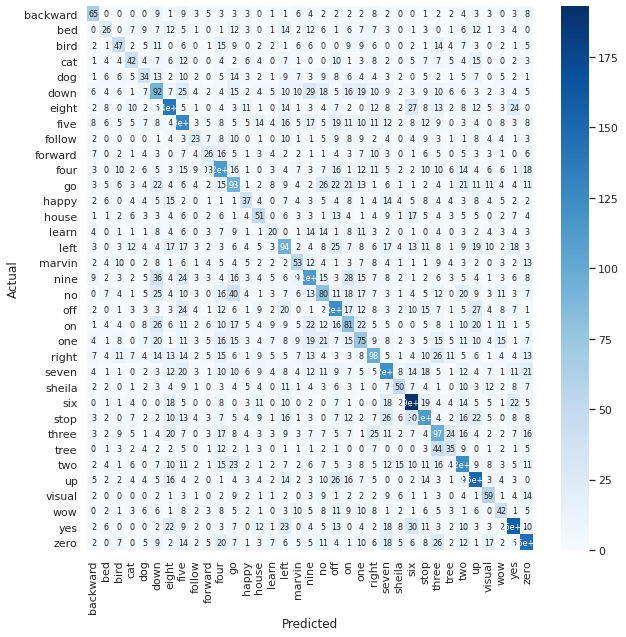

In [43]:
df_cm = pd.DataFrame(cm, columns=np.unique(labels_test_label), index = np.unique(labels_test_label))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sn.set(font_scale=1)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 8})# font size


In [44]:
sess.close()